# 24-1. Project: 모델 바꿔보기

### 라이브러리 버전 확인
---
프로젝트에 사용할 주요 라이브러리 버전을 확인해봅니다.

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import ray

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

2.6.0
1.21.4
8.3.2
1.7.0


### simplebaseline 모델로 변경해 봅시다
---
지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

### MPII 데이터셋 다운로드하기
---
오늘은 MPII Human Pose Dataset을 사용해서 Human Pose Estimation task를 위한 모델을 훈련시켜 보겠습니다.

http://human-pose.mpi-inf.mpg.de/#download  

미리 준비해 둔 데이터를 연결하고 압축을 해제해 주세요.
```bash
$ mkdir -p ~/aiffel/mpii
$ ln -s ~/data/* ~/aiffel/mpii
$ cd ~/aiffel/mpii
$ tar -xvf mpii_human_pose_v1.tar.gz -C . 
$ unzip mpii_human_pose_v1_u12_2.zip
```

mpii_human_pose_v1_u12_2.zip 을 풀어보면 mpii_human_pose_v1_u12_1.mat 파일이 나와서 열어보기 불편한데요. 파이썬에서 읽기 쉽도록 json 파일로 변환해 두었습니다.

```bash
$ cd ~/aiffel/mpii/mpii_human_pose_v1_u12_2
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/train.json
$ wget https://d3s0tskafalll9.cloudfront.net/media/documents/validation.json
```

mpii.zip
마지막으로, 오늘의 실습 코드를 프로젝트로 구성한 파일을 압축 해제합니다.

```bash
$ cd ~/aiffel/mpii && unzip mpii.zip
```

이번 노드에서는 이 프로젝트 파일을 LMS환경에 맞게 편집하여 진행합니다. .py 파일 원본을 확인하면 학습에 도움이 되실거예요.

In [2]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

MODEL_CUSTOM_PATH = os.path.join(PROJECT_PATH, 'models_custom')
print('슝=3')

슝=3


In [3]:
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.applications import ResNet50
import time

In [4]:
EPOCHS = 15
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

### 데이터 전처리

#### json 파싱

In [5]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [6]:
# json annotation 파싱 함수
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


In [7]:
# parse_one_annotation 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [8]:
# TFRecord로 변환하는 함수
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


In [9]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


In [10]:
# 하나의 chunk를 TFRecord로 만들어 주는 함수
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


In [11]:
# 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


앞서 작성한 함수를 사용해 데이터를 TFRecord로 만들어 줍니다. train 데이터는 64개로, val 데이터는 8개의 파일로 만듭니다. 시간이 꽤 걸립니다.

In [12]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-01-05 15:13:33,991	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.92gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=137) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=137) 
(build_single_tfrecord pid=137) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=136) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=136) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=138) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=138) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=137) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=137) start to build tf records for /aiffel/aif

(build_single_tfrecord pid=136) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=136) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=138) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=138) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=137) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=137) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=136) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=136) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

### data label 로 만들기

In [13]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


### 평가 지표 구현

#### mAP

In [14]:
class MeanAveragePrecision(tf.keras.metrics.Metric):
    def __init__(self, name='mAP', threshold=0.5, **kwargs):
        super(MeanAveragePrecision, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.total_ground_truths = self.add_weight(name='gt', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        oks = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))
        correct_keypoints = tf.cast(oks < self.threshold, tf.float32)
        
        self.true_positives.assign_add(tf.reduce_sum(correct_keypoints))
        self.false_positives.assign_add(tf.reduce_sum(1 - correct_keypoints))
        self.total_ground_truths.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.total_ground_truths + 1e-7)
        return (precision + recall) / 2

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.total_ground_truths.assign(0)

(build_single_tfrecord pid=137) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


#### PCHK-0.5

In [15]:
# class PCKh(tf.keras.metrics.Metric):
#     def __init__(self, name='PCKh-0.5', threshold=0.5, **kwargs):
#         super(PCKh, self).__init__(name=name, **kwargs)
#         self.threshold = threshold
#         self.correct_keypoints = self.add_weight(name='correct', initializer='zeros')
#         self.total_keypoints = self.add_weight(name='total', initializer='zeros')
    
#     def update_state(self, y_true, y_pred, head_length, sample_weight=None):
#         distances = tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1))
#         normalized_distances = distances / head_length
#         correct = tf.cast(normalized_distances < self.threshold, tf.float32)
        
#         self.correct_keypoints.assign_add(tf.reduce_sum(correct))
#         self.total_keypoints.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
#     def result(self):
#         return self.correct_keypoints / (self.total_keypoints + 1e-7)
    
#     def reset_states(self):
#         self.correct_keypoints.assign(0)
#         self.total_keypoints.assign(0)

#### 포인트별 계산 추가

In [16]:
class PCKh(tf.keras.metrics.Metric):
    def __init__(self, name='PCKh-0.5', threshold=0.5, num_keypoints=16, **kwargs):
        super(PCKh, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.num_keypoints = num_keypoints
        
        # 변수 초기화
        # 분산 학습 지원: VariableAggregation.SUM을 통해 여러 GPU 결과를 합산
        self.correct_keypoints = self.add_weight(
            name='correct', 
            shape=(num_keypoints,),
            initializer='zeros',
            aggregation=tf.VariableAggregation.SUM
        )
        self.total_keypoints = self.add_weight(
            name='total', 
            shape=(num_keypoints,),
            initializer='zeros',
            aggregation=tf.VariableAggregation.SUM
        )
    
    def update_state(self, y_true, y_pred, head_length, sample_weight=None):
        # 입력 텐서 변환 및 shape 정보 추출
        y_true = tf.convert_to_tensor(y_true) # [batch_size, height, width, num_keypoints]
        y_pred = tf.convert_to_tensor(y_pred)
        
        batch_size = tf.shape(y_true)[0]
        height = tf.shape(y_true)[1]
        width = tf.shape(y_true)[2]
        width_64 = tf.cast(width, tf.int64)
        
        # 배치 전체에 대한 정확도를 저장할 텐서
        batch_correct = tf.zeros([self.num_keypoints], dtype=tf.float32)
        batch_total = tf.zeros([self.num_keypoints], dtype=tf.float32)
        
        for k in range(self.num_keypoints):
            # k번째 키포인트의 히트맵 추출
            y_true_k = y_true[:, :, :, k] # [batch_size, height, width]
            y_pred_k = y_pred[:, :, :, k]
            
            # 2D로 펼치기
            y_true_flat = tf.reshape(y_true_k, [batch_size, height * width])
            y_pred_flat = tf.reshape(y_pred_k, [batch_size, height * width])
            
            # 최대값 위치 찾기 (가장 확률이 높은 위치)
            y_true_idx = tf.argmax(y_true_flat, axis=1)
            y_pred_idx = tf.argmax(y_pred_flat, axis=1)
            
            # 2D 좌표로 변환 (행/열 인덱스 계산)
            y_true_y = tf.cast(y_true_idx // width_64, tf.float32)
            y_true_x = tf.cast(y_true_idx % width_64, tf.float32)
            y_pred_y = tf.cast(y_pred_idx // width_64, tf.float32)
            y_pred_x = tf.cast(y_pred_idx % width_64, tf.float32)
            
            # 유클리드 거리 계산
            distances = tf.sqrt(
                tf.square(y_true_y - y_pred_y) + 
                tf.square(y_true_x - y_pred_x)
            )
            
            # 정규화된 거리
            head_length = tf.cast(head_length, tf.float32)
            normalized_distances = distances / head_length
            
            # 임계값과 비교
            correct = tf.cast(normalized_distances < self.threshold, tf.float32)
            
            # k번째 키포인트에 대한 정확도 업데이트
            batch_correct = tf.tensor_scatter_nd_update(
                batch_correct,
                [[k]], # k번째 인덱스
                [tf.reduce_sum(correct)] # 배치 내 정확한 예측 수의 합
            )
            batch_total = tf.tensor_scatter_nd_update(
                batch_total,
                [[k]],
                [tf.cast(batch_size, tf.float32)]
            )
        
        # 전체 메트릭 업데이트
        self.correct_keypoints.assign_add(batch_correct)
        self.total_keypoints.assign_add(batch_total)
    
    def result(self):
        # 정확도 계산 (epsilon은 0으로 나누기 방지)
        return self.correct_keypoints / (self.total_keypoints + tf.keras.backend.epsilon())
    
    def reset_states(self):
        # 에폭 시작 시 상태 초기화
        self.correct_keypoints.assign(tf.zeros(self.num_keypoints))
        self.total_keypoints.assign(tf.zeros(self.num_keypoints))

### Hourglass 모델 만들기

In [17]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [18]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [19]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


In [20]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


### 학습 엔진 만들기
- GPU 가 여러 개인 환경
- loss 와 학습률 시각화 기능 추가
- SimpleBaseline에 맞게 outputs 이 단일 텐서일 경우도 처리하도록 코드를 보완
    - Hourglass 모델 출력: 여러 단계에서 히트맵이 출력됨 → outputs는 리스트 형태로 여러 히트맵을 포함
	- SimpleBaseline 모델 출력: 마지막 히트맵만 출력됨 → outputs는 단일 텐서
- 평가 지표 추가하기(mAP, PCKh-0.5)

In [21]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        
        # 추가: mAP와 PCKh-0.5 메트릭 초기화
        self.map_metric = MeanAveragePrecision(threshold=0.5)
        self.pckh_metric = PCKh(threshold=0.5)
        
        # mAP 및 PCKh 기록
        self.train_map = []  # Train mAP 기록
        self.val_map = []    # Val mAP 기록
        self.train_pckh = []  # Train PCKh 기록
        self.val_pckh = []    # Val PCKh 기록
        
        # 추가됨: 손실 및 학습률을 기록하기 위한 리스트
        self.train_losses = []  # Train Loss 기록
        self.val_losses = []    # Validation Loss 기록
        self.learning_rates = []  # Learning Rate 기록

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        
        # 추가됨: outputs를 리스트로 강제 변환
        if not isinstance(outputs, list):
            outputs = [outputs]
        
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))
        
        # 추가됨 : 메트릭 업데이트
        self.map_metric.update_state(labels, outputs)
        self.pckh_metric.update_state(labels, outputs, head_length=1.0)  # Head Length는 데이터셋에 맞게 조정 필요
        
        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        
        # 메트릭 업데이트
        self.map_metric.update_state(labels, outputs)
        self.pckh_metric.update_state(labels, outputs, head_length=1.0)  # Head Length는 데이터셋에 맞게 조정 필요
        
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            start_time = time.time()
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            
            end_time = time.time()
            epoch_duration = end_time - start_time
            print(f'Epoch {epoch} completed in {epoch_duration:.2f} seconds')
            
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))
            
            # 메트릭 기록
#             print('Epoch {} train loss {}, mAP {}, PCKh {}'.format(
#                 epoch, train_loss, self.map_metric.result(), self.pckh_metric.result()
#             ))
#             print('Epoch {} val loss {}, mAP {}, PCKh {}'.format(
#                 epoch, val_loss, self.map_metric.result(), self.pckh_metric.result()
#             ))
            print('Epoch {} train loss {}, PCKh {}'.format(
                epoch, train_loss, self.pckh_metric.result()
            ))
            print('Epoch {} val loss {}, PCKh {}'.format(
                epoch, val_loss, self.pckh_metric.result()
            ))
            
            # 메트릭 기록 - 한 번만 저장하도록 수정
            self.train_map.append(self.map_metric.result().numpy())
            self.val_map.append(self.map_metric.result().numpy())
            self.train_pckh.append(self.pckh_metric.result().numpy())  # PCKh 메트릭 저장
            self.val_pckh.append(self.pckh_metric.result().numpy())
            
#             # 포인트별 PCKh 기록 추가
#             train_pckh_points = self.pckh_metric.result().numpy()
#             val_pckh_points = self.pckh_metric.result().numpy()

#             self.train_pckh.append(train_pckh_points)
#             self.val_pckh.append(val_pckh_points)
            
            # 손실 및 학습률 기록
            self.train_losses.append(train_loss.numpy())  # Train Loss 기록
            self.val_losses.append(val_loss.numpy())      # Validation Loss 기록
            self.learning_rates.append(self.current_learning_rate)  # Learning Rate 기록

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        # 학습 종료 후 시각화
        self.plot_metrics()
        
        return self.best_model

#     def save_model(self, epoch, loss):
#         model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
#         self.model.save_weights(model_name)
#         self.best_model = model_name
#         print("Model {} saved.".format(model_name))

    def save_model(self, epoch, loss):
        """
        모델을 저장할 때 StackedHourglassNetwork와 SimpleBaseline에 따라 파일 이름을 구분
        """
        # 모델 타입 확인
        model_type = self.model.name if hasattr(self.model, 'name') else 'unknown_model'

        # 저장 경로 및 파일명 설정
        # MODEL_PATH 는 쓰기 권한 문제로 MODEL_CUSTOM_PATH 로 변경
        model_name = f"{MODEL_CUSTOM_PATH}/{model_type}-epoch-{epoch}-loss-{loss:.4f}.h5"

        # 모델 저장
        self.model.save_weights(model_name)
        self.best_model = model_name
        print(f"Model {model_name} saved.")
    
    def plot_metrics(self):
        """학습 손실, 검증 손실, 학습률, PCKh 포인트별 시각화"""
        # epoch 수 확인 및 디버깅
        print("데이터 길이 확인:")
        print(f"train_losses: {len(self.train_losses)}")
        print(f"val_losses: {len(self.val_losses)}")
        print(f"learning_rates: {len(self.learning_rates)}")
        print(f"train_pckh: {len(self.train_pckh)}")
        print(f"val_pckh: {len(self.val_pckh)}")

        # PCKh 데이터가 실제 epoch 수보다 많은 경우 처리
        actual_epochs = len(self.train_losses)
        epochs = range(1, actual_epochs + 1)

        plt.figure(figsize=(20, 10))

        # Training and Validation Loss
        plt.subplot(2, 2, 1)
        if len(self.train_losses) > 0:
            plt.plot(epochs, self.train_losses, label='Train Loss')
        if len(self.val_losses) > 0:
            plt.plot(epochs, self.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Learning Rate
        plt.subplot(2, 2, 2)
        if len(self.learning_rates) > 0:
            plt.plot(epochs, self.learning_rates, label='Learning Rate', color='orange')
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.legend()

        # Overall PCKh
        plt.subplot(2, 2, 3)
        if len(self.train_pckh) > 0:
            # 실제 epoch 수만큼만 데이터 사용
            train_mean_pckh = [np.mean(pckh) if pckh is not None else np.nan 
                              for pckh in self.train_pckh[:actual_epochs]]
            plt.plot(epochs, train_mean_pckh, label='Train PCKh')
        if len(self.val_pckh) > 0:
            val_mean_pckh = [np.mean(pckh) if pckh is not None else np.nan 
                            for pckh in self.val_pckh[:actual_epochs]]
            plt.plot(epochs, val_mean_pckh, label='Val PCKh')
        plt.title('Overall PCKh')
        plt.xlabel('Epochs')
        plt.ylabel('PCKh Score')
        plt.legend()

        # PCKh by Keypoint
        plt.subplot(2, 2, 4)
        if len(self.train_pckh) > 0 and len(self.train_pckh[0]) > 0:
            num_keypoints = len(self.train_pckh[0])
            for i in range(num_keypoints):
                train_keypoint = [pckh[i] if pckh is not None else np.nan 
                                for pckh in self.train_pckh[:actual_epochs]]
                plt.plot(epochs, train_keypoint, label=f'Train Keypoint {i+1}')
                if len(self.val_pckh) > 0:
                    val_keypoint = [pckh[i] if pckh is not None else np.nan 
                                  for pckh in self.val_pckh[:actual_epochs]]
                    plt.plot(epochs, val_keypoint, label=f'Val Keypoint {i+1}', linestyle='--')
        plt.title('PCKh by Keypoint')
        plt.xlabel('Epochs')
        plt.ylabel('PCKh Score')
        plt.legend(loc='upper right', fontsize='small')

        plt.tight_layout()
        plt.show()

#     def plot_metrics(self):
#         """학습 손실, 검증 손실, 학습률을 시각화합니다."""
#         epochs = range(1, len(self.train_losses) + 1)

#         plt.figure(figsize=(16, 5))

#         # Train Loss vs Val Loss
#         plt.subplot(1, 3, 1)
#         plt.plot(epochs, self.train_losses, label='Train Loss')
#         plt.plot(epochs, self.val_losses, label='Val Loss')
#         plt.title('Training and Validation Loss')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.legend()

#         # Learning Rate
#         plt.subplot(1, 3, 2)
#         plt.plot(epochs, self.learning_rates, label='Learning Rate', color='orange')
#         plt.title('Learning Rate')
#         plt.xlabel('Epochs')
#         plt.ylabel('Learning Rate')
#         plt.legend()
        
#         # Train mAP vs Val mAP
#         plt.subplot(1, 3, 3)
#         # plt.plot(epochs, self.train_map, label='Train mAP')
#         # plt.plot(epochs, self.val_map, label='Val mAP')
#         plt.plot(epochs, self.train_pckh, label='Train PCKh')
#         plt.plot(epochs, self.val_pckh, label='Val PCKh')
#         # plt.title('mAP and PCKh')
#         plt.title('PCKh')
#         plt.xlabel('Epochs')
#         plt.ylabel('Score')
#         plt.legend()

#         plt.tight_layout()
#         plt.show()

In [22]:
# 데이터셋 make 함수
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

데이터셋과 모델, 훈련용 객체를 조립만하면 되겠군요. 주의할 점은 with strategy.scope():부분이 반드시 필요하다는 점이에요. 또 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다는 것도 중요해요.

In [23]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_CUSTOM_PATH):
        os.makedirs(MODEL_CUSTOM_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.8155036 epoch total loss 2.8155036
Trained batch 2 batch loss 2.58777118 epoch total loss 2.70163727
Trained batch 3 batch loss 2.58325481 epoch total loss 2.66217637
Trained batch 4 batch loss 2.51172566 epoch total loss 2.62456369
Trained batch 5 batch loss 2.49339175 epoch total loss 2.59832931
Trained batch 6 batch loss 2.38219833 epoch total loss 2.5623076
Trained batch 7 batch loss 2.30516934 epoch total loss 2.52557349
Trained batch 8 batch loss 2.23873758 epoch total loss 2.48971891
Trained batch 9 batch loss 2.22424126 epoch total loss 2.46022129
Trained batch 10 batch loss 2.17547607 epoch total loss 2.43174696
Trained batch 11 batch loss 2.13746405 epoch total loss 2.40499401
Trained batch 12 batch loss 2.09227228 epoch total loss 2.37893367
Trained batch 13 

Trained batch 121 batch loss 1.70507038 epoch total loss 1.79291904
Trained batch 122 batch loss 1.75387108 epoch total loss 1.79259908
Trained batch 123 batch loss 1.71769774 epoch total loss 1.79199
Trained batch 124 batch loss 1.68549693 epoch total loss 1.79113126
Trained batch 125 batch loss 1.7194525 epoch total loss 1.79055786
Trained batch 126 batch loss 1.66973615 epoch total loss 1.78959894
Trained batch 127 batch loss 1.66922796 epoch total loss 1.78865123
Trained batch 128 batch loss 1.69957864 epoch total loss 1.7879554
Trained batch 129 batch loss 1.7458775 epoch total loss 1.78762925
Trained batch 130 batch loss 1.71038675 epoch total loss 1.78703511
Trained batch 131 batch loss 1.66577721 epoch total loss 1.78610945
Trained batch 132 batch loss 1.66665673 epoch total loss 1.78520441
Trained batch 133 batch loss 1.63823819 epoch total loss 1.78409946
Trained batch 134 batch loss 1.70407772 epoch total loss 1.78350222
Trained batch 135 batch loss 1.61189854 epoch total lo

Trained batch 243 batch loss 1.65438318 epoch total loss 1.71858633
Trained batch 244 batch loss 1.59719121 epoch total loss 1.71808887
Trained batch 245 batch loss 1.63403535 epoch total loss 1.71774578
Trained batch 246 batch loss 1.6279062 epoch total loss 1.71738052
Trained batch 247 batch loss 1.57788157 epoch total loss 1.71681583
Trained batch 248 batch loss 1.56583381 epoch total loss 1.71620691
Trained batch 249 batch loss 1.65814102 epoch total loss 1.71597373
Trained batch 250 batch loss 1.61793888 epoch total loss 1.71558166
Trained batch 251 batch loss 1.68035555 epoch total loss 1.71544135
Trained batch 252 batch loss 1.67062151 epoch total loss 1.71526349
Trained batch 253 batch loss 1.68180346 epoch total loss 1.71513116
Trained batch 254 batch loss 1.68255985 epoch total loss 1.71500289
Trained batch 255 batch loss 1.66306221 epoch total loss 1.71479928
Trained batch 256 batch loss 1.58062744 epoch total loss 1.71427512
Trained batch 257 batch loss 1.57160747 epoch tot

Trained batch 365 batch loss 1.49916339 epoch total loss 1.67187953
Trained batch 366 batch loss 1.62906253 epoch total loss 1.67176259
Trained batch 367 batch loss 1.72470415 epoch total loss 1.67190695
Trained batch 368 batch loss 1.67158341 epoch total loss 1.67190599
Trained batch 369 batch loss 1.6070497 epoch total loss 1.67173028
Trained batch 370 batch loss 1.5775249 epoch total loss 1.67147565
Trained batch 371 batch loss 1.49873614 epoch total loss 1.67101
Trained batch 372 batch loss 1.49307156 epoch total loss 1.67053151
Trained batch 373 batch loss 1.44983196 epoch total loss 1.66993988
Trained batch 374 batch loss 1.47606659 epoch total loss 1.66942155
Trained batch 375 batch loss 1.75556874 epoch total loss 1.66965115
Trained batch 376 batch loss 1.60776544 epoch total loss 1.66948664
Trained batch 377 batch loss 1.63674068 epoch total loss 1.66939974
Trained batch 378 batch loss 1.61148691 epoch total loss 1.66924655
Trained batch 379 batch loss 1.59946418 epoch total l

Trained batch 487 batch loss 1.56198299 epoch total loss 1.64944267
Trained batch 488 batch loss 1.63339114 epoch total loss 1.64940965
Trained batch 489 batch loss 1.5396117 epoch total loss 1.64918518
Trained batch 490 batch loss 1.58514571 epoch total loss 1.64905441
Trained batch 491 batch loss 1.57896578 epoch total loss 1.64891171
Trained batch 492 batch loss 1.58081818 epoch total loss 1.64877331
Trained batch 493 batch loss 1.57402301 epoch total loss 1.64862168
Trained batch 494 batch loss 1.65049219 epoch total loss 1.64862549
Trained batch 495 batch loss 1.63228071 epoch total loss 1.64859247
Trained batch 496 batch loss 1.68711948 epoch total loss 1.6486702
Trained batch 497 batch loss 1.68600333 epoch total loss 1.6487453
Trained batch 498 batch loss 1.63299406 epoch total loss 1.64871359
Trained batch 499 batch loss 1.56023347 epoch total loss 1.64853632
Trained batch 500 batch loss 1.5657866 epoch total loss 1.64837086
Trained batch 501 batch loss 1.57572913 epoch total 

Trained batch 609 batch loss 1.49392307 epoch total loss 1.62486911
Trained batch 610 batch loss 1.37749863 epoch total loss 1.62446356
Trained batch 611 batch loss 1.30528712 epoch total loss 1.62394118
Trained batch 612 batch loss 1.50299037 epoch total loss 1.62374353
Trained batch 613 batch loss 1.38414884 epoch total loss 1.62335277
Trained batch 614 batch loss 1.40660381 epoch total loss 1.62299979
Trained batch 615 batch loss 1.45961154 epoch total loss 1.62273407
Trained batch 616 batch loss 1.44322491 epoch total loss 1.62244272
Trained batch 617 batch loss 1.48128211 epoch total loss 1.62221384
Trained batch 618 batch loss 1.53352487 epoch total loss 1.62207031
Trained batch 619 batch loss 1.46303368 epoch total loss 1.6218133
Trained batch 620 batch loss 1.52623928 epoch total loss 1.62165916
Trained batch 621 batch loss 1.59587264 epoch total loss 1.62161767
Trained batch 622 batch loss 1.31862414 epoch total loss 1.62113059
Trained batch 623 batch loss 1.23235333 epoch tot

Trained batch 731 batch loss 1.58875465 epoch total loss 1.60681403
Trained batch 732 batch loss 1.53710198 epoch total loss 1.60671878
Trained batch 733 batch loss 1.56132686 epoch total loss 1.60665679
Trained batch 734 batch loss 1.54779947 epoch total loss 1.60657668
Trained batch 735 batch loss 1.61922204 epoch total loss 1.60659397
Trained batch 736 batch loss 1.4714247 epoch total loss 1.60641026
Trained batch 737 batch loss 1.48335123 epoch total loss 1.60624337
Trained batch 738 batch loss 1.49972701 epoch total loss 1.60609913
Trained batch 739 batch loss 1.49949431 epoch total loss 1.60595489
Trained batch 740 batch loss 1.62220573 epoch total loss 1.60597682
Trained batch 741 batch loss 1.51952064 epoch total loss 1.60586011
Trained batch 742 batch loss 1.51278043 epoch total loss 1.60573483
Trained batch 743 batch loss 1.33020806 epoch total loss 1.60536397
Trained batch 744 batch loss 1.37638 epoch total loss 1.60505605
Trained batch 745 batch loss 1.56301165 epoch total 

Trained batch 852 batch loss 1.44291 epoch total loss 1.59049785
Trained batch 853 batch loss 1.37583542 epoch total loss 1.5902462
Trained batch 854 batch loss 1.40349543 epoch total loss 1.59002745
Trained batch 855 batch loss 1.49740279 epoch total loss 1.58991909
Trained batch 856 batch loss 1.54011166 epoch total loss 1.58986104
Trained batch 857 batch loss 1.48106921 epoch total loss 1.58973408
Trained batch 858 batch loss 1.4139185 epoch total loss 1.58952916
Trained batch 859 batch loss 1.43147206 epoch total loss 1.58934522
Trained batch 860 batch loss 1.40470934 epoch total loss 1.58913052
Trained batch 861 batch loss 1.5605104 epoch total loss 1.58909726
Trained batch 862 batch loss 1.52769399 epoch total loss 1.58902609
Trained batch 863 batch loss 1.51473975 epoch total loss 1.58894
Trained batch 864 batch loss 1.43896341 epoch total loss 1.58876646
Trained batch 865 batch loss 1.40594471 epoch total loss 1.58855498
Trained batch 866 batch loss 1.39647198 epoch total loss 

Trained batch 974 batch loss 1.32455611 epoch total loss 1.5746721
Trained batch 975 batch loss 1.35025191 epoch total loss 1.57444191
Trained batch 976 batch loss 1.38363135 epoch total loss 1.57424641
Trained batch 977 batch loss 1.45032728 epoch total loss 1.57411957
Trained batch 978 batch loss 1.38694644 epoch total loss 1.57392824
Trained batch 979 batch loss 1.41555762 epoch total loss 1.57376635
Trained batch 980 batch loss 1.43270016 epoch total loss 1.57362247
Trained batch 981 batch loss 1.47872853 epoch total loss 1.57352579
Trained batch 982 batch loss 1.48134589 epoch total loss 1.57343185
Trained batch 983 batch loss 1.58154452 epoch total loss 1.57344007
Trained batch 984 batch loss 1.51878214 epoch total loss 1.57338464
Trained batch 985 batch loss 1.506042 epoch total loss 1.57331622
Trained batch 986 batch loss 1.52589989 epoch total loss 1.57326806
Trained batch 987 batch loss 1.53362346 epoch total loss 1.57322788
Trained batch 988 batch loss 1.53077507 epoch total

Trained batch 1094 batch loss 1.39929008 epoch total loss 1.56343591
Trained batch 1095 batch loss 1.50988841 epoch total loss 1.56338704
Trained batch 1096 batch loss 1.36217546 epoch total loss 1.56320345
Trained batch 1097 batch loss 1.39427054 epoch total loss 1.56304944
Trained batch 1098 batch loss 1.38988566 epoch total loss 1.56289172
Trained batch 1099 batch loss 1.47429705 epoch total loss 1.56281114
Trained batch 1100 batch loss 1.48604608 epoch total loss 1.5627414
Trained batch 1101 batch loss 1.70816624 epoch total loss 1.56287336
Trained batch 1102 batch loss 1.57626736 epoch total loss 1.56288564
Trained batch 1103 batch loss 1.58364177 epoch total loss 1.56290436
Trained batch 1104 batch loss 1.36933422 epoch total loss 1.56272912
Trained batch 1105 batch loss 1.23637736 epoch total loss 1.56243372
Trained batch 1106 batch loss 1.50357985 epoch total loss 1.56238043
Trained batch 1107 batch loss 1.4755758 epoch total loss 1.56230211
Trained batch 1108 batch loss 1.4345

Trained batch 1214 batch loss 1.56498694 epoch total loss 1.5528034
Trained batch 1215 batch loss 1.56121302 epoch total loss 1.55281019
Trained batch 1216 batch loss 1.46567798 epoch total loss 1.55273855
Trained batch 1217 batch loss 1.48180008 epoch total loss 1.55268025
Trained batch 1218 batch loss 1.34488559 epoch total loss 1.55250967
Trained batch 1219 batch loss 1.49950421 epoch total loss 1.55246615
Trained batch 1220 batch loss 1.50067854 epoch total loss 1.55242383
Trained batch 1221 batch loss 1.36731529 epoch total loss 1.5522722
Trained batch 1222 batch loss 1.47957945 epoch total loss 1.55221272
Trained batch 1223 batch loss 1.31405723 epoch total loss 1.55201805
Trained batch 1224 batch loss 1.39356017 epoch total loss 1.55188859
Trained batch 1225 batch loss 1.36284471 epoch total loss 1.55173421
Trained batch 1226 batch loss 1.42769277 epoch total loss 1.551633
Trained batch 1227 batch loss 1.56131864 epoch total loss 1.55164087
Trained batch 1228 batch loss 1.622732

Trained batch 1334 batch loss 1.43695676 epoch total loss 1.54088116
Trained batch 1335 batch loss 1.46510756 epoch total loss 1.54082429
Trained batch 1336 batch loss 1.48943305 epoch total loss 1.54078591
Trained batch 1337 batch loss 1.51865149 epoch total loss 1.54076934
Trained batch 1338 batch loss 1.45365345 epoch total loss 1.54070413
Trained batch 1339 batch loss 1.37835491 epoch total loss 1.5405829
Trained batch 1340 batch loss 1.40943491 epoch total loss 1.54048502
Trained batch 1341 batch loss 1.44880378 epoch total loss 1.5404166
Trained batch 1342 batch loss 1.44338882 epoch total loss 1.54034436
Trained batch 1343 batch loss 1.41503012 epoch total loss 1.54025102
Trained batch 1344 batch loss 1.29673576 epoch total loss 1.54006982
Trained batch 1345 batch loss 1.39399052 epoch total loss 1.53996122
Trained batch 1346 batch loss 1.54117441 epoch total loss 1.53996217
Trained batch 1347 batch loss 1.32709777 epoch total loss 1.53980422
Trained batch 1348 batch loss 1.3466

Validated batch 108 batch loss 1.54220319
Validated batch 109 batch loss 1.3299247
Validated batch 110 batch loss 1.50280416
Validated batch 111 batch loss 1.35259342
Validated batch 112 batch loss 1.37537038
Validated batch 113 batch loss 1.41313732
Validated batch 114 batch loss 1.41503394
Validated batch 115 batch loss 1.52134252
Validated batch 116 batch loss 1.42772472
Validated batch 117 batch loss 1.3332
Validated batch 118 batch loss 1.40991974
Validated batch 119 batch loss 1.3598299
Validated batch 120 batch loss 1.39585268
Validated batch 121 batch loss 1.41916656
Validated batch 122 batch loss 1.41046941
Validated batch 123 batch loss 1.43609333
Validated batch 124 batch loss 1.44310784
Validated batch 125 batch loss 1.38830066
Validated batch 126 batch loss 1.52019691
Validated batch 127 batch loss 1.47240746
Validated batch 128 batch loss 1.34797609
Validated batch 129 batch loss 1.39062023
Validated batch 130 batch loss 1.42750502
Validated batch 131 batch loss 1.4213672

Trained batch 64 batch loss 1.59464204 epoch total loss 1.3870635
Trained batch 65 batch loss 1.36877406 epoch total loss 1.38678217
Trained batch 66 batch loss 1.40510988 epoch total loss 1.38705993
Trained batch 67 batch loss 1.46829367 epoch total loss 1.38827229
Trained batch 68 batch loss 1.43895125 epoch total loss 1.38901758
Trained batch 69 batch loss 1.48821592 epoch total loss 1.39045513
Trained batch 70 batch loss 1.48142576 epoch total loss 1.39175475
Trained batch 71 batch loss 1.47314191 epoch total loss 1.39290106
Trained batch 72 batch loss 1.41532063 epoch total loss 1.39321244
Trained batch 73 batch loss 1.42933083 epoch total loss 1.39370716
Trained batch 74 batch loss 1.47009349 epoch total loss 1.39473939
Trained batch 75 batch loss 1.37547386 epoch total loss 1.39448249
Trained batch 76 batch loss 1.47334814 epoch total loss 1.39552021
Trained batch 77 batch loss 1.4090848 epoch total loss 1.39569652
Trained batch 78 batch loss 1.39312136 epoch total loss 1.395663

Trained batch 186 batch loss 1.19914114 epoch total loss 1.40944707
Trained batch 187 batch loss 1.29017115 epoch total loss 1.40880919
Trained batch 188 batch loss 1.40822458 epoch total loss 1.4088062
Trained batch 189 batch loss 1.39726627 epoch total loss 1.40874517
Trained batch 190 batch loss 1.39680862 epoch total loss 1.40868247
Trained batch 191 batch loss 1.38217688 epoch total loss 1.40854359
Trained batch 192 batch loss 1.31947756 epoch total loss 1.40807974
Trained batch 193 batch loss 1.41640353 epoch total loss 1.40812302
Trained batch 194 batch loss 1.31772697 epoch total loss 1.40765691
Trained batch 195 batch loss 1.25759578 epoch total loss 1.40688741
Trained batch 196 batch loss 1.40910625 epoch total loss 1.40689886
Trained batch 197 batch loss 1.40771472 epoch total loss 1.40690291
Trained batch 198 batch loss 1.44119763 epoch total loss 1.40707612
Trained batch 199 batch loss 1.28896737 epoch total loss 1.4064827
Trained batch 200 batch loss 1.28113401 epoch tota

Trained batch 307 batch loss 1.1737386 epoch total loss 1.39497256
Trained batch 308 batch loss 1.19664121 epoch total loss 1.39432871
Trained batch 309 batch loss 1.40119433 epoch total loss 1.39435089
Trained batch 310 batch loss 1.52479 epoch total loss 1.3947717
Trained batch 311 batch loss 1.36135864 epoch total loss 1.39466417
Trained batch 312 batch loss 1.48937058 epoch total loss 1.39496779
Trained batch 313 batch loss 1.46748316 epoch total loss 1.39519942
Trained batch 314 batch loss 1.42197549 epoch total loss 1.39528465
Trained batch 315 batch loss 1.368168 epoch total loss 1.39519858
Trained batch 316 batch loss 1.32398653 epoch total loss 1.39497316
Trained batch 317 batch loss 1.29399598 epoch total loss 1.39465463
Trained batch 318 batch loss 1.42004573 epoch total loss 1.3947345
Trained batch 319 batch loss 1.45669603 epoch total loss 1.39492869
Trained batch 320 batch loss 1.424088 epoch total loss 1.39501989
Trained batch 321 batch loss 1.37274313 epoch total loss 1

Trained batch 428 batch loss 1.45211542 epoch total loss 1.38713443
Trained batch 429 batch loss 1.44621253 epoch total loss 1.38727224
Trained batch 430 batch loss 1.46709466 epoch total loss 1.38745785
Trained batch 431 batch loss 1.34215117 epoch total loss 1.38735271
Trained batch 432 batch loss 1.3301549 epoch total loss 1.38722026
Trained batch 433 batch loss 1.35145187 epoch total loss 1.38713765
Trained batch 434 batch loss 1.27574778 epoch total loss 1.38688099
Trained batch 435 batch loss 1.36964273 epoch total loss 1.38684142
Trained batch 436 batch loss 1.34313285 epoch total loss 1.38674116
Trained batch 437 batch loss 1.49663794 epoch total loss 1.38699269
Trained batch 438 batch loss 1.3545084 epoch total loss 1.38691843
Trained batch 439 batch loss 1.31305945 epoch total loss 1.38675022
Trained batch 440 batch loss 1.35747147 epoch total loss 1.3866837
Trained batch 441 batch loss 1.42752361 epoch total loss 1.38677633
Trained batch 442 batch loss 1.36836541 epoch total

Trained batch 549 batch loss 1.45884812 epoch total loss 1.3861239
Trained batch 550 batch loss 1.47209918 epoch total loss 1.38628018
Trained batch 551 batch loss 1.40992451 epoch total loss 1.38632309
Trained batch 552 batch loss 1.36492968 epoch total loss 1.38628435
Trained batch 553 batch loss 1.4600327 epoch total loss 1.38641763
Trained batch 554 batch loss 1.38184237 epoch total loss 1.3864094
Trained batch 555 batch loss 1.42000353 epoch total loss 1.38646984
Trained batch 556 batch loss 1.38706839 epoch total loss 1.38647103
Trained batch 557 batch loss 1.44469023 epoch total loss 1.38657558
Trained batch 558 batch loss 1.3896507 epoch total loss 1.38658106
Trained batch 559 batch loss 1.38265932 epoch total loss 1.38657391
Trained batch 560 batch loss 1.37670565 epoch total loss 1.38655639
Trained batch 561 batch loss 1.36700797 epoch total loss 1.38652146
Trained batch 562 batch loss 1.35807061 epoch total loss 1.38647091
Trained batch 563 batch loss 1.25581217 epoch total 

Trained batch 671 batch loss 1.2771697 epoch total loss 1.38166809
Trained batch 672 batch loss 1.31844008 epoch total loss 1.38157403
Trained batch 673 batch loss 1.49559093 epoch total loss 1.38174343
Trained batch 674 batch loss 1.36638618 epoch total loss 1.38172066
Trained batch 675 batch loss 1.26848328 epoch total loss 1.38155293
Trained batch 676 batch loss 1.41005766 epoch total loss 1.38159502
Trained batch 677 batch loss 1.40181077 epoch total loss 1.38162494
Trained batch 678 batch loss 1.20438302 epoch total loss 1.38136351
Trained batch 679 batch loss 1.31890106 epoch total loss 1.38127148
Trained batch 680 batch loss 1.4612062 epoch total loss 1.38138902
Trained batch 681 batch loss 1.44616866 epoch total loss 1.38148415
Trained batch 682 batch loss 1.31015038 epoch total loss 1.3813796
Trained batch 683 batch loss 1.25804019 epoch total loss 1.381199
Trained batch 684 batch loss 1.23556471 epoch total loss 1.38098609
Trained batch 685 batch loss 1.18392658 epoch total l

Trained batch 793 batch loss 1.35234785 epoch total loss 1.37390459
Trained batch 794 batch loss 1.3254782 epoch total loss 1.37384355
Trained batch 795 batch loss 1.29488015 epoch total loss 1.37374425
Trained batch 796 batch loss 1.30492437 epoch total loss 1.37365782
Trained batch 797 batch loss 1.36573768 epoch total loss 1.37364793
Trained batch 798 batch loss 1.40534782 epoch total loss 1.37368762
Trained batch 799 batch loss 1.37040877 epoch total loss 1.37368345
Trained batch 800 batch loss 1.20869553 epoch total loss 1.37347734
Trained batch 801 batch loss 1.34520864 epoch total loss 1.37344205
Trained batch 802 batch loss 1.39070463 epoch total loss 1.37346363
Trained batch 803 batch loss 1.36636114 epoch total loss 1.37345469
Trained batch 804 batch loss 1.28375959 epoch total loss 1.37334323
Trained batch 805 batch loss 1.28034151 epoch total loss 1.37322783
Trained batch 806 batch loss 1.33089292 epoch total loss 1.37317526
Trained batch 807 batch loss 1.53945076 epoch tot

Trained batch 914 batch loss 1.25416887 epoch total loss 1.37186491
Trained batch 915 batch loss 1.22506857 epoch total loss 1.37170446
Trained batch 916 batch loss 1.27185261 epoch total loss 1.3715955
Trained batch 917 batch loss 1.2939657 epoch total loss 1.37151086
Trained batch 918 batch loss 1.333426 epoch total loss 1.37146926
Trained batch 919 batch loss 1.33907247 epoch total loss 1.37143409
Trained batch 920 batch loss 1.39228439 epoch total loss 1.37145674
Trained batch 921 batch loss 1.29810202 epoch total loss 1.37137711
Trained batch 922 batch loss 1.28356481 epoch total loss 1.37128186
Trained batch 923 batch loss 1.34549308 epoch total loss 1.37125397
Trained batch 924 batch loss 1.42381477 epoch total loss 1.37131083
Trained batch 925 batch loss 1.38456643 epoch total loss 1.37132514
Trained batch 926 batch loss 1.36378562 epoch total loss 1.37131691
Trained batch 927 batch loss 1.2679038 epoch total loss 1.37120545
Trained batch 928 batch loss 1.23113859 epoch total l

Trained batch 1035 batch loss 1.3197993 epoch total loss 1.36716354
Trained batch 1036 batch loss 1.24059141 epoch total loss 1.36704135
Trained batch 1037 batch loss 1.24441206 epoch total loss 1.36692309
Trained batch 1038 batch loss 1.28479481 epoch total loss 1.36684394
Trained batch 1039 batch loss 1.26878166 epoch total loss 1.36674964
Trained batch 1040 batch loss 1.25240493 epoch total loss 1.36663973
Trained batch 1041 batch loss 1.28095818 epoch total loss 1.36655748
Trained batch 1042 batch loss 1.40418971 epoch total loss 1.3665936
Trained batch 1043 batch loss 1.30341613 epoch total loss 1.36653304
Trained batch 1044 batch loss 1.35691702 epoch total loss 1.36652386
Trained batch 1045 batch loss 1.2689786 epoch total loss 1.3664304
Trained batch 1046 batch loss 1.52261019 epoch total loss 1.36657977
Trained batch 1047 batch loss 1.35373759 epoch total loss 1.36656749
Trained batch 1048 batch loss 1.37553406 epoch total loss 1.36657596
Trained batch 1049 batch loss 1.404099

Trained batch 1155 batch loss 1.34312868 epoch total loss 1.36258817
Trained batch 1156 batch loss 1.2926532 epoch total loss 1.36252761
Trained batch 1157 batch loss 1.32137394 epoch total loss 1.36249208
Trained batch 1158 batch loss 1.25481367 epoch total loss 1.36239898
Trained batch 1159 batch loss 1.20927238 epoch total loss 1.3622669
Trained batch 1160 batch loss 1.34758985 epoch total loss 1.36225414
Trained batch 1161 batch loss 1.41446483 epoch total loss 1.36229908
Trained batch 1162 batch loss 1.35804045 epoch total loss 1.36229539
Trained batch 1163 batch loss 1.44059789 epoch total loss 1.36236274
Trained batch 1164 batch loss 1.30647993 epoch total loss 1.3623147
Trained batch 1165 batch loss 1.33995008 epoch total loss 1.36229563
Trained batch 1166 batch loss 1.26677895 epoch total loss 1.36221361
Trained batch 1167 batch loss 1.22194874 epoch total loss 1.36209345
Trained batch 1168 batch loss 1.32327652 epoch total loss 1.36206007
Trained batch 1169 batch loss 1.34046

Trained batch 1275 batch loss 1.30265176 epoch total loss 1.35986483
Trained batch 1276 batch loss 1.18381453 epoch total loss 1.35972691
Trained batch 1277 batch loss 1.21154535 epoch total loss 1.3596108
Trained batch 1278 batch loss 1.37008023 epoch total loss 1.35961902
Trained batch 1279 batch loss 1.16517127 epoch total loss 1.35946703
Trained batch 1280 batch loss 1.24269378 epoch total loss 1.35937572
Trained batch 1281 batch loss 1.33669281 epoch total loss 1.35935807
Trained batch 1282 batch loss 1.39783049 epoch total loss 1.35938799
Trained batch 1283 batch loss 1.33337259 epoch total loss 1.35936773
Trained batch 1284 batch loss 1.341856 epoch total loss 1.35935414
Trained batch 1285 batch loss 1.17464352 epoch total loss 1.35921037
Trained batch 1286 batch loss 1.09271085 epoch total loss 1.35900307
Trained batch 1287 batch loss 1.30744576 epoch total loss 1.35896301
Trained batch 1288 batch loss 1.37289381 epoch total loss 1.35897386
Trained batch 1289 batch loss 1.43734

Validated batch 9 batch loss 1.42386317
Validated batch 10 batch loss 1.33727407
Validated batch 11 batch loss 1.36109626
Validated batch 12 batch loss 1.44088507
Validated batch 13 batch loss 1.41779947
Validated batch 14 batch loss 1.4044807
Validated batch 15 batch loss 1.4192481
Validated batch 16 batch loss 1.44720483
Validated batch 17 batch loss 1.37402487
Validated batch 18 batch loss 1.26229298
Validated batch 19 batch loss 1.33587897
Validated batch 20 batch loss 1.41555977
Validated batch 21 batch loss 1.33357024
Validated batch 22 batch loss 1.38129711
Validated batch 23 batch loss 1.31731319
Validated batch 24 batch loss 1.4127996
Validated batch 25 batch loss 1.35666049
Validated batch 26 batch loss 1.26203871
Validated batch 27 batch loss 1.27318776
Validated batch 28 batch loss 1.30709255
Validated batch 29 batch loss 1.37472725
Validated batch 30 batch loss 1.30248046
Validated batch 31 batch loss 1.28960133
Validated batch 32 batch loss 1.35621941
Validated batch 33 b

Trained batch 4 batch loss 1.45757377 epoch total loss 1.36321867
Trained batch 5 batch loss 1.37713838 epoch total loss 1.36600268
Trained batch 6 batch loss 1.50951076 epoch total loss 1.38992071
Trained batch 7 batch loss 1.45624757 epoch total loss 1.39939594
Trained batch 8 batch loss 1.29152799 epoch total loss 1.38591242
Trained batch 9 batch loss 1.2589072 epoch total loss 1.37180078
Trained batch 10 batch loss 1.21761715 epoch total loss 1.35638237
Trained batch 11 batch loss 1.30626917 epoch total loss 1.35182655
Trained batch 12 batch loss 1.23677278 epoch total loss 1.34223878
Trained batch 13 batch loss 1.20495379 epoch total loss 1.33167839
Trained batch 14 batch loss 1.16712618 epoch total loss 1.31992459
Trained batch 15 batch loss 1.23437214 epoch total loss 1.31422114
Trained batch 16 batch loss 1.11543918 epoch total loss 1.30179727
Trained batch 17 batch loss 1.11194623 epoch total loss 1.29062951
Trained batch 18 batch loss 1.24326301 epoch total loss 1.28799808
Tr

Trained batch 127 batch loss 1.43513536 epoch total loss 1.30158985
Trained batch 128 batch loss 1.22691119 epoch total loss 1.30100644
Trained batch 129 batch loss 1.27722287 epoch total loss 1.30082202
Trained batch 130 batch loss 1.09263229 epoch total loss 1.29922068
Trained batch 131 batch loss 1.03175259 epoch total loss 1.29717886
Trained batch 132 batch loss 1.16379297 epoch total loss 1.29616833
Trained batch 133 batch loss 1.44114864 epoch total loss 1.29725838
Trained batch 134 batch loss 1.29398942 epoch total loss 1.29723406
Trained batch 135 batch loss 1.38906097 epoch total loss 1.29791415
Trained batch 136 batch loss 1.35489738 epoch total loss 1.29833317
Trained batch 137 batch loss 1.40590191 epoch total loss 1.2991184
Trained batch 138 batch loss 1.33767056 epoch total loss 1.29939783
Trained batch 139 batch loss 1.34828866 epoch total loss 1.29974949
Trained batch 140 batch loss 1.3792094 epoch total loss 1.30031705
Trained batch 141 batch loss 1.32568347 epoch tota

Trained batch 248 batch loss 1.35162318 epoch total loss 1.29311323
Trained batch 249 batch loss 1.37010694 epoch total loss 1.29342246
Trained batch 250 batch loss 1.27391434 epoch total loss 1.2933445
Trained batch 251 batch loss 1.23732901 epoch total loss 1.29312134
Trained batch 252 batch loss 1.21235418 epoch total loss 1.29280078
Trained batch 253 batch loss 1.29532027 epoch total loss 1.29281068
Trained batch 254 batch loss 1.21771443 epoch total loss 1.29251504
Trained batch 255 batch loss 1.16539395 epoch total loss 1.29201663
Trained batch 256 batch loss 1.21945429 epoch total loss 1.29173315
Trained batch 257 batch loss 1.29535437 epoch total loss 1.29174721
Trained batch 258 batch loss 1.25383103 epoch total loss 1.29160035
Trained batch 259 batch loss 1.20017302 epoch total loss 1.29124725
Trained batch 260 batch loss 1.21112156 epoch total loss 1.29093909
Trained batch 261 batch loss 1.24457932 epoch total loss 1.29076147
Trained batch 262 batch loss 1.29225898 epoch tot

Trained batch 370 batch loss 1.25246513 epoch total loss 1.28965306
Trained batch 371 batch loss 1.26583421 epoch total loss 1.28958881
Trained batch 372 batch loss 1.35789561 epoch total loss 1.28977251
Trained batch 373 batch loss 1.26054132 epoch total loss 1.28969407
Trained batch 374 batch loss 1.25354075 epoch total loss 1.28959751
Trained batch 375 batch loss 1.248245 epoch total loss 1.28948712
Trained batch 376 batch loss 1.25988722 epoch total loss 1.28940845
Trained batch 377 batch loss 1.30636084 epoch total loss 1.28945339
Trained batch 378 batch loss 1.32968819 epoch total loss 1.28955984
Trained batch 379 batch loss 1.34028721 epoch total loss 1.28969371
Trained batch 380 batch loss 1.35027134 epoch total loss 1.2898531
Trained batch 381 batch loss 1.1989913 epoch total loss 1.28961468
Trained batch 382 batch loss 1.22748661 epoch total loss 1.28945208
Trained batch 383 batch loss 1.28856456 epoch total loss 1.28944969
Trained batch 384 batch loss 1.35034704 epoch total 

Trained batch 491 batch loss 1.28626847 epoch total loss 1.28593338
Trained batch 492 batch loss 1.31234169 epoch total loss 1.28598702
Trained batch 493 batch loss 1.37204206 epoch total loss 1.28616166
Trained batch 494 batch loss 1.38537049 epoch total loss 1.28636253
Trained batch 495 batch loss 1.31945109 epoch total loss 1.28642941
Trained batch 496 batch loss 1.22602606 epoch total loss 1.28630757
Trained batch 497 batch loss 1.19068837 epoch total loss 1.28611517
Trained batch 498 batch loss 1.25497484 epoch total loss 1.2860527
Trained batch 499 batch loss 1.4304533 epoch total loss 1.28634214
Trained batch 500 batch loss 1.34083831 epoch total loss 1.2864511
Trained batch 501 batch loss 1.26485121 epoch total loss 1.28640795
Trained batch 502 batch loss 1.3051486 epoch total loss 1.28644526
Trained batch 503 batch loss 1.35369277 epoch total loss 1.28657901
Trained batch 504 batch loss 1.33762848 epoch total loss 1.28668034
Trained batch 505 batch loss 1.31545591 epoch total 

Trained batch 613 batch loss 1.27446473 epoch total loss 1.28772938
Trained batch 614 batch loss 1.31813836 epoch total loss 1.28777885
Trained batch 615 batch loss 1.26956248 epoch total loss 1.28774929
Trained batch 616 batch loss 1.35779572 epoch total loss 1.28786302
Trained batch 617 batch loss 1.08147478 epoch total loss 1.28752851
Trained batch 618 batch loss 1.03752697 epoch total loss 1.28712404
Trained batch 619 batch loss 1.17255497 epoch total loss 1.28693891
Trained batch 620 batch loss 1.23115444 epoch total loss 1.2868489
Trained batch 621 batch loss 1.16080606 epoch total loss 1.28664601
Trained batch 622 batch loss 1.15265977 epoch total loss 1.28643048
Trained batch 623 batch loss 1.25156474 epoch total loss 1.28637457
Trained batch 624 batch loss 1.32335329 epoch total loss 1.28643394
Trained batch 625 batch loss 1.35133934 epoch total loss 1.28653765
Trained batch 626 batch loss 1.25895381 epoch total loss 1.28649366
Trained batch 627 batch loss 1.44272828 epoch tot

Trained batch 734 batch loss 1.30710733 epoch total loss 1.28746021
Trained batch 735 batch loss 1.33458483 epoch total loss 1.28752434
Trained batch 736 batch loss 1.31969488 epoch total loss 1.28756809
Trained batch 737 batch loss 1.25331032 epoch total loss 1.2875216
Trained batch 738 batch loss 1.13827443 epoch total loss 1.2873193
Trained batch 739 batch loss 1.10508561 epoch total loss 1.28707266
Trained batch 740 batch loss 1.22503388 epoch total loss 1.28698885
Trained batch 741 batch loss 1.1673038 epoch total loss 1.28682733
Trained batch 742 batch loss 1.12414896 epoch total loss 1.2866081
Trained batch 743 batch loss 1.18345761 epoch total loss 1.28646934
Trained batch 744 batch loss 1.16075325 epoch total loss 1.2863003
Trained batch 745 batch loss 1.25106108 epoch total loss 1.28625298
Trained batch 746 batch loss 1.24684703 epoch total loss 1.28620017
Trained batch 747 batch loss 1.22447658 epoch total loss 1.28611755
Trained batch 748 batch loss 1.22558212 epoch total l

Trained batch 856 batch loss 1.28080046 epoch total loss 1.28380239
Trained batch 857 batch loss 1.25943637 epoch total loss 1.2837739
Trained batch 858 batch loss 1.30060029 epoch total loss 1.28379357
Trained batch 859 batch loss 1.27981567 epoch total loss 1.28378892
Trained batch 860 batch loss 1.35780799 epoch total loss 1.28387499
Trained batch 861 batch loss 1.34881043 epoch total loss 1.28395033
Trained batch 862 batch loss 1.20550299 epoch total loss 1.28385925
Trained batch 863 batch loss 1.3806777 epoch total loss 1.28397143
Trained batch 864 batch loss 1.42869234 epoch total loss 1.28413904
Trained batch 865 batch loss 1.37409306 epoch total loss 1.28424311
Trained batch 866 batch loss 1.34334183 epoch total loss 1.28431129
Trained batch 867 batch loss 1.17097855 epoch total loss 1.28418064
Trained batch 868 batch loss 1.37098205 epoch total loss 1.28428066
Trained batch 869 batch loss 1.31123924 epoch total loss 1.28431177
Trained batch 870 batch loss 1.21504593 epoch tota

Trained batch 977 batch loss 1.21518373 epoch total loss 1.28320587
Trained batch 978 batch loss 1.18234897 epoch total loss 1.28310275
Trained batch 979 batch loss 1.24729407 epoch total loss 1.28306627
Trained batch 980 batch loss 1.32558894 epoch total loss 1.28310955
Trained batch 981 batch loss 1.15188217 epoch total loss 1.28297579
Trained batch 982 batch loss 1.14929223 epoch total loss 1.28283966
Trained batch 983 batch loss 1.18400383 epoch total loss 1.28273904
Trained batch 984 batch loss 1.22319674 epoch total loss 1.28267848
Trained batch 985 batch loss 1.23420477 epoch total loss 1.28262937
Trained batch 986 batch loss 1.36092865 epoch total loss 1.28270876
Trained batch 987 batch loss 1.236287 epoch total loss 1.2826618
Trained batch 988 batch loss 1.18107033 epoch total loss 1.28255892
Trained batch 989 batch loss 1.22490609 epoch total loss 1.28250062
Trained batch 990 batch loss 1.22701311 epoch total loss 1.2824446
Trained batch 991 batch loss 1.26361799 epoch total 

Trained batch 1097 batch loss 1.39153826 epoch total loss 1.28032887
Trained batch 1098 batch loss 1.30538261 epoch total loss 1.28035176
Trained batch 1099 batch loss 1.32441545 epoch total loss 1.28039181
Trained batch 1100 batch loss 1.25730968 epoch total loss 1.28037083
Trained batch 1101 batch loss 1.26947236 epoch total loss 1.28036106
Trained batch 1102 batch loss 1.31696248 epoch total loss 1.28039432
Trained batch 1103 batch loss 1.24202073 epoch total loss 1.28035951
Trained batch 1104 batch loss 1.37230802 epoch total loss 1.28044283
Trained batch 1105 batch loss 1.15586138 epoch total loss 1.28033006
Trained batch 1106 batch loss 1.05717647 epoch total loss 1.28012824
Trained batch 1107 batch loss 1.04440498 epoch total loss 1.27991533
Trained batch 1108 batch loss 1.1166625 epoch total loss 1.27976811
Trained batch 1109 batch loss 1.26483583 epoch total loss 1.27975464
Trained batch 1110 batch loss 1.4126159 epoch total loss 1.27987432
Trained batch 1111 batch loss 1.3294

Trained batch 1217 batch loss 1.12034822 epoch total loss 1.27525449
Trained batch 1218 batch loss 1.18303657 epoch total loss 1.27517879
Trained batch 1219 batch loss 1.47359276 epoch total loss 1.27534151
Trained batch 1220 batch loss 1.46726549 epoch total loss 1.27549887
Trained batch 1221 batch loss 1.31859303 epoch total loss 1.27553415
Trained batch 1222 batch loss 1.28258049 epoch total loss 1.27554
Trained batch 1223 batch loss 1.23663437 epoch total loss 1.27550817
Trained batch 1224 batch loss 1.32244229 epoch total loss 1.27554655
Trained batch 1225 batch loss 1.31594443 epoch total loss 1.27557945
Trained batch 1226 batch loss 1.29642546 epoch total loss 1.27559638
Trained batch 1227 batch loss 1.31963933 epoch total loss 1.27563226
Trained batch 1228 batch loss 1.38875163 epoch total loss 1.27572441
Trained batch 1229 batch loss 1.31847 epoch total loss 1.27575922
Trained batch 1230 batch loss 1.32966566 epoch total loss 1.27580309
Trained batch 1231 batch loss 1.20502543

Trained batch 1337 batch loss 1.24309194 epoch total loss 1.27401638
Trained batch 1338 batch loss 1.2767446 epoch total loss 1.27401841
Trained batch 1339 batch loss 1.28797126 epoch total loss 1.27402878
Trained batch 1340 batch loss 1.09012687 epoch total loss 1.27389157
Trained batch 1341 batch loss 1.27679062 epoch total loss 1.27389359
Trained batch 1342 batch loss 1.26844835 epoch total loss 1.27388954
Trained batch 1343 batch loss 1.1993717 epoch total loss 1.27383411
Trained batch 1344 batch loss 1.282915 epoch total loss 1.2738409
Trained batch 1345 batch loss 1.34544253 epoch total loss 1.27389407
Trained batch 1346 batch loss 1.31207299 epoch total loss 1.27392256
Trained batch 1347 batch loss 1.23071051 epoch total loss 1.2738905
Trained batch 1348 batch loss 1.32427156 epoch total loss 1.27392781
Trained batch 1349 batch loss 1.29380131 epoch total loss 1.27394247
Trained batch 1350 batch loss 1.16777551 epoch total loss 1.27386379
Trained batch 1351 batch loss 1.06848264

Validated batch 113 batch loss 1.16355526
Validated batch 114 batch loss 1.20402682
Validated batch 115 batch loss 1.41987395
Validated batch 116 batch loss 1.27364123
Validated batch 117 batch loss 1.23661065
Validated batch 118 batch loss 1.19331741
Validated batch 119 batch loss 1.23365808
Validated batch 120 batch loss 1.26843047
Validated batch 121 batch loss 1.3354795
Validated batch 122 batch loss 1.16715908
Validated batch 123 batch loss 1.26999581
Validated batch 124 batch loss 1.16750622
Validated batch 125 batch loss 1.25951695
Validated batch 126 batch loss 1.23988199
Validated batch 127 batch loss 1.15114641
Validated batch 128 batch loss 1.31151164
Validated batch 129 batch loss 1.2609998
Validated batch 130 batch loss 1.27483952
Validated batch 131 batch loss 1.23255706
Validated batch 132 batch loss 1.28928292
Validated batch 133 batch loss 1.19549215
Validated batch 134 batch loss 1.19331431
Validated batch 135 batch loss 1.21862555
Validated batch 136 batch loss 1.170

Trained batch 69 batch loss 1.33843887 epoch total loss 1.22229791
Trained batch 70 batch loss 1.30683124 epoch total loss 1.2235055
Trained batch 71 batch loss 1.28547406 epoch total loss 1.22437835
Trained batch 72 batch loss 1.35576808 epoch total loss 1.2262032
Trained batch 73 batch loss 1.29278851 epoch total loss 1.22711527
Trained batch 74 batch loss 1.17959189 epoch total loss 1.22647297
Trained batch 75 batch loss 1.31406522 epoch total loss 1.22764087
Trained batch 76 batch loss 1.30527139 epoch total loss 1.22866237
Trained batch 77 batch loss 1.29308915 epoch total loss 1.2294991
Trained batch 78 batch loss 1.18547904 epoch total loss 1.22893476
Trained batch 79 batch loss 1.18457603 epoch total loss 1.22837329
Trained batch 80 batch loss 1.1929127 epoch total loss 1.22793
Trained batch 81 batch loss 1.07059038 epoch total loss 1.22598743
Trained batch 82 batch loss 1.05483806 epoch total loss 1.22390032
Trained batch 83 batch loss 1.25691283 epoch total loss 1.224298
Trai

Trained batch 191 batch loss 1.34464025 epoch total loss 1.21686053
Trained batch 192 batch loss 1.27970839 epoch total loss 1.21718788
Trained batch 193 batch loss 1.27175331 epoch total loss 1.21747065
Trained batch 194 batch loss 1.34652686 epoch total loss 1.21813583
Trained batch 195 batch loss 1.27656019 epoch total loss 1.21843553
Trained batch 196 batch loss 1.11498106 epoch total loss 1.21790767
Trained batch 197 batch loss 1.30546868 epoch total loss 1.21835208
Trained batch 198 batch loss 1.42884302 epoch total loss 1.21941519
Trained batch 199 batch loss 1.29639924 epoch total loss 1.21980214
Trained batch 200 batch loss 1.0490402 epoch total loss 1.21894825
Trained batch 201 batch loss 1.05987513 epoch total loss 1.21815693
Trained batch 202 batch loss 1.16751218 epoch total loss 1.21790612
Trained batch 203 batch loss 1.24810815 epoch total loss 1.21805489
Trained batch 204 batch loss 1.30216455 epoch total loss 1.21846724
Trained batch 205 batch loss 1.26464868 epoch tot

Trained batch 312 batch loss 1.30000985 epoch total loss 1.21660328
Trained batch 313 batch loss 1.26971841 epoch total loss 1.21677303
Trained batch 314 batch loss 1.43853927 epoch total loss 1.21747923
Trained batch 315 batch loss 1.26316106 epoch total loss 1.21762419
Trained batch 316 batch loss 1.13264501 epoch total loss 1.21735537
Trained batch 317 batch loss 1.19018769 epoch total loss 1.21726966
Trained batch 318 batch loss 1.08453894 epoch total loss 1.21685231
Trained batch 319 batch loss 1.09769261 epoch total loss 1.21647871
Trained batch 320 batch loss 1.18768597 epoch total loss 1.2163887
Trained batch 321 batch loss 1.21874785 epoch total loss 1.21639609
Trained batch 322 batch loss 1.20035887 epoch total loss 1.21634626
Trained batch 323 batch loss 1.30162287 epoch total loss 1.21661031
Trained batch 324 batch loss 1.36725736 epoch total loss 1.21707523
Trained batch 325 batch loss 1.24014306 epoch total loss 1.21714616
Trained batch 326 batch loss 1.26160514 epoch tot

Trained batch 433 batch loss 1.12068236 epoch total loss 1.22400773
Trained batch 434 batch loss 1.3149575 epoch total loss 1.2242173
Trained batch 435 batch loss 1.27673852 epoch total loss 1.22433805
Trained batch 436 batch loss 1.22140813 epoch total loss 1.22433138
Trained batch 437 batch loss 1.18716168 epoch total loss 1.22424626
Trained batch 438 batch loss 1.28544474 epoch total loss 1.22438598
Trained batch 439 batch loss 1.29061639 epoch total loss 1.22453678
Trained batch 440 batch loss 1.36157906 epoch total loss 1.22484827
Trained batch 441 batch loss 1.3288902 epoch total loss 1.22508419
Trained batch 442 batch loss 1.26928151 epoch total loss 1.2251842
Trained batch 443 batch loss 1.2417388 epoch total loss 1.22522163
Trained batch 444 batch loss 1.16081548 epoch total loss 1.22507668
Trained batch 445 batch loss 1.26707125 epoch total loss 1.22517109
Trained batch 446 batch loss 1.33350611 epoch total loss 1.22541392
Trained batch 447 batch loss 1.46110654 epoch total l

Trained batch 555 batch loss 1.06324875 epoch total loss 1.23127687
Trained batch 556 batch loss 0.857268155 epoch total loss 1.23060405
Trained batch 557 batch loss 0.973069668 epoch total loss 1.23014176
Trained batch 558 batch loss 0.891147733 epoch total loss 1.22953427
Trained batch 559 batch loss 1.08265233 epoch total loss 1.22927153
Trained batch 560 batch loss 1.19116735 epoch total loss 1.22920346
Trained batch 561 batch loss 1.17142165 epoch total loss 1.22910047
Trained batch 562 batch loss 1.24372709 epoch total loss 1.22912657
Trained batch 563 batch loss 1.25914073 epoch total loss 1.22917986
Trained batch 564 batch loss 1.23858619 epoch total loss 1.22919655
Trained batch 565 batch loss 1.24892163 epoch total loss 1.22923136
Trained batch 566 batch loss 1.29851151 epoch total loss 1.22935379
Trained batch 567 batch loss 1.36386156 epoch total loss 1.22959113
Trained batch 568 batch loss 1.22106659 epoch total loss 1.22957611
Trained batch 569 batch loss 1.14283633 epoch

Trained batch 676 batch loss 1.25608945 epoch total loss 1.23079026
Trained batch 677 batch loss 1.27886009 epoch total loss 1.23086131
Trained batch 678 batch loss 1.23926508 epoch total loss 1.2308737
Trained batch 679 batch loss 1.24139941 epoch total loss 1.2308892
Trained batch 680 batch loss 1.3238883 epoch total loss 1.23102593
Trained batch 681 batch loss 1.22711754 epoch total loss 1.23102021
Trained batch 682 batch loss 1.11987364 epoch total loss 1.23085725
Trained batch 683 batch loss 1.26410198 epoch total loss 1.23090589
Trained batch 684 batch loss 1.36178422 epoch total loss 1.23109722
Trained batch 685 batch loss 1.29242206 epoch total loss 1.23118675
Trained batch 686 batch loss 1.2066853 epoch total loss 1.23115098
Trained batch 687 batch loss 1.25919414 epoch total loss 1.23119187
Trained batch 688 batch loss 1.10222137 epoch total loss 1.23100436
Trained batch 689 batch loss 1.00045323 epoch total loss 1.23066974
Trained batch 690 batch loss 1.2106961 epoch total l

Trained batch 797 batch loss 1.21322453 epoch total loss 1.23323548
Trained batch 798 batch loss 1.1951431 epoch total loss 1.23318768
Trained batch 799 batch loss 1.09809923 epoch total loss 1.23301864
Trained batch 800 batch loss 1.03966463 epoch total loss 1.232777
Trained batch 801 batch loss 1.15419233 epoch total loss 1.23267877
Trained batch 802 batch loss 1.15095985 epoch total loss 1.23257685
Trained batch 803 batch loss 1.31170762 epoch total loss 1.23267543
Trained batch 804 batch loss 1.23351145 epoch total loss 1.23267651
Trained batch 805 batch loss 1.29738653 epoch total loss 1.23275685
Trained batch 806 batch loss 1.29233241 epoch total loss 1.23283076
Trained batch 807 batch loss 1.29214871 epoch total loss 1.23290431
Trained batch 808 batch loss 1.27385378 epoch total loss 1.23295498
Trained batch 809 batch loss 1.2611444 epoch total loss 1.23298991
Trained batch 810 batch loss 1.26572692 epoch total loss 1.23303032
Trained batch 811 batch loss 1.19459951 epoch total 

Trained batch 919 batch loss 1.2344594 epoch total loss 1.23023248
Trained batch 920 batch loss 1.28751612 epoch total loss 1.2302947
Trained batch 921 batch loss 1.27535009 epoch total loss 1.23034358
Trained batch 922 batch loss 1.31478035 epoch total loss 1.23043525
Trained batch 923 batch loss 1.2922833 epoch total loss 1.23050225
Trained batch 924 batch loss 1.28197122 epoch total loss 1.23055792
Trained batch 925 batch loss 1.25674188 epoch total loss 1.23058617
Trained batch 926 batch loss 1.20107162 epoch total loss 1.23055434
Trained batch 927 batch loss 1.15079594 epoch total loss 1.23046827
Trained batch 928 batch loss 1.24394906 epoch total loss 1.2304827
Trained batch 929 batch loss 1.36744642 epoch total loss 1.23063016
Trained batch 930 batch loss 1.25810552 epoch total loss 1.2306596
Trained batch 931 batch loss 1.15622365 epoch total loss 1.23057973
Trained batch 932 batch loss 1.18645 epoch total loss 1.23053229
Trained batch 933 batch loss 1.1027627 epoch total loss 

Trained batch 1040 batch loss 1.21977067 epoch total loss 1.23019016
Trained batch 1041 batch loss 1.13658595 epoch total loss 1.23010015
Trained batch 1042 batch loss 1.2776376 epoch total loss 1.23014581
Trained batch 1043 batch loss 1.24086142 epoch total loss 1.23015606
Trained batch 1044 batch loss 1.09115767 epoch total loss 1.23002291
Trained batch 1045 batch loss 1.11732888 epoch total loss 1.22991502
Trained batch 1046 batch loss 1.0468049 epoch total loss 1.2297399
Trained batch 1047 batch loss 1.05873394 epoch total loss 1.22957659
Trained batch 1048 batch loss 1.25555563 epoch total loss 1.2296015
Trained batch 1049 batch loss 1.1878643 epoch total loss 1.22956169
Trained batch 1050 batch loss 1.39655828 epoch total loss 1.22972071
Trained batch 1051 batch loss 1.45727551 epoch total loss 1.22993731
Trained batch 1052 batch loss 1.33012509 epoch total loss 1.23003244
Trained batch 1053 batch loss 1.32411742 epoch total loss 1.23012173
Trained batch 1054 batch loss 1.1728678

Trained batch 1160 batch loss 1.29741764 epoch total loss 1.22510827
Trained batch 1161 batch loss 0.978472471 epoch total loss 1.22489583
Trained batch 1162 batch loss 1.10320854 epoch total loss 1.22479117
Trained batch 1163 batch loss 1.11526847 epoch total loss 1.22469687
Trained batch 1164 batch loss 1.19239616 epoch total loss 1.2246691
Trained batch 1165 batch loss 1.16833842 epoch total loss 1.22462082
Trained batch 1166 batch loss 1.48803437 epoch total loss 1.22484672
Trained batch 1167 batch loss 1.37011647 epoch total loss 1.22497118
Trained batch 1168 batch loss 1.3338418 epoch total loss 1.2250644
Trained batch 1169 batch loss 1.07339358 epoch total loss 1.2249347
Trained batch 1170 batch loss 1.18787849 epoch total loss 1.22490299
Trained batch 1171 batch loss 1.21731913 epoch total loss 1.22489643
Trained batch 1172 batch loss 1.25309122 epoch total loss 1.22492051
Trained batch 1173 batch loss 1.19825757 epoch total loss 1.22489774
Trained batch 1174 batch loss 1.15382

Trained batch 1280 batch loss 1.40577745 epoch total loss 1.22198689
Trained batch 1281 batch loss 1.18650675 epoch total loss 1.22195923
Trained batch 1282 batch loss 1.25401354 epoch total loss 1.22198415
Trained batch 1283 batch loss 1.26769769 epoch total loss 1.22201979
Trained batch 1284 batch loss 1.23513591 epoch total loss 1.22203
Trained batch 1285 batch loss 1.22235572 epoch total loss 1.22203028
Trained batch 1286 batch loss 1.16264033 epoch total loss 1.22198415
Trained batch 1287 batch loss 1.15567935 epoch total loss 1.22193253
Trained batch 1288 batch loss 1.13607955 epoch total loss 1.22186589
Trained batch 1289 batch loss 1.12823606 epoch total loss 1.22179329
Trained batch 1290 batch loss 1.1621058 epoch total loss 1.22174704
Trained batch 1291 batch loss 1.29255497 epoch total loss 1.221802
Trained batch 1292 batch loss 1.36706674 epoch total loss 1.22191441
Trained batch 1293 batch loss 1.19009137 epoch total loss 1.22188973
Trained batch 1294 batch loss 1.25186205

Validated batch 17 batch loss 1.19323468
Validated batch 18 batch loss 1.27312076
Validated batch 19 batch loss 0.997627735
Validated batch 20 batch loss 1.14613748
Validated batch 21 batch loss 1.07499313
Validated batch 22 batch loss 1.22557104
Validated batch 23 batch loss 1.34831405
Validated batch 24 batch loss 1.18887281
Validated batch 25 batch loss 1.12983656
Validated batch 26 batch loss 1.15492463
Validated batch 27 batch loss 1.13431907
Validated batch 28 batch loss 1.18707156
Validated batch 29 batch loss 1.22246361
Validated batch 30 batch loss 1.24656701
Validated batch 31 batch loss 1.18175888
Validated batch 32 batch loss 1.23438811
Validated batch 33 batch loss 1.20603299
Validated batch 34 batch loss 1.22034764
Validated batch 35 batch loss 1.21408474
Validated batch 36 batch loss 1.19945979
Validated batch 37 batch loss 1.17448068
Validated batch 38 batch loss 1.20620155
Validated batch 39 batch loss 1.17864084
Validated batch 40 batch loss 1.33444333
Validated batch

Trained batch 10 batch loss 1.24487758 epoch total loss 1.26020026
Trained batch 11 batch loss 1.07071829 epoch total loss 1.24297452
Trained batch 12 batch loss 0.962310433 epoch total loss 1.2195859
Trained batch 13 batch loss 1.07628918 epoch total loss 1.20856309
Trained batch 14 batch loss 1.11092401 epoch total loss 1.20158887
Trained batch 15 batch loss 1.10435295 epoch total loss 1.19510651
Trained batch 16 batch loss 1.05192208 epoch total loss 1.18615746
Trained batch 17 batch loss 1.06917751 epoch total loss 1.17927635
Trained batch 18 batch loss 1.08682632 epoch total loss 1.17414021
Trained batch 19 batch loss 1.12499499 epoch total loss 1.17155361
Trained batch 20 batch loss 1.01717019 epoch total loss 1.16383433
Trained batch 21 batch loss 1.06294119 epoch total loss 1.15903
Trained batch 22 batch loss 1.11368454 epoch total loss 1.15696871
Trained batch 23 batch loss 1.12896788 epoch total loss 1.15575123
Trained batch 24 batch loss 1.14177966 epoch total loss 1.1551691

Trained batch 133 batch loss 1.24634218 epoch total loss 1.20845306
Trained batch 134 batch loss 1.23537564 epoch total loss 1.20865405
Trained batch 135 batch loss 1.21710563 epoch total loss 1.20871663
Trained batch 136 batch loss 1.22922719 epoch total loss 1.20886743
Trained batch 137 batch loss 1.16695464 epoch total loss 1.20856154
Trained batch 138 batch loss 1.16248465 epoch total loss 1.20822775
Trained batch 139 batch loss 0.967093945 epoch total loss 1.2064929
Trained batch 140 batch loss 1.08547795 epoch total loss 1.20562851
Trained batch 141 batch loss 1.09262502 epoch total loss 1.20482707
Trained batch 142 batch loss 1.11014569 epoch total loss 1.20416033
Trained batch 143 batch loss 1.17113304 epoch total loss 1.20392931
Trained batch 144 batch loss 1.20460963 epoch total loss 1.20393407
Trained batch 145 batch loss 1.07845068 epoch total loss 1.20306861
Trained batch 146 batch loss 1.08951902 epoch total loss 1.20229089
Trained batch 147 batch loss 1.05236602 epoch to

Trained batch 254 batch loss 1.07424688 epoch total loss 1.18401659
Trained batch 255 batch loss 1.14141309 epoch total loss 1.18384945
Trained batch 256 batch loss 1.07170868 epoch total loss 1.18341148
Trained batch 257 batch loss 1.09757507 epoch total loss 1.18307745
Trained batch 258 batch loss 1.11427259 epoch total loss 1.18281066
Trained batch 259 batch loss 1.15636349 epoch total loss 1.18270862
Trained batch 260 batch loss 1.32118225 epoch total loss 1.18324113
Trained batch 261 batch loss 1.15679801 epoch total loss 1.1831398
Trained batch 262 batch loss 1.21612608 epoch total loss 1.18326569
Trained batch 263 batch loss 1.34093928 epoch total loss 1.18386531
Trained batch 264 batch loss 1.15020359 epoch total loss 1.18373775
Trained batch 265 batch loss 1.28594196 epoch total loss 1.18412352
Trained batch 266 batch loss 1.29593372 epoch total loss 1.18454385
Trained batch 267 batch loss 1.15459204 epoch total loss 1.18443167
Trained batch 268 batch loss 1.09375453 epoch tot

Trained batch 375 batch loss 1.118945 epoch total loss 1.18730354
Trained batch 376 batch loss 1.02321947 epoch total loss 1.18686712
Trained batch 377 batch loss 1.13750219 epoch total loss 1.18673623
Trained batch 378 batch loss 1.10527515 epoch total loss 1.18652081
Trained batch 379 batch loss 1.12894392 epoch total loss 1.18636882
Trained batch 380 batch loss 1.1999588 epoch total loss 1.18640459
Trained batch 381 batch loss 1.06062961 epoch total loss 1.1860745
Trained batch 382 batch loss 1.14764297 epoch total loss 1.18597388
Trained batch 383 batch loss 1.2335999 epoch total loss 1.18609822
Trained batch 384 batch loss 1.23750973 epoch total loss 1.18623221
Trained batch 385 batch loss 1.3334341 epoch total loss 1.18661451
Trained batch 386 batch loss 1.12543702 epoch total loss 1.18645597
Trained batch 387 batch loss 1.147995 epoch total loss 1.18635654
Trained batch 388 batch loss 1.20209134 epoch total loss 1.18639708
Trained batch 389 batch loss 1.14532053 epoch total loss

Trained batch 497 batch loss 1.16757214 epoch total loss 1.18731868
Trained batch 498 batch loss 1.02182543 epoch total loss 1.18698645
Trained batch 499 batch loss 1.24478507 epoch total loss 1.18710232
Trained batch 500 batch loss 1.26971495 epoch total loss 1.18726754
Trained batch 501 batch loss 1.19235444 epoch total loss 1.18727779
Trained batch 502 batch loss 1.20055628 epoch total loss 1.18730426
Trained batch 503 batch loss 1.1731472 epoch total loss 1.18727612
Trained batch 504 batch loss 1.26349521 epoch total loss 1.18742728
Trained batch 505 batch loss 1.26771712 epoch total loss 1.18758631
Trained batch 506 batch loss 1.38865936 epoch total loss 1.18798375
Trained batch 507 batch loss 1.12176275 epoch total loss 1.1878531
Trained batch 508 batch loss 1.20842981 epoch total loss 1.18789363
Trained batch 509 batch loss 1.1684835 epoch total loss 1.18785536
Trained batch 510 batch loss 1.17074656 epoch total loss 1.18782198
Trained batch 511 batch loss 1.21424174 epoch total

Trained batch 618 batch loss 1.22776163 epoch total loss 1.18722057
Trained batch 619 batch loss 1.2550931 epoch total loss 1.18733025
Trained batch 620 batch loss 1.32961822 epoch total loss 1.1875596
Trained batch 621 batch loss 1.34628916 epoch total loss 1.18781531
Trained batch 622 batch loss 1.28096175 epoch total loss 1.18796504
Trained batch 623 batch loss 1.31664658 epoch total loss 1.18817163
Trained batch 624 batch loss 1.39603448 epoch total loss 1.1885047
Trained batch 625 batch loss 1.40858173 epoch total loss 1.18885684
Trained batch 626 batch loss 1.31819654 epoch total loss 1.18906343
Trained batch 627 batch loss 1.316715 epoch total loss 1.18926704
Trained batch 628 batch loss 1.31567907 epoch total loss 1.18946826
Trained batch 629 batch loss 1.33704829 epoch total loss 1.18970287
Trained batch 630 batch loss 1.27572548 epoch total loss 1.18983936
Trained batch 631 batch loss 1.37638903 epoch total loss 1.190135
Trained batch 632 batch loss 1.12483037 epoch total los

Trained batch 739 batch loss 1.1130985 epoch total loss 1.18925345
Trained batch 740 batch loss 1.04205143 epoch total loss 1.18905449
Trained batch 741 batch loss 1.17032933 epoch total loss 1.18902922
Trained batch 742 batch loss 1.2228862 epoch total loss 1.18907487
Trained batch 743 batch loss 1.15259433 epoch total loss 1.18902576
Trained batch 744 batch loss 1.29222393 epoch total loss 1.18916452
Trained batch 745 batch loss 1.21186757 epoch total loss 1.18919492
Trained batch 746 batch loss 1.21198678 epoch total loss 1.18922555
Trained batch 747 batch loss 1.32046008 epoch total loss 1.18940115
Trained batch 748 batch loss 1.18581986 epoch total loss 1.18939638
Trained batch 749 batch loss 1.10621333 epoch total loss 1.18928528
Trained batch 750 batch loss 1.22804689 epoch total loss 1.1893369
Trained batch 751 batch loss 1.24513507 epoch total loss 1.18941116
Trained batch 752 batch loss 1.2923007 epoch total loss 1.18954802
Trained batch 753 batch loss 1.16347051 epoch total 

Trained batch 860 batch loss 1.18410826 epoch total loss 1.18876851
Trained batch 861 batch loss 1.1339854 epoch total loss 1.18870485
Trained batch 862 batch loss 1.18832839 epoch total loss 1.18870437
Trained batch 863 batch loss 1.24640226 epoch total loss 1.18877137
Trained batch 864 batch loss 1.07953274 epoch total loss 1.18864501
Trained batch 865 batch loss 1.05450344 epoch total loss 1.18848979
Trained batch 866 batch loss 1.13133538 epoch total loss 1.18842387
Trained batch 867 batch loss 1.03871906 epoch total loss 1.18825114
Trained batch 868 batch loss 1.11501479 epoch total loss 1.18816674
Trained batch 869 batch loss 1.11259532 epoch total loss 1.18807971
Trained batch 870 batch loss 1.26686573 epoch total loss 1.18817031
Trained batch 871 batch loss 1.35694933 epoch total loss 1.18836403
Trained batch 872 batch loss 1.47323298 epoch total loss 1.18869078
Trained batch 873 batch loss 1.26298404 epoch total loss 1.18877578
Trained batch 874 batch loss 1.21606016 epoch tot

Trained batch 981 batch loss 1.25242567 epoch total loss 1.18737102
Trained batch 982 batch loss 1.15597081 epoch total loss 1.18733907
Trained batch 983 batch loss 1.16607904 epoch total loss 1.18731749
Trained batch 984 batch loss 1.19129372 epoch total loss 1.18732154
Trained batch 985 batch loss 1.21202922 epoch total loss 1.18734658
Trained batch 986 batch loss 1.12593365 epoch total loss 1.18728435
Trained batch 987 batch loss 1.08810818 epoch total loss 1.18718386
Trained batch 988 batch loss 1.07479382 epoch total loss 1.18707013
Trained batch 989 batch loss 1.06529903 epoch total loss 1.18694699
Trained batch 990 batch loss 1.31037378 epoch total loss 1.1870718
Trained batch 991 batch loss 1.20793319 epoch total loss 1.18709278
Trained batch 992 batch loss 1.22452295 epoch total loss 1.18713045
Trained batch 993 batch loss 1.10151863 epoch total loss 1.18704426
Trained batch 994 batch loss 1.01471174 epoch total loss 1.18687093
Trained batch 995 batch loss 0.976363 epoch total

Trained batch 1101 batch loss 1.26372612 epoch total loss 1.18368578
Trained batch 1102 batch loss 1.20342088 epoch total loss 1.18370366
Trained batch 1103 batch loss 1.23055732 epoch total loss 1.1837461
Trained batch 1104 batch loss 1.34596229 epoch total loss 1.18389308
Trained batch 1105 batch loss 1.38337362 epoch total loss 1.18407369
Trained batch 1106 batch loss 1.44464135 epoch total loss 1.18430924
Trained batch 1107 batch loss 1.31363058 epoch total loss 1.18442607
Trained batch 1108 batch loss 1.210168 epoch total loss 1.18444932
Trained batch 1109 batch loss 1.25188649 epoch total loss 1.18451011
Trained batch 1110 batch loss 1.19542694 epoch total loss 1.18451989
Trained batch 1111 batch loss 1.19929314 epoch total loss 1.18453324
Trained batch 1112 batch loss 1.1903888 epoch total loss 1.1845386
Trained batch 1113 batch loss 1.15973747 epoch total loss 1.18451631
Trained batch 1114 batch loss 1.31967854 epoch total loss 1.18463767
Trained batch 1115 batch loss 1.2792742

Trained batch 1221 batch loss 1.10432208 epoch total loss 1.18278849
Trained batch 1222 batch loss 1.08503485 epoch total loss 1.1827085
Trained batch 1223 batch loss 1.06694853 epoch total loss 1.18261385
Trained batch 1224 batch loss 1.13435054 epoch total loss 1.18257439
Trained batch 1225 batch loss 1.16030133 epoch total loss 1.18255615
Trained batch 1226 batch loss 1.19864869 epoch total loss 1.18256927
Trained batch 1227 batch loss 1.0942539 epoch total loss 1.18249726
Trained batch 1228 batch loss 1.07400846 epoch total loss 1.18240893
Trained batch 1229 batch loss 1.16383719 epoch total loss 1.18239379
Trained batch 1230 batch loss 1.13128221 epoch total loss 1.18235219
Trained batch 1231 batch loss 1.1102283 epoch total loss 1.18229365
Trained batch 1232 batch loss 1.08781171 epoch total loss 1.18221688
Trained batch 1233 batch loss 1.16250134 epoch total loss 1.18220091
Trained batch 1234 batch loss 1.08826327 epoch total loss 1.18212473
Trained batch 1235 batch loss 1.30920

Trained batch 1341 batch loss 1.18618035 epoch total loss 1.18234086
Trained batch 1342 batch loss 1.09715414 epoch total loss 1.18227744
Trained batch 1343 batch loss 1.10888779 epoch total loss 1.18222284
Trained batch 1344 batch loss 1.09068501 epoch total loss 1.18215466
Trained batch 1345 batch loss 1.08963227 epoch total loss 1.18208587
Trained batch 1346 batch loss 1.3457948 epoch total loss 1.18220758
Trained batch 1347 batch loss 1.32023954 epoch total loss 1.18231
Trained batch 1348 batch loss 1.40427518 epoch total loss 1.18247461
Trained batch 1349 batch loss 1.38898706 epoch total loss 1.1826278
Trained batch 1350 batch loss 1.2818588 epoch total loss 1.18270123
Trained batch 1351 batch loss 1.2819066 epoch total loss 1.18277466
Trained batch 1352 batch loss 1.23212206 epoch total loss 1.18281126
Trained batch 1353 batch loss 1.20302486 epoch total loss 1.18282616
Trained batch 1354 batch loss 1.30610526 epoch total loss 1.18291724
Trained batch 1355 batch loss 1.10844326 

Validated batch 119 batch loss 1.19237399
Validated batch 120 batch loss 1.24453306
Validated batch 121 batch loss 1.3519609
Validated batch 122 batch loss 1.15893388
Validated batch 123 batch loss 1.2159493
Validated batch 124 batch loss 1.14835572
Validated batch 125 batch loss 1.24473214
Validated batch 126 batch loss 1.20445526
Validated batch 127 batch loss 1.14655876
Validated batch 128 batch loss 1.25605464
Validated batch 129 batch loss 1.23226237
Validated batch 130 batch loss 1.27438807
Validated batch 131 batch loss 1.21502745
Validated batch 132 batch loss 1.27198935
Validated batch 133 batch loss 1.15078831
Validated batch 134 batch loss 1.16043186
Validated batch 135 batch loss 1.20747674
Validated batch 136 batch loss 1.153404
Validated batch 137 batch loss 1.25967
Validated batch 138 batch loss 1.19548428
Validated batch 139 batch loss 1.20716965
Validated batch 140 batch loss 1.11285114
Validated batch 141 batch loss 1.27302957
Validated batch 142 batch loss 1.12998331

Trained batch 73 batch loss 1.15247166 epoch total loss 1.15834486
Trained batch 74 batch loss 1.19100034 epoch total loss 1.15878618
Trained batch 75 batch loss 1.12830341 epoch total loss 1.15837967
Trained batch 76 batch loss 1.02143931 epoch total loss 1.15657783
Trained batch 77 batch loss 1.08394277 epoch total loss 1.15563464
Trained batch 78 batch loss 0.928138494 epoch total loss 1.15271795
Trained batch 79 batch loss 1.03558779 epoch total loss 1.15123534
Trained batch 80 batch loss 1.02652287 epoch total loss 1.14967644
Trained batch 81 batch loss 0.94434005 epoch total loss 1.14714146
Trained batch 82 batch loss 0.926833928 epoch total loss 1.14445472
Trained batch 83 batch loss 1.0543232 epoch total loss 1.14336884
Trained batch 84 batch loss 1.15994394 epoch total loss 1.14356613
Trained batch 85 batch loss 0.949990034 epoch total loss 1.14128876
Trained batch 86 batch loss 1.04684591 epoch total loss 1.1401906
Trained batch 87 batch loss 1.0606091 epoch total loss 1.1392

Trained batch 195 batch loss 1.08013725 epoch total loss 1.13589501
Trained batch 196 batch loss 1.09407616 epoch total loss 1.13568163
Trained batch 197 batch loss 1.31328547 epoch total loss 1.13658309
Trained batch 198 batch loss 1.11771321 epoch total loss 1.13648784
Trained batch 199 batch loss 1.06637573 epoch total loss 1.13613546
Trained batch 200 batch loss 1.11429524 epoch total loss 1.13602626
Trained batch 201 batch loss 1.16973174 epoch total loss 1.13619399
Trained batch 202 batch loss 1.12387776 epoch total loss 1.13613296
Trained batch 203 batch loss 1.21352184 epoch total loss 1.13651419
Trained batch 204 batch loss 1.24327993 epoch total loss 1.13703752
Trained batch 205 batch loss 1.27353382 epoch total loss 1.1377033
Trained batch 206 batch loss 1.25812387 epoch total loss 1.1382879
Trained batch 207 batch loss 1.16996014 epoch total loss 1.13844097
Trained batch 208 batch loss 1.32001078 epoch total loss 1.13931382
Trained batch 209 batch loss 1.3139596 epoch total

Trained batch 316 batch loss 1.08274341 epoch total loss 1.13821375
Trained batch 317 batch loss 1.18587565 epoch total loss 1.13836408
Trained batch 318 batch loss 1.17707062 epoch total loss 1.13848579
Trained batch 319 batch loss 1.22202015 epoch total loss 1.13874769
Trained batch 320 batch loss 1.22943735 epoch total loss 1.13903105
Trained batch 321 batch loss 1.10300624 epoch total loss 1.13891876
Trained batch 322 batch loss 1.09508336 epoch total loss 1.13878262
Trained batch 323 batch loss 1.16048026 epoch total loss 1.13884985
Trained batch 324 batch loss 1.08630538 epoch total loss 1.13868773
Trained batch 325 batch loss 1.16369426 epoch total loss 1.13876462
Trained batch 326 batch loss 1.2659266 epoch total loss 1.13915467
Trained batch 327 batch loss 1.22216034 epoch total loss 1.13940859
Trained batch 328 batch loss 1.2502569 epoch total loss 1.13974655
Trained batch 329 batch loss 1.29205251 epoch total loss 1.14020944
Trained batch 330 batch loss 1.22174227 epoch tota

Trained batch 437 batch loss 1.23538613 epoch total loss 1.14523697
Trained batch 438 batch loss 1.24106252 epoch total loss 1.14545572
Trained batch 439 batch loss 1.0197711 epoch total loss 1.1451695
Trained batch 440 batch loss 0.965131402 epoch total loss 1.14476025
Trained batch 441 batch loss 1.0012157 epoch total loss 1.14443481
Trained batch 442 batch loss 1.21357894 epoch total loss 1.14459121
Trained batch 443 batch loss 1.32053113 epoch total loss 1.14498842
Trained batch 444 batch loss 1.23784494 epoch total loss 1.14519751
Trained batch 445 batch loss 1.22212481 epoch total loss 1.14537048
Trained batch 446 batch loss 1.30302775 epoch total loss 1.14572394
Trained batch 447 batch loss 1.29143286 epoch total loss 1.14604986
Trained batch 448 batch loss 1.25335443 epoch total loss 1.14628947
Trained batch 449 batch loss 1.12884545 epoch total loss 1.14625061
Trained batch 450 batch loss 1.22730207 epoch total loss 1.14643061
Trained batch 451 batch loss 1.2456435 epoch total

Trained batch 559 batch loss 1.27462268 epoch total loss 1.14854741
Trained batch 560 batch loss 1.31886983 epoch total loss 1.14885151
Trained batch 561 batch loss 1.25645423 epoch total loss 1.14904344
Trained batch 562 batch loss 1.23803449 epoch total loss 1.14920175
Trained batch 563 batch loss 1.11118937 epoch total loss 1.14913428
Trained batch 564 batch loss 1.09783113 epoch total loss 1.14904332
Trained batch 565 batch loss 1.12231755 epoch total loss 1.148996
Trained batch 566 batch loss 1.05894566 epoch total loss 1.14883697
Trained batch 567 batch loss 1.13515639 epoch total loss 1.14881277
Trained batch 568 batch loss 1.05437636 epoch total loss 1.14864647
Trained batch 569 batch loss 1.08398032 epoch total loss 1.14853287
Trained batch 570 batch loss 1.06157374 epoch total loss 1.14838028
Trained batch 571 batch loss 1.13751841 epoch total loss 1.14836133
Trained batch 572 batch loss 1.0726124 epoch total loss 1.14822888
Trained batch 573 batch loss 1.01551044 epoch total

Trained batch 680 batch loss 1.01051307 epoch total loss 1.15163231
Trained batch 681 batch loss 1.1431973 epoch total loss 1.15161991
Trained batch 682 batch loss 0.87444216 epoch total loss 1.15121353
Trained batch 683 batch loss 1.03945434 epoch total loss 1.15104985
Trained batch 684 batch loss 1.14872313 epoch total loss 1.15104651
Trained batch 685 batch loss 1.13319063 epoch total loss 1.15102041
Trained batch 686 batch loss 1.19155037 epoch total loss 1.15107942
Trained batch 687 batch loss 1.09980667 epoch total loss 1.15100479
Trained batch 688 batch loss 1.17045641 epoch total loss 1.15103304
Trained batch 689 batch loss 0.95804882 epoch total loss 1.15075302
Trained batch 690 batch loss 0.976643085 epoch total loss 1.15050066
Trained batch 691 batch loss 1.15221214 epoch total loss 1.15050316
Trained batch 692 batch loss 1.07578456 epoch total loss 1.15039515
Trained batch 693 batch loss 1.15757954 epoch total loss 1.15040565
Trained batch 694 batch loss 1.12339318 epoch to

Trained batch 801 batch loss 1.26678538 epoch total loss 1.15098703
Trained batch 802 batch loss 1.19412553 epoch total loss 1.15104091
Trained batch 803 batch loss 1.47643089 epoch total loss 1.1514461
Trained batch 804 batch loss 1.22141409 epoch total loss 1.15153313
Trained batch 805 batch loss 1.11033249 epoch total loss 1.15148199
Trained batch 806 batch loss 1.05341935 epoch total loss 1.15136027
Trained batch 807 batch loss 1.05680931 epoch total loss 1.15124321
Trained batch 808 batch loss 1.32052565 epoch total loss 1.15145266
Trained batch 809 batch loss 1.24601305 epoch total loss 1.15156949
Trained batch 810 batch loss 1.25569391 epoch total loss 1.15169811
Trained batch 811 batch loss 1.20741653 epoch total loss 1.15176678
Trained batch 812 batch loss 1.20823789 epoch total loss 1.15183628
Trained batch 813 batch loss 1.18864691 epoch total loss 1.15188158
Trained batch 814 batch loss 1.21725142 epoch total loss 1.15196192
Trained batch 815 batch loss 1.24943841 epoch tot

Trained batch 923 batch loss 1.18084407 epoch total loss 1.15220785
Trained batch 924 batch loss 1.21930265 epoch total loss 1.15228045
Trained batch 925 batch loss 1.00248742 epoch total loss 1.15211844
Trained batch 926 batch loss 1.01958692 epoch total loss 1.15197527
Trained batch 927 batch loss 1.14702463 epoch total loss 1.15196991
Trained batch 928 batch loss 1.06888366 epoch total loss 1.15188038
Trained batch 929 batch loss 1.0086112 epoch total loss 1.15172613
Trained batch 930 batch loss 1.07979774 epoch total loss 1.15164888
Trained batch 931 batch loss 1.09005606 epoch total loss 1.15158272
Trained batch 932 batch loss 1.18962955 epoch total loss 1.15162349
Trained batch 933 batch loss 1.28353095 epoch total loss 1.15176499
Trained batch 934 batch loss 1.31557369 epoch total loss 1.15194035
Trained batch 935 batch loss 1.2672925 epoch total loss 1.15206373
Trained batch 936 batch loss 1.26137686 epoch total loss 1.15218043
Trained batch 937 batch loss 1.23656416 epoch tota

Trained batch 1044 batch loss 1.26118946 epoch total loss 1.1520108
Trained batch 1045 batch loss 1.11570978 epoch total loss 1.15197599
Trained batch 1046 batch loss 1.19290411 epoch total loss 1.15201509
Trained batch 1047 batch loss 1.18393302 epoch total loss 1.15204561
Trained batch 1048 batch loss 1.17371011 epoch total loss 1.15206635
Trained batch 1049 batch loss 1.21551549 epoch total loss 1.15212679
Trained batch 1050 batch loss 1.19812059 epoch total loss 1.15217066
Trained batch 1051 batch loss 1.00095701 epoch total loss 1.15202677
Trained batch 1052 batch loss 0.997721314 epoch total loss 1.15188
Trained batch 1053 batch loss 1.09513211 epoch total loss 1.15182614
Trained batch 1054 batch loss 1.07151449 epoch total loss 1.15175
Trained batch 1055 batch loss 1.05632544 epoch total loss 1.15165949
Trained batch 1056 batch loss 1.16876185 epoch total loss 1.15167558
Trained batch 1057 batch loss 1.17932808 epoch total loss 1.15170181
Trained batch 1058 batch loss 1.30078864

Trained batch 1164 batch loss 1.05165 epoch total loss 1.14940274
Trained batch 1165 batch loss 1.21009672 epoch total loss 1.14945483
Trained batch 1166 batch loss 1.06025887 epoch total loss 1.14937842
Trained batch 1167 batch loss 0.994665325 epoch total loss 1.14924574
Trained batch 1168 batch loss 1.26818132 epoch total loss 1.14934754
Trained batch 1169 batch loss 1.25874007 epoch total loss 1.14944124
Trained batch 1170 batch loss 1.17589056 epoch total loss 1.14946377
Trained batch 1171 batch loss 1.19547439 epoch total loss 1.14950311
Trained batch 1172 batch loss 1.21829462 epoch total loss 1.14956176
Trained batch 1173 batch loss 1.14215171 epoch total loss 1.14955544
Trained batch 1174 batch loss 1.1184926 epoch total loss 1.1495291
Trained batch 1175 batch loss 0.973535657 epoch total loss 1.14937925
Trained batch 1176 batch loss 0.874555349 epoch total loss 1.14914548
Trained batch 1177 batch loss 1.2752738 epoch total loss 1.14925265
Trained batch 1178 batch loss 1.29669

Trained batch 1283 batch loss 1.18112516 epoch total loss 1.14869153
Trained batch 1284 batch loss 1.22298265 epoch total loss 1.14874947
Trained batch 1285 batch loss 1.18362832 epoch total loss 1.14877653
Trained batch 1286 batch loss 1.20471311 epoch total loss 1.14882
Trained batch 1287 batch loss 1.22870064 epoch total loss 1.14888215
Trained batch 1288 batch loss 1.36953795 epoch total loss 1.14905345
Trained batch 1289 batch loss 1.35727298 epoch total loss 1.14921498
Trained batch 1290 batch loss 1.25475705 epoch total loss 1.14929676
Trained batch 1291 batch loss 1.20799971 epoch total loss 1.1493423
Trained batch 1292 batch loss 1.13231826 epoch total loss 1.14932907
Trained batch 1293 batch loss 1.179914 epoch total loss 1.14935279
Trained batch 1294 batch loss 1.1590811 epoch total loss 1.1493603
Trained batch 1295 batch loss 1.17090106 epoch total loss 1.14937687
Trained batch 1296 batch loss 1.17313528 epoch total loss 1.14939523
Trained batch 1297 batch loss 1.16249406 e

Validated batch 22 batch loss 1.19562578
Validated batch 23 batch loss 1.16880536
Validated batch 24 batch loss 1.21586645
Validated batch 25 batch loss 1.19141221
Validated batch 26 batch loss 1.18238938
Validated batch 27 batch loss 1.12585664
Validated batch 28 batch loss 1.13013721
Validated batch 29 batch loss 1.23407459
Validated batch 30 batch loss 1.178056
Validated batch 31 batch loss 1.15214622
Validated batch 32 batch loss 1.26292944
Validated batch 33 batch loss 1.23947811
Validated batch 34 batch loss 1.10134196
Validated batch 35 batch loss 1.07430172
Validated batch 36 batch loss 1.23172581
Validated batch 37 batch loss 1.21457481
Validated batch 38 batch loss 1.33833563
Validated batch 39 batch loss 1.31062675
Validated batch 40 batch loss 1.14341497
Validated batch 41 batch loss 1.3138144
Validated batch 42 batch loss 1.16684198
Validated batch 43 batch loss 1.22492945
Validated batch 44 batch loss 1.20955133
Validated batch 45 batch loss 0.962634444
Validated batch 46

Trained batch 14 batch loss 1.1704917 epoch total loss 1.12113953
Trained batch 15 batch loss 1.14230061 epoch total loss 1.12255025
Trained batch 16 batch loss 1.18837786 epoch total loss 1.1266644
Trained batch 17 batch loss 1.1381743 epoch total loss 1.12734139
Trained batch 18 batch loss 1.16930211 epoch total loss 1.12967253
Trained batch 19 batch loss 1.04820657 epoch total loss 1.12538493
Trained batch 20 batch loss 1.15362823 epoch total loss 1.12679696
Trained batch 21 batch loss 1.02572346 epoch total loss 1.121984
Trained batch 22 batch loss 1.04921794 epoch total loss 1.11867642
Trained batch 23 batch loss 1.11055791 epoch total loss 1.11832345
Trained batch 24 batch loss 1.05841172 epoch total loss 1.1158272
Trained batch 25 batch loss 1.01914561 epoch total loss 1.11195993
Trained batch 26 batch loss 1.00321531 epoch total loss 1.10777748
Trained batch 27 batch loss 0.890367746 epoch total loss 1.09972525
Trained batch 28 batch loss 1.08095801 epoch total loss 1.09905493


Trained batch 137 batch loss 1.16619551 epoch total loss 1.13433957
Trained batch 138 batch loss 1.2594943 epoch total loss 1.13524652
Trained batch 139 batch loss 1.16872191 epoch total loss 1.13548732
Trained batch 140 batch loss 1.13796043 epoch total loss 1.13550496
Trained batch 141 batch loss 1.18703151 epoch total loss 1.13587034
Trained batch 142 batch loss 1.25781226 epoch total loss 1.13672912
Trained batch 143 batch loss 1.20465267 epoch total loss 1.13720405
Trained batch 144 batch loss 1.20367014 epoch total loss 1.13766563
Trained batch 145 batch loss 1.22107327 epoch total loss 1.13824081
Trained batch 146 batch loss 1.00275874 epoch total loss 1.13731289
Trained batch 147 batch loss 0.975626647 epoch total loss 1.13621306
Trained batch 148 batch loss 1.0747925 epoch total loss 1.1357981
Trained batch 149 batch loss 1.12397695 epoch total loss 1.1357187
Trained batch 150 batch loss 1.07412481 epoch total loss 1.13530815
Trained batch 151 batch loss 1.28764355 epoch total

Trained batch 258 batch loss 1.01516628 epoch total loss 1.13099957
Trained batch 259 batch loss 1.25643206 epoch total loss 1.13148391
Trained batch 260 batch loss 1.14813125 epoch total loss 1.13154793
Trained batch 261 batch loss 1.09783745 epoch total loss 1.1314187
Trained batch 262 batch loss 1.19122934 epoch total loss 1.13164699
Trained batch 263 batch loss 0.977861941 epoch total loss 1.13106227
Trained batch 264 batch loss 0.978002667 epoch total loss 1.13048255
Trained batch 265 batch loss 0.956923425 epoch total loss 1.1298275
Trained batch 266 batch loss 1.04185045 epoch total loss 1.12949681
Trained batch 267 batch loss 1.2404393 epoch total loss 1.12991226
Trained batch 268 batch loss 1.14432549 epoch total loss 1.12996602
Trained batch 269 batch loss 0.999125242 epoch total loss 1.12947965
Trained batch 270 batch loss 1.10682786 epoch total loss 1.12939572
Trained batch 271 batch loss 1.13752317 epoch total loss 1.12942576
Trained batch 272 batch loss 1.02371991 epoch t

Trained batch 379 batch loss 1.24530077 epoch total loss 1.12196875
Trained batch 380 batch loss 1.05706847 epoch total loss 1.12179804
Trained batch 381 batch loss 1.177127 epoch total loss 1.12194324
Trained batch 382 batch loss 1.11535525 epoch total loss 1.12192595
Trained batch 383 batch loss 1.16847897 epoch total loss 1.12204754
Trained batch 384 batch loss 1.20664644 epoch total loss 1.12226784
Trained batch 385 batch loss 1.19566572 epoch total loss 1.12245846
Trained batch 386 batch loss 1.18125176 epoch total loss 1.12261081
Trained batch 387 batch loss 1.13991761 epoch total loss 1.12265551
Trained batch 388 batch loss 1.18250549 epoch total loss 1.12280977
Trained batch 389 batch loss 1.15354335 epoch total loss 1.12288868
Trained batch 390 batch loss 1.06222141 epoch total loss 1.12273312
Trained batch 391 batch loss 1.18378615 epoch total loss 1.12288928
Trained batch 392 batch loss 1.25260413 epoch total loss 1.12322021
Trained batch 393 batch loss 1.11599278 epoch tota

Trained batch 501 batch loss 1.13263297 epoch total loss 1.13073099
Trained batch 502 batch loss 1.20493901 epoch total loss 1.13087881
Trained batch 503 batch loss 1.2430495 epoch total loss 1.13110185
Trained batch 504 batch loss 1.11880958 epoch total loss 1.13107753
Trained batch 505 batch loss 1.08646524 epoch total loss 1.13098919
Trained batch 506 batch loss 1.08643794 epoch total loss 1.1309011
Trained batch 507 batch loss 1.10766792 epoch total loss 1.13085532
Trained batch 508 batch loss 0.957199633 epoch total loss 1.13051343
Trained batch 509 batch loss 1.09141731 epoch total loss 1.13043666
Trained batch 510 batch loss 1.14875245 epoch total loss 1.13047254
Trained batch 511 batch loss 1.16383946 epoch total loss 1.13053787
Trained batch 512 batch loss 1.09363782 epoch total loss 1.13046575
Trained batch 513 batch loss 1.21804571 epoch total loss 1.13063645
Trained batch 514 batch loss 1.14223146 epoch total loss 1.13065898
Trained batch 515 batch loss 1.07496178 epoch tot

Trained batch 622 batch loss 0.985630393 epoch total loss 1.12899399
Trained batch 623 batch loss 0.990174 epoch total loss 1.12877119
Trained batch 624 batch loss 1.08321834 epoch total loss 1.12869811
Trained batch 625 batch loss 1.15585423 epoch total loss 1.12874162
Trained batch 626 batch loss 1.1556766 epoch total loss 1.12878466
Trained batch 627 batch loss 1.16413236 epoch total loss 1.12884104
Trained batch 628 batch loss 1.19861436 epoch total loss 1.12895215
Trained batch 629 batch loss 1.167135 epoch total loss 1.12901282
Trained batch 630 batch loss 1.1082449 epoch total loss 1.1289798
Trained batch 631 batch loss 1.01352775 epoch total loss 1.12879682
Trained batch 632 batch loss 0.990994811 epoch total loss 1.12857878
Trained batch 633 batch loss 1.15590751 epoch total loss 1.12862194
Trained batch 634 batch loss 1.25962138 epoch total loss 1.12882853
Trained batch 635 batch loss 1.2449584 epoch total loss 1.12901139
Trained batch 636 batch loss 1.14585257 epoch total lo

Trained batch 743 batch loss 1.00355899 epoch total loss 1.12625885
Trained batch 744 batch loss 1.10865712 epoch total loss 1.12623513
Trained batch 745 batch loss 1.00780463 epoch total loss 1.12607622
Trained batch 746 batch loss 1.15699494 epoch total loss 1.12611759
Trained batch 747 batch loss 1.00768304 epoch total loss 1.12595904
Trained batch 748 batch loss 1.083112 epoch total loss 1.12590182
Trained batch 749 batch loss 1.10369027 epoch total loss 1.12587214
Trained batch 750 batch loss 1.09768391 epoch total loss 1.12583458
Trained batch 751 batch loss 1.14109659 epoch total loss 1.12585485
Trained batch 752 batch loss 1.11934602 epoch total loss 1.12584627
Trained batch 753 batch loss 1.09181023 epoch total loss 1.12580097
Trained batch 754 batch loss 1.17169428 epoch total loss 1.12586188
Trained batch 755 batch loss 1.18277395 epoch total loss 1.12593722
Trained batch 756 batch loss 1.23435795 epoch total loss 1.12608075
Trained batch 757 batch loss 1.20451713 epoch tota

Trained batch 864 batch loss 0.902903616 epoch total loss 1.12203205
Trained batch 865 batch loss 0.871895552 epoch total loss 1.12174284
Trained batch 866 batch loss 0.936213195 epoch total loss 1.12152863
Trained batch 867 batch loss 0.940872073 epoch total loss 1.12132025
Trained batch 868 batch loss 1.06969905 epoch total loss 1.12126076
Trained batch 869 batch loss 1.18958318 epoch total loss 1.12133932
Trained batch 870 batch loss 1.16793585 epoch total loss 1.12139285
Trained batch 871 batch loss 1.23466849 epoch total loss 1.1215229
Trained batch 872 batch loss 1.05834699 epoch total loss 1.12145054
Trained batch 873 batch loss 1.17190528 epoch total loss 1.12150824
Trained batch 874 batch loss 1.14982259 epoch total loss 1.12154067
Trained batch 875 batch loss 1.13888216 epoch total loss 1.12156045
Trained batch 876 batch loss 1.04096472 epoch total loss 1.12146842
Trained batch 877 batch loss 1.05026174 epoch total loss 1.12138724
Trained batch 878 batch loss 1.21841455 epoch

Trained batch 985 batch loss 1.15833771 epoch total loss 1.12543249
Trained batch 986 batch loss 1.06967974 epoch total loss 1.12537599
Trained batch 987 batch loss 1.06267691 epoch total loss 1.12531245
Trained batch 988 batch loss 1.22063303 epoch total loss 1.12540889
Trained batch 989 batch loss 1.20072091 epoch total loss 1.12548494
Trained batch 990 batch loss 1.17329216 epoch total loss 1.12553334
Trained batch 991 batch loss 1.22152638 epoch total loss 1.12563014
Trained batch 992 batch loss 1.12855518 epoch total loss 1.12563312
Trained batch 993 batch loss 1.08277953 epoch total loss 1.12559
Trained batch 994 batch loss 1.00722718 epoch total loss 1.12547088
Trained batch 995 batch loss 1.06828368 epoch total loss 1.1254133
Trained batch 996 batch loss 1.16305113 epoch total loss 1.12545109
Trained batch 997 batch loss 1.12791228 epoch total loss 1.12545359
Trained batch 998 batch loss 1.18011284 epoch total loss 1.12550831
Trained batch 999 batch loss 1.07735217 epoch total 

Trained batch 1105 batch loss 1.05867636 epoch total loss 1.12823486
Trained batch 1106 batch loss 1.07650197 epoch total loss 1.12818813
Trained batch 1107 batch loss 1.10820103 epoch total loss 1.12817013
Trained batch 1108 batch loss 1.00357831 epoch total loss 1.1280576
Trained batch 1109 batch loss 1.08765197 epoch total loss 1.12802112
Trained batch 1110 batch loss 1.0169754 epoch total loss 1.1279211
Trained batch 1111 batch loss 1.04310262 epoch total loss 1.12784481
Trained batch 1112 batch loss 1.17231214 epoch total loss 1.12788475
Trained batch 1113 batch loss 1.09016383 epoch total loss 1.12785089
Trained batch 1114 batch loss 1.02398527 epoch total loss 1.12775767
Trained batch 1115 batch loss 1.04282403 epoch total loss 1.12768149
Trained batch 1116 batch loss 0.799117863 epoch total loss 1.12738705
Trained batch 1117 batch loss 0.974957943 epoch total loss 1.12725055
Trained batch 1118 batch loss 1.2471571 epoch total loss 1.12735784
Trained batch 1119 batch loss 1.0293

Trained batch 1224 batch loss 1.19314063 epoch total loss 1.12543058
Trained batch 1225 batch loss 1.33680987 epoch total loss 1.1256032
Trained batch 1226 batch loss 1.31874478 epoch total loss 1.12576067
Trained batch 1227 batch loss 1.25346696 epoch total loss 1.12586474
Trained batch 1228 batch loss 1.22379136 epoch total loss 1.1259445
Trained batch 1229 batch loss 1.10889 epoch total loss 1.12593055
Trained batch 1230 batch loss 1.11098909 epoch total loss 1.12591839
Trained batch 1231 batch loss 1.20172119 epoch total loss 1.1259799
Trained batch 1232 batch loss 1.1713922 epoch total loss 1.12601674
Trained batch 1233 batch loss 1.11714661 epoch total loss 1.12600958
Trained batch 1234 batch loss 1.10061038 epoch total loss 1.12598908
Trained batch 1235 batch loss 1.08587384 epoch total loss 1.12595654
Trained batch 1236 batch loss 1.0645299 epoch total loss 1.12590683
Trained batch 1237 batch loss 1.14409804 epoch total loss 1.12592149
Trained batch 1238 batch loss 0.987920105 

Trained batch 1344 batch loss 1.35298526 epoch total loss 1.12476027
Trained batch 1345 batch loss 1.33498931 epoch total loss 1.12491655
Trained batch 1346 batch loss 1.23960257 epoch total loss 1.12500167
Trained batch 1347 batch loss 1.2863574 epoch total loss 1.12512147
Trained batch 1348 batch loss 1.105667 epoch total loss 1.12510717
Trained batch 1349 batch loss 1.07824671 epoch total loss 1.12507236
Trained batch 1350 batch loss 1.1792841 epoch total loss 1.12511253
Trained batch 1351 batch loss 1.18683863 epoch total loss 1.12515831
Trained batch 1352 batch loss 1.03582287 epoch total loss 1.12509215
Trained batch 1353 batch loss 0.893896222 epoch total loss 1.12492132
Trained batch 1354 batch loss 1.00441265 epoch total loss 1.12483227
Trained batch 1355 batch loss 1.00729644 epoch total loss 1.12474561
Trained batch 1356 batch loss 1.10534322 epoch total loss 1.1247313
Trained batch 1357 batch loss 0.922966242 epoch total loss 1.12458265
Trained batch 1358 batch loss 0.97397

Validated batch 124 batch loss 1.17997837
Validated batch 125 batch loss 0.985834599
Validated batch 126 batch loss 1.17362523
Validated batch 127 batch loss 1.16277528
Validated batch 128 batch loss 1.05412269
Validated batch 129 batch loss 1.1605283
Validated batch 130 batch loss 1.11492431
Validated batch 131 batch loss 1.10590792
Validated batch 132 batch loss 1.2489
Validated batch 133 batch loss 1.13641763
Validated batch 134 batch loss 1.12068796
Validated batch 135 batch loss 1.12025881
Validated batch 136 batch loss 1.10967302
Validated batch 137 batch loss 1.12049198
Validated batch 138 batch loss 1.08927667
Validated batch 139 batch loss 1.07277107
Validated batch 140 batch loss 1.14261127
Validated batch 141 batch loss 1.12122118
Validated batch 142 batch loss 1.05431581
Validated batch 143 batch loss 1.09574115
Validated batch 144 batch loss 1.21715021
Validated batch 145 batch loss 1.01107955
Validated batch 146 batch loss 1.00944042
Validated batch 147 batch loss 1.04829

Trained batch 76 batch loss 1.04653919 epoch total loss 1.06703007
Trained batch 77 batch loss 1.01344645 epoch total loss 1.06633413
Trained batch 78 batch loss 0.935228944 epoch total loss 1.06465328
Trained batch 79 batch loss 1.07256651 epoch total loss 1.06475341
Trained batch 80 batch loss 1.05964673 epoch total loss 1.06468952
Trained batch 81 batch loss 1.0788089 epoch total loss 1.06486392
Trained batch 82 batch loss 0.965850711 epoch total loss 1.06365645
Trained batch 83 batch loss 1.03923023 epoch total loss 1.06336212
Trained batch 84 batch loss 0.939439893 epoch total loss 1.06188679
Trained batch 85 batch loss 1.11622632 epoch total loss 1.06252611
Trained batch 86 batch loss 1.15792823 epoch total loss 1.06363547
Trained batch 87 batch loss 1.23424578 epoch total loss 1.06559646
Trained batch 88 batch loss 1.23408568 epoch total loss 1.06751108
Trained batch 89 batch loss 1.23217165 epoch total loss 1.06936121
Trained batch 90 batch loss 0.971313834 epoch total loss 1.0

Trained batch 198 batch loss 1.08805466 epoch total loss 1.09491503
Trained batch 199 batch loss 1.15095234 epoch total loss 1.0951966
Trained batch 200 batch loss 1.15352654 epoch total loss 1.09548831
Trained batch 201 batch loss 1.17851889 epoch total loss 1.09590137
Trained batch 202 batch loss 1.05482864 epoch total loss 1.095698
Trained batch 203 batch loss 1.11175871 epoch total loss 1.09577703
Trained batch 204 batch loss 1.10657525 epoch total loss 1.09583008
Trained batch 205 batch loss 1.07993054 epoch total loss 1.09575248
Trained batch 206 batch loss 1.14811122 epoch total loss 1.09600663
Trained batch 207 batch loss 1.18359292 epoch total loss 1.09642982
Trained batch 208 batch loss 1.11333036 epoch total loss 1.09651101
Trained batch 209 batch loss 1.00932968 epoch total loss 1.09609389
Trained batch 210 batch loss 1.02660692 epoch total loss 1.09576297
Trained batch 211 batch loss 0.917954743 epoch total loss 1.09492028
Trained batch 212 batch loss 0.918299735 epoch tot

Trained batch 319 batch loss 1.09308684 epoch total loss 1.08955038
Trained batch 320 batch loss 1.0144372 epoch total loss 1.08931565
Trained batch 321 batch loss 0.95447588 epoch total loss 1.08889556
Trained batch 322 batch loss 1.19407117 epoch total loss 1.08922207
Trained batch 323 batch loss 1.17418611 epoch total loss 1.08948517
Trained batch 324 batch loss 1.137519 epoch total loss 1.08963346
Trained batch 325 batch loss 1.01138854 epoch total loss 1.08939266
Trained batch 326 batch loss 0.97514981 epoch total loss 1.08904219
Trained batch 327 batch loss 1.08394146 epoch total loss 1.08902669
Trained batch 328 batch loss 1.05158865 epoch total loss 1.08891249
Trained batch 329 batch loss 1.19463205 epoch total loss 1.08923388
Trained batch 330 batch loss 1.19404697 epoch total loss 1.08955157
Trained batch 331 batch loss 1.20754707 epoch total loss 1.089908
Trained batch 332 batch loss 1.16248631 epoch total loss 1.09012663
Trained batch 333 batch loss 1.20919895 epoch total l

Trained batch 440 batch loss 1.15107369 epoch total loss 1.10196424
Trained batch 441 batch loss 1.14290428 epoch total loss 1.1020571
Trained batch 442 batch loss 1.19504046 epoch total loss 1.1022675
Trained batch 443 batch loss 1.06253839 epoch total loss 1.10217786
Trained batch 444 batch loss 0.991262794 epoch total loss 1.101928
Trained batch 445 batch loss 1.09373045 epoch total loss 1.10190952
Trained batch 446 batch loss 1.06469941 epoch total loss 1.10182619
Trained batch 447 batch loss 1.05102229 epoch total loss 1.10171247
Trained batch 448 batch loss 0.991970837 epoch total loss 1.10146749
Trained batch 449 batch loss 0.908655882 epoch total loss 1.1010381
Trained batch 450 batch loss 0.99126935 epoch total loss 1.1007942
Trained batch 451 batch loss 1.09138358 epoch total loss 1.10077333
Trained batch 452 batch loss 1.15849388 epoch total loss 1.10090101
Trained batch 453 batch loss 1.07870162 epoch total loss 1.10085201
Trained batch 454 batch loss 1.10546219 epoch total

Trained batch 561 batch loss 1.02822161 epoch total loss 1.09825373
Trained batch 562 batch loss 1.12318516 epoch total loss 1.09829807
Trained batch 563 batch loss 1.1068579 epoch total loss 1.09831333
Trained batch 564 batch loss 1.09501612 epoch total loss 1.09830749
Trained batch 565 batch loss 1.21033275 epoch total loss 1.09850574
Trained batch 566 batch loss 1.09002221 epoch total loss 1.09849083
Trained batch 567 batch loss 1.05969906 epoch total loss 1.09842241
Trained batch 568 batch loss 0.958269358 epoch total loss 1.09817564
Trained batch 569 batch loss 1.07024693 epoch total loss 1.09812653
Trained batch 570 batch loss 1.1232183 epoch total loss 1.09817052
Trained batch 571 batch loss 1.21249413 epoch total loss 1.09837079
Trained batch 572 batch loss 1.11179388 epoch total loss 1.09839427
Trained batch 573 batch loss 1.12495291 epoch total loss 1.09844065
Trained batch 574 batch loss 1.16995656 epoch total loss 1.09856534
Trained batch 575 batch loss 1.21521688 epoch tot

Trained batch 682 batch loss 1.20166278 epoch total loss 1.09983897
Trained batch 683 batch loss 1.03494787 epoch total loss 1.09974396
Trained batch 684 batch loss 1.12944674 epoch total loss 1.09978735
Trained batch 685 batch loss 1.14794445 epoch total loss 1.09985769
Trained batch 686 batch loss 1.09746373 epoch total loss 1.09985423
Trained batch 687 batch loss 1.04469538 epoch total loss 1.09977388
Trained batch 688 batch loss 0.999216557 epoch total loss 1.09962773
Trained batch 689 batch loss 0.960042357 epoch total loss 1.09942508
Trained batch 690 batch loss 0.989676833 epoch total loss 1.09926605
Trained batch 691 batch loss 1.16601205 epoch total loss 1.09936273
Trained batch 692 batch loss 1.23026872 epoch total loss 1.09955192
Trained batch 693 batch loss 1.25069177 epoch total loss 1.09977
Trained batch 694 batch loss 1.09829497 epoch total loss 1.0997678
Trained batch 695 batch loss 1.11143339 epoch total loss 1.09978461
Trained batch 696 batch loss 0.9717682 epoch tota

Trained batch 803 batch loss 1.10012496 epoch total loss 1.10100114
Trained batch 804 batch loss 1.08640194 epoch total loss 1.10098302
Trained batch 805 batch loss 1.12128568 epoch total loss 1.10100818
Trained batch 806 batch loss 1.03435194 epoch total loss 1.10092545
Trained batch 807 batch loss 1.16461194 epoch total loss 1.10100436
Trained batch 808 batch loss 1.01692021 epoch total loss 1.10090029
Trained batch 809 batch loss 0.978452623 epoch total loss 1.10074902
Trained batch 810 batch loss 1.1096065 epoch total loss 1.10076
Trained batch 811 batch loss 1.16191375 epoch total loss 1.10083532
Trained batch 812 batch loss 1.23110127 epoch total loss 1.10099578
Trained batch 813 batch loss 1.09619713 epoch total loss 1.10098982
Trained batch 814 batch loss 1.04374623 epoch total loss 1.10091949
Trained batch 815 batch loss 1.05794108 epoch total loss 1.10086679
Trained batch 816 batch loss 1.09568644 epoch total loss 1.10086048
Trained batch 817 batch loss 1.12782967 epoch total

Trained batch 924 batch loss 1.18088 epoch total loss 1.10041487
Trained batch 925 batch loss 1.13634682 epoch total loss 1.10045373
Trained batch 926 batch loss 1.20752358 epoch total loss 1.10056937
Trained batch 927 batch loss 1.12159991 epoch total loss 1.10059202
Trained batch 928 batch loss 1.15015841 epoch total loss 1.10064542
Trained batch 929 batch loss 1.30952466 epoch total loss 1.10087025
Trained batch 930 batch loss 1.199301 epoch total loss 1.10097599
Trained batch 931 batch loss 1.08439803 epoch total loss 1.10095823
Trained batch 932 batch loss 1.08031213 epoch total loss 1.10093606
Trained batch 933 batch loss 1.00387239 epoch total loss 1.10083199
Trained batch 934 batch loss 1.11791754 epoch total loss 1.10085034
Trained batch 935 batch loss 1.00034261 epoch total loss 1.10074282
Trained batch 936 batch loss 0.979706466 epoch total loss 1.10061359
Trained batch 937 batch loss 0.953562737 epoch total loss 1.10045671
Trained batch 938 batch loss 0.912799239 epoch tota

Trained batch 1045 batch loss 1.21936846 epoch total loss 1.10211885
Trained batch 1046 batch loss 1.43615425 epoch total loss 1.10243821
Trained batch 1047 batch loss 1.20415854 epoch total loss 1.10253537
Trained batch 1048 batch loss 1.13517869 epoch total loss 1.10256648
Trained batch 1049 batch loss 1.1152761 epoch total loss 1.10257852
Trained batch 1050 batch loss 1.1752609 epoch total loss 1.10264778
Trained batch 1051 batch loss 1.15153861 epoch total loss 1.10269427
Trained batch 1052 batch loss 1.15456986 epoch total loss 1.10274351
Trained batch 1053 batch loss 1.15797257 epoch total loss 1.10279596
Trained batch 1054 batch loss 1.1324507 epoch total loss 1.10282409
Trained batch 1055 batch loss 1.13690948 epoch total loss 1.1028564
Trained batch 1056 batch loss 1.18630385 epoch total loss 1.10293543
Trained batch 1057 batch loss 1.07068372 epoch total loss 1.10290492
Trained batch 1058 batch loss 1.0126822 epoch total loss 1.10281968
Trained batch 1059 batch loss 1.0258232

Trained batch 1165 batch loss 1.10938501 epoch total loss 1.10192776
Trained batch 1166 batch loss 1.138448 epoch total loss 1.10195911
Trained batch 1167 batch loss 1.13963675 epoch total loss 1.10199142
Trained batch 1168 batch loss 1.14736557 epoch total loss 1.10203016
Trained batch 1169 batch loss 1.20792532 epoch total loss 1.10212076
Trained batch 1170 batch loss 1.22328317 epoch total loss 1.10222423
Trained batch 1171 batch loss 1.09529042 epoch total loss 1.10221839
Trained batch 1172 batch loss 1.06947541 epoch total loss 1.10219049
Trained batch 1173 batch loss 1.13800526 epoch total loss 1.10222101
Trained batch 1174 batch loss 1.18738699 epoch total loss 1.10229361
Trained batch 1175 batch loss 1.19267106 epoch total loss 1.1023705
Trained batch 1176 batch loss 1.25420094 epoch total loss 1.10249949
Trained batch 1177 batch loss 1.24586856 epoch total loss 1.10262132
Trained batch 1178 batch loss 1.0569303 epoch total loss 1.10258245
Trained batch 1179 batch loss 1.281543

Trained batch 1285 batch loss 1.04906189 epoch total loss 1.10261893
Trained batch 1286 batch loss 1.24880314 epoch total loss 1.10273266
Trained batch 1287 batch loss 1.09821451 epoch total loss 1.10272908
Trained batch 1288 batch loss 1.15984488 epoch total loss 1.10277343
Trained batch 1289 batch loss 1.21109688 epoch total loss 1.10285747
Trained batch 1290 batch loss 1.33807814 epoch total loss 1.10303986
Trained batch 1291 batch loss 1.35264993 epoch total loss 1.10323322
Trained batch 1292 batch loss 1.1445235 epoch total loss 1.10326517
Trained batch 1293 batch loss 1.13824177 epoch total loss 1.10329211
Trained batch 1294 batch loss 1.11305356 epoch total loss 1.10329974
Trained batch 1295 batch loss 1.11079955 epoch total loss 1.10330546
Trained batch 1296 batch loss 1.20896339 epoch total loss 1.103387
Trained batch 1297 batch loss 1.18391454 epoch total loss 1.10344923
Trained batch 1298 batch loss 1.08050156 epoch total loss 1.10343146
Trained batch 1299 batch loss 1.13310

Validated batch 25 batch loss 1.18398213
Validated batch 26 batch loss 1.06983232
Validated batch 27 batch loss 1.11633933
Validated batch 28 batch loss 1.00112748
Validated batch 29 batch loss 1.15881479
Validated batch 30 batch loss 1.21129274
Validated batch 31 batch loss 1.00409198
Validated batch 32 batch loss 1.19460762
Validated batch 33 batch loss 1.12841189
Validated batch 34 batch loss 1.2074008
Validated batch 35 batch loss 1.16380167
Validated batch 36 batch loss 1.16768765
Validated batch 37 batch loss 1.09883618
Validated batch 38 batch loss 1.05383265
Validated batch 39 batch loss 1.12006247
Validated batch 40 batch loss 1.13223362
Validated batch 41 batch loss 1.16554165
Validated batch 42 batch loss 1.15058255
Validated batch 43 batch loss 1.39440143
Validated batch 44 batch loss 1.18448079
Validated batch 45 batch loss 1.13571477
Validated batch 46 batch loss 1.03295791
Validated batch 47 batch loss 1.04795349
Validated batch 48 batch loss 1.0643909
Validated batch 49

Trained batch 16 batch loss 1.01135874 epoch total loss 1.07991278
Trained batch 17 batch loss 0.884644508 epoch total loss 1.06842649
Trained batch 18 batch loss 1.01554799 epoch total loss 1.06548882
Trained batch 19 batch loss 1.10488081 epoch total loss 1.0675621
Trained batch 20 batch loss 1.01984489 epoch total loss 1.06517625
Trained batch 21 batch loss 0.949342549 epoch total loss 1.05966032
Trained batch 22 batch loss 0.866802812 epoch total loss 1.05089402
Trained batch 23 batch loss 0.943942726 epoch total loss 1.04624403
Trained batch 24 batch loss 1.00154161 epoch total loss 1.04438138
Trained batch 25 batch loss 1.08923209 epoch total loss 1.04617536
Trained batch 26 batch loss 1.08661747 epoch total loss 1.0477308
Trained batch 27 batch loss 1.02912629 epoch total loss 1.04704177
Trained batch 28 batch loss 1.18186426 epoch total loss 1.05185688
Trained batch 29 batch loss 1.10613179 epoch total loss 1.05372846
Trained batch 30 batch loss 1.34466076 epoch total loss 1.06

Trained batch 138 batch loss 0.977540553 epoch total loss 1.0784322
Trained batch 139 batch loss 1.03119445 epoch total loss 1.07809234
Trained batch 140 batch loss 0.905092955 epoch total loss 1.07685661
Trained batch 141 batch loss 0.961761594 epoch total loss 1.07604027
Trained batch 142 batch loss 0.971641898 epoch total loss 1.0753051
Trained batch 143 batch loss 1.04949689 epoch total loss 1.07512462
Trained batch 144 batch loss 1.22687006 epoch total loss 1.07617843
Trained batch 145 batch loss 1.03205609 epoch total loss 1.07587421
Trained batch 146 batch loss 1.07501054 epoch total loss 1.07586825
Trained batch 147 batch loss 1.06122828 epoch total loss 1.07576871
Trained batch 148 batch loss 1.09083867 epoch total loss 1.07587051
Trained batch 149 batch loss 0.98803395 epoch total loss 1.07528102
Trained batch 150 batch loss 1.00697029 epoch total loss 1.07482564
Trained batch 151 batch loss 1.14428043 epoch total loss 1.07528567
Trained batch 152 batch loss 1.06262529 epoch 

Trained batch 259 batch loss 0.863647223 epoch total loss 1.07432961
Trained batch 260 batch loss 1.06132615 epoch total loss 1.07427967
Trained batch 261 batch loss 1.11520398 epoch total loss 1.07443643
Trained batch 262 batch loss 1.11504066 epoch total loss 1.07459152
Trained batch 263 batch loss 1.10836983 epoch total loss 1.07471991
Trained batch 264 batch loss 1.10549188 epoch total loss 1.07483649
Trained batch 265 batch loss 1.30512333 epoch total loss 1.07570553
Trained batch 266 batch loss 1.24528778 epoch total loss 1.07634306
Trained batch 267 batch loss 1.06334412 epoch total loss 1.07629442
Trained batch 268 batch loss 1.182495 epoch total loss 1.07669067
Trained batch 269 batch loss 1.18135154 epoch total loss 1.07707977
Trained batch 270 batch loss 1.12233436 epoch total loss 1.0772475
Trained batch 271 batch loss 1.06589723 epoch total loss 1.07720554
Trained batch 272 batch loss 1.0321033 epoch total loss 1.07703972
Trained batch 273 batch loss 1.08249116 epoch total

Trained batch 380 batch loss 1.16389942 epoch total loss 1.07683969
Trained batch 381 batch loss 1.1030376 epoch total loss 1.07690835
Trained batch 382 batch loss 1.0035404 epoch total loss 1.0767163
Trained batch 383 batch loss 0.946849644 epoch total loss 1.07637715
Trained batch 384 batch loss 1.08821607 epoch total loss 1.07640803
Trained batch 385 batch loss 1.07424915 epoch total loss 1.07640243
Trained batch 386 batch loss 1.05077434 epoch total loss 1.07633603
Trained batch 387 batch loss 1.1183418 epoch total loss 1.07644463
Trained batch 388 batch loss 1.11294878 epoch total loss 1.07653868
Trained batch 389 batch loss 1.10521662 epoch total loss 1.07661247
Trained batch 390 batch loss 1.10596788 epoch total loss 1.07668769
Trained batch 391 batch loss 1.03202009 epoch total loss 1.07657349
Trained batch 392 batch loss 1.12010682 epoch total loss 1.07668447
Trained batch 393 batch loss 1.23401356 epoch total loss 1.0770849
Trained batch 394 batch loss 1.16333771 epoch total 

Trained batch 501 batch loss 0.921683431 epoch total loss 1.08102381
Trained batch 502 batch loss 0.998927832 epoch total loss 1.08086026
Trained batch 503 batch loss 0.954605699 epoch total loss 1.0806092
Trained batch 504 batch loss 0.982408881 epoch total loss 1.08041441
Trained batch 505 batch loss 0.867778659 epoch total loss 1.07999337
Trained batch 506 batch loss 0.961594701 epoch total loss 1.07975948
Trained batch 507 batch loss 1.04680371 epoch total loss 1.07969451
Trained batch 508 batch loss 1.04189897 epoch total loss 1.07962
Trained batch 509 batch loss 1.10872924 epoch total loss 1.0796771
Trained batch 510 batch loss 0.958649874 epoch total loss 1.07943988
Trained batch 511 batch loss 0.845929 epoch total loss 1.07898295
Trained batch 512 batch loss 1.02359009 epoch total loss 1.07887483
Trained batch 513 batch loss 1.01988637 epoch total loss 1.07875991
Trained batch 514 batch loss 1.01608121 epoch total loss 1.07863784
Trained batch 515 batch loss 1.22507632 epoch to

Trained batch 622 batch loss 1.10565317 epoch total loss 1.07240641
Trained batch 623 batch loss 1.15166557 epoch total loss 1.07253373
Trained batch 624 batch loss 1.20747364 epoch total loss 1.07274985
Trained batch 625 batch loss 1.11093509 epoch total loss 1.07281101
Trained batch 626 batch loss 1.0941714 epoch total loss 1.07284522
Trained batch 627 batch loss 1.12419224 epoch total loss 1.07292712
Trained batch 628 batch loss 0.956095159 epoch total loss 1.07274103
Trained batch 629 batch loss 1.03205323 epoch total loss 1.07267642
Trained batch 630 batch loss 1.08342266 epoch total loss 1.07269347
Trained batch 631 batch loss 1.11229658 epoch total loss 1.07275617
Trained batch 632 batch loss 1.12075949 epoch total loss 1.07283223
Trained batch 633 batch loss 1.08953977 epoch total loss 1.07285857
Trained batch 634 batch loss 1.14766419 epoch total loss 1.07297659
Trained batch 635 batch loss 1.20830059 epoch total loss 1.07318974
Trained batch 636 batch loss 1.19732916 epoch to

Trained batch 743 batch loss 1.12407613 epoch total loss 1.0821836
Trained batch 744 batch loss 1.29749656 epoch total loss 1.08247304
Trained batch 745 batch loss 1.16168523 epoch total loss 1.08257937
Trained batch 746 batch loss 1.03891408 epoch total loss 1.08252084
Trained batch 747 batch loss 1.09671795 epoch total loss 1.08253992
Trained batch 748 batch loss 1.11087584 epoch total loss 1.08257782
Trained batch 749 batch loss 1.15283322 epoch total loss 1.08267164
Trained batch 750 batch loss 1.02433634 epoch total loss 1.0825938
Trained batch 751 batch loss 1.11560488 epoch total loss 1.08263779
Trained batch 752 batch loss 1.14772129 epoch total loss 1.08272433
Trained batch 753 batch loss 1.16381 epoch total loss 1.08283198
Trained batch 754 batch loss 1.28785157 epoch total loss 1.0831039
Trained batch 755 batch loss 1.22935438 epoch total loss 1.08329761
Trained batch 756 batch loss 1.16769755 epoch total loss 1.08340931
Trained batch 757 batch loss 1.24694872 epoch total lo

Trained batch 864 batch loss 1.08731818 epoch total loss 1.08890581
Trained batch 865 batch loss 1.07380843 epoch total loss 1.08888829
Trained batch 866 batch loss 0.806850433 epoch total loss 1.08856261
Trained batch 867 batch loss 0.948729038 epoch total loss 1.08840132
Trained batch 868 batch loss 0.954885066 epoch total loss 1.08824754
Trained batch 869 batch loss 0.927161157 epoch total loss 1.08806217
Trained batch 870 batch loss 1.10886872 epoch total loss 1.08808613
Trained batch 871 batch loss 1.22707236 epoch total loss 1.08824563
Trained batch 872 batch loss 1.25054371 epoch total loss 1.08843172
Trained batch 873 batch loss 1.20456266 epoch total loss 1.08856475
Trained batch 874 batch loss 1.15510929 epoch total loss 1.08864093
Trained batch 875 batch loss 1.19163251 epoch total loss 1.08875871
Trained batch 876 batch loss 1.12176096 epoch total loss 1.08879638
Trained batch 877 batch loss 1.16325128 epoch total loss 1.08888125
Trained batch 878 batch loss 1.24055827 epoc

Trained batch 985 batch loss 0.900033593 epoch total loss 1.0875752
Trained batch 986 batch loss 0.999375939 epoch total loss 1.08748579
Trained batch 987 batch loss 1.02688277 epoch total loss 1.0874244
Trained batch 988 batch loss 0.986751 epoch total loss 1.08732235
Trained batch 989 batch loss 0.966060519 epoch total loss 1.08719981
Trained batch 990 batch loss 0.996611178 epoch total loss 1.08710825
Trained batch 991 batch loss 1.10179615 epoch total loss 1.08712316
Trained batch 992 batch loss 1.06343949 epoch total loss 1.08709931
Trained batch 993 batch loss 1.05353618 epoch total loss 1.08706546
Trained batch 994 batch loss 1.04485226 epoch total loss 1.08702302
Trained batch 995 batch loss 1.20229363 epoch total loss 1.08713877
Trained batch 996 batch loss 1.12983131 epoch total loss 1.08718169
Trained batch 997 batch loss 1.05775619 epoch total loss 1.08715224
Trained batch 998 batch loss 1.26084459 epoch total loss 1.08732629
Trained batch 999 batch loss 1.1377914 epoch tot

Trained batch 1105 batch loss 1.04365325 epoch total loss 1.08681035
Trained batch 1106 batch loss 1.12446344 epoch total loss 1.08684444
Trained batch 1107 batch loss 1.19025648 epoch total loss 1.0869379
Trained batch 1108 batch loss 1.14210713 epoch total loss 1.08698761
Trained batch 1109 batch loss 1.03378022 epoch total loss 1.08693969
Trained batch 1110 batch loss 0.902276814 epoch total loss 1.08677328
Trained batch 1111 batch loss 0.962558329 epoch total loss 1.08666146
Trained batch 1112 batch loss 0.994672775 epoch total loss 1.08657873
Trained batch 1113 batch loss 1.03772414 epoch total loss 1.08653486
Trained batch 1114 batch loss 1.03160131 epoch total loss 1.08648551
Trained batch 1115 batch loss 1.05068207 epoch total loss 1.08645332
Trained batch 1116 batch loss 1.0247792 epoch total loss 1.08639812
Trained batch 1117 batch loss 1.07561612 epoch total loss 1.08638835
Trained batch 1118 batch loss 1.11903095 epoch total loss 1.08641756
Trained batch 1119 batch loss 1.1

Trained batch 1224 batch loss 0.830300927 epoch total loss 1.08582819
Trained batch 1225 batch loss 0.90894711 epoch total loss 1.08568382
Trained batch 1226 batch loss 1.00857306 epoch total loss 1.08562088
Trained batch 1227 batch loss 0.950476944 epoch total loss 1.08551073
Trained batch 1228 batch loss 0.880699098 epoch total loss 1.08534396
Trained batch 1229 batch loss 0.920608461 epoch total loss 1.08521
Trained batch 1230 batch loss 1.0760287 epoch total loss 1.08520246
Trained batch 1231 batch loss 0.990791619 epoch total loss 1.0851258
Trained batch 1232 batch loss 1.02531564 epoch total loss 1.08507729
Trained batch 1233 batch loss 1.19522953 epoch total loss 1.08516657
Trained batch 1234 batch loss 1.17260337 epoch total loss 1.08523738
Trained batch 1235 batch loss 1.22444129 epoch total loss 1.08535016
Trained batch 1236 batch loss 1.14996982 epoch total loss 1.08540249
Trained batch 1237 batch loss 1.10369873 epoch total loss 1.08541727
Trained batch 1238 batch loss 1.22

Trained batch 1344 batch loss 1.16387784 epoch total loss 1.08474219
Trained batch 1345 batch loss 1.08805764 epoch total loss 1.08474457
Trained batch 1346 batch loss 1.10268927 epoch total loss 1.08475792
Trained batch 1347 batch loss 1.02952743 epoch total loss 1.08471692
Trained batch 1348 batch loss 1.10155106 epoch total loss 1.08472943
Trained batch 1349 batch loss 0.9176355 epoch total loss 1.08460546
Trained batch 1350 batch loss 0.982032537 epoch total loss 1.08452952
Trained batch 1351 batch loss 1.000929 epoch total loss 1.08446765
Trained batch 1352 batch loss 0.875477612 epoch total loss 1.08431315
Trained batch 1353 batch loss 0.935504 epoch total loss 1.08420312
Trained batch 1354 batch loss 0.97762996 epoch total loss 1.08412445
Trained batch 1355 batch loss 1.00732839 epoch total loss 1.08406782
Trained batch 1356 batch loss 0.907065213 epoch total loss 1.08393729
Trained batch 1357 batch loss 1.04506838 epoch total loss 1.08390868
Trained batch 1358 batch loss 1.0849

Validated batch 124 batch loss 1.16960502
Validated batch 125 batch loss 1.02962208
Validated batch 126 batch loss 1.09304917
Validated batch 127 batch loss 1.10365355
Validated batch 128 batch loss 1.12039471
Validated batch 129 batch loss 1.23244667
Validated batch 130 batch loss 1.19258153
Validated batch 131 batch loss 1.2088635
Validated batch 132 batch loss 1.25771821
Validated batch 133 batch loss 1.09128428
Validated batch 134 batch loss 1.0852493
Validated batch 135 batch loss 1.03857064
Validated batch 136 batch loss 0.951960504
Validated batch 137 batch loss 1.14953041
Validated batch 138 batch loss 1.03159928
Validated batch 139 batch loss 1.18515158
Validated batch 140 batch loss 1.13323176
Validated batch 141 batch loss 1.16169119
Validated batch 142 batch loss 1.15757573
Validated batch 143 batch loss 1.22621799
Validated batch 144 batch loss 1.37558007
Validated batch 145 batch loss 1.12269497
Validated batch 146 batch loss 1.21887052
Validated batch 147 batch loss 1.07

Trained batch 76 batch loss 0.919147789 epoch total loss 1.0573765
Trained batch 77 batch loss 1.10392737 epoch total loss 1.05798101
Trained batch 78 batch loss 1.0545038 epoch total loss 1.05793643
Trained batch 79 batch loss 1.04752433 epoch total loss 1.05780458
Trained batch 80 batch loss 1.02448857 epoch total loss 1.05738819
Trained batch 81 batch loss 0.935067773 epoch total loss 1.05587804
Trained batch 82 batch loss 1.0380677 epoch total loss 1.05566084
Trained batch 83 batch loss 0.950168073 epoch total loss 1.05438983
Trained batch 84 batch loss 0.994187593 epoch total loss 1.05367315
Trained batch 85 batch loss 1.03823 epoch total loss 1.05349147
Trained batch 86 batch loss 0.959474683 epoch total loss 1.0523982
Trained batch 87 batch loss 1.12036014 epoch total loss 1.05317938
Trained batch 88 batch loss 1.1496954 epoch total loss 1.05427623
Trained batch 89 batch loss 1.08293426 epoch total loss 1.05459821
Trained batch 90 batch loss 1.11303139 epoch total loss 1.0552474

Trained batch 198 batch loss 1.24484694 epoch total loss 1.0603919
Trained batch 199 batch loss 1.17349362 epoch total loss 1.06096029
Trained batch 200 batch loss 1.12103891 epoch total loss 1.06126058
Trained batch 201 batch loss 1.1069802 epoch total loss 1.06148803
Trained batch 202 batch loss 0.960299373 epoch total loss 1.06098711
Trained batch 203 batch loss 1.19625485 epoch total loss 1.06165349
Trained batch 204 batch loss 1.05546284 epoch total loss 1.0616231
Trained batch 205 batch loss 0.973614931 epoch total loss 1.06119382
Trained batch 206 batch loss 1.22982383 epoch total loss 1.06201243
Trained batch 207 batch loss 1.19840336 epoch total loss 1.06267142
Trained batch 208 batch loss 0.948747098 epoch total loss 1.06212366
Trained batch 209 batch loss 1.13852334 epoch total loss 1.06248915
Trained batch 210 batch loss 1.08604693 epoch total loss 1.06260133
Trained batch 211 batch loss 1.06724501 epoch total loss 1.06262338
Trained batch 212 batch loss 1.14120877 epoch to

Trained batch 319 batch loss 1.09569168 epoch total loss 1.06303489
Trained batch 320 batch loss 1.14204979 epoch total loss 1.06328177
Trained batch 321 batch loss 0.991514683 epoch total loss 1.06305826
Trained batch 322 batch loss 1.10915053 epoch total loss 1.06320143
Trained batch 323 batch loss 1.03918874 epoch total loss 1.06312704
Trained batch 324 batch loss 1.0939697 epoch total loss 1.06322229
Trained batch 325 batch loss 1.05782413 epoch total loss 1.06320572
Trained batch 326 batch loss 1.22144699 epoch total loss 1.06369102
Trained batch 327 batch loss 1.27396798 epoch total loss 1.06433403
Trained batch 328 batch loss 1.03151417 epoch total loss 1.06423402
Trained batch 329 batch loss 0.953592956 epoch total loss 1.06389773
Trained batch 330 batch loss 1.06801105 epoch total loss 1.06391025
Trained batch 331 batch loss 1.15921521 epoch total loss 1.06419814
Trained batch 332 batch loss 1.21001124 epoch total loss 1.0646373
Trained batch 333 batch loss 1.16077936 epoch to

Trained batch 440 batch loss 1.0961777 epoch total loss 1.07247567
Trained batch 441 batch loss 1.08543313 epoch total loss 1.07250512
Trained batch 442 batch loss 1.1418438 epoch total loss 1.072662
Trained batch 443 batch loss 1.18189776 epoch total loss 1.07290852
Trained batch 444 batch loss 1.00532246 epoch total loss 1.07275629
Trained batch 445 batch loss 1.24666953 epoch total loss 1.07314706
Trained batch 446 batch loss 1.01249015 epoch total loss 1.07301104
Trained batch 447 batch loss 1.10148597 epoch total loss 1.0730747
Trained batch 448 batch loss 1.10581434 epoch total loss 1.07314777
Trained batch 449 batch loss 1.07177281 epoch total loss 1.07314467
Trained batch 450 batch loss 1.1531806 epoch total loss 1.07332253
Trained batch 451 batch loss 1.17636871 epoch total loss 1.07355106
Trained batch 452 batch loss 1.12611914 epoch total loss 1.07366729
Trained batch 453 batch loss 1.06203079 epoch total loss 1.07364166
Trained batch 454 batch loss 1.02561021 epoch total lo

Trained batch 561 batch loss 1.09226608 epoch total loss 1.07818651
Trained batch 562 batch loss 0.99828279 epoch total loss 1.0780443
Trained batch 563 batch loss 1.06348348 epoch total loss 1.07801843
Trained batch 564 batch loss 1.14613581 epoch total loss 1.07813919
Trained batch 565 batch loss 1.16580176 epoch total loss 1.07829428
Trained batch 566 batch loss 1.06387305 epoch total loss 1.07826877
Trained batch 567 batch loss 1.23244739 epoch total loss 1.07854056
Trained batch 568 batch loss 1.14214623 epoch total loss 1.07865262
Trained batch 569 batch loss 1.06738734 epoch total loss 1.07863283
Trained batch 570 batch loss 1.0729816 epoch total loss 1.07862294
Trained batch 571 batch loss 1.0837512 epoch total loss 1.07863188
Trained batch 572 batch loss 0.997143507 epoch total loss 1.07848942
Trained batch 573 batch loss 0.977445185 epoch total loss 1.07831299
Trained batch 574 batch loss 1.0848465 epoch total loss 1.07832432
Trained batch 575 batch loss 1.04724979 epoch tota

Trained batch 682 batch loss 0.995013118 epoch total loss 1.07591307
Trained batch 683 batch loss 0.886191249 epoch total loss 1.07563519
Trained batch 684 batch loss 1.03909099 epoch total loss 1.07558179
Trained batch 685 batch loss 1.04615521 epoch total loss 1.07553875
Trained batch 686 batch loss 1.04830503 epoch total loss 1.07549906
Trained batch 687 batch loss 1.09484553 epoch total loss 1.07552719
Trained batch 688 batch loss 1.07691 epoch total loss 1.07552922
Trained batch 689 batch loss 1.27369428 epoch total loss 1.07581687
Trained batch 690 batch loss 1.0853765 epoch total loss 1.0758307
Trained batch 691 batch loss 1.18865216 epoch total loss 1.07599401
Trained batch 692 batch loss 1.00157487 epoch total loss 1.07588649
Trained batch 693 batch loss 0.975678325 epoch total loss 1.07574189
Trained batch 694 batch loss 0.991797686 epoch total loss 1.07562101
Trained batch 695 batch loss 1.00207353 epoch total loss 1.07551515
Trained batch 696 batch loss 1.18597579 epoch tot

Trained batch 803 batch loss 1.02227056 epoch total loss 1.0747745
Trained batch 804 batch loss 1.03800559 epoch total loss 1.07472873
Trained batch 805 batch loss 1.08460391 epoch total loss 1.07474101
Trained batch 806 batch loss 1.14057779 epoch total loss 1.07482266
Trained batch 807 batch loss 1.00607395 epoch total loss 1.07473755
Trained batch 808 batch loss 1.05734456 epoch total loss 1.07471597
Trained batch 809 batch loss 1.00829744 epoch total loss 1.07463396
Trained batch 810 batch loss 1.01463163 epoch total loss 1.07455993
Trained batch 811 batch loss 1.00918925 epoch total loss 1.07447934
Trained batch 812 batch loss 1.06548047 epoch total loss 1.07446826
Trained batch 813 batch loss 1.04662919 epoch total loss 1.07443404
Trained batch 814 batch loss 1.0220747 epoch total loss 1.07436967
Trained batch 815 batch loss 1.02843499 epoch total loss 1.07431328
Trained batch 816 batch loss 1.02288949 epoch total loss 1.07425034
Trained batch 817 batch loss 1.1449368 epoch total

Trained batch 924 batch loss 1.10921741 epoch total loss 1.07164061
Trained batch 925 batch loss 1.1093266 epoch total loss 1.07168138
Trained batch 926 batch loss 0.93694067 epoch total loss 1.07153583
Trained batch 927 batch loss 1.11161172 epoch total loss 1.0715791
Trained batch 928 batch loss 1.17033863 epoch total loss 1.07168555
Trained batch 929 batch loss 1.17911935 epoch total loss 1.07180119
Trained batch 930 batch loss 1.18126988 epoch total loss 1.07191896
Trained batch 931 batch loss 1.117342 epoch total loss 1.07196772
Trained batch 932 batch loss 1.03763616 epoch total loss 1.07193089
Trained batch 933 batch loss 1.01723063 epoch total loss 1.07187223
Trained batch 934 batch loss 0.963472247 epoch total loss 1.07175624
Trained batch 935 batch loss 1.0546639 epoch total loss 1.071738
Trained batch 936 batch loss 1.20819497 epoch total loss 1.0718838
Trained batch 937 batch loss 1.06795084 epoch total loss 1.07187951
Trained batch 938 batch loss 1.07922673 epoch total los

Trained batch 1045 batch loss 1.11218989 epoch total loss 1.06782496
Trained batch 1046 batch loss 1.15131187 epoch total loss 1.06790483
Trained batch 1047 batch loss 1.1068536 epoch total loss 1.06794202
Trained batch 1048 batch loss 0.959309816 epoch total loss 1.06783831
Trained batch 1049 batch loss 0.953073621 epoch total loss 1.067729
Trained batch 1050 batch loss 0.907340109 epoch total loss 1.06757629
Trained batch 1051 batch loss 0.8405056 epoch total loss 1.06736016
Trained batch 1052 batch loss 0.965205252 epoch total loss 1.06726301
Trained batch 1053 batch loss 1.01698112 epoch total loss 1.06721532
Trained batch 1054 batch loss 0.978827953 epoch total loss 1.06713152
Trained batch 1055 batch loss 0.940259933 epoch total loss 1.06701124
Trained batch 1056 batch loss 0.967368722 epoch total loss 1.06691694
Trained batch 1057 batch loss 0.966910303 epoch total loss 1.06682241
Trained batch 1058 batch loss 0.991997242 epoch total loss 1.0667516
Trained batch 1059 batch loss 

Trained batch 1164 batch loss 1.03694892 epoch total loss 1.06671262
Trained batch 1165 batch loss 1.02767861 epoch total loss 1.06667912
Trained batch 1166 batch loss 1.15965617 epoch total loss 1.06675887
Trained batch 1167 batch loss 0.977650404 epoch total loss 1.06668246
Trained batch 1168 batch loss 0.896787047 epoch total loss 1.06653702
Trained batch 1169 batch loss 1.03525 epoch total loss 1.0665102
Trained batch 1170 batch loss 1.03725052 epoch total loss 1.06648529
Trained batch 1171 batch loss 1.093117 epoch total loss 1.06650794
Trained batch 1172 batch loss 1.07445359 epoch total loss 1.06651473
Trained batch 1173 batch loss 1.16951251 epoch total loss 1.06660259
Trained batch 1174 batch loss 1.115381 epoch total loss 1.06664419
Trained batch 1175 batch loss 1.13613057 epoch total loss 1.06670332
Trained batch 1176 batch loss 1.117414 epoch total loss 1.06674635
Trained batch 1177 batch loss 1.13605952 epoch total loss 1.06680536
Trained batch 1178 batch loss 1.03355348 e

Trained batch 1283 batch loss 0.880147815 epoch total loss 1.06738043
Trained batch 1284 batch loss 0.914347351 epoch total loss 1.06726122
Trained batch 1285 batch loss 0.846720457 epoch total loss 1.06708956
Trained batch 1286 batch loss 0.965452433 epoch total loss 1.06701052
Trained batch 1287 batch loss 1.12360847 epoch total loss 1.06705451
Trained batch 1288 batch loss 1.16312277 epoch total loss 1.06712914
Trained batch 1289 batch loss 1.27802849 epoch total loss 1.06729281
Trained batch 1290 batch loss 1.24821401 epoch total loss 1.067433
Trained batch 1291 batch loss 1.13368666 epoch total loss 1.06748426
Trained batch 1292 batch loss 1.16756916 epoch total loss 1.06756175
Trained batch 1293 batch loss 1.01270473 epoch total loss 1.06751931
Trained batch 1294 batch loss 0.912627101 epoch total loss 1.06739962
Trained batch 1295 batch loss 1.03294039 epoch total loss 1.06737304
Trained batch 1296 batch loss 1.1063627 epoch total loss 1.06740308
Trained batch 1297 batch loss 1.

Validated batch 22 batch loss 1.06149089
Validated batch 23 batch loss 1.10914707
Validated batch 24 batch loss 1.24451673
Validated batch 25 batch loss 1.14569473
Validated batch 26 batch loss 1.06036639
Validated batch 27 batch loss 1.0880456
Validated batch 28 batch loss 0.987522066
Validated batch 29 batch loss 1.11954546
Validated batch 30 batch loss 1.19083405
Validated batch 31 batch loss 0.993866682
Validated batch 32 batch loss 1.17512405
Validated batch 33 batch loss 1.09943318
Validated batch 34 batch loss 1.18462467
Validated batch 35 batch loss 1.13701749
Validated batch 36 batch loss 1.1454165
Validated batch 37 batch loss 1.07938838
Validated batch 38 batch loss 1.04207134
Validated batch 39 batch loss 1.11205709
Validated batch 40 batch loss 1.08316422
Validated batch 41 batch loss 1.120597
Validated batch 42 batch loss 1.13622296
Validated batch 43 batch loss 1.35284138
Validated batch 44 batch loss 1.14866793
Validated batch 45 batch loss 1.10132408
Validated batch 46

Trained batch 13 batch loss 1.02287555 epoch total loss 1.03997743
Trained batch 14 batch loss 1.06088245 epoch total loss 1.04147065
Trained batch 15 batch loss 0.997936308 epoch total loss 1.03856838
Trained batch 16 batch loss 1.0832262 epoch total loss 1.04135942
Trained batch 17 batch loss 1.00025201 epoch total loss 1.03894138
Trained batch 18 batch loss 1.04367936 epoch total loss 1.0392046
Trained batch 19 batch loss 0.982047915 epoch total loss 1.03619635
Trained batch 20 batch loss 0.948134542 epoch total loss 1.03179336
Trained batch 21 batch loss 0.924445808 epoch total loss 1.02668154
Trained batch 22 batch loss 1.01960123 epoch total loss 1.02635968
Trained batch 23 batch loss 1.00171077 epoch total loss 1.02528799
Trained batch 24 batch loss 1.09589541 epoch total loss 1.02823007
Trained batch 25 batch loss 1.20556784 epoch total loss 1.03532362
Trained batch 26 batch loss 1.19698036 epoch total loss 1.0415411
Trained batch 27 batch loss 1.20649397 epoch total loss 1.047

Trained batch 135 batch loss 1.08429503 epoch total loss 1.0588342
Trained batch 136 batch loss 1.09744227 epoch total loss 1.05911803
Trained batch 137 batch loss 1.01635623 epoch total loss 1.05880594
Trained batch 138 batch loss 0.977933168 epoch total loss 1.05821991
Trained batch 139 batch loss 1.05068827 epoch total loss 1.05816579
Trained batch 140 batch loss 1.01594 epoch total loss 1.05786419
Trained batch 141 batch loss 1.03016889 epoch total loss 1.05766773
Trained batch 142 batch loss 0.89841193 epoch total loss 1.05654621
Trained batch 143 batch loss 0.909683764 epoch total loss 1.0555191
Trained batch 144 batch loss 0.848403752 epoch total loss 1.05408084
Trained batch 145 batch loss 0.869879603 epoch total loss 1.05281043
Trained batch 146 batch loss 1.02904761 epoch total loss 1.05264771
Trained batch 147 batch loss 1.35035825 epoch total loss 1.05467296
Trained batch 148 batch loss 1.36963689 epoch total loss 1.0568012
Trained batch 149 batch loss 1.11023808 epoch tota

Trained batch 256 batch loss 0.984112322 epoch total loss 1.06293619
Trained batch 257 batch loss 1.04690421 epoch total loss 1.06287384
Trained batch 258 batch loss 1.16136014 epoch total loss 1.06325543
Trained batch 259 batch loss 1.07517564 epoch total loss 1.06330144
Trained batch 260 batch loss 1.07192922 epoch total loss 1.0633347
Trained batch 261 batch loss 1.1002146 epoch total loss 1.06347597
Trained batch 262 batch loss 1.07362604 epoch total loss 1.06351471
Trained batch 263 batch loss 1.06729388 epoch total loss 1.06352913
Trained batch 264 batch loss 1.06924069 epoch total loss 1.06355083
Trained batch 265 batch loss 1.05623782 epoch total loss 1.06352317
Trained batch 266 batch loss 1.14451098 epoch total loss 1.06382763
Trained batch 267 batch loss 0.987200677 epoch total loss 1.0635407
Trained batch 268 batch loss 0.98780489 epoch total loss 1.06325805
Trained batch 269 batch loss 0.995494604 epoch total loss 1.06300604
Trained batch 270 batch loss 0.936943293 epoch t

Trained batch 377 batch loss 1.0967195 epoch total loss 1.05549169
Trained batch 378 batch loss 0.881250322 epoch total loss 1.05503082
Trained batch 379 batch loss 1.04785216 epoch total loss 1.05501187
Trained batch 380 batch loss 1.02160382 epoch total loss 1.05492389
Trained batch 381 batch loss 0.952070594 epoch total loss 1.05465388
Trained batch 382 batch loss 1.06385732 epoch total loss 1.05467796
Trained batch 383 batch loss 1.01212454 epoch total loss 1.05456686
Trained batch 384 batch loss 1.04852462 epoch total loss 1.05455112
Trained batch 385 batch loss 1.04458141 epoch total loss 1.05452526
Trained batch 386 batch loss 1.02618575 epoch total loss 1.05445182
Trained batch 387 batch loss 0.999324739 epoch total loss 1.05430937
Trained batch 388 batch loss 1.00514436 epoch total loss 1.05418265
Trained batch 389 batch loss 0.998323083 epoch total loss 1.05403912
Trained batch 390 batch loss 1.0707016 epoch total loss 1.0540818
Trained batch 391 batch loss 1.20139074 epoch t

Trained batch 498 batch loss 1.09744918 epoch total loss 1.05048287
Trained batch 499 batch loss 0.984093666 epoch total loss 1.05034971
Trained batch 500 batch loss 1.13555527 epoch total loss 1.05052018
Trained batch 501 batch loss 1.04835677 epoch total loss 1.05051577
Trained batch 502 batch loss 1.02286911 epoch total loss 1.0504607
Trained batch 503 batch loss 1.06097698 epoch total loss 1.05048168
Trained batch 504 batch loss 1.39003229 epoch total loss 1.05115533
Trained batch 505 batch loss 1.18788648 epoch total loss 1.05142605
Trained batch 506 batch loss 1.17431343 epoch total loss 1.05166888
Trained batch 507 batch loss 0.927206337 epoch total loss 1.05142343
Trained batch 508 batch loss 0.835525 epoch total loss 1.05099833
Trained batch 509 batch loss 0.824481845 epoch total loss 1.05055332
Trained batch 510 batch loss 0.899906576 epoch total loss 1.05025792
Trained batch 511 batch loss 0.852616072 epoch total loss 1.04987109
Trained batch 512 batch loss 0.786288857 epoch

Trained batch 619 batch loss 1.08837461 epoch total loss 1.05336154
Trained batch 620 batch loss 1.08662617 epoch total loss 1.05341518
Trained batch 621 batch loss 1.06525254 epoch total loss 1.05343425
Trained batch 622 batch loss 1.09127784 epoch total loss 1.05349505
Trained batch 623 batch loss 1.1115818 epoch total loss 1.05358827
Trained batch 624 batch loss 0.98677206 epoch total loss 1.05348122
Trained batch 625 batch loss 1.02709317 epoch total loss 1.05343902
Trained batch 626 batch loss 0.995403647 epoch total loss 1.05334628
Trained batch 627 batch loss 1.06296778 epoch total loss 1.05336165
Trained batch 628 batch loss 1.05864835 epoch total loss 1.05337012
Trained batch 629 batch loss 1.1434778 epoch total loss 1.05351341
Trained batch 630 batch loss 1.14098442 epoch total loss 1.05365229
Trained batch 631 batch loss 1.11791563 epoch total loss 1.05375409
Trained batch 632 batch loss 1.05389011 epoch total loss 1.05375433
Trained batch 633 batch loss 1.07158267 epoch tot

Trained batch 740 batch loss 1.13325 epoch total loss 1.0483799
Trained batch 741 batch loss 1.05346274 epoch total loss 1.04838681
Trained batch 742 batch loss 1.1169281 epoch total loss 1.0484792
Trained batch 743 batch loss 1.07612336 epoch total loss 1.04851639
Trained batch 744 batch loss 1.06010234 epoch total loss 1.04853201
Trained batch 745 batch loss 0.965402305 epoch total loss 1.04842043
Trained batch 746 batch loss 0.985536933 epoch total loss 1.04833603
Trained batch 747 batch loss 0.973343492 epoch total loss 1.04823565
Trained batch 748 batch loss 0.991277039 epoch total loss 1.04815948
Trained batch 749 batch loss 0.850686431 epoch total loss 1.04789591
Trained batch 750 batch loss 1.02226508 epoch total loss 1.0478617
Trained batch 751 batch loss 1.08838224 epoch total loss 1.0479157
Trained batch 752 batch loss 0.965581179 epoch total loss 1.04780614
Trained batch 753 batch loss 1.10851645 epoch total loss 1.04788685
Trained batch 754 batch loss 1.0039469 epoch total

Trained batch 861 batch loss 0.892295837 epoch total loss 1.04761922
Trained batch 862 batch loss 0.834554076 epoch total loss 1.0473721
Trained batch 863 batch loss 0.880284727 epoch total loss 1.04717851
Trained batch 864 batch loss 1.05707574 epoch total loss 1.04719
Trained batch 865 batch loss 0.942920685 epoch total loss 1.04706943
Trained batch 866 batch loss 0.832797527 epoch total loss 1.04682195
Trained batch 867 batch loss 0.918053567 epoch total loss 1.04667342
Trained batch 868 batch loss 0.940627456 epoch total loss 1.04655123
Trained batch 869 batch loss 0.979156911 epoch total loss 1.04647374
Trained batch 870 batch loss 1.23976982 epoch total loss 1.04669595
Trained batch 871 batch loss 1.14761806 epoch total loss 1.04681182
Trained batch 872 batch loss 1.05174756 epoch total loss 1.04681742
Trained batch 873 batch loss 0.832009494 epoch total loss 1.04657137
Trained batch 874 batch loss 0.814355135 epoch total loss 1.04630566
Trained batch 875 batch loss 1.07421613 ep

Trained batch 982 batch loss 1.01259851 epoch total loss 1.04697359
Trained batch 983 batch loss 0.997855186 epoch total loss 1.04692352
Trained batch 984 batch loss 1.00522172 epoch total loss 1.0468812
Trained batch 985 batch loss 1.00556719 epoch total loss 1.04683936
Trained batch 986 batch loss 0.950894654 epoch total loss 1.04674208
Trained batch 987 batch loss 1.00291479 epoch total loss 1.04669762
Trained batch 988 batch loss 1.02609289 epoch total loss 1.04667687
Trained batch 989 batch loss 1.00820506 epoch total loss 1.04663789
Trained batch 990 batch loss 0.990066826 epoch total loss 1.04658079
Trained batch 991 batch loss 1.01330912 epoch total loss 1.04654717
Trained batch 992 batch loss 0.979383111 epoch total loss 1.04647946
Trained batch 993 batch loss 1.03987944 epoch total loss 1.04647291
Trained batch 994 batch loss 1.02514982 epoch total loss 1.04645145
Trained batch 995 batch loss 0.977519274 epoch total loss 1.04638219
Trained batch 996 batch loss 1.07215261 epoc

Trained batch 1102 batch loss 0.999721408 epoch total loss 1.04721797
Trained batch 1103 batch loss 0.997943044 epoch total loss 1.04717326
Trained batch 1104 batch loss 0.935288727 epoch total loss 1.04707193
Trained batch 1105 batch loss 1.00858772 epoch total loss 1.04703701
Trained batch 1106 batch loss 1.10676754 epoch total loss 1.04709113
Trained batch 1107 batch loss 1.25439119 epoch total loss 1.0472784
Trained batch 1108 batch loss 1.08316278 epoch total loss 1.04731071
Trained batch 1109 batch loss 0.937231183 epoch total loss 1.04721153
Trained batch 1110 batch loss 1.01310611 epoch total loss 1.04718077
Trained batch 1111 batch loss 1.03150654 epoch total loss 1.04716659
Trained batch 1112 batch loss 1.28905869 epoch total loss 1.04738414
Trained batch 1113 batch loss 1.15574229 epoch total loss 1.04748154
Trained batch 1114 batch loss 1.09607458 epoch total loss 1.04752517
Trained batch 1115 batch loss 1.14885473 epoch total loss 1.047616
Trained batch 1116 batch loss 1.2

Trained batch 1221 batch loss 0.975892484 epoch total loss 1.04909122
Trained batch 1222 batch loss 1.06393933 epoch total loss 1.04910338
Trained batch 1223 batch loss 1.03911817 epoch total loss 1.04909527
Trained batch 1224 batch loss 1.21764421 epoch total loss 1.04923296
Trained batch 1225 batch loss 1.13710868 epoch total loss 1.0493046
Trained batch 1226 batch loss 1.2690239 epoch total loss 1.0494839
Trained batch 1227 batch loss 1.11963713 epoch total loss 1.049541
Trained batch 1228 batch loss 1.18256164 epoch total loss 1.04964936
Trained batch 1229 batch loss 1.21941411 epoch total loss 1.04978752
Trained batch 1230 batch loss 1.09272456 epoch total loss 1.04982245
Trained batch 1231 batch loss 1.0597595 epoch total loss 1.04983056
Trained batch 1232 batch loss 0.974870205 epoch total loss 1.04976976
Trained batch 1233 batch loss 1.10277319 epoch total loss 1.04981267
Trained batch 1234 batch loss 1.03927779 epoch total loss 1.04980421
Trained batch 1235 batch loss 0.905398

Trained batch 1340 batch loss 1.09288156 epoch total loss 1.04954219
Trained batch 1341 batch loss 1.04680729 epoch total loss 1.04954
Trained batch 1342 batch loss 0.96619767 epoch total loss 1.04947793
Trained batch 1343 batch loss 1.07284 epoch total loss 1.04949534
Trained batch 1344 batch loss 1.03347707 epoch total loss 1.04948342
Trained batch 1345 batch loss 0.965490937 epoch total loss 1.04942095
Trained batch 1346 batch loss 1.14885664 epoch total loss 1.04949474
Trained batch 1347 batch loss 1.16445327 epoch total loss 1.0495801
Trained batch 1348 batch loss 1.2663933 epoch total loss 1.04974091
Trained batch 1349 batch loss 1.32149243 epoch total loss 1.04994237
Trained batch 1350 batch loss 1.24344504 epoch total loss 1.05008566
Trained batch 1351 batch loss 1.18054628 epoch total loss 1.05018234
Trained batch 1352 batch loss 1.17024779 epoch total loss 1.05027115
Trained batch 1353 batch loss 1.14116979 epoch total loss 1.05033827
Trained batch 1354 batch loss 1.05903888 

Validated batch 117 batch loss 1.13415241
Validated batch 118 batch loss 1.13291502
Validated batch 119 batch loss 1.01196885
Validated batch 120 batch loss 1.01799607
Validated batch 121 batch loss 1.1758374
Validated batch 122 batch loss 0.977403224
Validated batch 123 batch loss 0.999171078
Validated batch 124 batch loss 1.06466424
Validated batch 125 batch loss 1.08237767
Validated batch 126 batch loss 0.996183097
Validated batch 127 batch loss 1.14279306
Validated batch 128 batch loss 1.07015765
Validated batch 129 batch loss 1.0811832
Validated batch 130 batch loss 1.22131097
Validated batch 131 batch loss 1.20945525
Validated batch 132 batch loss 1.07280993
Validated batch 133 batch loss 1.24209714
Validated batch 134 batch loss 0.926108122
Validated batch 135 batch loss 1.05715585
Validated batch 136 batch loss 1.08946729
Validated batch 137 batch loss 1.08266687
Validated batch 138 batch loss 1.23154199
Validated batch 139 batch loss 1.12605882
Validated batch 140 batch loss 1

Trained batch 72 batch loss 1.17019963 epoch total loss 0.99920243
Trained batch 73 batch loss 1.10389733 epoch total loss 1.00063658
Trained batch 74 batch loss 1.17647886 epoch total loss 1.00301278
Trained batch 75 batch loss 1.14169645 epoch total loss 1.00486183
Trained batch 76 batch loss 1.26019049 epoch total loss 1.00822151
Trained batch 77 batch loss 1.0613277 epoch total loss 1.00891113
Trained batch 78 batch loss 1.00691867 epoch total loss 1.00888562
Trained batch 79 batch loss 1.11863387 epoch total loss 1.01027489
Trained batch 80 batch loss 1.09333777 epoch total loss 1.0113132
Trained batch 81 batch loss 1.08665442 epoch total loss 1.01224327
Trained batch 82 batch loss 1.05855775 epoch total loss 1.01280808
Trained batch 83 batch loss 1.13727915 epoch total loss 1.01430774
Trained batch 84 batch loss 1.1160028 epoch total loss 1.01551843
Trained batch 85 batch loss 1.11443186 epoch total loss 1.01668203
Trained batch 86 batch loss 1.03978515 epoch total loss 1.0169507

Trained batch 193 batch loss 1.07799339 epoch total loss 1.01354873
Trained batch 194 batch loss 1.19527817 epoch total loss 1.0144856
Trained batch 195 batch loss 1.14862084 epoch total loss 1.01517344
Trained batch 196 batch loss 1.04979634 epoch total loss 1.01535
Trained batch 197 batch loss 0.88044 epoch total loss 1.01466525
Trained batch 198 batch loss 1.03448296 epoch total loss 1.01476538
Trained batch 199 batch loss 0.991704822 epoch total loss 1.01464939
Trained batch 200 batch loss 1.05954385 epoch total loss 1.01487386
Trained batch 201 batch loss 1.13852942 epoch total loss 1.0154891
Trained batch 202 batch loss 1.0870564 epoch total loss 1.01584339
Trained batch 203 batch loss 1.2560122 epoch total loss 1.01702642
Trained batch 204 batch loss 1.12227857 epoch total loss 1.01754248
Trained batch 205 batch loss 1.26690388 epoch total loss 1.01875889
Trained batch 206 batch loss 1.06852865 epoch total loss 1.01900041
Trained batch 207 batch loss 1.02945137 epoch total loss 

Trained batch 314 batch loss 0.928591192 epoch total loss 1.0201422
Trained batch 315 batch loss 0.893627107 epoch total loss 1.01974046
Trained batch 316 batch loss 1.07297754 epoch total loss 1.01990891
Trained batch 317 batch loss 1.28643787 epoch total loss 1.02074969
Trained batch 318 batch loss 1.12114394 epoch total loss 1.02106547
Trained batch 319 batch loss 1.32159817 epoch total loss 1.02200758
Trained batch 320 batch loss 1.08792102 epoch total loss 1.02221358
Trained batch 321 batch loss 0.952350676 epoch total loss 1.0219959
Trained batch 322 batch loss 0.904044032 epoch total loss 1.02162969
Trained batch 323 batch loss 1.08454859 epoch total loss 1.02182436
Trained batch 324 batch loss 1.1628921 epoch total loss 1.02225983
Trained batch 325 batch loss 1.1476059 epoch total loss 1.02264559
Trained batch 326 batch loss 1.12006044 epoch total loss 1.02294433
Trained batch 327 batch loss 1.01285625 epoch total loss 1.02291346
Trained batch 328 batch loss 1.16620779 epoch to

Trained batch 435 batch loss 1.08749974 epoch total loss 1.02876914
Trained batch 436 batch loss 1.07208633 epoch total loss 1.02886844
Trained batch 437 batch loss 1.13433957 epoch total loss 1.02910984
Trained batch 438 batch loss 1.17659378 epoch total loss 1.02944648
Trained batch 439 batch loss 1.01133728 epoch total loss 1.02940536
Trained batch 440 batch loss 1.15629053 epoch total loss 1.02969372
Trained batch 441 batch loss 1.11085701 epoch total loss 1.02987778
Trained batch 442 batch loss 1.0960108 epoch total loss 1.03002739
Trained batch 443 batch loss 1.1144743 epoch total loss 1.03021801
Trained batch 444 batch loss 1.0809586 epoch total loss 1.03033233
Trained batch 445 batch loss 0.967203 epoch total loss 1.03019035
Trained batch 446 batch loss 1.13178027 epoch total loss 1.03041816
Trained batch 447 batch loss 1.04552937 epoch total loss 1.03045201
Trained batch 448 batch loss 1.08618259 epoch total loss 1.03057635
Trained batch 449 batch loss 1.14957488 epoch total l

Trained batch 556 batch loss 0.990559101 epoch total loss 1.03642237
Trained batch 557 batch loss 0.910424888 epoch total loss 1.03619611
Trained batch 558 batch loss 0.827922583 epoch total loss 1.03582299
Trained batch 559 batch loss 0.841829538 epoch total loss 1.03547597
Trained batch 560 batch loss 0.877445102 epoch total loss 1.0351938
Trained batch 561 batch loss 1.0595634 epoch total loss 1.03523719
Trained batch 562 batch loss 0.928932846 epoch total loss 1.03504813
Trained batch 563 batch loss 0.836396098 epoch total loss 1.03469527
Trained batch 564 batch loss 0.940215409 epoch total loss 1.03452766
Trained batch 565 batch loss 0.906073928 epoch total loss 1.03430033
Trained batch 566 batch loss 0.912284732 epoch total loss 1.0340848
Trained batch 567 batch loss 0.984959245 epoch total loss 1.03399825
Trained batch 568 batch loss 0.950919271 epoch total loss 1.03385198
Trained batch 569 batch loss 1.03976953 epoch total loss 1.03386235
Trained batch 570 batch loss 1.10632885

Trained batch 677 batch loss 0.996892 epoch total loss 1.04107153
Trained batch 678 batch loss 1.06158018 epoch total loss 1.04110181
Trained batch 679 batch loss 0.928709745 epoch total loss 1.04093623
Trained batch 680 batch loss 0.980013728 epoch total loss 1.04084671
Trained batch 681 batch loss 1.09071028 epoch total loss 1.0409199
Trained batch 682 batch loss 0.961304486 epoch total loss 1.04080319
Trained batch 683 batch loss 0.949455142 epoch total loss 1.04066944
Trained batch 684 batch loss 1.03618479 epoch total loss 1.04066288
Trained batch 685 batch loss 0.949526072 epoch total loss 1.04052985
Trained batch 686 batch loss 0.966787279 epoch total loss 1.04042232
Trained batch 687 batch loss 1.02155566 epoch total loss 1.0403949
Trained batch 688 batch loss 1.03294647 epoch total loss 1.04038405
Trained batch 689 batch loss 0.947613299 epoch total loss 1.04024947
Trained batch 690 batch loss 1.02212739 epoch total loss 1.04022324
Trained batch 691 batch loss 1.01131487 epoch

Trained batch 798 batch loss 1.1506269 epoch total loss 1.03832805
Trained batch 799 batch loss 0.939956307 epoch total loss 1.03820491
Trained batch 800 batch loss 1.1402334 epoch total loss 1.03833246
Trained batch 801 batch loss 1.2025373 epoch total loss 1.0385375
Trained batch 802 batch loss 0.982670188 epoch total loss 1.03846788
Trained batch 803 batch loss 1.02237856 epoch total loss 1.03844786
Trained batch 804 batch loss 1.04893947 epoch total loss 1.03846085
Trained batch 805 batch loss 1.0868361 epoch total loss 1.03852105
Trained batch 806 batch loss 1.07523382 epoch total loss 1.03856659
Trained batch 807 batch loss 1.04386652 epoch total loss 1.03857315
Trained batch 808 batch loss 0.909654737 epoch total loss 1.03841364
Trained batch 809 batch loss 1.06641531 epoch total loss 1.03844821
Trained batch 810 batch loss 0.967977703 epoch total loss 1.03836119
Trained batch 811 batch loss 0.905363441 epoch total loss 1.03819716
Trained batch 812 batch loss 0.809033573 epoch t

Trained batch 919 batch loss 0.969768226 epoch total loss 1.0349046
Trained batch 920 batch loss 0.872965753 epoch total loss 1.03472865
Trained batch 921 batch loss 0.877031267 epoch total loss 1.03455734
Trained batch 922 batch loss 1.06837702 epoch total loss 1.03459406
Trained batch 923 batch loss 1.03678 epoch total loss 1.03459644
Trained batch 924 batch loss 1.01613247 epoch total loss 1.03457642
Trained batch 925 batch loss 0.947167158 epoch total loss 1.03448188
Trained batch 926 batch loss 1.10968947 epoch total loss 1.03456306
Trained batch 927 batch loss 1.17678165 epoch total loss 1.03471649
Trained batch 928 batch loss 0.943129659 epoch total loss 1.03461778
Trained batch 929 batch loss 0.92780304 epoch total loss 1.03450274
Trained batch 930 batch loss 0.937925696 epoch total loss 1.03439891
Trained batch 931 batch loss 0.927419722 epoch total loss 1.03428411
Trained batch 932 batch loss 0.920144677 epoch total loss 1.03416157
Trained batch 933 batch loss 1.00131011 epoc

Trained batch 1039 batch loss 0.874842525 epoch total loss 1.03635859
Trained batch 1040 batch loss 0.846823573 epoch total loss 1.03617632
Trained batch 1041 batch loss 0.841013908 epoch total loss 1.03598893
Trained batch 1042 batch loss 1.01626611 epoch total loss 1.03597
Trained batch 1043 batch loss 0.911069632 epoch total loss 1.03585017
Trained batch 1044 batch loss 0.940306485 epoch total loss 1.03575861
Trained batch 1045 batch loss 0.911539316 epoch total loss 1.03563976
Trained batch 1046 batch loss 1.04023147 epoch total loss 1.03564417
Trained batch 1047 batch loss 1.01563501 epoch total loss 1.0356251
Trained batch 1048 batch loss 1.11056828 epoch total loss 1.03569663
Trained batch 1049 batch loss 1.08827186 epoch total loss 1.03574669
Trained batch 1050 batch loss 1.13763499 epoch total loss 1.03584385
Trained batch 1051 batch loss 1.07425272 epoch total loss 1.03588033
Trained batch 1052 batch loss 1.08622408 epoch total loss 1.03592813
Trained batch 1053 batch loss 1.

Trained batch 1158 batch loss 1.07902086 epoch total loss 1.03499067
Trained batch 1159 batch loss 0.979404211 epoch total loss 1.03494263
Trained batch 1160 batch loss 1.02641034 epoch total loss 1.03493524
Trained batch 1161 batch loss 1.14872468 epoch total loss 1.03503323
Trained batch 1162 batch loss 1.07277501 epoch total loss 1.03506565
Trained batch 1163 batch loss 0.986504555 epoch total loss 1.03502393
Trained batch 1164 batch loss 1.01023436 epoch total loss 1.03500259
Trained batch 1165 batch loss 1.02869678 epoch total loss 1.03499722
Trained batch 1166 batch loss 1.11514044 epoch total loss 1.03506589
Trained batch 1167 batch loss 1.03518081 epoch total loss 1.03506601
Trained batch 1168 batch loss 1.02555072 epoch total loss 1.03505778
Trained batch 1169 batch loss 0.95523262 epoch total loss 1.03498948
Trained batch 1170 batch loss 1.07838809 epoch total loss 1.03502655
Trained batch 1171 batch loss 0.972279668 epoch total loss 1.03497303
Trained batch 1172 batch loss 0

Trained batch 1277 batch loss 1.09144366 epoch total loss 1.03568184
Trained batch 1278 batch loss 0.950175583 epoch total loss 1.03561497
Trained batch 1279 batch loss 1.06353855 epoch total loss 1.03563678
Trained batch 1280 batch loss 1.26656675 epoch total loss 1.03581727
Trained batch 1281 batch loss 1.21375489 epoch total loss 1.03595614
Trained batch 1282 batch loss 1.20566916 epoch total loss 1.03608859
Trained batch 1283 batch loss 1.0503782 epoch total loss 1.03609967
Trained batch 1284 batch loss 0.974331617 epoch total loss 1.03605163
Trained batch 1285 batch loss 1.07496023 epoch total loss 1.03608191
Trained batch 1286 batch loss 1.154001 epoch total loss 1.03617358
Trained batch 1287 batch loss 1.0405966 epoch total loss 1.03617716
Trained batch 1288 batch loss 0.890266061 epoch total loss 1.03606379
Trained batch 1289 batch loss 0.883652389 epoch total loss 1.03594553
Trained batch 1290 batch loss 0.913252234 epoch total loss 1.03585041
Trained batch 1291 batch loss 1.0

Validated batch 11 batch loss 1.0279181
Validated batch 12 batch loss 1.07466066
Validated batch 13 batch loss 1.07952738
Validated batch 14 batch loss 1.05122
Validated batch 15 batch loss 1.07908678
Validated batch 16 batch loss 1.1116246
Validated batch 17 batch loss 1.28752303
Validated batch 18 batch loss 1.15111732
Validated batch 19 batch loss 0.941536069
Validated batch 20 batch loss 1.21459651
Validated batch 21 batch loss 1.04457355
Validated batch 22 batch loss 0.967822
Validated batch 23 batch loss 1.06831861
Validated batch 24 batch loss 0.981382489
Validated batch 25 batch loss 1.056584
Validated batch 26 batch loss 1.15159345
Validated batch 27 batch loss 1.08841586
Validated batch 28 batch loss 1.2027359
Validated batch 29 batch loss 1.29939675
Validated batch 30 batch loss 0.993339419
Validated batch 31 batch loss 1.15922594
Validated batch 32 batch loss 1.1328218
Validated batch 33 batch loss 1.21288776
Validated batch 34 batch loss 1.14320552
Validated batch 35 batch

Trained batch 7 batch loss 1.01456475 epoch total loss 1.0737685
Trained batch 8 batch loss 1.0137589 epoch total loss 1.06626725
Trained batch 9 batch loss 0.943098962 epoch total loss 1.05258191
Trained batch 10 batch loss 0.919528246 epoch total loss 1.03927648
Trained batch 11 batch loss 0.969854 epoch total loss 1.03296542
Trained batch 12 batch loss 1.02391136 epoch total loss 1.03221095
Trained batch 13 batch loss 0.986416638 epoch total loss 1.02868831
Trained batch 14 batch loss 0.948724389 epoch total loss 1.02297664
Trained batch 15 batch loss 0.874825835 epoch total loss 1.01309991
Trained batch 16 batch loss 0.78166467 epoch total loss 0.998635173
Trained batch 17 batch loss 0.965025 epoch total loss 0.996658087
Trained batch 18 batch loss 0.964122117 epoch total loss 0.994850576
Trained batch 19 batch loss 0.995944142 epoch total loss 0.994908154
Trained batch 20 batch loss 0.967738271 epoch total loss 0.993549705
Trained batch 21 batch loss 1.11446941 epoch total loss 0.

Trained batch 128 batch loss 1.10758686 epoch total loss 1.00360942
Trained batch 129 batch loss 1.14824665 epoch total loss 1.00473058
Trained batch 130 batch loss 1.05012274 epoch total loss 1.00507975
Trained batch 131 batch loss 1.04877102 epoch total loss 1.00541329
Trained batch 132 batch loss 0.940906048 epoch total loss 1.00492454
Trained batch 133 batch loss 0.9350003 epoch total loss 1.00439882
Trained batch 134 batch loss 1.00220311 epoch total loss 1.00438237
Trained batch 135 batch loss 0.847546 epoch total loss 1.00322068
Trained batch 136 batch loss 0.919531584 epoch total loss 1.0026052
Trained batch 137 batch loss 0.959161758 epoch total loss 1.0022881
Trained batch 138 batch loss 0.93551445 epoch total loss 1.00180435
Trained batch 139 batch loss 0.941285968 epoch total loss 1.00136888
Trained batch 140 batch loss 0.805508733 epoch total loss 0.9999699
Trained batch 141 batch loss 0.962395 epoch total loss 0.999703467
Trained batch 142 batch loss 0.997871697 epoch tot

Trained batch 249 batch loss 0.816770434 epoch total loss 1.00164652
Trained batch 250 batch loss 0.892379284 epoch total loss 1.0012095
Trained batch 251 batch loss 0.897767067 epoch total loss 1.00079739
Trained batch 252 batch loss 1.01418877 epoch total loss 1.00085044
Trained batch 253 batch loss 0.864153683 epoch total loss 1.00031018
Trained batch 254 batch loss 1.01801836 epoch total loss 1.00037992
Trained batch 255 batch loss 1.00993228 epoch total loss 1.00041735
Trained batch 256 batch loss 0.878012955 epoch total loss 0.999939203
Trained batch 257 batch loss 1.09713936 epoch total loss 1.00031745
Trained batch 258 batch loss 1.11447155 epoch total loss 1.00075984
Trained batch 259 batch loss 1.11740315 epoch total loss 1.00121021
Trained batch 260 batch loss 1.12405229 epoch total loss 1.00168264
Trained batch 261 batch loss 0.941632867 epoch total loss 1.00145257
Trained batch 262 batch loss 1.05060446 epoch total loss 1.0016402
Trained batch 263 batch loss 1.08579242 epo

Trained batch 370 batch loss 0.94799459 epoch total loss 1.01959801
Trained batch 371 batch loss 0.906279683 epoch total loss 1.01929259
Trained batch 372 batch loss 0.916335046 epoch total loss 1.01901579
Trained batch 373 batch loss 0.995663583 epoch total loss 1.0189532
Trained batch 374 batch loss 0.915231586 epoch total loss 1.0186758
Trained batch 375 batch loss 0.795019269 epoch total loss 1.0180794
Trained batch 376 batch loss 0.908699691 epoch total loss 1.01778853
Trained batch 377 batch loss 0.993535697 epoch total loss 1.01772416
Trained batch 378 batch loss 1.0462563 epoch total loss 1.01779962
Trained batch 379 batch loss 0.962035358 epoch total loss 1.01765251
Trained batch 380 batch loss 0.871322393 epoch total loss 1.01726747
Trained batch 381 batch loss 0.877395034 epoch total loss 1.0169003
Trained batch 382 batch loss 0.84899 epoch total loss 1.01646078
Trained batch 383 batch loss 0.99807024 epoch total loss 1.01641273
Trained batch 384 batch loss 1.01847219 epoch 

Trained batch 491 batch loss 0.989836872 epoch total loss 1.01882839
Trained batch 492 batch loss 0.754898548 epoch total loss 1.01829195
Trained batch 493 batch loss 0.853561878 epoch total loss 1.01795793
Trained batch 494 batch loss 0.975063741 epoch total loss 1.01787102
Trained batch 495 batch loss 1.04007137 epoch total loss 1.01791596
Trained batch 496 batch loss 1.05089796 epoch total loss 1.01798236
Trained batch 497 batch loss 1.1428 epoch total loss 1.01823354
Trained batch 498 batch loss 1.03789115 epoch total loss 1.018273
Trained batch 499 batch loss 1.01269662 epoch total loss 1.01826191
Trained batch 500 batch loss 0.95454824 epoch total loss 1.01813447
Trained batch 501 batch loss 1.10386014 epoch total loss 1.01830554
Trained batch 502 batch loss 1.2505753 epoch total loss 1.01876819
Trained batch 503 batch loss 1.08509612 epoch total loss 1.01890016
Trained batch 504 batch loss 0.945276558 epoch total loss 1.01875401
Trained batch 505 batch loss 1.08723617 epoch tota

Trained batch 612 batch loss 0.990370512 epoch total loss 1.02196264
Trained batch 613 batch loss 0.856151223 epoch total loss 1.02169204
Trained batch 614 batch loss 0.918012381 epoch total loss 1.02152324
Trained batch 615 batch loss 0.893016815 epoch total loss 1.02131426
Trained batch 616 batch loss 0.960163414 epoch total loss 1.02121496
Trained batch 617 batch loss 0.772414327 epoch total loss 1.02081168
Trained batch 618 batch loss 0.993878543 epoch total loss 1.02076817
Trained batch 619 batch loss 0.855220556 epoch total loss 1.02050066
Trained batch 620 batch loss 1.01861954 epoch total loss 1.02049768
Trained batch 621 batch loss 1.21192563 epoch total loss 1.02080595
Trained batch 622 batch loss 0.979950368 epoch total loss 1.02074027
Trained batch 623 batch loss 0.976045907 epoch total loss 1.02066863
Trained batch 624 batch loss 1.12393093 epoch total loss 1.02083397
Trained batch 625 batch loss 1.11742473 epoch total loss 1.02098858
Trained batch 626 batch loss 0.9837639

Trained batch 733 batch loss 1.00425744 epoch total loss 1.01832199
Trained batch 734 batch loss 0.86502409 epoch total loss 1.01811326
Trained batch 735 batch loss 1.0071094 epoch total loss 1.01809824
Trained batch 736 batch loss 0.860652566 epoch total loss 1.01788425
Trained batch 737 batch loss 0.912772059 epoch total loss 1.01774168
Trained batch 738 batch loss 1.04650533 epoch total loss 1.01778066
Trained batch 739 batch loss 1.09912717 epoch total loss 1.01789069
Trained batch 740 batch loss 0.990044355 epoch total loss 1.01785314
Trained batch 741 batch loss 0.891891062 epoch total loss 1.01768315
Trained batch 742 batch loss 1.15314603 epoch total loss 1.01786566
Trained batch 743 batch loss 1.09269154 epoch total loss 1.01796639
Trained batch 744 batch loss 1.06864142 epoch total loss 1.01803458
Trained batch 745 batch loss 1.25438261 epoch total loss 1.01835179
Trained batch 746 batch loss 1.060992 epoch total loss 1.01840901
Trained batch 747 batch loss 1.01435971 epoch t

Trained batch 854 batch loss 1.0300566 epoch total loss 1.01987851
Trained batch 855 batch loss 1.03326023 epoch total loss 1.01989412
Trained batch 856 batch loss 1.12061334 epoch total loss 1.02001178
Trained batch 857 batch loss 0.987830281 epoch total loss 1.01997435
Trained batch 858 batch loss 0.942877054 epoch total loss 1.01988447
Trained batch 859 batch loss 0.926193714 epoch total loss 1.01977539
Trained batch 860 batch loss 1.03624582 epoch total loss 1.01979458
Trained batch 861 batch loss 1.00212669 epoch total loss 1.01977408
Trained batch 862 batch loss 1.02917314 epoch total loss 1.01978493
Trained batch 863 batch loss 1.01419199 epoch total loss 1.01977849
Trained batch 864 batch loss 0.993360043 epoch total loss 1.01974785
Trained batch 865 batch loss 0.922191501 epoch total loss 1.01963508
Trained batch 866 batch loss 0.964832962 epoch total loss 1.0195719
Trained batch 867 batch loss 0.967425466 epoch total loss 1.0195117
Trained batch 868 batch loss 1.01824784 epoc

Trained batch 975 batch loss 1.03220665 epoch total loss 1.02075374
Trained batch 976 batch loss 0.922824144 epoch total loss 1.02065337
Trained batch 977 batch loss 1.0436573 epoch total loss 1.02067697
Trained batch 978 batch loss 1.00298655 epoch total loss 1.02065885
Trained batch 979 batch loss 1.07934117 epoch total loss 1.02071881
Trained batch 980 batch loss 1.17192411 epoch total loss 1.02087307
Trained batch 981 batch loss 0.937245 epoch total loss 1.02078784
Trained batch 982 batch loss 0.806779146 epoch total loss 1.02056992
Trained batch 983 batch loss 0.937215865 epoch total loss 1.02048504
Trained batch 984 batch loss 1.08847165 epoch total loss 1.02055418
Trained batch 985 batch loss 1.12055027 epoch total loss 1.02065575
Trained batch 986 batch loss 1.0122751 epoch total loss 1.02064717
Trained batch 987 batch loss 1.1796 epoch total loss 1.02080834
Trained batch 988 batch loss 1.07052743 epoch total loss 1.02085865
Trained batch 989 batch loss 1.13272381 epoch total l

Trained batch 1095 batch loss 0.904049039 epoch total loss 1.02339804
Trained batch 1096 batch loss 0.907466531 epoch total loss 1.0232923
Trained batch 1097 batch loss 0.870379031 epoch total loss 1.02315283
Trained batch 1098 batch loss 0.824766159 epoch total loss 1.02297211
Trained batch 1099 batch loss 0.896261096 epoch total loss 1.02285683
Trained batch 1100 batch loss 0.99143368 epoch total loss 1.02282822
Trained batch 1101 batch loss 0.923414946 epoch total loss 1.02273798
Trained batch 1102 batch loss 0.981769443 epoch total loss 1.02270091
Trained batch 1103 batch loss 0.94707197 epoch total loss 1.02263224
Trained batch 1104 batch loss 1.05867481 epoch total loss 1.0226649
Trained batch 1105 batch loss 1.06730282 epoch total loss 1.02270532
Trained batch 1106 batch loss 1.09444511 epoch total loss 1.02277017
Trained batch 1107 batch loss 0.945294261 epoch total loss 1.02270019
Trained batch 1108 batch loss 1.00956142 epoch total loss 1.02268839
Trained batch 1109 batch los

Trained batch 1214 batch loss 0.829761922 epoch total loss 1.02146471
Trained batch 1215 batch loss 1.02040505 epoch total loss 1.02146375
Trained batch 1216 batch loss 1.17442703 epoch total loss 1.02158964
Trained batch 1217 batch loss 1.01361465 epoch total loss 1.02158308
Trained batch 1218 batch loss 0.841793239 epoch total loss 1.0214355
Trained batch 1219 batch loss 0.930301547 epoch total loss 1.02136075
Trained batch 1220 batch loss 0.904370904 epoch total loss 1.02126479
Trained batch 1221 batch loss 0.893884242 epoch total loss 1.0211606
Trained batch 1222 batch loss 0.869881034 epoch total loss 1.02103674
Trained batch 1223 batch loss 1.12814569 epoch total loss 1.02112436
Trained batch 1224 batch loss 0.949862838 epoch total loss 1.02106607
Trained batch 1225 batch loss 0.956029773 epoch total loss 1.02101302
Trained batch 1226 batch loss 1.02913809 epoch total loss 1.0210197
Trained batch 1227 batch loss 1.05539286 epoch total loss 1.02104771
Trained batch 1228 batch loss

Trained batch 1333 batch loss 1.12278378 epoch total loss 1.0238322
Trained batch 1334 batch loss 1.01800632 epoch total loss 1.02382791
Trained batch 1335 batch loss 1.08534932 epoch total loss 1.02387393
Trained batch 1336 batch loss 0.993037701 epoch total loss 1.0238508
Trained batch 1337 batch loss 1.09012425 epoch total loss 1.02390039
Trained batch 1338 batch loss 1.14104271 epoch total loss 1.02398789
Trained batch 1339 batch loss 1.15084434 epoch total loss 1.02408266
Trained batch 1340 batch loss 1.20217454 epoch total loss 1.02421558
Trained batch 1341 batch loss 1.13440633 epoch total loss 1.02429771
Trained batch 1342 batch loss 1.15875554 epoch total loss 1.02439797
Trained batch 1343 batch loss 1.12824488 epoch total loss 1.02447534
Trained batch 1344 batch loss 1.10927701 epoch total loss 1.0245384
Trained batch 1345 batch loss 1.06018472 epoch total loss 1.02456486
Trained batch 1346 batch loss 1.04097378 epoch total loss 1.02457714
Trained batch 1347 batch loss 1.0657

Validated batch 105 batch loss 1.16920042
Validated batch 106 batch loss 1.23517704
Validated batch 107 batch loss 1.25011575
Validated batch 108 batch loss 1.21509087
Validated batch 109 batch loss 1.25582051
Validated batch 110 batch loss 1.05991471
Validated batch 111 batch loss 1.2080555
Validated batch 112 batch loss 0.990631521
Validated batch 113 batch loss 1.02876186
Validated batch 114 batch loss 1.20244169
Validated batch 115 batch loss 1.00113
Validated batch 116 batch loss 1.14940071
Validated batch 117 batch loss 1.11433315
Validated batch 118 batch loss 1.04402137
Validated batch 119 batch loss 1.11986744
Validated batch 120 batch loss 1.15561509
Validated batch 121 batch loss 1.16991329
Validated batch 122 batch loss 1.23160636
Validated batch 123 batch loss 1.14043295
Validated batch 124 batch loss 1.11394846
Validated batch 125 batch loss 1.32277393
Validated batch 126 batch loss 1.03332925
Validated batch 127 batch loss 1.02454817
Validated batch 128 batch loss 1.1256

Trained batch 65 batch loss 0.98833406 epoch total loss 1.01270521
Trained batch 66 batch loss 0.974548042 epoch total loss 1.01212704
Trained batch 67 batch loss 0.914950609 epoch total loss 1.01067662
Trained batch 68 batch loss 0.867503881 epoch total loss 1.00857103
Trained batch 69 batch loss 0.957466364 epoch total loss 1.00783038
Trained batch 70 batch loss 1.02516723 epoch total loss 1.0080781
Trained batch 71 batch loss 0.983977377 epoch total loss 1.00773871
Trained batch 72 batch loss 1.10007024 epoch total loss 1.00902104
Trained batch 73 batch loss 1.05875945 epoch total loss 1.00970244
Trained batch 74 batch loss 1.05690026 epoch total loss 1.01034021
Trained batch 75 batch loss 1.02772903 epoch total loss 1.01057208
Trained batch 76 batch loss 0.979777455 epoch total loss 1.01016688
Trained batch 77 batch loss 0.938113451 epoch total loss 1.00923109
Trained batch 78 batch loss 0.989031553 epoch total loss 1.00897205
Trained batch 79 batch loss 1.08714974 epoch total loss

Trained batch 186 batch loss 1.09138298 epoch total loss 1.01508629
Trained batch 187 batch loss 0.957911611 epoch total loss 1.01478052
Trained batch 188 batch loss 0.89951539 epoch total loss 1.01416743
Trained batch 189 batch loss 0.825209 epoch total loss 1.01316774
Trained batch 190 batch loss 0.833281159 epoch total loss 1.01222098
Trained batch 191 batch loss 0.868246377 epoch total loss 1.0114671
Trained batch 192 batch loss 0.986154675 epoch total loss 1.01133525
Trained batch 193 batch loss 0.901984036 epoch total loss 1.01076865
Trained batch 194 batch loss 0.826099038 epoch total loss 1.00981677
Trained batch 195 batch loss 0.928260207 epoch total loss 1.00939846
Trained batch 196 batch loss 0.947700441 epoch total loss 1.00908363
Trained batch 197 batch loss 1.00979102 epoch total loss 1.00908732
Trained batch 198 batch loss 1.07999885 epoch total loss 1.00944543
Trained batch 199 batch loss 1.03452635 epoch total loss 1.00957143
Trained batch 200 batch loss 1.20129609 epo

Trained batch 307 batch loss 1.11246705 epoch total loss 1.01793623
Trained batch 308 batch loss 1.0912497 epoch total loss 1.01817417
Trained batch 309 batch loss 1.12420511 epoch total loss 1.01851737
Trained batch 310 batch loss 1.05156291 epoch total loss 1.01862395
Trained batch 311 batch loss 1.11137223 epoch total loss 1.01892221
Trained batch 312 batch loss 1.0375123 epoch total loss 1.0189817
Trained batch 313 batch loss 1.18757367 epoch total loss 1.01952028
Trained batch 314 batch loss 1.04061091 epoch total loss 1.01958752
Trained batch 315 batch loss 1.13217139 epoch total loss 1.01994491
Trained batch 316 batch loss 1.15718293 epoch total loss 1.0203793
Trained batch 317 batch loss 1.18209207 epoch total loss 1.0208894
Trained batch 318 batch loss 1.08363962 epoch total loss 1.02108681
Trained batch 319 batch loss 0.832589865 epoch total loss 1.02049589
Trained batch 320 batch loss 0.876767278 epoch total loss 1.02004671
Trained batch 321 batch loss 0.962301672 epoch tota

Trained batch 428 batch loss 1.02547109 epoch total loss 1.01850665
Trained batch 429 batch loss 0.763829231 epoch total loss 1.01791298
Trained batch 430 batch loss 1.0143826 epoch total loss 1.01790476
Trained batch 431 batch loss 1.016307 epoch total loss 1.01790094
Trained batch 432 batch loss 1.1031729 epoch total loss 1.01809835
Trained batch 433 batch loss 1.04607224 epoch total loss 1.01816308
Trained batch 434 batch loss 1.14525342 epoch total loss 1.01845586
Trained batch 435 batch loss 1.12901235 epoch total loss 1.01871
Trained batch 436 batch loss 1.05618596 epoch total loss 1.01879597
Trained batch 437 batch loss 1.03403246 epoch total loss 1.01883078
Trained batch 438 batch loss 0.982251346 epoch total loss 1.01874721
Trained batch 439 batch loss 1.04442167 epoch total loss 1.01880574
Trained batch 440 batch loss 1.16678262 epoch total loss 1.01914203
Trained batch 441 batch loss 1.25676513 epoch total loss 1.01968098
Trained batch 442 batch loss 1.00786948 epoch total l

Trained batch 549 batch loss 0.832916558 epoch total loss 1.02162075
Trained batch 550 batch loss 0.901248395 epoch total loss 1.02140188
Trained batch 551 batch loss 0.993440032 epoch total loss 1.02135122
Trained batch 552 batch loss 0.968319297 epoch total loss 1.02125514
Trained batch 553 batch loss 1.00969434 epoch total loss 1.02123427
Trained batch 554 batch loss 0.819441795 epoch total loss 1.02087009
Trained batch 555 batch loss 0.994193196 epoch total loss 1.02082205
Trained batch 556 batch loss 1.02698028 epoch total loss 1.02083313
Trained batch 557 batch loss 0.891432881 epoch total loss 1.02060068
Trained batch 558 batch loss 1.12401521 epoch total loss 1.02078605
Trained batch 559 batch loss 0.99430871 epoch total loss 1.02073872
Trained batch 560 batch loss 1.03625417 epoch total loss 1.0207665
Trained batch 561 batch loss 1.07785714 epoch total loss 1.0208683
Trained batch 562 batch loss 0.961534262 epoch total loss 1.02076268
Trained batch 563 batch loss 0.975986481 e

Trained batch 670 batch loss 0.951119602 epoch total loss 1.02086
Trained batch 671 batch loss 0.968283892 epoch total loss 1.02078152
Trained batch 672 batch loss 0.910264432 epoch total loss 1.02061713
Trained batch 673 batch loss 1.03320646 epoch total loss 1.02063572
Trained batch 674 batch loss 1.02716708 epoch total loss 1.0206455
Trained batch 675 batch loss 0.992246807 epoch total loss 1.02060342
Trained batch 676 batch loss 0.796978 epoch total loss 1.02027261
Trained batch 677 batch loss 0.97454381 epoch total loss 1.02020502
Trained batch 678 batch loss 0.780965924 epoch total loss 1.01985216
Trained batch 679 batch loss 0.914477587 epoch total loss 1.01969695
Trained batch 680 batch loss 0.809065819 epoch total loss 1.01938725
Trained batch 681 batch loss 1.06391609 epoch total loss 1.01945269
Trained batch 682 batch loss 0.821017623 epoch total loss 1.0191617
Trained batch 683 batch loss 1.03525043 epoch total loss 1.0191853
Trained batch 684 batch loss 1.01393735 epoch to

Trained batch 791 batch loss 1.12520885 epoch total loss 1.02753592
Trained batch 792 batch loss 1.07398582 epoch total loss 1.02759457
Trained batch 793 batch loss 1.10853219 epoch total loss 1.02769661
Trained batch 794 batch loss 1.0491643 epoch total loss 1.02772367
Trained batch 795 batch loss 1.01271474 epoch total loss 1.02770472
Trained batch 796 batch loss 0.961860418 epoch total loss 1.02762198
Trained batch 797 batch loss 0.786581159 epoch total loss 1.02731955
Trained batch 798 batch loss 0.950719953 epoch total loss 1.02722359
Trained batch 799 batch loss 0.944902301 epoch total loss 1.02712059
Trained batch 800 batch loss 1.11151528 epoch total loss 1.02722597
Trained batch 801 batch loss 1.10207295 epoch total loss 1.02731943
Trained batch 802 batch loss 1.19949317 epoch total loss 1.02753413
Trained batch 803 batch loss 1.00391579 epoch total loss 1.02750468
Trained batch 804 batch loss 0.947834492 epoch total loss 1.0274055
Trained batch 805 batch loss 1.11480534 epoch

Trained batch 912 batch loss 0.961081743 epoch total loss 1.02170527
Trained batch 913 batch loss 1.07409537 epoch total loss 1.02176261
Trained batch 914 batch loss 1.10555208 epoch total loss 1.02185428
Trained batch 915 batch loss 1.18232775 epoch total loss 1.02202964
Trained batch 916 batch loss 1.09602094 epoch total loss 1.02211034
Trained batch 917 batch loss 1.19487083 epoch total loss 1.02229881
Trained batch 918 batch loss 1.0313 epoch total loss 1.02230859
Trained batch 919 batch loss 1.05086422 epoch total loss 1.0223397
Trained batch 920 batch loss 0.939158738 epoch total loss 1.02224922
Trained batch 921 batch loss 0.895776272 epoch total loss 1.02211189
Trained batch 922 batch loss 0.967970848 epoch total loss 1.02205312
Trained batch 923 batch loss 1.07171547 epoch total loss 1.02210701
Trained batch 924 batch loss 1.06938601 epoch total loss 1.02215815
Trained batch 925 batch loss 0.950973749 epoch total loss 1.02208126
Trained batch 926 batch loss 0.990325153 epoch t

Trained batch 1032 batch loss 0.958280802 epoch total loss 1.01880908
Trained batch 1033 batch loss 1.03929698 epoch total loss 1.01882899
Trained batch 1034 batch loss 0.916285634 epoch total loss 1.01872981
Trained batch 1035 batch loss 1.1074512 epoch total loss 1.01881552
Trained batch 1036 batch loss 1.01650035 epoch total loss 1.01881325
Trained batch 1037 batch loss 0.938355744 epoch total loss 1.01873565
Trained batch 1038 batch loss 0.856475174 epoch total loss 1.01857924
Trained batch 1039 batch loss 0.900920033 epoch total loss 1.018466
Trained batch 1040 batch loss 1.01067483 epoch total loss 1.01845849
Trained batch 1041 batch loss 1.03830242 epoch total loss 1.01847756
Trained batch 1042 batch loss 1.11860836 epoch total loss 1.01857364
Trained batch 1043 batch loss 1.0160675 epoch total loss 1.01857126
Trained batch 1044 batch loss 1.01700771 epoch total loss 1.01856983
Trained batch 1045 batch loss 0.984586358 epoch total loss 1.01853728
Trained batch 1046 batch loss 0.

Trained batch 1151 batch loss 1.04711974 epoch total loss 1.01575959
Trained batch 1152 batch loss 1.05466926 epoch total loss 1.01579332
Trained batch 1153 batch loss 0.992086112 epoch total loss 1.01577282
Trained batch 1154 batch loss 1.10664177 epoch total loss 1.01585162
Trained batch 1155 batch loss 0.868401468 epoch total loss 1.01572394
Trained batch 1156 batch loss 1.03878081 epoch total loss 1.01574385
Trained batch 1157 batch loss 1.12455308 epoch total loss 1.01583791
Trained batch 1158 batch loss 1.15572357 epoch total loss 1.01595879
Trained batch 1159 batch loss 0.988363147 epoch total loss 1.01593494
Trained batch 1160 batch loss 0.763194442 epoch total loss 1.01571703
Trained batch 1161 batch loss 0.867794275 epoch total loss 1.01558971
Trained batch 1162 batch loss 0.80750078 epoch total loss 1.01541054
Trained batch 1163 batch loss 0.919938743 epoch total loss 1.01532853
Trained batch 1164 batch loss 0.96672672 epoch total loss 1.01528668
Trained batch 1165 batch los

Trained batch 1270 batch loss 1.16695333 epoch total loss 1.01248181
Trained batch 1271 batch loss 1.00752652 epoch total loss 1.01247799
Trained batch 1272 batch loss 1.01816785 epoch total loss 1.0124824
Trained batch 1273 batch loss 1.02348197 epoch total loss 1.01249111
Trained batch 1274 batch loss 1.01593 epoch total loss 1.01249373
Trained batch 1275 batch loss 0.899106622 epoch total loss 1.01240468
Trained batch 1276 batch loss 0.98989445 epoch total loss 1.01238704
Trained batch 1277 batch loss 1.07025433 epoch total loss 1.01243246
Trained batch 1278 batch loss 1.07774329 epoch total loss 1.0124836
Trained batch 1279 batch loss 1.04799485 epoch total loss 1.01251125
Trained batch 1280 batch loss 0.989166617 epoch total loss 1.01249301
Trained batch 1281 batch loss 0.985500336 epoch total loss 1.01247191
Trained batch 1282 batch loss 1.16819656 epoch total loss 1.01259339
Trained batch 1283 batch loss 0.929713309 epoch total loss 1.01252878
Trained batch 1284 batch loss 1.016

Epoch 14 completed in 1192.66 seconds
Epoch 14 train loss 1.0105236768722534
Validated batch 1 batch loss 1.05254889
Validated batch 2 batch loss 1.02398026
Validated batch 3 batch loss 1.05145764
Validated batch 4 batch loss 1.11300778
Validated batch 5 batch loss 1.10297298
Validated batch 6 batch loss 1.17775416
Validated batch 7 batch loss 1.0723455
Validated batch 8 batch loss 0.840799391
Validated batch 9 batch loss 0.948272347
Validated batch 10 batch loss 1.07510698
Validated batch 11 batch loss 0.98258251
Validated batch 12 batch loss 1.04583609
Validated batch 13 batch loss 1.0655421
Validated batch 14 batch loss 1.04509807
Validated batch 15 batch loss 1.24631798
Validated batch 16 batch loss 1.14254212
Validated batch 17 batch loss 1.07916594
Validated batch 18 batch loss 1.1632607
Validated batch 19 batch loss 0.901070774
Validated batch 20 batch loss 1.07702017
Validated batch 21 batch loss 0.950270414
Validated batch 22 batch loss 1.10168147
Validated batch 23 batch loss

Model /aiffel/aiffel/mpii/models_custom/stacked_hourglass-epoch-14-loss-1.1129.h5 saved.
Start epoch 15 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 0.960987568 epoch total loss 0.960987568
Trained batch 2 batch loss 0.915377617 epoch total loss 0.938182592
Trained batch 3 batch loss 0.863387287 epoch total loss 0.913250864
Trained batch 4 batch loss 0.888005 epoch total loss 0.906939387
Trained batch 5 batch loss 0.809454918 epoch total loss 0.88744247
Trained batch 6 batch loss 0.924125314 epoch total loss 0.893556297
Trained batch 7 batch loss 1.09631443 epoch total loss 0.92252171
Trained batch 8 batch loss 1.08116639 epoch total loss 0.942352295
Trained batch 9 batch loss 1.07755768 epoch total loss 0.957375109
Trained batch 10 batch loss 1.18141782 epoch total loss 0.979779363
Trained batch 11 batch loss 1.09821749 epoch total loss 0.990546465
Trained batch 12 batch loss 1.14172482 epoch total loss 1.00314462
Trained batch 13 batch loss 0.98

Trained batch 119 batch loss 1.03454792 epoch total loss 0.943925798
Trained batch 120 batch loss 0.939267755 epoch total loss 0.943887
Trained batch 121 batch loss 0.95034194 epoch total loss 0.943940341
Trained batch 122 batch loss 0.978602052 epoch total loss 0.944224417
Trained batch 123 batch loss 1.03261685 epoch total loss 0.94494307
Trained batch 124 batch loss 0.916080832 epoch total loss 0.944710314
Trained batch 125 batch loss 1.00486135 epoch total loss 0.945191503
Trained batch 126 batch loss 0.919700742 epoch total loss 0.944989204
Trained batch 127 batch loss 0.820143521 epoch total loss 0.944006205
Trained batch 128 batch loss 0.851031423 epoch total loss 0.943279803
Trained batch 129 batch loss 0.811227381 epoch total loss 0.942256153
Trained batch 130 batch loss 1.02595341 epoch total loss 0.942899942
Trained batch 131 batch loss 1.06170201 epoch total loss 0.943806827
Trained batch 132 batch loss 1.20281494 epoch total loss 0.945769
Trained batch 133 batch loss 1.271

Trained batch 238 batch loss 0.957511485 epoch total loss 0.966608882
Trained batch 239 batch loss 1.15417135 epoch total loss 0.967393696
Trained batch 240 batch loss 1.24200201 epoch total loss 0.968537927
Trained batch 241 batch loss 1.16637111 epoch total loss 0.969358742
Trained batch 242 batch loss 0.961415768 epoch total loss 0.9693259
Trained batch 243 batch loss 0.948218822 epoch total loss 0.969239056
Trained batch 244 batch loss 1.09731841 epoch total loss 0.969763935
Trained batch 245 batch loss 1.08821797 epoch total loss 0.970247388
Trained batch 246 batch loss 0.905119777 epoch total loss 0.969982684
Trained batch 247 batch loss 0.789012671 epoch total loss 0.96925
Trained batch 248 batch loss 0.925395489 epoch total loss 0.969073176
Trained batch 249 batch loss 0.917776585 epoch total loss 0.968867183
Trained batch 250 batch loss 0.94735074 epoch total loss 0.968781114
Trained batch 251 batch loss 0.980769217 epoch total loss 0.968828917
Trained batch 252 batch loss 0.9

Trained batch 357 batch loss 1.02953506 epoch total loss 0.976248682
Trained batch 358 batch loss 0.964820266 epoch total loss 0.976216733
Trained batch 359 batch loss 1.06343651 epoch total loss 0.976459742
Trained batch 360 batch loss 1.0477258 epoch total loss 0.976657689
Trained batch 361 batch loss 0.910123944 epoch total loss 0.976473391
Trained batch 362 batch loss 1.05082917 epoch total loss 0.976678848
Trained batch 363 batch loss 0.969571173 epoch total loss 0.976659238
Trained batch 364 batch loss 0.950095713 epoch total loss 0.976586282
Trained batch 365 batch loss 0.867938578 epoch total loss 0.976288676
Trained batch 366 batch loss 0.981263876 epoch total loss 0.976302266
Trained batch 367 batch loss 1.04519057 epoch total loss 0.976489961
Trained batch 368 batch loss 1.04864287 epoch total loss 0.97668606
Trained batch 369 batch loss 0.865844 epoch total loss 0.976385653
Trained batch 370 batch loss 1.01368523 epoch total loss 0.976486444
Trained batch 371 batch loss 0.8

Trained batch 476 batch loss 1.13908029 epoch total loss 0.979507089
Trained batch 477 batch loss 0.999731898 epoch total loss 0.979549468
Trained batch 478 batch loss 1.02723706 epoch total loss 0.979649246
Trained batch 479 batch loss 0.922398627 epoch total loss 0.979529738
Trained batch 480 batch loss 1.05938864 epoch total loss 0.979696095
Trained batch 481 batch loss 1.06644583 epoch total loss 0.979876399
Trained batch 482 batch loss 0.933064103 epoch total loss 0.979779303
Trained batch 483 batch loss 0.797363 epoch total loss 0.979401648
Trained batch 484 batch loss 0.819501638 epoch total loss 0.979071259
Trained batch 485 batch loss 1.02824891 epoch total loss 0.979172647
Trained batch 486 batch loss 1.08683574 epoch total loss 0.979394138
Trained batch 487 batch loss 1.0162611 epoch total loss 0.979469895
Trained batch 488 batch loss 1.09516227 epoch total loss 0.979706943
Trained batch 489 batch loss 1.2249161 epoch total loss 0.980208397
Trained batch 490 batch loss 0.953

Trained batch 595 batch loss 1.03361416 epoch total loss 0.985855341
Trained batch 596 batch loss 1.17755818 epoch total loss 0.986176968
Trained batch 597 batch loss 1.05291378 epoch total loss 0.986288786
Trained batch 598 batch loss 0.93832624 epoch total loss 0.986208618
Trained batch 599 batch loss 0.83857286 epoch total loss 0.985962093
Trained batch 600 batch loss 0.751248837 epoch total loss 0.985570908
Trained batch 601 batch loss 0.94593668 epoch total loss 0.985504925
Trained batch 602 batch loss 0.877029538 epoch total loss 0.985324681
Trained batch 603 batch loss 0.945507348 epoch total loss 0.985258639
Trained batch 604 batch loss 1.05434525 epoch total loss 0.985372961
Trained batch 605 batch loss 1.08610082 epoch total loss 0.985539496
Trained batch 606 batch loss 1.03614283 epoch total loss 0.985623
Trained batch 607 batch loss 0.973206818 epoch total loss 0.985602558
Trained batch 608 batch loss 1.01316261 epoch total loss 0.985647917
Trained batch 609 batch loss 1.00

Trained batch 714 batch loss 1.10104072 epoch total loss 0.993728876
Trained batch 715 batch loss 1.11985135 epoch total loss 0.993905306
Trained batch 716 batch loss 1.24544489 epoch total loss 0.994256556
Trained batch 717 batch loss 1.28792834 epoch total loss 0.9946661
Trained batch 718 batch loss 1.35045969 epoch total loss 0.995161653
Trained batch 719 batch loss 0.936688185 epoch total loss 0.995080352
Trained batch 720 batch loss 1.07488656 epoch total loss 0.995191216
Trained batch 721 batch loss 1.05803931 epoch total loss 0.995278358
Trained batch 722 batch loss 0.968188465 epoch total loss 0.995240867
Trained batch 723 batch loss 1.14372492 epoch total loss 0.995446265
Trained batch 724 batch loss 1.1672616 epoch total loss 0.995683551
Trained batch 725 batch loss 1.04926956 epoch total loss 0.995757401
Trained batch 726 batch loss 1.19925952 epoch total loss 0.996037781
Trained batch 727 batch loss 1.25701666 epoch total loss 0.99639672
Trained batch 728 batch loss 1.21566

Trained batch 833 batch loss 0.97898221 epoch total loss 0.996697128
Trained batch 834 batch loss 0.978820145 epoch total loss 0.99667573
Trained batch 835 batch loss 1.12146795 epoch total loss 0.996825159
Trained batch 836 batch loss 1.10758281 epoch total loss 0.99695766
Trained batch 837 batch loss 1.01155865 epoch total loss 0.996975064
Trained batch 838 batch loss 0.962610722 epoch total loss 0.996934056
Trained batch 839 batch loss 1.12817895 epoch total loss 0.997090459
Trained batch 840 batch loss 0.873167157 epoch total loss 0.996942937
Trained batch 841 batch loss 0.962130427 epoch total loss 0.996901572
Trained batch 842 batch loss 0.896514595 epoch total loss 0.996782303
Trained batch 843 batch loss 0.941099644 epoch total loss 0.996716261
Trained batch 844 batch loss 1.06541264 epoch total loss 0.996797681
Trained batch 845 batch loss 1.0234741 epoch total loss 0.996829271
Trained batch 846 batch loss 0.999990582 epoch total loss 0.996833
Trained batch 847 batch loss 0.97

Trained batch 952 batch loss 1.15878677 epoch total loss 0.995518446
Trained batch 953 batch loss 1.0515691 epoch total loss 0.995577276
Trained batch 954 batch loss 0.984121323 epoch total loss 0.995565295
Trained batch 955 batch loss 0.97239095 epoch total loss 0.995541036
Trained batch 956 batch loss 1.05867815 epoch total loss 0.995607078
Trained batch 957 batch loss 1.0119077 epoch total loss 0.995624065
Trained batch 958 batch loss 1.01675248 epoch total loss 0.995646119
Trained batch 959 batch loss 1.27946484 epoch total loss 0.995942056
Trained batch 960 batch loss 1.14482498 epoch total loss 0.996097207
Trained batch 961 batch loss 1.30246711 epoch total loss 0.996416032
Trained batch 962 batch loss 1.09277773 epoch total loss 0.996516168
Trained batch 963 batch loss 0.882659256 epoch total loss 0.996397913
Trained batch 964 batch loss 1.00828385 epoch total loss 0.996410251
Trained batch 965 batch loss 0.878519535 epoch total loss 0.996288121
Trained batch 966 batch loss 0.84

Trained batch 1070 batch loss 1.13088632 epoch total loss 0.994808137
Trained batch 1071 batch loss 1.0792098 epoch total loss 0.994886935
Trained batch 1072 batch loss 1.14482236 epoch total loss 0.995026767
Trained batch 1073 batch loss 1.09600663 epoch total loss 0.995120823
Trained batch 1074 batch loss 1.13598406 epoch total loss 0.995252
Trained batch 1075 batch loss 1.10948277 epoch total loss 0.995358288
Trained batch 1076 batch loss 1.0188905 epoch total loss 0.995380163
Trained batch 1077 batch loss 0.971991539 epoch total loss 0.995358467
Trained batch 1078 batch loss 1.05434871 epoch total loss 0.995413184
Trained batch 1079 batch loss 1.12523842 epoch total loss 0.995533526
Trained batch 1080 batch loss 1.06337202 epoch total loss 0.99559629
Trained batch 1081 batch loss 1.04677033 epoch total loss 0.995643616
Trained batch 1082 batch loss 1.11346912 epoch total loss 0.995752573
Trained batch 1083 batch loss 0.976265371 epoch total loss 0.995734632
Trained batch 1084 batch

Trained batch 1188 batch loss 1.18061566 epoch total loss 0.995485246
Trained batch 1189 batch loss 1.13822484 epoch total loss 0.99560529
Trained batch 1190 batch loss 1.02721059 epoch total loss 0.995631814
Trained batch 1191 batch loss 0.982190728 epoch total loss 0.995620549
Trained batch 1192 batch loss 0.765993595 epoch total loss 0.995427907
Trained batch 1193 batch loss 0.958387 epoch total loss 0.995396852
Trained batch 1194 batch loss 1.08867526 epoch total loss 0.995474935
Trained batch 1195 batch loss 0.978747845 epoch total loss 0.995460927
Trained batch 1196 batch loss 1.00767159 epoch total loss 0.995471179
Trained batch 1197 batch loss 1.07202125 epoch total loss 0.995535076
Trained batch 1198 batch loss 1.04972649 epoch total loss 0.995580316
Trained batch 1199 batch loss 1.19181252 epoch total loss 0.99574393
Trained batch 1200 batch loss 1.12575746 epoch total loss 0.995852232
Trained batch 1201 batch loss 1.12803316 epoch total loss 0.995962322
Trained batch 1202 ba

Trained batch 1306 batch loss 0.963618875 epoch total loss 0.995662391
Trained batch 1307 batch loss 0.825339198 epoch total loss 0.995532036
Trained batch 1308 batch loss 0.911940455 epoch total loss 0.995468199
Trained batch 1309 batch loss 0.840437174 epoch total loss 0.995349765
Trained batch 1310 batch loss 0.951473475 epoch total loss 0.995316207
Trained batch 1311 batch loss 0.882480145 epoch total loss 0.995230138
Trained batch 1312 batch loss 1.05229247 epoch total loss 0.99527359
Trained batch 1313 batch loss 0.848086834 epoch total loss 0.995161533
Trained batch 1314 batch loss 0.871121287 epoch total loss 0.99506712
Trained batch 1315 batch loss 0.846515775 epoch total loss 0.994954169
Trained batch 1316 batch loss 1.02238011 epoch total loss 0.994975
Trained batch 1317 batch loss 0.931938052 epoch total loss 0.994927108
Trained batch 1318 batch loss 1.14813042 epoch total loss 0.995043278
Trained batch 1319 batch loss 1.17650521 epoch total loss 0.995180845
Trained batch 1

Validated batch 58 batch loss 1.15885425
Validated batch 59 batch loss 1.12920845
Validated batch 60 batch loss 1.04802573
Validated batch 61 batch loss 1.01935649
Validated batch 62 batch loss 1.13107502
Validated batch 63 batch loss 1.04996479
Validated batch 64 batch loss 1.12538278
Validated batch 65 batch loss 1.1247381
Validated batch 66 batch loss 1.33451271
Validated batch 67 batch loss 1.13348007
Validated batch 68 batch loss 1.10523522
Validated batch 69 batch loss 1.00490785
Validated batch 70 batch loss 0.925488
Validated batch 71 batch loss 1.05245113
Validated batch 72 batch loss 1.17777681
Validated batch 73 batch loss 1.04882228
Validated batch 74 batch loss 1.18949413
Validated batch 75 batch loss 1.27922428
Validated batch 76 batch loss 0.961633503
Validated batch 77 batch loss 1.08567119
Validated batch 78 batch loss 1.13057351
Validated batch 79 batch loss 1.17463303
Validated batch 80 batch loss 1.19968152
Validated batch 81 batch loss 0.996350467
Validated batch 8

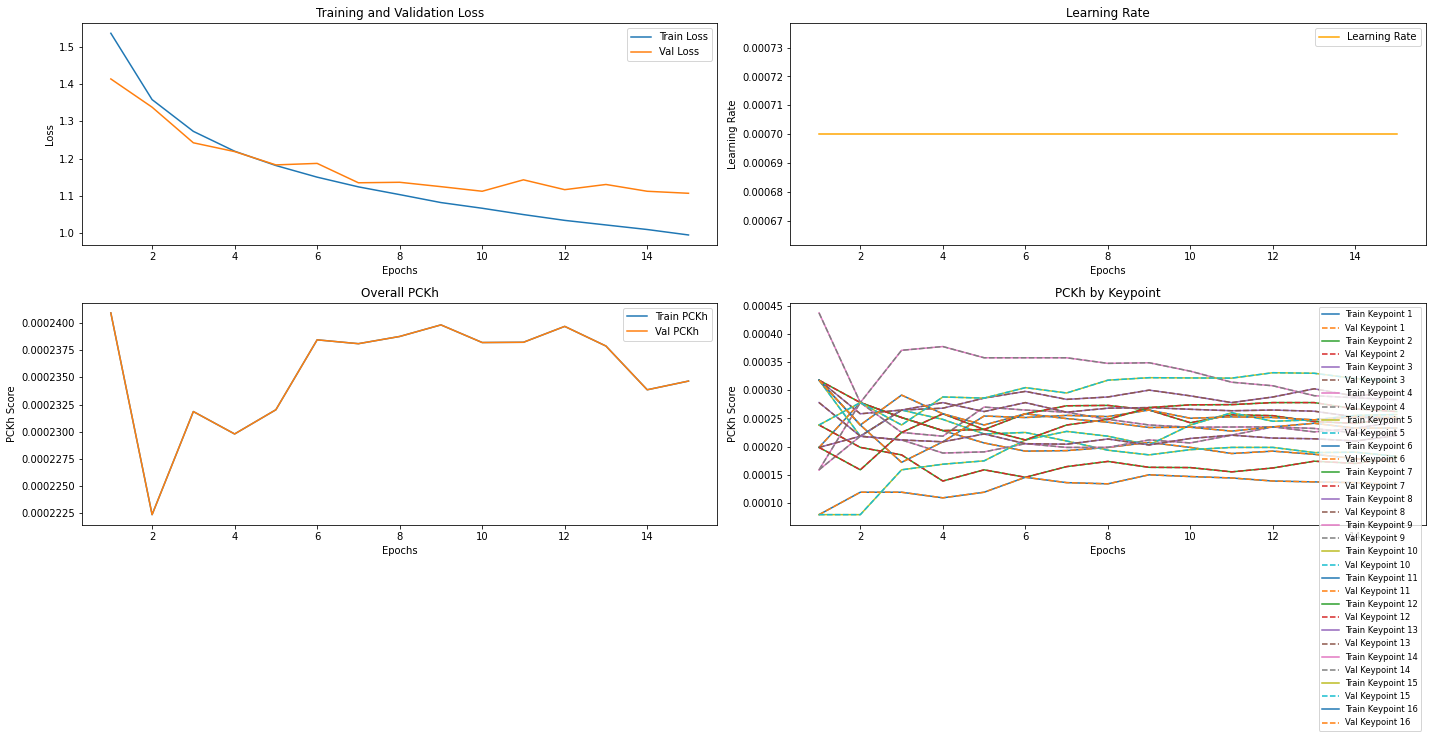

In [38]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = EPOCHS
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

In [39]:
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

In [24]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


In [25]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [26]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


In [27]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


In [28]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


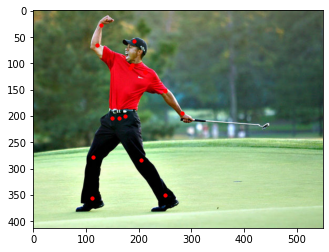

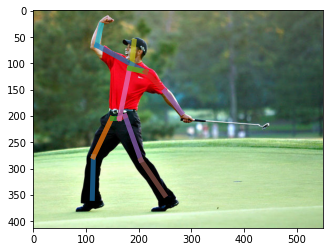

In [40]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### STEP 1 : simplebaseline 모델 완성하기
---
simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.

In [29]:
def _make_deconv_layer(num_deconv_layers):
    """
    Deconvolution Layer를 생성합니다.
    Args:
        num_deconv_layers: Deconvolution 레이어의 개수
    Returns:
        Sequential model containing the deconv layers
    """
    seq_model = tf.keras.models.Sequential()

    # [[YOUR CODE]]
    for i in range(num_deconv_layers):
        # 디컨볼루션 레이어 추가
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        
        # Batch Normalization
        seq_model.add(tf.keras.layers.BatchNormalization())
        
        # ReLU 활성화 함수
        seq_model.add(tf.keras.layers.ReLU())
    
    return seq_model

In [30]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')

epochs = EPOCHS
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [31]:
upconv = _make_deconv_layer(3)

# [[YOUR CODE]]
final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')

In [32]:
def Simplebaseline(input_shape=(256, 256, 3)):
    # resnet을 불러올 때 함수 내부에서 불러오면 정상적으로 학습
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    inputs = tf.keras.Input(shape=input_shape)
    
    # ResNet50을 통과
    x = resnet(inputs)
    
    # 디컨볼루션 레이어를 통과
    x = upconv(x)
    
    # 최종 컨볼루션 레이어를 통과하여 히트맵 생성
    out = final_layer(x)
    
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [33]:
# spb_model = Simplebaseline(IMAGE_SHAPE)
# spb_model.summary()

### STEP 2 : simplebaseline 모델로 변경하여 훈련하기
---
StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.

### 아래와 같은 문제가 발생하여 디버깅 
- 발생 에러
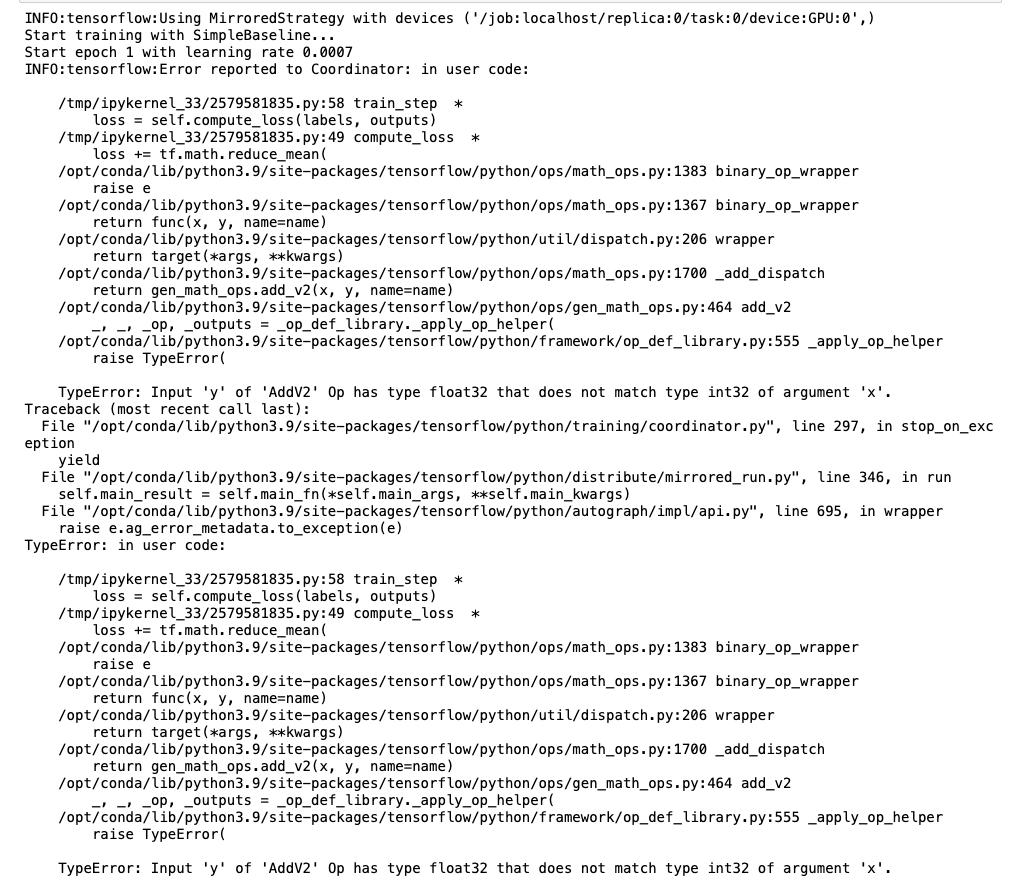

- 디버깅 과정  

1. SimpleBaseline 모델 출력 확인
    ```python
    sample_input = tf.random.normal((1, 256, 256, 3))
    sample_output = spb_model(sample_input)
    print(f"Model output dtype: {sample_output.dtype}, shape: {sample_output.shape}")
    ```
    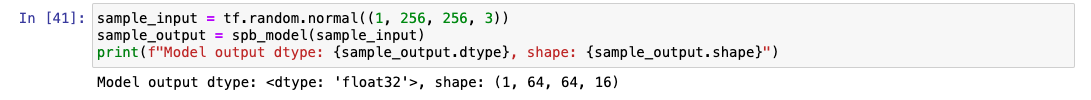
    - 데이터 타입: float32 ✅ 정상
    - 출력 형태: (1, 64, 64, 16) ✅ 정상  


2. 데이터셋 확인 결과
    ```python
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
            train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    for images, labels in train_dataset.take(1):
        print(f"Labels dtype: {labels.dtype}, shape: {labels.shape}")
        print(f"Images dtype: {images.dtype}, shape: {images.shape}")
    ```
    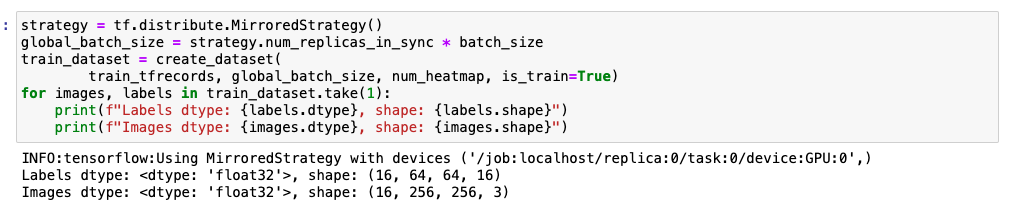
    - labels dtype: float32 → ✅ 정상
    - labels shape: (16, 64, 64, 16) → ✅ outputs와 동일
    - images dtype: float32 → ✅ 정상
    - images shape: (16, 256, 256, 3) → ✅ 정상  


3. compute_loss 의 SimpleBaseline에 맞게 outputs가 단일 텐서일 경우도 처리하도록 코드를 보완
    - Hourglass 모델 출력: 여러 단계에서 히트맵이 출력됨 → outputs는 리스트 형태로 여러 히트맵을 포함
    - SimpleBaseline 모델 출력: 마지막 히트맵만 출력됨 → outputs는 단일 텐서

### 아래 에러 발생함
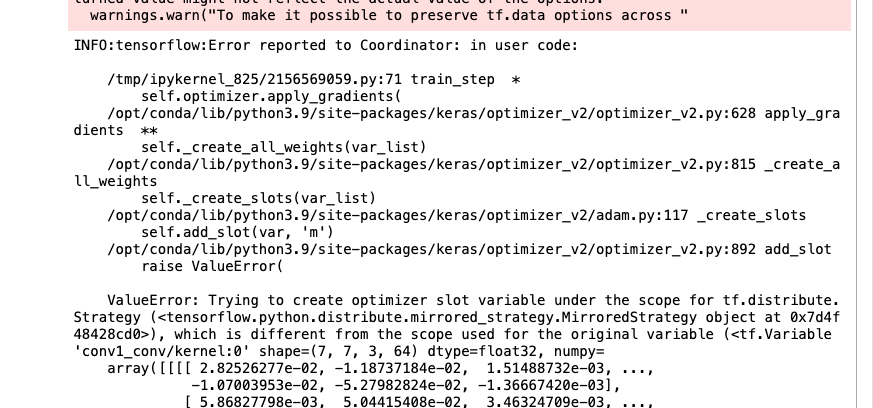
- resnet을 불러올 때 함수 내부에서 불러오도록 수정
- 커널을 완전히 초기화 하고 다시 접속 함

In [34]:
def spb_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    
    # 데이터셋 준비
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_CUSTOM_PATH):
        os.makedirs(MODEL_CUSTOM_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        # 변경된 부분: StackedHourglass 대신 SimpleBaseline 사용
        spb_model = Simplebaseline(IMAGE_SHAPE)

        trainer = Trainer(
            spb_model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate
        )

        print('Start training with SimpleBaseline...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 0.635345936 epoch total loss 0.635345936
Trained batch 2 batch loss 0.585629761 epoch total loss 0.610487819
Trained batch 3 batch loss 0.51079756 epoch total loss 0.577257693
Trained batch 4 batch loss 0.458871931 epoch total loss 0.547661245
Trained batch 5 batch loss 0.435010433 epoch total loss 0.525131106
Trained batch 6 batch loss 0.435810447 epoch total loss 0.51024431
Trained batch 7 batch loss 0.435523748 epoch total loss 0.499569923
Trained batch 8 batch loss 0.443465 epoch total loss 0.49255681
Trained batch 9 batch loss 0.43779 epoch total loss 0.486471593
Trained batch 10 batch loss 0.444201618 epoch total loss 0.482244581
Trained batch 11 batch loss 0.439473867 epoch total loss 0.478356361
Trained batch 12 batch loss 0.443622142 epoch total loss 0.475461841
Trained batch 13 batch loss 0.4261702 epoch total loss 0.471670181
Trained batch 14 batch loss 0.409595758 epoch total loss 0.46723631
Trained batch 15 batch lo

Trained batch 120 batch loss 0.356356889 epoch total loss 0.394796193
Trained batch 121 batch loss 0.354694277 epoch total loss 0.394464761
Trained batch 122 batch loss 0.366942048 epoch total loss 0.394239187
Trained batch 123 batch loss 0.393506736 epoch total loss 0.394233197
Trained batch 124 batch loss 0.381677181 epoch total loss 0.394131929
Trained batch 125 batch loss 0.387480319 epoch total loss 0.394078732
Trained batch 126 batch loss 0.381358802 epoch total loss 0.393977791
Trained batch 127 batch loss 0.377490819 epoch total loss 0.393847972
Trained batch 128 batch loss 0.382427543 epoch total loss 0.393758744
Trained batch 129 batch loss 0.380849421 epoch total loss 0.393658668
Trained batch 130 batch loss 0.373635322 epoch total loss 0.39350462
Trained batch 131 batch loss 0.372222334 epoch total loss 0.393342167
Trained batch 132 batch loss 0.368946433 epoch total loss 0.393157363
Trained batch 133 batch loss 0.34810105 epoch total loss 0.3928186
Trained batch 134 batch 

Trained batch 238 batch loss 0.396077394 epoch total loss 0.381143868
Trained batch 239 batch loss 0.324882925 epoch total loss 0.380908459
Trained batch 240 batch loss 0.303673118 epoch total loss 0.380586654
Trained batch 241 batch loss 0.332595557 epoch total loss 0.380387515
Trained batch 242 batch loss 0.346149743 epoch total loss 0.380246073
Trained batch 243 batch loss 0.340199023 epoch total loss 0.380081266
Trained batch 244 batch loss 0.367269129 epoch total loss 0.380028784
Trained batch 245 batch loss 0.342337608 epoch total loss 0.379874945
Trained batch 246 batch loss 0.35998112 epoch total loss 0.379794061
Trained batch 247 batch loss 0.36722821 epoch total loss 0.379743159
Trained batch 248 batch loss 0.370008081 epoch total loss 0.379703909
Trained batch 249 batch loss 0.375883907 epoch total loss 0.379688591
Trained batch 250 batch loss 0.331699789 epoch total loss 0.379496634
Trained batch 251 batch loss 0.337006867 epoch total loss 0.379327357
Trained batch 252 batc

Trained batch 356 batch loss 0.338829964 epoch total loss 0.372101426
Trained batch 357 batch loss 0.381885588 epoch total loss 0.372128814
Trained batch 358 batch loss 0.352087855 epoch total loss 0.372072816
Trained batch 359 batch loss 0.321962059 epoch total loss 0.371933252
Trained batch 360 batch loss 0.340693504 epoch total loss 0.371846467
Trained batch 361 batch loss 0.361205429 epoch total loss 0.371817
Trained batch 362 batch loss 0.355666101 epoch total loss 0.371772379
Trained batch 363 batch loss 0.351037621 epoch total loss 0.371715277
Trained batch 364 batch loss 0.368589222 epoch total loss 0.371706694
Trained batch 365 batch loss 0.334624499 epoch total loss 0.371605098
Trained batch 366 batch loss 0.330652863 epoch total loss 0.37149322
Trained batch 367 batch loss 0.335119903 epoch total loss 0.371394098
Trained batch 368 batch loss 0.344458103 epoch total loss 0.371320903
Trained batch 369 batch loss 0.30673787 epoch total loss 0.371145844
Trained batch 370 batch l

Trained batch 474 batch loss 0.375496745 epoch total loss 0.365973979
Trained batch 475 batch loss 0.389413238 epoch total loss 0.366023332
Trained batch 476 batch loss 0.344111264 epoch total loss 0.365977317
Trained batch 477 batch loss 0.322429806 epoch total loss 0.365886033
Trained batch 478 batch loss 0.329185426 epoch total loss 0.365809232
Trained batch 479 batch loss 0.348264903 epoch total loss 0.365772605
Trained batch 480 batch loss 0.350888461 epoch total loss 0.365741611
Trained batch 481 batch loss 0.337890208 epoch total loss 0.365683705
Trained batch 482 batch loss 0.346067339 epoch total loss 0.365643
Trained batch 483 batch loss 0.349791199 epoch total loss 0.365610182
Trained batch 484 batch loss 0.332598805 epoch total loss 0.365541965
Trained batch 485 batch loss 0.316467285 epoch total loss 0.365440786
Trained batch 486 batch loss 0.360273451 epoch total loss 0.365430176
Trained batch 487 batch loss 0.353212 epoch total loss 0.365405083
Trained batch 488 batch lo

Trained batch 592 batch loss 0.352710962 epoch total loss 0.360124499
Trained batch 593 batch loss 0.350715727 epoch total loss 0.360108644
Trained batch 594 batch loss 0.329598904 epoch total loss 0.360057294
Trained batch 595 batch loss 0.337976366 epoch total loss 0.36002019
Trained batch 596 batch loss 0.323520452 epoch total loss 0.359958947
Trained batch 597 batch loss 0.345753044 epoch total loss 0.359935164
Trained batch 598 batch loss 0.345336288 epoch total loss 0.359910756
Trained batch 599 batch loss 0.306737542 epoch total loss 0.359821975
Trained batch 600 batch loss 0.335092902 epoch total loss 0.359780759
Trained batch 601 batch loss 0.345984638 epoch total loss 0.359757781
Trained batch 602 batch loss 0.331877023 epoch total loss 0.359711468
Trained batch 603 batch loss 0.359842479 epoch total loss 0.359711707
Trained batch 604 batch loss 0.342039466 epoch total loss 0.359682441
Trained batch 605 batch loss 0.360657394 epoch total loss 0.35968405
Trained batch 606 batc

Trained batch 710 batch loss 0.320543945 epoch total loss 0.35493663
Trained batch 711 batch loss 0.320732206 epoch total loss 0.354888529
Trained batch 712 batch loss 0.322143316 epoch total loss 0.354842544
Trained batch 713 batch loss 0.303280383 epoch total loss 0.354770213
Trained batch 714 batch loss 0.336608708 epoch total loss 0.354744792
Trained batch 715 batch loss 0.329585522 epoch total loss 0.354709595
Trained batch 716 batch loss 0.344457507 epoch total loss 0.35469529
Trained batch 717 batch loss 0.317906886 epoch total loss 0.354643971
Trained batch 718 batch loss 0.325358 epoch total loss 0.354603171
Trained batch 719 batch loss 0.326239526 epoch total loss 0.354563713
Trained batch 720 batch loss 0.305190146 epoch total loss 0.354495168
Trained batch 721 batch loss 0.334480077 epoch total loss 0.354467392
Trained batch 722 batch loss 0.317840844 epoch total loss 0.354416668
Trained batch 723 batch loss 0.314716935 epoch total loss 0.354361773
Trained batch 724 batch l

Trained batch 828 batch loss 0.340365946 epoch total loss 0.351302266
Trained batch 829 batch loss 0.350044906 epoch total loss 0.351300716
Trained batch 830 batch loss 0.371440381 epoch total loss 0.351324975
Trained batch 831 batch loss 0.336081088 epoch total loss 0.351306647
Trained batch 832 batch loss 0.32573989 epoch total loss 0.351275921
Trained batch 833 batch loss 0.355893433 epoch total loss 0.351281464
Trained batch 834 batch loss 0.356133103 epoch total loss 0.351287305
Trained batch 835 batch loss 0.378906578 epoch total loss 0.351320356
Trained batch 836 batch loss 0.340363 epoch total loss 0.351307273
Trained batch 837 batch loss 0.330388188 epoch total loss 0.351282269
Trained batch 838 batch loss 0.341397434 epoch total loss 0.351270467
Trained batch 839 batch loss 0.332616359 epoch total loss 0.351248235
Trained batch 840 batch loss 0.339116901 epoch total loss 0.35123378
Trained batch 841 batch loss 0.373599619 epoch total loss 0.351260364
Trained batch 842 batch l

Trained batch 946 batch loss 0.330174506 epoch total loss 0.349144429
Trained batch 947 batch loss 0.306783497 epoch total loss 0.349099696
Trained batch 948 batch loss 0.318755209 epoch total loss 0.349067688
Trained batch 949 batch loss 0.304536939 epoch total loss 0.349020749
Trained batch 950 batch loss 0.309125245 epoch total loss 0.348978758
Trained batch 951 batch loss 0.309066921 epoch total loss 0.348936796
Trained batch 952 batch loss 0.303988397 epoch total loss 0.348889589
Trained batch 953 batch loss 0.308283806 epoch total loss 0.348846972
Trained batch 954 batch loss 0.332039565 epoch total loss 0.348829359
Trained batch 955 batch loss 0.31101796 epoch total loss 0.348789752
Trained batch 956 batch loss 0.338019311 epoch total loss 0.348778486
Trained batch 957 batch loss 0.339913964 epoch total loss 0.348769188
Trained batch 958 batch loss 0.342926294 epoch total loss 0.348763108
Trained batch 959 batch loss 0.34289521 epoch total loss 0.348756969
Trained batch 960 batc

Trained batch 1063 batch loss 0.320528626 epoch total loss 0.346183956
Trained batch 1064 batch loss 0.312006086 epoch total loss 0.346151829
Trained batch 1065 batch loss 0.297356397 epoch total loss 0.346106023
Trained batch 1066 batch loss 0.314828694 epoch total loss 0.346076667
Trained batch 1067 batch loss 0.331040949 epoch total loss 0.346062601
Trained batch 1068 batch loss 0.333157808 epoch total loss 0.346050501
Trained batch 1069 batch loss 0.347321361 epoch total loss 0.346051693
Trained batch 1070 batch loss 0.341824353 epoch total loss 0.346047759
Trained batch 1071 batch loss 0.337688446 epoch total loss 0.346039921
Trained batch 1072 batch loss 0.335269928 epoch total loss 0.346029878
Trained batch 1073 batch loss 0.328591436 epoch total loss 0.346013606
Trained batch 1074 batch loss 0.336565942 epoch total loss 0.346004844
Trained batch 1075 batch loss 0.320537806 epoch total loss 0.345981121
Trained batch 1076 batch loss 0.303843826 epoch total loss 0.345941961
Traine

Trained batch 1179 batch loss 0.341039926 epoch total loss 0.344081104
Trained batch 1180 batch loss 0.350284874 epoch total loss 0.344086379
Trained batch 1181 batch loss 0.369211942 epoch total loss 0.344107628
Trained batch 1182 batch loss 0.295468777 epoch total loss 0.344066471
Trained batch 1183 batch loss 0.340162873 epoch total loss 0.344063163
Trained batch 1184 batch loss 0.320276886 epoch total loss 0.344043076
Trained batch 1185 batch loss 0.320499241 epoch total loss 0.344023228
Trained batch 1186 batch loss 0.331795961 epoch total loss 0.344012886
Trained batch 1187 batch loss 0.338626355 epoch total loss 0.344008356
Trained batch 1188 batch loss 0.312776029 epoch total loss 0.343982071
Trained batch 1189 batch loss 0.30037567 epoch total loss 0.343945414
Trained batch 1190 batch loss 0.332754523 epoch total loss 0.343936
Trained batch 1191 batch loss 0.346479267 epoch total loss 0.343938142
Trained batch 1192 batch loss 0.324300706 epoch total loss 0.343921661
Trained ba

Trained batch 1295 batch loss 0.307168335 epoch total loss 0.341869414
Trained batch 1296 batch loss 0.294576257 epoch total loss 0.341832936
Trained batch 1297 batch loss 0.324719399 epoch total loss 0.341819733
Trained batch 1298 batch loss 0.315553755 epoch total loss 0.341799498
Trained batch 1299 batch loss 0.303928405 epoch total loss 0.341770321
Trained batch 1300 batch loss 0.344122857 epoch total loss 0.341772139
Trained batch 1301 batch loss 0.325187176 epoch total loss 0.341759384
Trained batch 1302 batch loss 0.327210188 epoch total loss 0.341748208
Trained batch 1303 batch loss 0.327987432 epoch total loss 0.341737658
Trained batch 1304 batch loss 0.31980148 epoch total loss 0.341720819
Trained batch 1305 batch loss 0.329282671 epoch total loss 0.341711283
Trained batch 1306 batch loss 0.32052514 epoch total loss 0.34169507
Trained batch 1307 batch loss 0.340188771 epoch total loss 0.341693908
Trained batch 1308 batch loss 0.312778741 epoch total loss 0.341671795
Trained b

Validated batch 37 batch loss 0.35596931
Validated batch 38 batch loss 0.351813793
Validated batch 39 batch loss 0.325931191
Validated batch 40 batch loss 0.381183535
Validated batch 41 batch loss 0.29041791
Validated batch 42 batch loss 0.344897747
Validated batch 43 batch loss 0.286158413
Validated batch 44 batch loss 0.319802672
Validated batch 45 batch loss 0.35372746
Validated batch 46 batch loss 0.307864368
Validated batch 47 batch loss 0.341938227
Validated batch 48 batch loss 0.338011265
Validated batch 49 batch loss 0.323406458
Validated batch 50 batch loss 0.321590632
Validated batch 51 batch loss 0.335502774
Validated batch 52 batch loss 0.384859651
Validated batch 53 batch loss 0.308618844
Validated batch 54 batch loss 0.343525708
Validated batch 55 batch loss 0.33756882
Validated batch 56 batch loss 0.330888033
Validated batch 57 batch loss 0.324753314
Validated batch 58 batch loss 0.298699737
Validated batch 59 batch loss 0.364767492
Validated batch 60 batch loss 0.309757

Trained batch 20 batch loss 0.328364491 epoch total loss 0.300908893
Trained batch 21 batch loss 0.304193854 epoch total loss 0.301065326
Trained batch 22 batch loss 0.340797544 epoch total loss 0.302871346
Trained batch 23 batch loss 0.298870087 epoch total loss 0.302697361
Trained batch 24 batch loss 0.3131347 epoch total loss 0.303132266
Trained batch 25 batch loss 0.304911852 epoch total loss 0.303203434
Trained batch 26 batch loss 0.273825943 epoch total loss 0.302073538
Trained batch 27 batch loss 0.293063164 epoch total loss 0.301739812
Trained batch 28 batch loss 0.28378436 epoch total loss 0.301098526
Trained batch 29 batch loss 0.285359114 epoch total loss 0.300555795
Trained batch 30 batch loss 0.289832473 epoch total loss 0.300198346
Trained batch 31 batch loss 0.29183951 epoch total loss 0.299928695
Trained batch 32 batch loss 0.332689494 epoch total loss 0.300952464
Trained batch 33 batch loss 0.262586117 epoch total loss 0.299789846
Trained batch 34 batch loss 0.30959418

Trained batch 139 batch loss 0.30741027 epoch total loss 0.312676966
Trained batch 140 batch loss 0.316849828 epoch total loss 0.312706769
Trained batch 141 batch loss 0.315741807 epoch total loss 0.312728286
Trained batch 142 batch loss 0.297577024 epoch total loss 0.312621593
Trained batch 143 batch loss 0.329398334 epoch total loss 0.312738925
Trained batch 144 batch loss 0.299485028 epoch total loss 0.312646866
Trained batch 145 batch loss 0.280423135 epoch total loss 0.31242463
Trained batch 146 batch loss 0.263341248 epoch total loss 0.31208843
Trained batch 147 batch loss 0.281451702 epoch total loss 0.311880022
Trained batch 148 batch loss 0.270968676 epoch total loss 0.311603606
Trained batch 149 batch loss 0.281385481 epoch total loss 0.311400801
Trained batch 150 batch loss 0.264383942 epoch total loss 0.31108737
Trained batch 151 batch loss 0.269153804 epoch total loss 0.310809672
Trained batch 152 batch loss 0.28875947 epoch total loss 0.310664594
Trained batch 153 batch l

Trained batch 257 batch loss 0.351920128 epoch total loss 0.31471163
Trained batch 258 batch loss 0.366090715 epoch total loss 0.314910769
Trained batch 259 batch loss 0.296102941 epoch total loss 0.314838171
Trained batch 260 batch loss 0.292149574 epoch total loss 0.31475091
Trained batch 261 batch loss 0.328497082 epoch total loss 0.314803571
Trained batch 262 batch loss 0.341492862 epoch total loss 0.314905435
Trained batch 263 batch loss 0.342250586 epoch total loss 0.315009415
Trained batch 264 batch loss 0.295093864 epoch total loss 0.314934
Trained batch 265 batch loss 0.310018152 epoch total loss 0.314915448
Trained batch 266 batch loss 0.318185687 epoch total loss 0.314927727
Trained batch 267 batch loss 0.307408273 epoch total loss 0.314899564
Trained batch 268 batch loss 0.325369477 epoch total loss 0.314938635
Trained batch 269 batch loss 0.297558278 epoch total loss 0.314874053
Trained batch 270 batch loss 0.341530532 epoch total loss 0.314972758
Trained batch 271 batch l

Trained batch 375 batch loss 0.323898435 epoch total loss 0.313655585
Trained batch 376 batch loss 0.295123249 epoch total loss 0.313606292
Trained batch 377 batch loss 0.293908238 epoch total loss 0.313554019
Trained batch 378 batch loss 0.274471372 epoch total loss 0.313450634
Trained batch 379 batch loss 0.271249324 epoch total loss 0.313339293
Trained batch 380 batch loss 0.277876 epoch total loss 0.313245982
Trained batch 381 batch loss 0.290399671 epoch total loss 0.313186
Trained batch 382 batch loss 0.250944644 epoch total loss 0.313023061
Trained batch 383 batch loss 0.242840156 epoch total loss 0.312839836
Trained batch 384 batch loss 0.237579405 epoch total loss 0.312643856
Trained batch 385 batch loss 0.261417121 epoch total loss 0.312510788
Trained batch 386 batch loss 0.292047381 epoch total loss 0.31245777
Trained batch 387 batch loss 0.319131553 epoch total loss 0.312475
Trained batch 388 batch loss 0.309317052 epoch total loss 0.31246686
Trained batch 389 batch loss 0.

Trained batch 493 batch loss 0.329481184 epoch total loss 0.311674774
Trained batch 494 batch loss 0.322604209 epoch total loss 0.311696917
Trained batch 495 batch loss 0.303672493 epoch total loss 0.311680675
Trained batch 496 batch loss 0.296340883 epoch total loss 0.31164974
Trained batch 497 batch loss 0.32190764 epoch total loss 0.311670393
Trained batch 498 batch loss 0.318666339 epoch total loss 0.311684459
Trained batch 499 batch loss 0.309196055 epoch total loss 0.311679453
Trained batch 500 batch loss 0.2929658 epoch total loss 0.311642021
Trained batch 501 batch loss 0.305877894 epoch total loss 0.311630517
Trained batch 502 batch loss 0.324255466 epoch total loss 0.31165567
Trained batch 503 batch loss 0.317078173 epoch total loss 0.311666429
Trained batch 504 batch loss 0.318332911 epoch total loss 0.311679661
Trained batch 505 batch loss 0.308827072 epoch total loss 0.311674
Trained batch 506 batch loss 0.302490503 epoch total loss 0.311655849
Trained batch 507 batch loss

Trained batch 611 batch loss 0.267878294 epoch total loss 0.310981393
Trained batch 612 batch loss 0.269484073 epoch total loss 0.310913593
Trained batch 613 batch loss 0.299445212 epoch total loss 0.310894877
Trained batch 614 batch loss 0.305148363 epoch total loss 0.310885489
Trained batch 615 batch loss 0.32208848 epoch total loss 0.310903698
Trained batch 616 batch loss 0.321015954 epoch total loss 0.310920119
Trained batch 617 batch loss 0.292443961 epoch total loss 0.310890198
Trained batch 618 batch loss 0.295998096 epoch total loss 0.310866088
Trained batch 619 batch loss 0.325386763 epoch total loss 0.310889572
Trained batch 620 batch loss 0.331461132 epoch total loss 0.310922772
Trained batch 621 batch loss 0.312526345 epoch total loss 0.310925335
Trained batch 622 batch loss 0.322085977 epoch total loss 0.310943276
Trained batch 623 batch loss 0.300804108 epoch total loss 0.310927
Trained batch 624 batch loss 0.304576397 epoch total loss 0.310916841
Trained batch 625 batch 

Trained batch 729 batch loss 0.284443408 epoch total loss 0.311111838
Trained batch 730 batch loss 0.265201092 epoch total loss 0.311048925
Trained batch 731 batch loss 0.286143839 epoch total loss 0.311014861
Trained batch 732 batch loss 0.317889094 epoch total loss 0.311024249
Trained batch 733 batch loss 0.300713599 epoch total loss 0.311010182
Trained batch 734 batch loss 0.288214982 epoch total loss 0.310979128
Trained batch 735 batch loss 0.320565492 epoch total loss 0.310992181
Trained batch 736 batch loss 0.302139789 epoch total loss 0.310980141
Trained batch 737 batch loss 0.326268315 epoch total loss 0.311000884
Trained batch 738 batch loss 0.32487604 epoch total loss 0.311019689
Trained batch 739 batch loss 0.31476891 epoch total loss 0.311024785
Trained batch 740 batch loss 0.295871615 epoch total loss 0.311004281
Trained batch 741 batch loss 0.316295236 epoch total loss 0.311011434
Trained batch 742 batch loss 0.336052895 epoch total loss 0.3110452
Trained batch 743 batch 

Trained batch 847 batch loss 0.297084779 epoch total loss 0.309973121
Trained batch 848 batch loss 0.316851765 epoch total loss 0.309981257
Trained batch 849 batch loss 0.307876706 epoch total loss 0.309978783
Trained batch 850 batch loss 0.298585832 epoch total loss 0.309965402
Trained batch 851 batch loss 0.289538622 epoch total loss 0.309941411
Trained batch 852 batch loss 0.29740572 epoch total loss 0.309926659
Trained batch 853 batch loss 0.29304117 epoch total loss 0.30990687
Trained batch 854 batch loss 0.278903812 epoch total loss 0.309870571
Trained batch 855 batch loss 0.275937229 epoch total loss 0.309830874
Trained batch 856 batch loss 0.281199336 epoch total loss 0.309797406
Trained batch 857 batch loss 0.279033065 epoch total loss 0.309761494
Trained batch 858 batch loss 0.279851615 epoch total loss 0.309726626
Trained batch 859 batch loss 0.29233557 epoch total loss 0.30970639
Trained batch 860 batch loss 0.283943295 epoch total loss 0.309676409
Trained batch 861 batch l

Trained batch 965 batch loss 0.301955432 epoch total loss 0.31007877
Trained batch 966 batch loss 0.319488168 epoch total loss 0.310088515
Trained batch 967 batch loss 0.285898775 epoch total loss 0.310063481
Trained batch 968 batch loss 0.30323571 epoch total loss 0.310056418
Trained batch 969 batch loss 0.281026453 epoch total loss 0.310026467
Trained batch 970 batch loss 0.345767766 epoch total loss 0.310063303
Trained batch 971 batch loss 0.334266901 epoch total loss 0.310088217
Trained batch 972 batch loss 0.312675923 epoch total loss 0.310090899
Trained batch 973 batch loss 0.26756084 epoch total loss 0.310047179
Trained batch 974 batch loss 0.275868714 epoch total loss 0.310012102
Trained batch 975 batch loss 0.282811582 epoch total loss 0.309984207
Trained batch 976 batch loss 0.325850457 epoch total loss 0.310000449
Trained batch 977 batch loss 0.302913755 epoch total loss 0.309993178
Trained batch 978 batch loss 0.286240101 epoch total loss 0.309968919
Trained batch 979 batch

Trained batch 1082 batch loss 0.306308329 epoch total loss 0.309548348
Trained batch 1083 batch loss 0.322199196 epoch total loss 0.309560031
Trained batch 1084 batch loss 0.316967934 epoch total loss 0.309566855
Trained batch 1085 batch loss 0.286730111 epoch total loss 0.309545815
Trained batch 1086 batch loss 0.278346509 epoch total loss 0.309517086
Trained batch 1087 batch loss 0.297646403 epoch total loss 0.309506148
Trained batch 1088 batch loss 0.266195476 epoch total loss 0.309466362
Trained batch 1089 batch loss 0.313718557 epoch total loss 0.309470266
Trained batch 1090 batch loss 0.314472646 epoch total loss 0.309474856
Trained batch 1091 batch loss 0.311373264 epoch total loss 0.309476614
Trained batch 1092 batch loss 0.306308329 epoch total loss 0.309473693
Trained batch 1093 batch loss 0.324403197 epoch total loss 0.309487373
Trained batch 1094 batch loss 0.34848395 epoch total loss 0.309523016
Trained batch 1095 batch loss 0.323163211 epoch total loss 0.309535444
Trained

Trained batch 1198 batch loss 0.309788525 epoch total loss 0.30902034
Trained batch 1199 batch loss 0.326789409 epoch total loss 0.309035152
Trained batch 1200 batch loss 0.321393371 epoch total loss 0.309045434
Trained batch 1201 batch loss 0.330108881 epoch total loss 0.309063
Trained batch 1202 batch loss 0.321693271 epoch total loss 0.309073478
Trained batch 1203 batch loss 0.320280969 epoch total loss 0.309082806
Trained batch 1204 batch loss 0.322074026 epoch total loss 0.309093595
Trained batch 1205 batch loss 0.314075708 epoch total loss 0.309097737
Trained batch 1206 batch loss 0.326933563 epoch total loss 0.309112519
Trained batch 1207 batch loss 0.341131568 epoch total loss 0.309139043
Trained batch 1208 batch loss 0.28542161 epoch total loss 0.309119433
Trained batch 1209 batch loss 0.295921117 epoch total loss 0.309108496
Trained batch 1210 batch loss 0.265871972 epoch total loss 0.309072763
Trained batch 1211 batch loss 0.263113946 epoch total loss 0.309034824
Trained bat

Trained batch 1314 batch loss 0.269554794 epoch total loss 0.308106512
Trained batch 1315 batch loss 0.328438401 epoch total loss 0.308121979
Trained batch 1316 batch loss 0.312879205 epoch total loss 0.308125585
Trained batch 1317 batch loss 0.304697394 epoch total loss 0.308122963
Trained batch 1318 batch loss 0.312502086 epoch total loss 0.308126271
Trained batch 1319 batch loss 0.299305558 epoch total loss 0.308119595
Trained batch 1320 batch loss 0.285058 epoch total loss 0.308102131
Trained batch 1321 batch loss 0.295395285 epoch total loss 0.308092535
Trained batch 1322 batch loss 0.328974694 epoch total loss 0.30810833
Trained batch 1323 batch loss 0.289043 epoch total loss 0.308093905
Trained batch 1324 batch loss 0.293426424 epoch total loss 0.308082849
Trained batch 1325 batch loss 0.324851066 epoch total loss 0.308095485
Trained batch 1326 batch loss 0.33578378 epoch total loss 0.308116376
Trained batch 1327 batch loss 0.282787293 epoch total loss 0.308097273
Trained batch 

Validated batch 70 batch loss 0.294827521
Validated batch 71 batch loss 0.31106326
Validated batch 72 batch loss 0.283222318
Validated batch 73 batch loss 0.298416197
Validated batch 74 batch loss 0.313561171
Validated batch 75 batch loss 0.295999497
Validated batch 76 batch loss 0.305276066
Validated batch 77 batch loss 0.290894
Validated batch 78 batch loss 0.295416504
Validated batch 79 batch loss 0.324974895
Validated batch 80 batch loss 0.280513883
Validated batch 81 batch loss 0.271202
Validated batch 82 batch loss 0.302848458
Validated batch 83 batch loss 0.324892133
Validated batch 84 batch loss 0.33340773
Validated batch 85 batch loss 0.341775298
Validated batch 86 batch loss 0.292824119
Validated batch 87 batch loss 0.335795105
Validated batch 88 batch loss 0.305464089
Validated batch 89 batch loss 0.326723516
Validated batch 90 batch loss 0.311289877
Validated batch 91 batch loss 0.243159622
Validated batch 92 batch loss 0.316159755
Validated batch 93 batch loss 0.296035409


Trained batch 40 batch loss 0.321299195 epoch total loss 0.295063704
Trained batch 41 batch loss 0.284812629 epoch total loss 0.294813693
Trained batch 42 batch loss 0.305468142 epoch total loss 0.29506737
Trained batch 43 batch loss 0.271481812 epoch total loss 0.294518858
Trained batch 44 batch loss 0.302600384 epoch total loss 0.29470253
Trained batch 45 batch loss 0.320451 epoch total loss 0.295274705
Trained batch 46 batch loss 0.289374471 epoch total loss 0.295146435
Trained batch 47 batch loss 0.260211855 epoch total loss 0.294403166
Trained batch 48 batch loss 0.264632493 epoch total loss 0.29378292
Trained batch 49 batch loss 0.259440809 epoch total loss 0.293082058
Trained batch 50 batch loss 0.259498566 epoch total loss 0.292410403
Trained batch 51 batch loss 0.294741273 epoch total loss 0.29245609
Trained batch 52 batch loss 0.313963413 epoch total loss 0.292869717
Trained batch 53 batch loss 0.263600171 epoch total loss 0.29231745
Trained batch 54 batch loss 0.304593027 ep

Trained batch 159 batch loss 0.304885626 epoch total loss 0.29506129
Trained batch 160 batch loss 0.31800282 epoch total loss 0.295204699
Trained batch 161 batch loss 0.34914282 epoch total loss 0.295539707
Trained batch 162 batch loss 0.329842806 epoch total loss 0.295751452
Trained batch 163 batch loss 0.310100853 epoch total loss 0.295839489
Trained batch 164 batch loss 0.331738323 epoch total loss 0.296058387
Trained batch 165 batch loss 0.285486847 epoch total loss 0.295994312
Trained batch 166 batch loss 0.266458362 epoch total loss 0.295816362
Trained batch 167 batch loss 0.279027104 epoch total loss 0.295715839
Trained batch 168 batch loss 0.296753287 epoch total loss 0.295722
Trained batch 169 batch loss 0.301674157 epoch total loss 0.295757234
Trained batch 170 batch loss 0.298338741 epoch total loss 0.295772403
Trained batch 171 batch loss 0.290853322 epoch total loss 0.295743644
Trained batch 172 batch loss 0.30680865 epoch total loss 0.295807958
Trained batch 173 batch los

Trained batch 277 batch loss 0.253373265 epoch total loss 0.293354034
Trained batch 278 batch loss 0.277074873 epoch total loss 0.293295473
Trained batch 279 batch loss 0.309739172 epoch total loss 0.293354392
Trained batch 280 batch loss 0.250876576 epoch total loss 0.293202698
Trained batch 281 batch loss 0.246784464 epoch total loss 0.293037534
Trained batch 282 batch loss 0.274038374 epoch total loss 0.292970151
Trained batch 283 batch loss 0.271074474 epoch total loss 0.292892784
Trained batch 284 batch loss 0.329767287 epoch total loss 0.293022603
Trained batch 285 batch loss 0.366526425 epoch total loss 0.293280512
Trained batch 286 batch loss 0.352155715 epoch total loss 0.293486387
Trained batch 287 batch loss 0.327397585 epoch total loss 0.293604553
Trained batch 288 batch loss 0.317154139 epoch total loss 0.293686301
Trained batch 289 batch loss 0.320538342 epoch total loss 0.293779224
Trained batch 290 batch loss 0.279083133 epoch total loss 0.29372856
Trained batch 291 bat

Trained batch 395 batch loss 0.287231445 epoch total loss 0.294806361
Trained batch 396 batch loss 0.260253251 epoch total loss 0.2947191
Trained batch 397 batch loss 0.248961329 epoch total loss 0.294603854
Trained batch 398 batch loss 0.26983884 epoch total loss 0.294541627
Trained batch 399 batch loss 0.293671846 epoch total loss 0.294539422
Trained batch 400 batch loss 0.273913175 epoch total loss 0.294487864
Trained batch 401 batch loss 0.298277 epoch total loss 0.294497311
Trained batch 402 batch loss 0.258352876 epoch total loss 0.294407398
Trained batch 403 batch loss 0.255521238 epoch total loss 0.294310927
Trained batch 404 batch loss 0.26846087 epoch total loss 0.294246942
Trained batch 405 batch loss 0.296443313 epoch total loss 0.294252366
Trained batch 406 batch loss 0.308402032 epoch total loss 0.294287205
Trained batch 407 batch loss 0.333858699 epoch total loss 0.29438445
Trained batch 408 batch loss 0.36067313 epoch total loss 0.294546902
Trained batch 409 batch loss 

Trained batch 513 batch loss 0.294562161 epoch total loss 0.293365717
Trained batch 514 batch loss 0.304108232 epoch total loss 0.293386608
Trained batch 515 batch loss 0.278447121 epoch total loss 0.293357611
Trained batch 516 batch loss 0.294013053 epoch total loss 0.293358862
Trained batch 517 batch loss 0.282887816 epoch total loss 0.293338597
Trained batch 518 batch loss 0.287885129 epoch total loss 0.293328077
Trained batch 519 batch loss 0.308403313 epoch total loss 0.293357134
Trained batch 520 batch loss 0.291217536 epoch total loss 0.293353021
Trained batch 521 batch loss 0.25571686 epoch total loss 0.29328078
Trained batch 522 batch loss 0.256250024 epoch total loss 0.293209851
Trained batch 523 batch loss 0.293070465 epoch total loss 0.293209583
Trained batch 524 batch loss 0.318363 epoch total loss 0.293257594
Trained batch 525 batch loss 0.314414859 epoch total loss 0.293297887
Trained batch 526 batch loss 0.317904413 epoch total loss 0.293344647
Trained batch 527 batch l

Trained batch 631 batch loss 0.301059037 epoch total loss 0.294015497
Trained batch 632 batch loss 0.308368504 epoch total loss 0.294038206
Trained batch 633 batch loss 0.353585303 epoch total loss 0.294132262
Trained batch 634 batch loss 0.32027185 epoch total loss 0.294173509
Trained batch 635 batch loss 0.301877767 epoch total loss 0.294185638
Trained batch 636 batch loss 0.314283162 epoch total loss 0.294217229
Trained batch 637 batch loss 0.292221129 epoch total loss 0.2942141
Trained batch 638 batch loss 0.279957175 epoch total loss 0.294191748
Trained batch 639 batch loss 0.318781137 epoch total loss 0.294230253
Trained batch 640 batch loss 0.300613642 epoch total loss 0.294240206
Trained batch 641 batch loss 0.314891815 epoch total loss 0.294272423
Trained batch 642 batch loss 0.322949797 epoch total loss 0.294317096
Trained batch 643 batch loss 0.295229852 epoch total loss 0.294318527
Trained batch 644 batch loss 0.335991114 epoch total loss 0.294383258
Trained batch 645 batch

Trained batch 749 batch loss 0.360511899 epoch total loss 0.294103563
Trained batch 750 batch loss 0.328258783 epoch total loss 0.294149101
Trained batch 751 batch loss 0.288839459 epoch total loss 0.294142038
Trained batch 752 batch loss 0.31180647 epoch total loss 0.294165522
Trained batch 753 batch loss 0.292441249 epoch total loss 0.294163227
Trained batch 754 batch loss 0.317094475 epoch total loss 0.294193655
Trained batch 755 batch loss 0.30343768 epoch total loss 0.294205874
Trained batch 756 batch loss 0.322043449 epoch total loss 0.29424271
Trained batch 757 batch loss 0.321563751 epoch total loss 0.2942788
Trained batch 758 batch loss 0.311105639 epoch total loss 0.294301
Trained batch 759 batch loss 0.279902518 epoch total loss 0.294282019
Trained batch 760 batch loss 0.301741183 epoch total loss 0.294291854
Trained batch 761 batch loss 0.330910206 epoch total loss 0.294339985
Trained batch 762 batch loss 0.339885026 epoch total loss 0.294399738
Trained batch 763 batch loss

Trained batch 867 batch loss 0.258942097 epoch total loss 0.29448989
Trained batch 868 batch loss 0.256291509 epoch total loss 0.294445872
Trained batch 869 batch loss 0.26168564 epoch total loss 0.294408172
Trained batch 870 batch loss 0.289258838 epoch total loss 0.294402272
Trained batch 871 batch loss 0.260918349 epoch total loss 0.294363827
Trained batch 872 batch loss 0.292963445 epoch total loss 0.294362247
Trained batch 873 batch loss 0.299781352 epoch total loss 0.294368446
Trained batch 874 batch loss 0.295156509 epoch total loss 0.29436934
Trained batch 875 batch loss 0.300807595 epoch total loss 0.294376701
Trained batch 876 batch loss 0.330318511 epoch total loss 0.294417739
Trained batch 877 batch loss 0.280203313 epoch total loss 0.294401556
Trained batch 878 batch loss 0.305207431 epoch total loss 0.294413865
Trained batch 879 batch loss 0.315665096 epoch total loss 0.294438034
Trained batch 880 batch loss 0.261552185 epoch total loss 0.294400692
Trained batch 881 batch

Trained batch 985 batch loss 0.296967208 epoch total loss 0.293919355
Trained batch 986 batch loss 0.316739261 epoch total loss 0.293942481
Trained batch 987 batch loss 0.296850771 epoch total loss 0.293945432
Trained batch 988 batch loss 0.28075856 epoch total loss 0.29393208
Trained batch 989 batch loss 0.284018934 epoch total loss 0.293922067
Trained batch 990 batch loss 0.290564179 epoch total loss 0.293918669
Trained batch 991 batch loss 0.307397 epoch total loss 0.293932289
Trained batch 992 batch loss 0.305643499 epoch total loss 0.293944091
Trained batch 993 batch loss 0.328092843 epoch total loss 0.293978482
Trained batch 994 batch loss 0.309598386 epoch total loss 0.293994188
Trained batch 995 batch loss 0.320295513 epoch total loss 0.294020623
Trained batch 996 batch loss 0.31737411 epoch total loss 0.294044077
Trained batch 997 batch loss 0.299320757 epoch total loss 0.294049352
Trained batch 998 batch loss 0.294744819 epoch total loss 0.294050038
Trained batch 999 batch lo

Trained batch 1102 batch loss 0.26463148 epoch total loss 0.294160962
Trained batch 1103 batch loss 0.246575683 epoch total loss 0.294117808
Trained batch 1104 batch loss 0.207034 epoch total loss 0.294038951
Trained batch 1105 batch loss 0.208184764 epoch total loss 0.293961257
Trained batch 1106 batch loss 0.24729237 epoch total loss 0.293919057
Trained batch 1107 batch loss 0.276206136 epoch total loss 0.293903053
Trained batch 1108 batch loss 0.2609483 epoch total loss 0.29387331
Trained batch 1109 batch loss 0.253383666 epoch total loss 0.293836802
Trained batch 1110 batch loss 0.258489668 epoch total loss 0.293804973
Trained batch 1111 batch loss 0.278687119 epoch total loss 0.293791354
Trained batch 1112 batch loss 0.281774908 epoch total loss 0.293780535
Trained batch 1113 batch loss 0.296440363 epoch total loss 0.293782949
Trained batch 1114 batch loss 0.332273692 epoch total loss 0.29381749
Trained batch 1115 batch loss 0.327691 epoch total loss 0.293847889
Trained batch 1116

Trained batch 1219 batch loss 0.313405812 epoch total loss 0.29418087
Trained batch 1220 batch loss 0.298810869 epoch total loss 0.294184655
Trained batch 1221 batch loss 0.310141176 epoch total loss 0.294197738
Trained batch 1222 batch loss 0.3246665 epoch total loss 0.294222683
Trained batch 1223 batch loss 0.329916835 epoch total loss 0.294251859
Trained batch 1224 batch loss 0.323193371 epoch total loss 0.294275492
Trained batch 1225 batch loss 0.313951284 epoch total loss 0.294291556
Trained batch 1226 batch loss 0.300529361 epoch total loss 0.294296652
Trained batch 1227 batch loss 0.299693078 epoch total loss 0.294301063
Trained batch 1228 batch loss 0.308754116 epoch total loss 0.294312805
Trained batch 1229 batch loss 0.306399316 epoch total loss 0.29432264
Trained batch 1230 batch loss 0.288197368 epoch total loss 0.294317663
Trained batch 1231 batch loss 0.283070564 epoch total loss 0.294308543
Trained batch 1232 batch loss 0.287656963 epoch total loss 0.294303149
Trained ba

Trained batch 1335 batch loss 0.302641332 epoch total loss 0.294362456
Trained batch 1336 batch loss 0.31663847 epoch total loss 0.294379145
Trained batch 1337 batch loss 0.280931443 epoch total loss 0.294369102
Trained batch 1338 batch loss 0.296350062 epoch total loss 0.294370562
Trained batch 1339 batch loss 0.287487715 epoch total loss 0.294365436
Trained batch 1340 batch loss 0.269729078 epoch total loss 0.294347018
Trained batch 1341 batch loss 0.271455467 epoch total loss 0.294329971
Trained batch 1342 batch loss 0.303361923 epoch total loss 0.294336706
Trained batch 1343 batch loss 0.317685246 epoch total loss 0.294354081
Trained batch 1344 batch loss 0.325129151 epoch total loss 0.294377
Trained batch 1345 batch loss 0.312861621 epoch total loss 0.294390738
Trained batch 1346 batch loss 0.302839875 epoch total loss 0.294397
Trained batch 1347 batch loss 0.297050774 epoch total loss 0.294398963
Trained batch 1348 batch loss 0.240332216 epoch total loss 0.29435885
Trained batch 

Validated batch 104 batch loss 0.318730593
Validated batch 105 batch loss 0.288397104
Validated batch 106 batch loss 0.276868939
Validated batch 107 batch loss 0.270297825
Validated batch 108 batch loss 0.304820359
Validated batch 109 batch loss 0.29165259
Validated batch 110 batch loss 0.312202454
Validated batch 111 batch loss 0.301478118
Validated batch 112 batch loss 0.347490966
Validated batch 113 batch loss 0.329432398
Validated batch 114 batch loss 0.292435855
Validated batch 115 batch loss 0.274967909
Validated batch 116 batch loss 0.285568833
Validated batch 117 batch loss 0.313189149
Validated batch 118 batch loss 0.281714737
Validated batch 119 batch loss 0.285565853
Validated batch 120 batch loss 0.293821156
Validated batch 121 batch loss 0.294815958
Validated batch 122 batch loss 0.312767059
Validated batch 123 batch loss 0.283391178
Validated batch 124 batch loss 0.281804502
Validated batch 125 batch loss 0.325369656
Validated batch 126 batch loss 0.275882065
Validated ba

Trained batch 60 batch loss 0.303254396 epoch total loss 0.27684775
Trained batch 61 batch loss 0.304718912 epoch total loss 0.27730462
Trained batch 62 batch loss 0.292758554 epoch total loss 0.277553886
Trained batch 63 batch loss 0.302072048 epoch total loss 0.277943075
Trained batch 64 batch loss 0.307556897 epoch total loss 0.278405786
Trained batch 65 batch loss 0.251788855 epoch total loss 0.277996302
Trained batch 66 batch loss 0.263320267 epoch total loss 0.277773947
Trained batch 67 batch loss 0.251969039 epoch total loss 0.277388781
Trained batch 68 batch loss 0.269101799 epoch total loss 0.27726692
Trained batch 69 batch loss 0.294569641 epoch total loss 0.277517676
Trained batch 70 batch loss 0.300962 epoch total loss 0.277852595
Trained batch 71 batch loss 0.292153955 epoch total loss 0.278054029
Trained batch 72 batch loss 0.295863867 epoch total loss 0.278301388
Trained batch 73 batch loss 0.301190078 epoch total loss 0.278614938
Trained batch 74 batch loss 0.31000194 e

Trained batch 179 batch loss 0.27648297 epoch total loss 0.282926798
Trained batch 180 batch loss 0.260143161 epoch total loss 0.282800227
Trained batch 181 batch loss 0.291643947 epoch total loss 0.282849103
Trained batch 182 batch loss 0.303889275 epoch total loss 0.282964706
Trained batch 183 batch loss 0.279819518 epoch total loss 0.28294751
Trained batch 184 batch loss 0.292955339 epoch total loss 0.2830019
Trained batch 185 batch loss 0.305983305 epoch total loss 0.283126116
Trained batch 186 batch loss 0.281896234 epoch total loss 0.2831195
Trained batch 187 batch loss 0.276823461 epoch total loss 0.283085853
Trained batch 188 batch loss 0.269268543 epoch total loss 0.28301236
Trained batch 189 batch loss 0.23583357 epoch total loss 0.282762706
Trained batch 190 batch loss 0.29468888 epoch total loss 0.2828255
Trained batch 191 batch loss 0.272429 epoch total loss 0.282771051
Trained batch 192 batch loss 0.266122937 epoch total loss 0.282684356
Trained batch 193 batch loss 0.301

Trained batch 297 batch loss 0.28863 epoch total loss 0.281654358
Trained batch 298 batch loss 0.29927519 epoch total loss 0.281713486
Trained batch 299 batch loss 0.276383281 epoch total loss 0.281695664
Trained batch 300 batch loss 0.275479 epoch total loss 0.281674951
Trained batch 301 batch loss 0.29844892 epoch total loss 0.281730682
Trained batch 302 batch loss 0.298020631 epoch total loss 0.281784624
Trained batch 303 batch loss 0.291142106 epoch total loss 0.281815499
Trained batch 304 batch loss 0.265521646 epoch total loss 0.281761885
Trained batch 305 batch loss 0.278378785 epoch total loss 0.281750828
Trained batch 306 batch loss 0.317300558 epoch total loss 0.281867
Trained batch 307 batch loss 0.294261724 epoch total loss 0.28190735
Trained batch 308 batch loss 0.330582321 epoch total loss 0.282065392
Trained batch 309 batch loss 0.324012816 epoch total loss 0.282201141
Trained batch 310 batch loss 0.350220382 epoch total loss 0.282420546
Trained batch 311 batch loss 0.30

Trained batch 415 batch loss 0.354343951 epoch total loss 0.282844365
Trained batch 416 batch loss 0.285883397 epoch total loss 0.282851666
Trained batch 417 batch loss 0.264941305 epoch total loss 0.282808721
Trained batch 418 batch loss 0.231803268 epoch total loss 0.28268671
Trained batch 419 batch loss 0.271293461 epoch total loss 0.282659501
Trained batch 420 batch loss 0.291408658 epoch total loss 0.282680362
Trained batch 421 batch loss 0.308398426 epoch total loss 0.282741427
Trained batch 422 batch loss 0.298861027 epoch total loss 0.282779634
Trained batch 423 batch loss 0.289580971 epoch total loss 0.282795697
Trained batch 424 batch loss 0.28370133 epoch total loss 0.282797843
Trained batch 425 batch loss 0.24227953 epoch total loss 0.282702506
Trained batch 426 batch loss 0.299978 epoch total loss 0.282743037
Trained batch 427 batch loss 0.293104321 epoch total loss 0.282767326
Trained batch 428 batch loss 0.313093096 epoch total loss 0.282838166
Trained batch 429 batch lo

Trained batch 533 batch loss 0.284662962 epoch total loss 0.283347
Trained batch 534 batch loss 0.302683055 epoch total loss 0.28338322
Trained batch 535 batch loss 0.253617406 epoch total loss 0.283327579
Trained batch 536 batch loss 0.267107129 epoch total loss 0.28329733
Trained batch 537 batch loss 0.262124 epoch total loss 0.283257902
Trained batch 538 batch loss 0.290816844 epoch total loss 0.283271968
Trained batch 539 batch loss 0.283320278 epoch total loss 0.283272058
Trained batch 540 batch loss 0.262366772 epoch total loss 0.283233345
Trained batch 541 batch loss 0.267064929 epoch total loss 0.283203423
Trained batch 542 batch loss 0.287369341 epoch total loss 0.283211112
Trained batch 543 batch loss 0.245694935 epoch total loss 0.28314203
Trained batch 544 batch loss 0.270183951 epoch total loss 0.283118218
Trained batch 545 batch loss 0.322434783 epoch total loss 0.28319037
Trained batch 546 batch loss 0.300912768 epoch total loss 0.283222824
Trained batch 547 batch loss 0

Trained batch 651 batch loss 0.28786993 epoch total loss 0.283998132
Trained batch 652 batch loss 0.295203269 epoch total loss 0.284015298
Trained batch 653 batch loss 0.30528456 epoch total loss 0.284047872
Trained batch 654 batch loss 0.289563507 epoch total loss 0.284056306
Trained batch 655 batch loss 0.29804191 epoch total loss 0.284077644
Trained batch 656 batch loss 0.318979025 epoch total loss 0.284130871
Trained batch 657 batch loss 0.290214211 epoch total loss 0.28414011
Trained batch 658 batch loss 0.307106107 epoch total loss 0.284175038
Trained batch 659 batch loss 0.310946465 epoch total loss 0.284215659
Trained batch 660 batch loss 0.346693337 epoch total loss 0.284310311
Trained batch 661 batch loss 0.277014732 epoch total loss 0.284299254
Trained batch 662 batch loss 0.307739079 epoch total loss 0.28433466
Trained batch 663 batch loss 0.293022126 epoch total loss 0.284347773
Trained batch 664 batch loss 0.279744118 epoch total loss 0.284340829
Trained batch 665 batch l

Trained batch 769 batch loss 0.275265574 epoch total loss 0.283949524
Trained batch 770 batch loss 0.288820118 epoch total loss 0.283955872
Trained batch 771 batch loss 0.302358806 epoch total loss 0.283979714
Trained batch 772 batch loss 0.321597666 epoch total loss 0.284028441
Trained batch 773 batch loss 0.324418187 epoch total loss 0.284080684
Trained batch 774 batch loss 0.332105964 epoch total loss 0.284142733
Trained batch 775 batch loss 0.336056113 epoch total loss 0.284209728
Trained batch 776 batch loss 0.321583211 epoch total loss 0.284257889
Trained batch 777 batch loss 0.322414398 epoch total loss 0.284307
Trained batch 778 batch loss 0.315088123 epoch total loss 0.284346581
Trained batch 779 batch loss 0.305060983 epoch total loss 0.284373164
Trained batch 780 batch loss 0.315901279 epoch total loss 0.284413576
Trained batch 781 batch loss 0.321476847 epoch total loss 0.284461021
Trained batch 782 batch loss 0.293996572 epoch total loss 0.284473211
Trained batch 783 batch

Trained batch 887 batch loss 0.298164159 epoch total loss 0.284571141
Trained batch 888 batch loss 0.256793529 epoch total loss 0.284539878
Trained batch 889 batch loss 0.254103363 epoch total loss 0.284505635
Trained batch 890 batch loss 0.258974135 epoch total loss 0.284476936
Trained batch 891 batch loss 0.27266714 epoch total loss 0.284463704
Trained batch 892 batch loss 0.290189177 epoch total loss 0.284470111
Trained batch 893 batch loss 0.284852177 epoch total loss 0.284470558
Trained batch 894 batch loss 0.285607278 epoch total loss 0.28447181
Trained batch 895 batch loss 0.257071972 epoch total loss 0.284441203
Trained batch 896 batch loss 0.281974375 epoch total loss 0.284438431
Trained batch 897 batch loss 0.267130196 epoch total loss 0.284419149
Trained batch 898 batch loss 0.241108268 epoch total loss 0.284370929
Trained batch 899 batch loss 0.232096851 epoch total loss 0.284312785
Trained batch 900 batch loss 0.222035199 epoch total loss 0.284243584
Trained batch 901 batc

Trained batch 1005 batch loss 0.273988545 epoch total loss 0.284969896
Trained batch 1006 batch loss 0.28209269 epoch total loss 0.284967035
Trained batch 1007 batch loss 0.269062579 epoch total loss 0.28495127
Trained batch 1008 batch loss 0.312623 epoch total loss 0.284978718
Trained batch 1009 batch loss 0.282059878 epoch total loss 0.284975827
Trained batch 1010 batch loss 0.321328789 epoch total loss 0.285011828
Trained batch 1011 batch loss 0.280162185 epoch total loss 0.285007
Trained batch 1012 batch loss 0.265898138 epoch total loss 0.284988135
Trained batch 1013 batch loss 0.280083388 epoch total loss 0.284983307
Trained batch 1014 batch loss 0.287663728 epoch total loss 0.28498593
Trained batch 1015 batch loss 0.305439293 epoch total loss 0.285006106
Trained batch 1016 batch loss 0.321964949 epoch total loss 0.285042465
Trained batch 1017 batch loss 0.292634368 epoch total loss 0.285049945
Trained batch 1018 batch loss 0.270367563 epoch total loss 0.285035491
Trained batch 1

Trained batch 1122 batch loss 0.313576102 epoch total loss 0.285513282
Trained batch 1123 batch loss 0.332381129 epoch total loss 0.285555
Trained batch 1124 batch loss 0.314575553 epoch total loss 0.285580844
Trained batch 1125 batch loss 0.324712902 epoch total loss 0.285615623
Trained batch 1126 batch loss 0.267777205 epoch total loss 0.285599798
Trained batch 1127 batch loss 0.255625695 epoch total loss 0.285573184
Trained batch 1128 batch loss 0.266981155 epoch total loss 0.285556674
Trained batch 1129 batch loss 0.290065587 epoch total loss 0.285560668
Trained batch 1130 batch loss 0.303039551 epoch total loss 0.285576165
Trained batch 1131 batch loss 0.282313794 epoch total loss 0.285573274
Trained batch 1132 batch loss 0.267373741 epoch total loss 0.285557181
Trained batch 1133 batch loss 0.268242419 epoch total loss 0.285541922
Trained batch 1134 batch loss 0.297991574 epoch total loss 0.285552889
Trained batch 1135 batch loss 0.27640298 epoch total loss 0.285544842
Trained ba

Trained batch 1239 batch loss 0.285225928 epoch total loss 0.285687298
Trained batch 1240 batch loss 0.253527045 epoch total loss 0.28566137
Trained batch 1241 batch loss 0.293956518 epoch total loss 0.285668045
Trained batch 1242 batch loss 0.298456877 epoch total loss 0.285678327
Trained batch 1243 batch loss 0.272152573 epoch total loss 0.285667449
Trained batch 1244 batch loss 0.243873388 epoch total loss 0.285633862
Trained batch 1245 batch loss 0.279705226 epoch total loss 0.285629094
Trained batch 1246 batch loss 0.273435593 epoch total loss 0.285619318
Trained batch 1247 batch loss 0.255326867 epoch total loss 0.28559503
Trained batch 1248 batch loss 0.247237414 epoch total loss 0.285564274
Trained batch 1249 batch loss 0.274684 epoch total loss 0.285555571
Trained batch 1250 batch loss 0.275890112 epoch total loss 0.285547823
Trained batch 1251 batch loss 0.28811416 epoch total loss 0.285549879
Trained batch 1252 batch loss 0.294901609 epoch total loss 0.28555733
Trained batch

Trained batch 1355 batch loss 0.243666694 epoch total loss 0.285513401
Trained batch 1356 batch loss 0.266209 epoch total loss 0.285499156
Trained batch 1357 batch loss 0.270664 epoch total loss 0.285488218
Trained batch 1358 batch loss 0.279888958 epoch total loss 0.285484105
Trained batch 1359 batch loss 0.287394375 epoch total loss 0.285485506
Trained batch 1360 batch loss 0.293325663 epoch total loss 0.285491258
Trained batch 1361 batch loss 0.273696572 epoch total loss 0.285482585
Trained batch 1362 batch loss 0.267869055 epoch total loss 0.285469681
Trained batch 1363 batch loss 0.26953122 epoch total loss 0.285457969
Trained batch 1364 batch loss 0.275870085 epoch total loss 0.285450965
Trained batch 1365 batch loss 0.296034932 epoch total loss 0.285458684
Trained batch 1366 batch loss 0.300915837 epoch total loss 0.28547
Trained batch 1367 batch loss 0.288858294 epoch total loss 0.285472482
Trained batch 1368 batch loss 0.269804955 epoch total loss 0.285461038
Trained batch 136

Validated batch 138 batch loss 0.283678204
Validated batch 139 batch loss 0.304110676
Validated batch 140 batch loss 0.293325901
Validated batch 141 batch loss 0.294321328
Validated batch 142 batch loss 0.287346572
Validated batch 143 batch loss 0.267384082
Validated batch 144 batch loss 0.308835715
Validated batch 145 batch loss 0.296484798
Validated batch 146 batch loss 0.272660702
Validated batch 147 batch loss 0.28420344
Validated batch 148 batch loss 0.303843379
Validated batch 149 batch loss 0.290944934
Validated batch 150 batch loss 0.311355263
Validated batch 151 batch loss 0.301080346
Validated batch 152 batch loss 0.261752039
Validated batch 153 batch loss 0.282186
Validated batch 154 batch loss 0.292475373
Validated batch 155 batch loss 0.284565687
Validated batch 156 batch loss 0.303932875
Validated batch 157 batch loss 0.289703637
Validated batch 158 batch loss 0.331574619
Validated batch 159 batch loss 0.322080851
Validated batch 160 batch loss 0.296702802
Validated batch

Trained batch 82 batch loss 0.295161754 epoch total loss 0.279105842
Trained batch 83 batch loss 0.324854136 epoch total loss 0.279657
Trained batch 84 batch loss 0.29301092 epoch total loss 0.279816
Trained batch 85 batch loss 0.327037394 epoch total loss 0.280371547
Trained batch 86 batch loss 0.290143937 epoch total loss 0.280485183
Trained batch 87 batch loss 0.296823055 epoch total loss 0.280672967
Trained batch 88 batch loss 0.287357807 epoch total loss 0.280748934
Trained batch 89 batch loss 0.239363149 epoch total loss 0.280283928
Trained batch 90 batch loss 0.255871028 epoch total loss 0.280012667
Trained batch 91 batch loss 0.234299809 epoch total loss 0.279510319
Trained batch 92 batch loss 0.295508027 epoch total loss 0.279684216
Trained batch 93 batch loss 0.267600119 epoch total loss 0.279554278
Trained batch 94 batch loss 0.27410382 epoch total loss 0.279496282
Trained batch 95 batch loss 0.311761141 epoch total loss 0.279835939
Trained batch 96 batch loss 0.291889697 ep

Trained batch 201 batch loss 0.247433245 epoch total loss 0.279571712
Trained batch 202 batch loss 0.250560403 epoch total loss 0.279428095
Trained batch 203 batch loss 0.250879794 epoch total loss 0.279287457
Trained batch 204 batch loss 0.258274823 epoch total loss 0.279184461
Trained batch 205 batch loss 0.272886544 epoch total loss 0.279153734
Trained batch 206 batch loss 0.254796177 epoch total loss 0.279035509
Trained batch 207 batch loss 0.281384081 epoch total loss 0.279046834
Trained batch 208 batch loss 0.297689 epoch total loss 0.279136449
Trained batch 209 batch loss 0.33166641 epoch total loss 0.279387802
Trained batch 210 batch loss 0.345395535 epoch total loss 0.279702097
Trained batch 211 batch loss 0.337561 epoch total loss 0.279976338
Trained batch 212 batch loss 0.27798143 epoch total loss 0.279966921
Trained batch 213 batch loss 0.27296865 epoch total loss 0.279934049
Trained batch 214 batch loss 0.289261699 epoch total loss 0.279977649
Trained batch 215 batch loss 

Trained batch 319 batch loss 0.281309485 epoch total loss 0.279271036
Trained batch 320 batch loss 0.255124301 epoch total loss 0.279195607
Trained batch 321 batch loss 0.273860902 epoch total loss 0.279178977
Trained batch 322 batch loss 0.265737563 epoch total loss 0.279137224
Trained batch 323 batch loss 0.246516287 epoch total loss 0.279036224
Trained batch 324 batch loss 0.258855015 epoch total loss 0.278973937
Trained batch 325 batch loss 0.262280643 epoch total loss 0.278922588
Trained batch 326 batch loss 0.272432387 epoch total loss 0.27890268
Trained batch 327 batch loss 0.280746341 epoch total loss 0.278908312
Trained batch 328 batch loss 0.262372375 epoch total loss 0.278857917
Trained batch 329 batch loss 0.238557175 epoch total loss 0.278735399
Trained batch 330 batch loss 0.243341774 epoch total loss 0.278628141
Trained batch 331 batch loss 0.255661577 epoch total loss 0.278558761
Trained batch 332 batch loss 0.287533939 epoch total loss 0.278585792
Trained batch 333 bat

Trained batch 437 batch loss 0.293831617 epoch total loss 0.277924299
Trained batch 438 batch loss 0.314528942 epoch total loss 0.278007865
Trained batch 439 batch loss 0.337398946 epoch total loss 0.278143167
Trained batch 440 batch loss 0.330712318 epoch total loss 0.278262645
Trained batch 441 batch loss 0.256495535 epoch total loss 0.278213263
Trained batch 442 batch loss 0.281616241 epoch total loss 0.278220981
Trained batch 443 batch loss 0.282166153 epoch total loss 0.278229892
Trained batch 444 batch loss 0.30692333 epoch total loss 0.278294504
Trained batch 445 batch loss 0.300021082 epoch total loss 0.27834332
Trained batch 446 batch loss 0.291066319 epoch total loss 0.278371841
Trained batch 447 batch loss 0.265254676 epoch total loss 0.278342515
Trained batch 448 batch loss 0.284449756 epoch total loss 0.278356135
Trained batch 449 batch loss 0.289461017 epoch total loss 0.278380841
Trained batch 450 batch loss 0.258896083 epoch total loss 0.278337568
Trained batch 451 batc

Trained batch 555 batch loss 0.311196983 epoch total loss 0.278926432
Trained batch 556 batch loss 0.286339849 epoch total loss 0.278939784
Trained batch 557 batch loss 0.253541648 epoch total loss 0.278894186
Trained batch 558 batch loss 0.28853339 epoch total loss 0.278911442
Trained batch 559 batch loss 0.304359883 epoch total loss 0.27895698
Trained batch 560 batch loss 0.270451605 epoch total loss 0.27894178
Trained batch 561 batch loss 0.271204114 epoch total loss 0.278928
Trained batch 562 batch loss 0.267177612 epoch total loss 0.27890709
Trained batch 563 batch loss 0.254171193 epoch total loss 0.278863162
Trained batch 564 batch loss 0.271333724 epoch total loss 0.27884981
Trained batch 565 batch loss 0.290678114 epoch total loss 0.278870732
Trained batch 566 batch loss 0.26063 epoch total loss 0.278838515
Trained batch 567 batch loss 0.282954514 epoch total loss 0.278845787
Trained batch 568 batch loss 0.283800483 epoch total loss 0.278854519
Trained batch 569 batch loss 0.2

Trained batch 673 batch loss 0.284343898 epoch total loss 0.277698457
Trained batch 674 batch loss 0.301925182 epoch total loss 0.277734399
Trained batch 675 batch loss 0.264485896 epoch total loss 0.277714759
Trained batch 676 batch loss 0.263174802 epoch total loss 0.277693242
Trained batch 677 batch loss 0.243914038 epoch total loss 0.277643323
Trained batch 678 batch loss 0.260775119 epoch total loss 0.277618468
Trained batch 679 batch loss 0.264001727 epoch total loss 0.277598411
Trained batch 680 batch loss 0.254336596 epoch total loss 0.277564198
Trained batch 681 batch loss 0.248165786 epoch total loss 0.277521044
Trained batch 682 batch loss 0.231039077 epoch total loss 0.277452856
Trained batch 683 batch loss 0.264100492 epoch total loss 0.277433306
Trained batch 684 batch loss 0.24540326 epoch total loss 0.277386487
Trained batch 685 batch loss 0.286508322 epoch total loss 0.277399808
Trained batch 686 batch loss 0.240564257 epoch total loss 0.277346134
Trained batch 687 bat

Trained batch 791 batch loss 0.257532597 epoch total loss 0.27658844
Trained batch 792 batch loss 0.263841 epoch total loss 0.276572347
Trained batch 793 batch loss 0.281816959 epoch total loss 0.276578933
Trained batch 794 batch loss 0.278339803 epoch total loss 0.276581168
Trained batch 795 batch loss 0.309405267 epoch total loss 0.276622444
Trained batch 796 batch loss 0.273132324 epoch total loss 0.276618063
Trained batch 797 batch loss 0.291921407 epoch total loss 0.276637256
Trained batch 798 batch loss 0.283782184 epoch total loss 0.276646197
Trained batch 799 batch loss 0.271279216 epoch total loss 0.276639491
Trained batch 800 batch loss 0.273889661 epoch total loss 0.276636064
Trained batch 801 batch loss 0.273938596 epoch total loss 0.276632696
Trained batch 802 batch loss 0.295992494 epoch total loss 0.276656836
Trained batch 803 batch loss 0.274807245 epoch total loss 0.276654541
Trained batch 804 batch loss 0.282525331 epoch total loss 0.276661843
Trained batch 805 batch 

Trained batch 909 batch loss 0.270033419 epoch total loss 0.276687086
Trained batch 910 batch loss 0.281929 epoch total loss 0.276692837
Trained batch 911 batch loss 0.275492549 epoch total loss 0.276691526
Trained batch 912 batch loss 0.278366327 epoch total loss 0.276693374
Trained batch 913 batch loss 0.354709864 epoch total loss 0.276778817
Trained batch 914 batch loss 0.324376792 epoch total loss 0.276830882
Trained batch 915 batch loss 0.31767261 epoch total loss 0.276875526
Trained batch 916 batch loss 0.322235525 epoch total loss 0.276925027
Trained batch 917 batch loss 0.300319701 epoch total loss 0.276950538
Trained batch 918 batch loss 0.299643219 epoch total loss 0.276975274
Trained batch 919 batch loss 0.28755495 epoch total loss 0.276986778
Trained batch 920 batch loss 0.299136788 epoch total loss 0.277010828
Trained batch 921 batch loss 0.296746135 epoch total loss 0.277032286
Trained batch 922 batch loss 0.277942479 epoch total loss 0.277033269
Trained batch 923 batch l

Trained batch 1027 batch loss 0.287212878 epoch total loss 0.277182847
Trained batch 1028 batch loss 0.289080292 epoch total loss 0.27719444
Trained batch 1029 batch loss 0.259560764 epoch total loss 0.277177274
Trained batch 1030 batch loss 0.256249458 epoch total loss 0.277156979
Trained batch 1031 batch loss 0.300828785 epoch total loss 0.277179956
Trained batch 1032 batch loss 0.259780765 epoch total loss 0.277163059
Trained batch 1033 batch loss 0.292049438 epoch total loss 0.277177483
Trained batch 1034 batch loss 0.284886897 epoch total loss 0.277184933
Trained batch 1035 batch loss 0.285999775 epoch total loss 0.277193457
Trained batch 1036 batch loss 0.307026535 epoch total loss 0.277222276
Trained batch 1037 batch loss 0.27778551 epoch total loss 0.277222812
Trained batch 1038 batch loss 0.308062941 epoch total loss 0.277252525
Trained batch 1039 batch loss 0.271227509 epoch total loss 0.277246743
Trained batch 1040 batch loss 0.257511914 epoch total loss 0.277227759
Trained 

Trained batch 1143 batch loss 0.292882979 epoch total loss 0.277800769
Trained batch 1144 batch loss 0.286449224 epoch total loss 0.277808309
Trained batch 1145 batch loss 0.259791225 epoch total loss 0.277792573
Trained batch 1146 batch loss 0.28752768 epoch total loss 0.277801096
Trained batch 1147 batch loss 0.278759778 epoch total loss 0.277801901
Trained batch 1148 batch loss 0.288493723 epoch total loss 0.277811229
Trained batch 1149 batch loss 0.292333812 epoch total loss 0.277823865
Trained batch 1150 batch loss 0.281190455 epoch total loss 0.277826786
Trained batch 1151 batch loss 0.26477477 epoch total loss 0.277815431
Trained batch 1152 batch loss 0.290565759 epoch total loss 0.277826488
Trained batch 1153 batch loss 0.247685492 epoch total loss 0.277800351
Trained batch 1154 batch loss 0.228699058 epoch total loss 0.277757794
Trained batch 1155 batch loss 0.257321417 epoch total loss 0.277740121
Trained batch 1156 batch loss 0.26585862 epoch total loss 0.277729839
Trained b

Trained batch 1260 batch loss 0.293383837 epoch total loss 0.277766913
Trained batch 1261 batch loss 0.299757 epoch total loss 0.277784318
Trained batch 1262 batch loss 0.327054381 epoch total loss 0.277823389
Trained batch 1263 batch loss 0.315967619 epoch total loss 0.277853578
Trained batch 1264 batch loss 0.301715523 epoch total loss 0.277872473
Trained batch 1265 batch loss 0.289380312 epoch total loss 0.277881563
Trained batch 1266 batch loss 0.29140082 epoch total loss 0.277892232
Trained batch 1267 batch loss 0.220843956 epoch total loss 0.27784723
Trained batch 1268 batch loss 0.28395915 epoch total loss 0.277852058
Trained batch 1269 batch loss 0.287011325 epoch total loss 0.277859271
Trained batch 1270 batch loss 0.311581433 epoch total loss 0.277885824
Trained batch 1271 batch loss 0.30638063 epoch total loss 0.277908236
Trained batch 1272 batch loss 0.274523228 epoch total loss 0.277905583
Trained batch 1273 batch loss 0.268740177 epoch total loss 0.277898401
Trained batch

Trained batch 1376 batch loss 0.318218678 epoch total loss 0.277883649
Trained batch 1377 batch loss 0.27413404 epoch total loss 0.277880937
Trained batch 1378 batch loss 0.285048813 epoch total loss 0.277886122
Trained batch 1379 batch loss 0.301926523 epoch total loss 0.277903587
Trained batch 1380 batch loss 0.265553296 epoch total loss 0.277894646
Trained batch 1381 batch loss 0.289798886 epoch total loss 0.277903259
Trained batch 1382 batch loss 0.291931689 epoch total loss 0.277913392
Trained batch 1383 batch loss 0.285349399 epoch total loss 0.277918786
Trained batch 1384 batch loss 0.301129878 epoch total loss 0.277935535
Trained batch 1385 batch loss 0.258559704 epoch total loss 0.277921528
Trained batch 1386 batch loss 0.305805 epoch total loss 0.277941674
Trained batch 1387 batch loss 0.288258851 epoch total loss 0.277949095
Trained batch 1388 batch loss 0.26748839 epoch total loss 0.277941555
Epoch 5 completed in 655.95 seconds
Epoch 5 train loss 0.2779415547847748
Validate

Validated batch 172 batch loss 0.288032472
Validated batch 173 batch loss 0.28384757
Validated batch 174 batch loss 0.293571
Validated batch 175 batch loss 0.30728513
Validated batch 176 batch loss 0.304974675
Validated batch 177 batch loss 0.302639246
Validated batch 178 batch loss 0.310627908
Validated batch 179 batch loss 0.283193022
Validated batch 180 batch loss 0.275116801
Validated batch 181 batch loss 0.301652
Validated batch 182 batch loss 0.278406054
Validated batch 183 batch loss 0.283007026
Validated batch 184 batch loss 0.283005059
Validated batch 185 batch loss 0.323290527
Epoch 5 val loss 0.29094168543815613
Epoch 5 train loss 0.2779415547847748, PCKh [0.04538156 0.04375199 0.03115262 0.03008744 0.04492846 0.04854531
 0.05453895 0.13465025 0.15465818 0.12649444 0.06317965 0.07700318
 0.07987282 0.07965819 0.07577901 0.06375994]
Epoch 5 val loss 0.29094168543815613, PCKh [0.04538156 0.04375199 0.03115262 0.03008744 0.04492846 0.04854531
 0.05453895 0.13465025 0.15465818 0

Trained batch 103 batch loss 0.244253814 epoch total loss 0.268167257
Trained batch 104 batch loss 0.248300165 epoch total loss 0.267976224
Trained batch 105 batch loss 0.262651622 epoch total loss 0.267925531
Trained batch 106 batch loss 0.302813172 epoch total loss 0.268254638
Trained batch 107 batch loss 0.256092966 epoch total loss 0.268140972
Trained batch 108 batch loss 0.267516494 epoch total loss 0.26813519
Trained batch 109 batch loss 0.279325098 epoch total loss 0.268237859
Trained batch 110 batch loss 0.264505625 epoch total loss 0.268203914
Trained batch 111 batch loss 0.302126527 epoch total loss 0.268509537
Trained batch 112 batch loss 0.269874275 epoch total loss 0.268521726
Trained batch 113 batch loss 0.271305382 epoch total loss 0.268546343
Trained batch 114 batch loss 0.271230757 epoch total loss 0.268569887
Trained batch 115 batch loss 0.289380163 epoch total loss 0.268750876
Trained batch 116 batch loss 0.279371053 epoch total loss 0.268842429
Trained batch 117 bat

Trained batch 221 batch loss 0.256043047 epoch total loss 0.272409976
Trained batch 222 batch loss 0.277557611 epoch total loss 0.272433162
Trained batch 223 batch loss 0.276285261 epoch total loss 0.272450447
Trained batch 224 batch loss 0.265621662 epoch total loss 0.272419959
Trained batch 225 batch loss 0.230414614 epoch total loss 0.272233278
Trained batch 226 batch loss 0.224453598 epoch total loss 0.27202186
Trained batch 227 batch loss 0.252777 epoch total loss 0.271937072
Trained batch 228 batch loss 0.261355728 epoch total loss 0.27189067
Trained batch 229 batch loss 0.244327724 epoch total loss 0.271770298
Trained batch 230 batch loss 0.245382637 epoch total loss 0.271655589
Trained batch 231 batch loss 0.255181551 epoch total loss 0.271584272
Trained batch 232 batch loss 0.273505747 epoch total loss 0.271592557
Trained batch 233 batch loss 0.274614751 epoch total loss 0.271605521
Trained batch 234 batch loss 0.263920188 epoch total loss 0.271572679
Trained batch 235 batch l

Trained batch 340 batch loss 0.269923836 epoch total loss 0.270670295
Trained batch 341 batch loss 0.253352404 epoch total loss 0.270619512
Trained batch 342 batch loss 0.282170475 epoch total loss 0.270653278
Trained batch 343 batch loss 0.243951052 epoch total loss 0.270575434
Trained batch 344 batch loss 0.275346547 epoch total loss 0.270589292
Trained batch 345 batch loss 0.275139093 epoch total loss 0.270602494
Trained batch 346 batch loss 0.271075875 epoch total loss 0.270603836
Trained batch 347 batch loss 0.271163493 epoch total loss 0.270605445
Trained batch 348 batch loss 0.288999885 epoch total loss 0.270658314
Trained batch 349 batch loss 0.288742185 epoch total loss 0.27071014
Trained batch 350 batch loss 0.260963976 epoch total loss 0.270682275
Trained batch 351 batch loss 0.233464137 epoch total loss 0.270576268
Trained batch 352 batch loss 0.261129856 epoch total loss 0.270549417
Trained batch 353 batch loss 0.277858287 epoch total loss 0.270570129
Trained batch 354 bat

Trained batch 458 batch loss 0.30652529 epoch total loss 0.269716263
Trained batch 459 batch loss 0.271505207 epoch total loss 0.269720167
Trained batch 460 batch loss 0.299135059 epoch total loss 0.269784093
Trained batch 461 batch loss 0.310888708 epoch total loss 0.269873261
Trained batch 462 batch loss 0.24708946 epoch total loss 0.269823968
Trained batch 463 batch loss 0.274666309 epoch total loss 0.269834429
Trained batch 464 batch loss 0.234596923 epoch total loss 0.269758463
Trained batch 465 batch loss 0.249397337 epoch total loss 0.269714683
Trained batch 466 batch loss 0.227715045 epoch total loss 0.269624561
Trained batch 467 batch loss 0.246780962 epoch total loss 0.269575626
Trained batch 468 batch loss 0.233471274 epoch total loss 0.269498497
Trained batch 469 batch loss 0.205749229 epoch total loss 0.269362569
Trained batch 470 batch loss 0.207667351 epoch total loss 0.26923129
Trained batch 471 batch loss 0.190031648 epoch total loss 0.269063145
Trained batch 472 batch

Trained batch 576 batch loss 0.282975316 epoch total loss 0.270107031
Trained batch 577 batch loss 0.329279065 epoch total loss 0.270209581
Trained batch 578 batch loss 0.292004466 epoch total loss 0.27024731
Trained batch 579 batch loss 0.273049682 epoch total loss 0.270252168
Trained batch 580 batch loss 0.290393472 epoch total loss 0.270286888
Trained batch 581 batch loss 0.299415737 epoch total loss 0.270337015
Trained batch 582 batch loss 0.305489957 epoch total loss 0.270397425
Trained batch 583 batch loss 0.301010966 epoch total loss 0.270449936
Trained batch 584 batch loss 0.291104406 epoch total loss 0.270485312
Trained batch 585 batch loss 0.252306938 epoch total loss 0.270454228
Trained batch 586 batch loss 0.294464678 epoch total loss 0.270495206
Trained batch 587 batch loss 0.317580163 epoch total loss 0.270575434
Trained batch 588 batch loss 0.272016555 epoch total loss 0.270577878
Trained batch 589 batch loss 0.246622264 epoch total loss 0.270537227
Trained batch 590 bat

Trained batch 694 batch loss 0.25619036 epoch total loss 0.271477401
Trained batch 695 batch loss 0.259874523 epoch total loss 0.271460712
Trained batch 696 batch loss 0.266431391 epoch total loss 0.27145347
Trained batch 697 batch loss 0.284966499 epoch total loss 0.271472871
Trained batch 698 batch loss 0.27707985 epoch total loss 0.271480918
Trained batch 699 batch loss 0.267096967 epoch total loss 0.27147463
Trained batch 700 batch loss 0.232619241 epoch total loss 0.271419138
Trained batch 701 batch loss 0.297850907 epoch total loss 0.271456838
Trained batch 702 batch loss 0.3179515 epoch total loss 0.271523058
Trained batch 703 batch loss 0.263980448 epoch total loss 0.27151233
Trained batch 704 batch loss 0.243128598 epoch total loss 0.271472
Trained batch 705 batch loss 0.224367 epoch total loss 0.27140519
Trained batch 706 batch loss 0.247122809 epoch total loss 0.271370798
Trained batch 707 batch loss 0.246316031 epoch total loss 0.271335363
Trained batch 708 batch loss 0.241

Trained batch 812 batch loss 0.282551467 epoch total loss 0.271008313
Trained batch 813 batch loss 0.29804638 epoch total loss 0.271041602
Trained batch 814 batch loss 0.239733621 epoch total loss 0.271003127
Trained batch 815 batch loss 0.251844257 epoch total loss 0.270979613
Trained batch 816 batch loss 0.266193628 epoch total loss 0.270973742
Trained batch 817 batch loss 0.279784501 epoch total loss 0.27098453
Trained batch 818 batch loss 0.279730111 epoch total loss 0.270995229
Trained batch 819 batch loss 0.273500383 epoch total loss 0.270998269
Trained batch 820 batch loss 0.271193027 epoch total loss 0.270998508
Trained batch 821 batch loss 0.260260135 epoch total loss 0.270985425
Trained batch 822 batch loss 0.255305439 epoch total loss 0.270966351
Trained batch 823 batch loss 0.252313763 epoch total loss 0.270943701
Trained batch 824 batch loss 0.250136554 epoch total loss 0.270918459
Trained batch 825 batch loss 0.26134792 epoch total loss 0.270906866
Trained batch 826 batch

Trained batch 930 batch loss 0.281969786 epoch total loss 0.270941585
Trained batch 931 batch loss 0.296509683 epoch total loss 0.270969033
Trained batch 932 batch loss 0.289499879 epoch total loss 0.270988911
Trained batch 933 batch loss 0.269284248 epoch total loss 0.270987093
Trained batch 934 batch loss 0.26647824 epoch total loss 0.270982265
Trained batch 935 batch loss 0.228573352 epoch total loss 0.270936906
Trained batch 936 batch loss 0.251206726 epoch total loss 0.270915836
Trained batch 937 batch loss 0.287151337 epoch total loss 0.270933181
Trained batch 938 batch loss 0.277481973 epoch total loss 0.270940155
Trained batch 939 batch loss 0.282673925 epoch total loss 0.270952642
Trained batch 940 batch loss 0.290411532 epoch total loss 0.270973325
Trained batch 941 batch loss 0.225569069 epoch total loss 0.270925075
Trained batch 942 batch loss 0.251988292 epoch total loss 0.270905
Trained batch 943 batch loss 0.237767622 epoch total loss 0.270869821
Trained batch 944 batch 

Trained batch 1047 batch loss 0.274738729 epoch total loss 0.271464825
Trained batch 1048 batch loss 0.276596248 epoch total loss 0.271469742
Trained batch 1049 batch loss 0.288889766 epoch total loss 0.271486312
Trained batch 1050 batch loss 0.289825171 epoch total loss 0.271503776
Trained batch 1051 batch loss 0.283831209 epoch total loss 0.271515518
Trained batch 1052 batch loss 0.259628773 epoch total loss 0.271504253
Trained batch 1053 batch loss 0.289531559 epoch total loss 0.27152136
Trained batch 1054 batch loss 0.262286723 epoch total loss 0.271512598
Trained batch 1055 batch loss 0.274516374 epoch total loss 0.271515429
Trained batch 1056 batch loss 0.260738462 epoch total loss 0.271505237
Trained batch 1057 batch loss 0.236459732 epoch total loss 0.271472067
Trained batch 1058 batch loss 0.291750789 epoch total loss 0.27149123
Trained batch 1059 batch loss 0.226708025 epoch total loss 0.27144897
Trained batch 1060 batch loss 0.251762748 epoch total loss 0.271430403
Trained b

Trained batch 1164 batch loss 0.294866651 epoch total loss 0.27183798
Trained batch 1165 batch loss 0.24914667 epoch total loss 0.271818489
Trained batch 1166 batch loss 0.25938651 epoch total loss 0.271807849
Trained batch 1167 batch loss 0.247447014 epoch total loss 0.271786958
Trained batch 1168 batch loss 0.250567526 epoch total loss 0.271768808
Trained batch 1169 batch loss 0.262886435 epoch total loss 0.271761209
Trained batch 1170 batch loss 0.265226305 epoch total loss 0.271755606
Trained batch 1171 batch loss 0.255986094 epoch total loss 0.271742135
Trained batch 1172 batch loss 0.284261346 epoch total loss 0.271752834
Trained batch 1173 batch loss 0.240896747 epoch total loss 0.271726549
Trained batch 1174 batch loss 0.253576219 epoch total loss 0.271711081
Trained batch 1175 batch loss 0.23064439 epoch total loss 0.271676123
Trained batch 1176 batch loss 0.264227331 epoch total loss 0.271669775
Trained batch 1177 batch loss 0.281581432 epoch total loss 0.271678209
Trained ba

Trained batch 1280 batch loss 0.271157801 epoch total loss 0.271316051
Trained batch 1281 batch loss 0.302813947 epoch total loss 0.271340638
Trained batch 1282 batch loss 0.254741788 epoch total loss 0.271327704
Trained batch 1283 batch loss 0.274190217 epoch total loss 0.271329939
Trained batch 1284 batch loss 0.290161729 epoch total loss 0.271344602
Trained batch 1285 batch loss 0.275420606 epoch total loss 0.271347761
Trained batch 1286 batch loss 0.276580691 epoch total loss 0.271351844
Trained batch 1287 batch loss 0.269511193 epoch total loss 0.271350414
Trained batch 1288 batch loss 0.254172713 epoch total loss 0.271337062
Trained batch 1289 batch loss 0.25623858 epoch total loss 0.27132535
Trained batch 1290 batch loss 0.262024283 epoch total loss 0.271318138
Trained batch 1291 batch loss 0.251747906 epoch total loss 0.271302968
Trained batch 1292 batch loss 0.287990332 epoch total loss 0.271315902
Trained batch 1293 batch loss 0.308339447 epoch total loss 0.271344543
Trained 

Validated batch 12 batch loss 0.264687896
Validated batch 13 batch loss 0.294253498
Validated batch 14 batch loss 0.289426565
Validated batch 15 batch loss 0.338194251
Validated batch 16 batch loss 0.309885263
Validated batch 17 batch loss 0.286111951
Validated batch 18 batch loss 0.317661285
Validated batch 19 batch loss 0.304483622
Validated batch 20 batch loss 0.2852332
Validated batch 21 batch loss 0.295185089
Validated batch 22 batch loss 0.234577253
Validated batch 23 batch loss 0.283774495
Validated batch 24 batch loss 0.288736582
Validated batch 25 batch loss 0.303721875
Validated batch 26 batch loss 0.296895742
Validated batch 27 batch loss 0.297237039
Validated batch 28 batch loss 0.313145
Validated batch 29 batch loss 0.339753121
Validated batch 30 batch loss 0.283547938
Validated batch 31 batch loss 0.300472349
Validated batch 32 batch loss 0.291418612
Validated batch 33 batch loss 0.309397906
Validated batch 34 batch loss 0.298189372
Validated batch 35 batch loss 0.2675793

Trained batch 6 batch loss 0.252897322 epoch total loss 0.268194705
Trained batch 7 batch loss 0.257808179 epoch total loss 0.266710937
Trained batch 8 batch loss 0.255565 epoch total loss 0.265317678
Trained batch 9 batch loss 0.25061956 epoch total loss 0.263684571
Trained batch 10 batch loss 0.235683531 epoch total loss 0.260884464
Trained batch 11 batch loss 0.253738374 epoch total loss 0.260234803
Trained batch 12 batch loss 0.258464098 epoch total loss 0.260087252
Trained batch 13 batch loss 0.230147734 epoch total loss 0.257784218
Trained batch 14 batch loss 0.258171976 epoch total loss 0.257811934
Trained batch 15 batch loss 0.244687691 epoch total loss 0.256936967
Trained batch 16 batch loss 0.254835933 epoch total loss 0.256805658
Trained batch 17 batch loss 0.235376328 epoch total loss 0.25554511
Trained batch 18 batch loss 0.27839458 epoch total loss 0.256814539
Trained batch 19 batch loss 0.235787496 epoch total loss 0.25570783
Trained batch 20 batch loss 0.243133664 epoch

Trained batch 126 batch loss 0.27153194 epoch total loss 0.262439191
Trained batch 127 batch loss 0.282409817 epoch total loss 0.262596428
Trained batch 128 batch loss 0.289845526 epoch total loss 0.262809306
Trained batch 129 batch loss 0.285244524 epoch total loss 0.262983233
Trained batch 130 batch loss 0.24195528 epoch total loss 0.262821466
Trained batch 131 batch loss 0.237075597 epoch total loss 0.262624919
Trained batch 132 batch loss 0.240633726 epoch total loss 0.262458324
Trained batch 133 batch loss 0.245913729 epoch total loss 0.262333959
Trained batch 134 batch loss 0.231756985 epoch total loss 0.262105763
Trained batch 135 batch loss 0.246107668 epoch total loss 0.261987269
Trained batch 136 batch loss 0.236846611 epoch total loss 0.261802435
Trained batch 137 batch loss 0.232702881 epoch total loss 0.261590034
Trained batch 138 batch loss 0.23712793 epoch total loss 0.26141277
Trained batch 139 batch loss 0.253487259 epoch total loss 0.261355758
Trained batch 140 batch 

Trained batch 244 batch loss 0.255785435 epoch total loss 0.259785354
Trained batch 245 batch loss 0.282841086 epoch total loss 0.25987944
Trained batch 246 batch loss 0.271815658 epoch total loss 0.259927958
Trained batch 247 batch loss 0.268417746 epoch total loss 0.25996235
Trained batch 248 batch loss 0.269345194 epoch total loss 0.260000199
Trained batch 249 batch loss 0.256054431 epoch total loss 0.259984374
Trained batch 250 batch loss 0.28299585 epoch total loss 0.260076404
Trained batch 251 batch loss 0.272480428 epoch total loss 0.260125846
Trained batch 252 batch loss 0.275102884 epoch total loss 0.260185272
Trained batch 253 batch loss 0.245268673 epoch total loss 0.260126323
Trained batch 254 batch loss 0.219962806 epoch total loss 0.259968191
Trained batch 255 batch loss 0.188875854 epoch total loss 0.259689391
Trained batch 256 batch loss 0.24191159 epoch total loss 0.259619951
Trained batch 257 batch loss 0.273677349 epoch total loss 0.259674639
Trained batch 258 batch 

Trained batch 362 batch loss 0.235631272 epoch total loss 0.260037154
Trained batch 363 batch loss 0.288828313 epoch total loss 0.260116458
Trained batch 364 batch loss 0.297368497 epoch total loss 0.260218799
Trained batch 365 batch loss 0.235758767 epoch total loss 0.260151774
Trained batch 366 batch loss 0.262734413 epoch total loss 0.260158837
Trained batch 367 batch loss 0.246069491 epoch total loss 0.260120451
Trained batch 368 batch loss 0.270474911 epoch total loss 0.260148585
Trained batch 369 batch loss 0.266071856 epoch total loss 0.260164648
Trained batch 370 batch loss 0.265282035 epoch total loss 0.260178477
Trained batch 371 batch loss 0.264111102 epoch total loss 0.260189086
Trained batch 372 batch loss 0.262272805 epoch total loss 0.260194689
Trained batch 373 batch loss 0.234376341 epoch total loss 0.260125488
Trained batch 374 batch loss 0.245662659 epoch total loss 0.260086805
Trained batch 375 batch loss 0.252334088 epoch total loss 0.260066122
Trained batch 376 ba

Trained batch 480 batch loss 0.271142662 epoch total loss 0.262238353
Trained batch 481 batch loss 0.232531577 epoch total loss 0.262176573
Trained batch 482 batch loss 0.30439344 epoch total loss 0.262264162
Trained batch 483 batch loss 0.285228491 epoch total loss 0.262311697
Trained batch 484 batch loss 0.276269257 epoch total loss 0.262340516
Trained batch 485 batch loss 0.277752876 epoch total loss 0.262372315
Trained batch 486 batch loss 0.282459795 epoch total loss 0.262413651
Trained batch 487 batch loss 0.311970651 epoch total loss 0.262515426
Trained batch 488 batch loss 0.27408582 epoch total loss 0.262539119
Trained batch 489 batch loss 0.268126398 epoch total loss 0.262550563
Trained batch 490 batch loss 0.258110344 epoch total loss 0.262541503
Trained batch 491 batch loss 0.287068427 epoch total loss 0.262591451
Trained batch 492 batch loss 0.257303655 epoch total loss 0.262580723
Trained batch 493 batch loss 0.290854245 epoch total loss 0.262638062
Trained batch 494 batc

Trained batch 598 batch loss 0.270935357 epoch total loss 0.263677716
Trained batch 599 batch loss 0.271748751 epoch total loss 0.263691187
Trained batch 600 batch loss 0.24086602 epoch total loss 0.263653129
Trained batch 601 batch loss 0.234609127 epoch total loss 0.26360479
Trained batch 602 batch loss 0.226048127 epoch total loss 0.263542414
Trained batch 603 batch loss 0.221159264 epoch total loss 0.26347211
Trained batch 604 batch loss 0.294326276 epoch total loss 0.263523191
Trained batch 605 batch loss 0.289140254 epoch total loss 0.26356554
Trained batch 606 batch loss 0.277240396 epoch total loss 0.263588101
Trained batch 607 batch loss 0.29024 epoch total loss 0.263632
Trained batch 608 batch loss 0.274347425 epoch total loss 0.263649642
Trained batch 609 batch loss 0.282377571 epoch total loss 0.263680398
Trained batch 610 batch loss 0.256440789 epoch total loss 0.263668537
Trained batch 611 batch loss 0.265880406 epoch total loss 0.263672143
Trained batch 612 batch loss 0.

Trained batch 716 batch loss 0.24239 epoch total loss 0.264706701
Trained batch 717 batch loss 0.239767835 epoch total loss 0.264671922
Trained batch 718 batch loss 0.251131356 epoch total loss 0.264653057
Trained batch 719 batch loss 0.299064338 epoch total loss 0.26470089
Trained batch 720 batch loss 0.278175324 epoch total loss 0.264719605
Trained batch 721 batch loss 0.284816921 epoch total loss 0.264747471
Trained batch 722 batch loss 0.249263048 epoch total loss 0.264726043
Trained batch 723 batch loss 0.292307138 epoch total loss 0.26476419
Trained batch 724 batch loss 0.269618869 epoch total loss 0.264770895
Trained batch 725 batch loss 0.272056282 epoch total loss 0.264780939
Trained batch 726 batch loss 0.30753535 epoch total loss 0.264839858
Trained batch 727 batch loss 0.289818496 epoch total loss 0.26487422
Trained batch 728 batch loss 0.278025031 epoch total loss 0.26489228
Trained batch 729 batch loss 0.282515705 epoch total loss 0.26491645
Trained batch 730 batch loss 0

Trained batch 834 batch loss 0.27552247 epoch total loss 0.265329272
Trained batch 835 batch loss 0.271531522 epoch total loss 0.265336722
Trained batch 836 batch loss 0.25501278 epoch total loss 0.265324354
Trained batch 837 batch loss 0.244045079 epoch total loss 0.265298963
Trained batch 838 batch loss 0.261120915 epoch total loss 0.265293956
Trained batch 839 batch loss 0.233424857 epoch total loss 0.265256
Trained batch 840 batch loss 0.215633541 epoch total loss 0.265196919
Trained batch 841 batch loss 0.256966531 epoch total loss 0.265187144
Trained batch 842 batch loss 0.244596049 epoch total loss 0.265162677
Trained batch 843 batch loss 0.236188143 epoch total loss 0.265128314
Trained batch 844 batch loss 0.231086 epoch total loss 0.265088
Trained batch 845 batch loss 0.254580945 epoch total loss 0.265075535
Trained batch 846 batch loss 0.225597635 epoch total loss 0.265028894
Trained batch 847 batch loss 0.267108619 epoch total loss 0.265031338
Trained batch 848 batch loss 0.

Trained batch 952 batch loss 0.295197904 epoch total loss 0.263985306
Trained batch 953 batch loss 0.295211852 epoch total loss 0.264018059
Trained batch 954 batch loss 0.274546266 epoch total loss 0.264029115
Trained batch 955 batch loss 0.280644804 epoch total loss 0.26404652
Trained batch 956 batch loss 0.262165129 epoch total loss 0.264044523
Trained batch 957 batch loss 0.257776082 epoch total loss 0.264038
Trained batch 958 batch loss 0.287811399 epoch total loss 0.264062792
Trained batch 959 batch loss 0.285396427 epoch total loss 0.264085054
Trained batch 960 batch loss 0.262795925 epoch total loss 0.264083713
Trained batch 961 batch loss 0.266548097 epoch total loss 0.264086276
Trained batch 962 batch loss 0.259590417 epoch total loss 0.264081597
Trained batch 963 batch loss 0.238187313 epoch total loss 0.264054716
Trained batch 964 batch loss 0.22291711 epoch total loss 0.264012039
Trained batch 965 batch loss 0.225174963 epoch total loss 0.263971806
Trained batch 966 batch l

Trained batch 1069 batch loss 0.282514244 epoch total loss 0.263859719
Trained batch 1070 batch loss 0.285815746 epoch total loss 0.263880253
Trained batch 1071 batch loss 0.279479623 epoch total loss 0.263894826
Trained batch 1072 batch loss 0.277155519 epoch total loss 0.263907194
Trained batch 1073 batch loss 0.302592278 epoch total loss 0.263943225
Trained batch 1074 batch loss 0.284550041 epoch total loss 0.263962418
Trained batch 1075 batch loss 0.283237547 epoch total loss 0.263980329
Trained batch 1076 batch loss 0.249873921 epoch total loss 0.263967246
Trained batch 1077 batch loss 0.277851701 epoch total loss 0.26398015
Trained batch 1078 batch loss 0.251421362 epoch total loss 0.263968498
Trained batch 1079 batch loss 0.286019504 epoch total loss 0.263988942
Trained batch 1080 batch loss 0.286500573 epoch total loss 0.264009774
Trained batch 1081 batch loss 0.293082714 epoch total loss 0.264036685
Trained batch 1082 batch loss 0.279988647 epoch total loss 0.264051437
Trained

Trained batch 1185 batch loss 0.237987235 epoch total loss 0.264149517
Trained batch 1186 batch loss 0.237614512 epoch total loss 0.264127135
Trained batch 1187 batch loss 0.218450114 epoch total loss 0.26408866
Trained batch 1188 batch loss 0.228163421 epoch total loss 0.264058411
Trained batch 1189 batch loss 0.241206989 epoch total loss 0.264039189
Trained batch 1190 batch loss 0.268948257 epoch total loss 0.264043331
Trained batch 1191 batch loss 0.217988297 epoch total loss 0.264004648
Trained batch 1192 batch loss 0.250395477 epoch total loss 0.263993233
Trained batch 1193 batch loss 0.233137369 epoch total loss 0.263967365
Trained batch 1194 batch loss 0.227847368 epoch total loss 0.263937116
Trained batch 1195 batch loss 0.313052922 epoch total loss 0.263978213
Trained batch 1196 batch loss 0.298627764 epoch total loss 0.264007151
Trained batch 1197 batch loss 0.277254671 epoch total loss 0.264018238
Trained batch 1198 batch loss 0.205798179 epoch total loss 0.26396963
Trained 

Trained batch 1302 batch loss 0.287134916 epoch total loss 0.264223039
Trained batch 1303 batch loss 0.27327171 epoch total loss 0.264229983
Trained batch 1304 batch loss 0.296903908 epoch total loss 0.264255047
Trained batch 1305 batch loss 0.269816905 epoch total loss 0.264259309
Trained batch 1306 batch loss 0.246114165 epoch total loss 0.264245421
Trained batch 1307 batch loss 0.28634119 epoch total loss 0.264262319
Trained batch 1308 batch loss 0.281675071 epoch total loss 0.26427564
Trained batch 1309 batch loss 0.30926609 epoch total loss 0.26431
Trained batch 1310 batch loss 0.301526576 epoch total loss 0.264338404
Trained batch 1311 batch loss 0.223904058 epoch total loss 0.264307588
Trained batch 1312 batch loss 0.220914468 epoch total loss 0.264274508
Trained batch 1313 batch loss 0.28181541 epoch total loss 0.264287889
Trained batch 1314 batch loss 0.278500706 epoch total loss 0.264298707
Trained batch 1315 batch loss 0.244228736 epoch total loss 0.264283419
Trained batch 1

Validated batch 49 batch loss 0.29994
Validated batch 50 batch loss 0.306457579
Validated batch 51 batch loss 0.31001395
Validated batch 52 batch loss 0.344691128
Validated batch 53 batch loss 0.299673051
Validated batch 54 batch loss 0.32127
Validated batch 55 batch loss 0.292626232
Validated batch 56 batch loss 0.311151236
Validated batch 57 batch loss 0.312328815
Validated batch 58 batch loss 0.280347049
Validated batch 59 batch loss 0.334072828
Validated batch 60 batch loss 0.298198938
Validated batch 61 batch loss 0.326573461
Validated batch 62 batch loss 0.290447712
Validated batch 63 batch loss 0.320911407
Validated batch 64 batch loss 0.265797436
Validated batch 65 batch loss 0.300023377
Validated batch 66 batch loss 0.29168579
Validated batch 67 batch loss 0.285718441
Validated batch 68 batch loss 0.303805739
Validated batch 69 batch loss 0.284968
Validated batch 70 batch loss 0.30865404
Validated batch 71 batch loss 0.287512869
Validated batch 72 batch loss 0.286990881
Valida

Trained batch 29 batch loss 0.266958594 epoch total loss 0.257505238
Trained batch 30 batch loss 0.248470679 epoch total loss 0.257204115
Trained batch 31 batch loss 0.245961577 epoch total loss 0.256841451
Trained batch 32 batch loss 0.246187627 epoch total loss 0.256508499
Trained batch 33 batch loss 0.24619846 epoch total loss 0.256196082
Trained batch 34 batch loss 0.249065533 epoch total loss 0.255986363
Trained batch 35 batch loss 0.244882569 epoch total loss 0.255669117
Trained batch 36 batch loss 0.24172467 epoch total loss 0.255281776
Trained batch 37 batch loss 0.234031096 epoch total loss 0.254707426
Trained batch 38 batch loss 0.271864921 epoch total loss 0.255158931
Trained batch 39 batch loss 0.25146836 epoch total loss 0.255064309
Trained batch 40 batch loss 0.247003406 epoch total loss 0.254862785
Trained batch 41 batch loss 0.27139619 epoch total loss 0.255266041
Trained batch 42 batch loss 0.22076714 epoch total loss 0.254444659
Trained batch 43 batch loss 0.197619855

Trained batch 148 batch loss 0.268466264 epoch total loss 0.252135754
Trained batch 149 batch loss 0.269591868 epoch total loss 0.252252936
Trained batch 150 batch loss 0.274759233 epoch total loss 0.252402961
Trained batch 151 batch loss 0.276170909 epoch total loss 0.252560377
Trained batch 152 batch loss 0.250881433 epoch total loss 0.25254932
Trained batch 153 batch loss 0.239749819 epoch total loss 0.252465665
Trained batch 154 batch loss 0.259339333 epoch total loss 0.252510279
Trained batch 155 batch loss 0.268184 epoch total loss 0.252611428
Trained batch 156 batch loss 0.257679105 epoch total loss 0.252643913
Trained batch 157 batch loss 0.235347122 epoch total loss 0.252533734
Trained batch 158 batch loss 0.27230221 epoch total loss 0.252658844
Trained batch 159 batch loss 0.240131065 epoch total loss 0.252580047
Trained batch 160 batch loss 0.260103613 epoch total loss 0.252627075
Trained batch 161 batch loss 0.246282965 epoch total loss 0.252587706
Trained batch 162 batch l

Trained batch 266 batch loss 0.267942905 epoch total loss 0.253996313
Trained batch 267 batch loss 0.276003063 epoch total loss 0.254078716
Trained batch 268 batch loss 0.275883913 epoch total loss 0.254160106
Trained batch 269 batch loss 0.288107425 epoch total loss 0.254286289
Trained batch 270 batch loss 0.263526976 epoch total loss 0.254320532
Trained batch 271 batch loss 0.280413449 epoch total loss 0.254416794
Trained batch 272 batch loss 0.275447577 epoch total loss 0.254494101
Trained batch 273 batch loss 0.249263734 epoch total loss 0.254474938
Trained batch 274 batch loss 0.247221529 epoch total loss 0.254448473
Trained batch 275 batch loss 0.248472959 epoch total loss 0.254426748
Trained batch 276 batch loss 0.222922623 epoch total loss 0.254312605
Trained batch 277 batch loss 0.213873774 epoch total loss 0.254166603
Trained batch 278 batch loss 0.244050026 epoch total loss 0.254130214
Trained batch 279 batch loss 0.274628311 epoch total loss 0.254203677
Trained batch 280 ba

Trained batch 384 batch loss 0.260593891 epoch total loss 0.256443053
Trained batch 385 batch loss 0.266203701 epoch total loss 0.256468415
Trained batch 386 batch loss 0.244711712 epoch total loss 0.256437957
Trained batch 387 batch loss 0.266265631 epoch total loss 0.256463349
Trained batch 388 batch loss 0.258060813 epoch total loss 0.256467491
Trained batch 389 batch loss 0.234070107 epoch total loss 0.256409913
Trained batch 390 batch loss 0.234502301 epoch total loss 0.256353736
Trained batch 391 batch loss 0.277554601 epoch total loss 0.256407976
Trained batch 392 batch loss 0.277487338 epoch total loss 0.25646174
Trained batch 393 batch loss 0.273855299 epoch total loss 0.256506
Trained batch 394 batch loss 0.258089095 epoch total loss 0.256510019
Trained batch 395 batch loss 0.270986974 epoch total loss 0.256546676
Trained batch 396 batch loss 0.264100641 epoch total loss 0.25656575
Trained batch 397 batch loss 0.246035397 epoch total loss 0.256539226
Trained batch 398 batch l

Trained batch 502 batch loss 0.247717246 epoch total loss 0.258170843
Trained batch 503 batch loss 0.234777838 epoch total loss 0.258124322
Trained batch 504 batch loss 0.256418467 epoch total loss 0.258120954
Trained batch 505 batch loss 0.237149328 epoch total loss 0.25807941
Trained batch 506 batch loss 0.241190225 epoch total loss 0.258046061
Trained batch 507 batch loss 0.274891138 epoch total loss 0.258079261
Trained batch 508 batch loss 0.237332836 epoch total loss 0.258038431
Trained batch 509 batch loss 0.249248385 epoch total loss 0.258021176
Trained batch 510 batch loss 0.211847514 epoch total loss 0.257930636
Trained batch 511 batch loss 0.256797552 epoch total loss 0.257928431
Trained batch 512 batch loss 0.215947047 epoch total loss 0.257846415
Trained batch 513 batch loss 0.232828885 epoch total loss 0.257797658
Trained batch 514 batch loss 0.261242688 epoch total loss 0.257804364
Trained batch 515 batch loss 0.278319627 epoch total loss 0.25784421
Trained batch 516 batc

Trained batch 620 batch loss 0.251066118 epoch total loss 0.258996069
Trained batch 621 batch loss 0.249008432 epoch total loss 0.258979976
Trained batch 622 batch loss 0.257425308 epoch total loss 0.258977503
Trained batch 623 batch loss 0.27673 epoch total loss 0.259006
Trained batch 624 batch loss 0.264175773 epoch total loss 0.259014279
Trained batch 625 batch loss 0.254328758 epoch total loss 0.259006798
Trained batch 626 batch loss 0.2430996 epoch total loss 0.258981377
Trained batch 627 batch loss 0.270699292 epoch total loss 0.259000093
Trained batch 628 batch loss 0.233682498 epoch total loss 0.25895977
Trained batch 629 batch loss 0.242025807 epoch total loss 0.258932859
Trained batch 630 batch loss 0.254612267 epoch total loss 0.258925974
Trained batch 631 batch loss 0.256444335 epoch total loss 0.25892204
Trained batch 632 batch loss 0.227476433 epoch total loss 0.2588723
Trained batch 633 batch loss 0.23933357 epoch total loss 0.258841425
Trained batch 634 batch loss 0.270

Trained batch 738 batch loss 0.261842072 epoch total loss 0.259126693
Trained batch 739 batch loss 0.264559358 epoch total loss 0.259134054
Trained batch 740 batch loss 0.255429149 epoch total loss 0.259129047
Trained batch 741 batch loss 0.268855572 epoch total loss 0.25914219
Trained batch 742 batch loss 0.250269413 epoch total loss 0.259130239
Trained batch 743 batch loss 0.22565195 epoch total loss 0.259085149
Trained batch 744 batch loss 0.255933851 epoch total loss 0.259080917
Trained batch 745 batch loss 0.237407953 epoch total loss 0.25905183
Trained batch 746 batch loss 0.219267637 epoch total loss 0.258998513
Trained batch 747 batch loss 0.195287213 epoch total loss 0.258913219
Trained batch 748 batch loss 0.206916183 epoch total loss 0.25884369
Trained batch 749 batch loss 0.214054912 epoch total loss 0.258783877
Trained batch 750 batch loss 0.234925151 epoch total loss 0.258752078
Trained batch 751 batch loss 0.248677373 epoch total loss 0.258738667
Trained batch 752 batch 

Trained batch 856 batch loss 0.230547592 epoch total loss 0.259564
Trained batch 857 batch loss 0.23844856 epoch total loss 0.259539366
Trained batch 858 batch loss 0.259299457 epoch total loss 0.259539068
Trained batch 859 batch loss 0.275728256 epoch total loss 0.259557903
Trained batch 860 batch loss 0.283064187 epoch total loss 0.259585261
Trained batch 861 batch loss 0.30422616 epoch total loss 0.259637117
Trained batch 862 batch loss 0.289532095 epoch total loss 0.259671777
Trained batch 863 batch loss 0.246129394 epoch total loss 0.259656101
Trained batch 864 batch loss 0.248441353 epoch total loss 0.259643108
Trained batch 865 batch loss 0.227496713 epoch total loss 0.259605944
Trained batch 866 batch loss 0.204333276 epoch total loss 0.259542108
Trained batch 867 batch loss 0.215668559 epoch total loss 0.259491503
Trained batch 868 batch loss 0.22913003 epoch total loss 0.259456515
Trained batch 869 batch loss 0.246117592 epoch total loss 0.259441197
Trained batch 870 batch lo

Trained batch 974 batch loss 0.217680737 epoch total loss 0.258726835
Trained batch 975 batch loss 0.228344381 epoch total loss 0.258695692
Trained batch 976 batch loss 0.235075489 epoch total loss 0.258671492
Trained batch 977 batch loss 0.266979396 epoch total loss 0.25868
Trained batch 978 batch loss 0.260477543 epoch total loss 0.258681834
Trained batch 979 batch loss 0.282502055 epoch total loss 0.258706152
Trained batch 980 batch loss 0.277874768 epoch total loss 0.258725733
Trained batch 981 batch loss 0.28430748 epoch total loss 0.25875178
Trained batch 982 batch loss 0.262045801 epoch total loss 0.258755147
Trained batch 983 batch loss 0.266193211 epoch total loss 0.258762717
Trained batch 984 batch loss 0.251402736 epoch total loss 0.258755237
Trained batch 985 batch loss 0.268772632 epoch total loss 0.258765399
Trained batch 986 batch loss 0.23420471 epoch total loss 0.258740485
Trained batch 987 batch loss 0.261866033 epoch total loss 0.258743644
Trained batch 988 batch los

Trained batch 1091 batch loss 0.257839948 epoch total loss 0.258580297
Trained batch 1092 batch loss 0.253516018 epoch total loss 0.258575678
Trained batch 1093 batch loss 0.218126416 epoch total loss 0.258538663
Trained batch 1094 batch loss 0.21254532 epoch total loss 0.258496642
Trained batch 1095 batch loss 0.255921423 epoch total loss 0.258494288
Trained batch 1096 batch loss 0.244772851 epoch total loss 0.258481771
Trained batch 1097 batch loss 0.209317163 epoch total loss 0.258436948
Trained batch 1098 batch loss 0.259398878 epoch total loss 0.258437842
Trained batch 1099 batch loss 0.273329467 epoch total loss 0.258451372
Trained batch 1100 batch loss 0.253027201 epoch total loss 0.258446425
Trained batch 1101 batch loss 0.248532 epoch total loss 0.258437425
Trained batch 1102 batch loss 0.250402451 epoch total loss 0.258430123
Trained batch 1103 batch loss 0.267740339 epoch total loss 0.258438557
Trained batch 1104 batch loss 0.273931742 epoch total loss 0.258452594
Trained ba

Trained batch 1208 batch loss 0.250556141 epoch total loss 0.258409798
Trained batch 1209 batch loss 0.264528632 epoch total loss 0.258414865
Trained batch 1210 batch loss 0.257194102 epoch total loss 0.258413851
Trained batch 1211 batch loss 0.235947743 epoch total loss 0.258395314
Trained batch 1212 batch loss 0.235109016 epoch total loss 0.258376092
Trained batch 1213 batch loss 0.255091429 epoch total loss 0.25837338
Trained batch 1214 batch loss 0.269008964 epoch total loss 0.258382142
Trained batch 1215 batch loss 0.280087292 epoch total loss 0.258400023
Trained batch 1216 batch loss 0.240141079 epoch total loss 0.258385
Trained batch 1217 batch loss 0.269352019 epoch total loss 0.258394
Trained batch 1218 batch loss 0.271766216 epoch total loss 0.258405
Trained batch 1219 batch loss 0.259880215 epoch total loss 0.258406192
Trained batch 1220 batch loss 0.248080552 epoch total loss 0.258397728
Trained batch 1221 batch loss 0.235791072 epoch total loss 0.258379221
Trained batch 12

Trained batch 1325 batch loss 0.238180488 epoch total loss 0.258485466
Trained batch 1326 batch loss 0.244725868 epoch total loss 0.258475095
Trained batch 1327 batch loss 0.263194263 epoch total loss 0.258478642
Trained batch 1328 batch loss 0.24794 epoch total loss 0.258470684
Trained batch 1329 batch loss 0.241663858 epoch total loss 0.258458048
Trained batch 1330 batch loss 0.237008527 epoch total loss 0.258441925
Trained batch 1331 batch loss 0.242497504 epoch total loss 0.258429945
Trained batch 1332 batch loss 0.23520571 epoch total loss 0.25841251
Trained batch 1333 batch loss 0.255367279 epoch total loss 0.258410215
Trained batch 1334 batch loss 0.282731444 epoch total loss 0.258428454
Trained batch 1335 batch loss 0.255713016 epoch total loss 0.258426428
Trained batch 1336 batch loss 0.262933433 epoch total loss 0.258429796
Trained batch 1337 batch loss 0.247709081 epoch total loss 0.258421779
Trained batch 1338 batch loss 0.262391627 epoch total loss 0.258424759
Trained batc

Validated batch 88 batch loss 0.229213327
Validated batch 89 batch loss 0.262607
Validated batch 90 batch loss 0.25725
Validated batch 91 batch loss 0.272246957
Validated batch 92 batch loss 0.328904331
Validated batch 93 batch loss 0.278530538
Validated batch 94 batch loss 0.263107896
Validated batch 95 batch loss 0.289451361
Validated batch 96 batch loss 0.26630649
Validated batch 97 batch loss 0.265991926
Validated batch 98 batch loss 0.314111412
Validated batch 99 batch loss 0.280897528
Validated batch 100 batch loss 0.299871683
Validated batch 101 batch loss 0.29117167
Validated batch 102 batch loss 0.289280593
Validated batch 103 batch loss 0.292979419
Validated batch 104 batch loss 0.327418804
Validated batch 105 batch loss 0.302062809
Validated batch 106 batch loss 0.308812588
Validated batch 107 batch loss 0.309924453
Validated batch 108 batch loss 0.323067397
Validated batch 109 batch loss 0.313382924
Validated batch 110 batch loss 0.273827016
Validated batch 111 batch loss 0

Trained batch 51 batch loss 0.261859208 epoch total loss 0.258353174
Trained batch 52 batch loss 0.232597068 epoch total loss 0.257857859
Trained batch 53 batch loss 0.236227155 epoch total loss 0.257449746
Trained batch 54 batch loss 0.221854046 epoch total loss 0.256790578
Trained batch 55 batch loss 0.223415673 epoch total loss 0.256183743
Trained batch 56 batch loss 0.208539873 epoch total loss 0.255332977
Trained batch 57 batch loss 0.217544794 epoch total loss 0.254670024
Trained batch 58 batch loss 0.218399465 epoch total loss 0.254044652
Trained batch 59 batch loss 0.220417097 epoch total loss 0.253474683
Trained batch 60 batch loss 0.19377023 epoch total loss 0.252479613
Trained batch 61 batch loss 0.231902242 epoch total loss 0.25214228
Trained batch 62 batch loss 0.247577697 epoch total loss 0.252068669
Trained batch 63 batch loss 0.217682272 epoch total loss 0.251522839
Trained batch 64 batch loss 0.19822441 epoch total loss 0.250690043
Trained batch 65 batch loss 0.2449608

Trained batch 170 batch loss 0.2162714 epoch total loss 0.251566529
Trained batch 171 batch loss 0.258036613 epoch total loss 0.251604378
Trained batch 172 batch loss 0.273438334 epoch total loss 0.251731306
Trained batch 173 batch loss 0.240656883 epoch total loss 0.251667321
Trained batch 174 batch loss 0.29579547 epoch total loss 0.251920909
Trained batch 175 batch loss 0.240549654 epoch total loss 0.25185594
Trained batch 176 batch loss 0.247462168 epoch total loss 0.251831
Trained batch 177 batch loss 0.271505207 epoch total loss 0.251942128
Trained batch 178 batch loss 0.304846346 epoch total loss 0.252239347
Trained batch 179 batch loss 0.28467226 epoch total loss 0.252420545
Trained batch 180 batch loss 0.237757161 epoch total loss 0.252339095
Trained batch 181 batch loss 0.238938987 epoch total loss 0.252265036
Trained batch 182 batch loss 0.250021279 epoch total loss 0.252252728
Trained batch 183 batch loss 0.261052936 epoch total loss 0.252300799
Trained batch 184 batch loss

Trained batch 288 batch loss 0.257654428 epoch total loss 0.250647336
Trained batch 289 batch loss 0.279334545 epoch total loss 0.250746608
Trained batch 290 batch loss 0.247821644 epoch total loss 0.250736505
Trained batch 291 batch loss 0.229019761 epoch total loss 0.25066188
Trained batch 292 batch loss 0.231874019 epoch total loss 0.250597537
Trained batch 293 batch loss 0.263277531 epoch total loss 0.25064078
Trained batch 294 batch loss 0.258130133 epoch total loss 0.250666261
Trained batch 295 batch loss 0.247944817 epoch total loss 0.250657052
Trained batch 296 batch loss 0.247267336 epoch total loss 0.250645608
Trained batch 297 batch loss 0.243326217 epoch total loss 0.250620961
Trained batch 298 batch loss 0.202487066 epoch total loss 0.250459433
Trained batch 299 batch loss 0.204124421 epoch total loss 0.250304461
Trained batch 300 batch loss 0.237418085 epoch total loss 0.250261515
Trained batch 301 batch loss 0.226581961 epoch total loss 0.250182837
Trained batch 302 batc

Trained batch 406 batch loss 0.254494548 epoch total loss 0.250437289
Trained batch 407 batch loss 0.258079618 epoch total loss 0.250456065
Trained batch 408 batch loss 0.265084207 epoch total loss 0.250491917
Trained batch 409 batch loss 0.270531029 epoch total loss 0.250540912
Trained batch 410 batch loss 0.274927616 epoch total loss 0.250600368
Trained batch 411 batch loss 0.250919312 epoch total loss 0.250601143
Trained batch 412 batch loss 0.254462361 epoch total loss 0.25061053
Trained batch 413 batch loss 0.260358274 epoch total loss 0.250634134
Trained batch 414 batch loss 0.226099491 epoch total loss 0.250574857
Trained batch 415 batch loss 0.213220775 epoch total loss 0.250484854
Trained batch 416 batch loss 0.201055244 epoch total loss 0.250366032
Trained batch 417 batch loss 0.207926482 epoch total loss 0.250264257
Trained batch 418 batch loss 0.250821352 epoch total loss 0.250265598
Trained batch 419 batch loss 0.292546 epoch total loss 0.250366509
Trained batch 420 batch 

Trained batch 524 batch loss 0.285671949 epoch total loss 0.251721919
Trained batch 525 batch loss 0.263351798 epoch total loss 0.251744062
Trained batch 526 batch loss 0.234822214 epoch total loss 0.251711875
Trained batch 527 batch loss 0.275461435 epoch total loss 0.251756966
Trained batch 528 batch loss 0.312094867 epoch total loss 0.251871228
Trained batch 529 batch loss 0.274021 epoch total loss 0.2519131
Trained batch 530 batch loss 0.232707411 epoch total loss 0.251876861
Trained batch 531 batch loss 0.226278469 epoch total loss 0.251828641
Trained batch 532 batch loss 0.2494497 epoch total loss 0.25182417
Trained batch 533 batch loss 0.217502058 epoch total loss 0.251759768
Trained batch 534 batch loss 0.2210868 epoch total loss 0.251702338
Trained batch 535 batch loss 0.233594373 epoch total loss 0.251668483
Trained batch 536 batch loss 0.211788669 epoch total loss 0.251594096
Trained batch 537 batch loss 0.21200189 epoch total loss 0.251520365
Trained batch 538 batch loss 0.

Trained batch 642 batch loss 0.287383288 epoch total loss 0.252533466
Trained batch 643 batch loss 0.26372683 epoch total loss 0.25255087
Trained batch 644 batch loss 0.249733508 epoch total loss 0.252546519
Trained batch 645 batch loss 0.268553287 epoch total loss 0.252571344
Trained batch 646 batch loss 0.266325057 epoch total loss 0.252592623
Trained batch 647 batch loss 0.242258638 epoch total loss 0.252576649
Trained batch 648 batch loss 0.259950697 epoch total loss 0.252588034
Trained batch 649 batch loss 0.250763297 epoch total loss 0.252585232
Trained batch 650 batch loss 0.25454393 epoch total loss 0.252588242
Trained batch 651 batch loss 0.235290989 epoch total loss 0.252561659
Trained batch 652 batch loss 0.211555511 epoch total loss 0.252498776
Trained batch 653 batch loss 0.234005153 epoch total loss 0.252470464
Trained batch 654 batch loss 0.255345494 epoch total loss 0.252474874
Trained batch 655 batch loss 0.236690581 epoch total loss 0.252450764
Trained batch 656 batch

Trained batch 760 batch loss 0.252116531 epoch total loss 0.252407044
Trained batch 761 batch loss 0.233095527 epoch total loss 0.252381653
Trained batch 762 batch loss 0.262633592 epoch total loss 0.252395123
Trained batch 763 batch loss 0.255520195 epoch total loss 0.252399206
Trained batch 764 batch loss 0.226240247 epoch total loss 0.252364963
Trained batch 765 batch loss 0.231087059 epoch total loss 0.252337158
Trained batch 766 batch loss 0.243198663 epoch total loss 0.252325237
Trained batch 767 batch loss 0.238154143 epoch total loss 0.252306759
Trained batch 768 batch loss 0.210341692 epoch total loss 0.252252132
Trained batch 769 batch loss 0.202474684 epoch total loss 0.252187371
Trained batch 770 batch loss 0.209246844 epoch total loss 0.252131611
Trained batch 771 batch loss 0.222883493 epoch total loss 0.252093673
Trained batch 772 batch loss 0.23254925 epoch total loss 0.252068371
Trained batch 773 batch loss 0.220130458 epoch total loss 0.252027035
Trained batch 774 bat

Trained batch 878 batch loss 0.272652715 epoch total loss 0.251929045
Trained batch 879 batch loss 0.27381134 epoch total loss 0.251953959
Trained batch 880 batch loss 0.272866845 epoch total loss 0.251977742
Trained batch 881 batch loss 0.275140017 epoch total loss 0.252004027
Trained batch 882 batch loss 0.254752398 epoch total loss 0.252007127
Trained batch 883 batch loss 0.228434816 epoch total loss 0.251980454
Trained batch 884 batch loss 0.260776252 epoch total loss 0.251990378
Trained batch 885 batch loss 0.218701944 epoch total loss 0.251952767
Trained batch 886 batch loss 0.25442031 epoch total loss 0.251955569
Trained batch 887 batch loss 0.259864599 epoch total loss 0.25196448
Trained batch 888 batch loss 0.230435863 epoch total loss 0.25194025
Trained batch 889 batch loss 0.213997275 epoch total loss 0.251897573
Trained batch 890 batch loss 0.213719457 epoch total loss 0.251854658
Trained batch 891 batch loss 0.236411482 epoch total loss 0.251837313
Trained batch 892 batch 

Trained batch 996 batch loss 0.181210682 epoch total loss 0.251292497
Trained batch 997 batch loss 0.226689294 epoch total loss 0.251267821
Trained batch 998 batch loss 0.216837376 epoch total loss 0.251233339
Trained batch 999 batch loss 0.241330504 epoch total loss 0.251223415
Trained batch 1000 batch loss 0.241301864 epoch total loss 0.251213491
Trained batch 1001 batch loss 0.21167779 epoch total loss 0.251174
Trained batch 1002 batch loss 0.221558094 epoch total loss 0.251144469
Trained batch 1003 batch loss 0.222152293 epoch total loss 0.251115561
Trained batch 1004 batch loss 0.235042155 epoch total loss 0.251099557
Trained batch 1005 batch loss 0.264074296 epoch total loss 0.251112461
Trained batch 1006 batch loss 0.251419306 epoch total loss 0.251112759
Trained batch 1007 batch loss 0.296980441 epoch total loss 0.251158297
Trained batch 1008 batch loss 0.295116693 epoch total loss 0.251201928
Trained batch 1009 batch loss 0.292417467 epoch total loss 0.251242757
Trained batch 

Trained batch 1113 batch loss 0.215897158 epoch total loss 0.251721919
Trained batch 1114 batch loss 0.268444479 epoch total loss 0.251736939
Trained batch 1115 batch loss 0.290827394 epoch total loss 0.251772
Trained batch 1116 batch loss 0.256967217 epoch total loss 0.251776636
Trained batch 1117 batch loss 0.29929477 epoch total loss 0.251819164
Trained batch 1118 batch loss 0.268069535 epoch total loss 0.251833707
Trained batch 1119 batch loss 0.264464021 epoch total loss 0.251845
Trained batch 1120 batch loss 0.274042696 epoch total loss 0.251864821
Trained batch 1121 batch loss 0.268026829 epoch total loss 0.251879245
Trained batch 1122 batch loss 0.264659315 epoch total loss 0.25189063
Trained batch 1123 batch loss 0.291174352 epoch total loss 0.251925588
Trained batch 1124 batch loss 0.269672 epoch total loss 0.251941383
Trained batch 1125 batch loss 0.282318562 epoch total loss 0.251968384
Trained batch 1126 batch loss 0.277646691 epoch total loss 0.251991212
Trained batch 112

Trained batch 1230 batch loss 0.26511687 epoch total loss 0.252521336
Trained batch 1231 batch loss 0.239270538 epoch total loss 0.252510548
Trained batch 1232 batch loss 0.236633062 epoch total loss 0.252497673
Trained batch 1233 batch loss 0.226103663 epoch total loss 0.252476245
Trained batch 1234 batch loss 0.245488495 epoch total loss 0.252470583
Trained batch 1235 batch loss 0.267119139 epoch total loss 0.252482444
Trained batch 1236 batch loss 0.281977981 epoch total loss 0.252506316
Trained batch 1237 batch loss 0.291226655 epoch total loss 0.252537608
Trained batch 1238 batch loss 0.295604855 epoch total loss 0.252572387
Trained batch 1239 batch loss 0.246180922 epoch total loss 0.252567232
Trained batch 1240 batch loss 0.216601804 epoch total loss 0.252538264
Trained batch 1241 batch loss 0.278615594 epoch total loss 0.252559274
Trained batch 1242 batch loss 0.279858351 epoch total loss 0.252581239
Trained batch 1243 batch loss 0.289917588 epoch total loss 0.252611279
Trained

Trained batch 1346 batch loss 0.260215 epoch total loss 0.252627641
Trained batch 1347 batch loss 0.264248461 epoch total loss 0.252636284
Trained batch 1348 batch loss 0.255054116 epoch total loss 0.252638072
Trained batch 1349 batch loss 0.301331222 epoch total loss 0.252674162
Trained batch 1350 batch loss 0.246751815 epoch total loss 0.252669781
Trained batch 1351 batch loss 0.269879371 epoch total loss 0.252682507
Trained batch 1352 batch loss 0.26566574 epoch total loss 0.252692103
Trained batch 1353 batch loss 0.294670165 epoch total loss 0.252723157
Trained batch 1354 batch loss 0.271074951 epoch total loss 0.252736717
Trained batch 1355 batch loss 0.297558665 epoch total loss 0.252769768
Trained batch 1356 batch loss 0.285848022 epoch total loss 0.252794176
Trained batch 1357 batch loss 0.267441213 epoch total loss 0.252805
Trained batch 1358 batch loss 0.24973616 epoch total loss 0.25280273
Trained batch 1359 batch loss 0.271196485 epoch total loss 0.25281626
Trained batch 13

Validated batch 123 batch loss 0.311932951
Validated batch 124 batch loss 0.315291971
Validated batch 125 batch loss 0.274158239
Validated batch 126 batch loss 0.290744454
Validated batch 127 batch loss 0.290255159
Validated batch 128 batch loss 0.276708692
Validated batch 129 batch loss 0.322832376
Validated batch 130 batch loss 0.309505194
Validated batch 131 batch loss 0.298275232
Validated batch 132 batch loss 0.313261867
Validated batch 133 batch loss 0.271998912
Validated batch 134 batch loss 0.275046736
Validated batch 135 batch loss 0.266605914
Validated batch 136 batch loss 0.252758771
Validated batch 137 batch loss 0.310550421
Validated batch 138 batch loss 0.25892514
Validated batch 139 batch loss 0.289736211
Validated batch 140 batch loss 0.252351224
Validated batch 141 batch loss 0.279471874
Validated batch 142 batch loss 0.274037778
Validated batch 143 batch loss 0.249114215
Validated batch 144 batch loss 0.293218613
Validated batch 145 batch loss 0.290229738
Validated ba

Trained batch 72 batch loss 0.253814787 epoch total loss 0.245992869
Trained batch 73 batch loss 0.215731978 epoch total loss 0.245578349
Trained batch 74 batch loss 0.260660857 epoch total loss 0.245782152
Trained batch 75 batch loss 0.268024 epoch total loss 0.246078715
Trained batch 76 batch loss 0.249176875 epoch total loss 0.246119469
Trained batch 77 batch loss 0.260414571 epoch total loss 0.246305123
Trained batch 78 batch loss 0.213428348 epoch total loss 0.245883629
Trained batch 79 batch loss 0.252841 epoch total loss 0.24597168
Trained batch 80 batch loss 0.248475194 epoch total loss 0.246002987
Trained batch 81 batch loss 0.251507074 epoch total loss 0.246070936
Trained batch 82 batch loss 0.233697072 epoch total loss 0.245920047
Trained batch 83 batch loss 0.263093501 epoch total loss 0.24612695
Trained batch 84 batch loss 0.262719899 epoch total loss 0.246324494
Trained batch 85 batch loss 0.27024442 epoch total loss 0.246605903
Trained batch 86 batch loss 0.250542372 epo

Trained batch 190 batch loss 0.272049129 epoch total loss 0.249217451
Trained batch 191 batch loss 0.238186851 epoch total loss 0.249159694
Trained batch 192 batch loss 0.240375102 epoch total loss 0.249113932
Trained batch 193 batch loss 0.275470942 epoch total loss 0.249250501
Trained batch 194 batch loss 0.242652655 epoch total loss 0.249216497
Trained batch 195 batch loss 0.24559392 epoch total loss 0.249197915
Trained batch 196 batch loss 0.217301726 epoch total loss 0.24903518
Trained batch 197 batch loss 0.250961602 epoch total loss 0.249044955
Trained batch 198 batch loss 0.335496843 epoch total loss 0.249481574
Trained batch 199 batch loss 0.232417583 epoch total loss 0.249395818
Trained batch 200 batch loss 0.217909425 epoch total loss 0.249238402
Trained batch 201 batch loss 0.185841173 epoch total loss 0.248922989
Trained batch 202 batch loss 0.221418902 epoch total loss 0.248786837
Trained batch 203 batch loss 0.226480126 epoch total loss 0.248676941
Trained batch 204 batc

Trained batch 308 batch loss 0.247192308 epoch total loss 0.249383286
Trained batch 309 batch loss 0.260996461 epoch total loss 0.249420851
Trained batch 310 batch loss 0.246839792 epoch total loss 0.249412537
Trained batch 311 batch loss 0.248462051 epoch total loss 0.249409467
Trained batch 312 batch loss 0.24510707 epoch total loss 0.249395683
Trained batch 313 batch loss 0.24149695 epoch total loss 0.249370441
Trained batch 314 batch loss 0.260750592 epoch total loss 0.24940668
Trained batch 315 batch loss 0.261278689 epoch total loss 0.249444366
Trained batch 316 batch loss 0.25949949 epoch total loss 0.249476179
Trained batch 317 batch loss 0.238929078 epoch total loss 0.249442905
Trained batch 318 batch loss 0.233327612 epoch total loss 0.249392241
Trained batch 319 batch loss 0.22074309 epoch total loss 0.249302432
Trained batch 320 batch loss 0.227698296 epoch total loss 0.249234915
Trained batch 321 batch loss 0.217868209 epoch total loss 0.249137193
Trained batch 322 batch l

Trained batch 426 batch loss 0.241955936 epoch total loss 0.248517662
Trained batch 427 batch loss 0.214124307 epoch total loss 0.248437122
Trained batch 428 batch loss 0.23736009 epoch total loss 0.248411238
Trained batch 429 batch loss 0.260312855 epoch total loss 0.248438984
Trained batch 430 batch loss 0.226484776 epoch total loss 0.248387933
Trained batch 431 batch loss 0.218683749 epoch total loss 0.248319
Trained batch 432 batch loss 0.217129171 epoch total loss 0.248246804
Trained batch 433 batch loss 0.229946241 epoch total loss 0.248204559
Trained batch 434 batch loss 0.25907746 epoch total loss 0.248229608
Trained batch 435 batch loss 0.249021739 epoch total loss 0.248231441
Trained batch 436 batch loss 0.242541984 epoch total loss 0.248218372
Trained batch 437 batch loss 0.222546414 epoch total loss 0.248159647
Trained batch 438 batch loss 0.244696558 epoch total loss 0.248151734
Trained batch 439 batch loss 0.260763913 epoch total loss 0.248180464
Trained batch 440 batch l

Trained batch 544 batch loss 0.239120647 epoch total loss 0.247655034
Trained batch 545 batch loss 0.257005572 epoch total loss 0.247672185
Trained batch 546 batch loss 0.249259055 epoch total loss 0.247675076
Trained batch 547 batch loss 0.243986905 epoch total loss 0.247668341
Trained batch 548 batch loss 0.27277413 epoch total loss 0.247714162
Trained batch 549 batch loss 0.252129376 epoch total loss 0.247722208
Trained batch 550 batch loss 0.222311348 epoch total loss 0.247676
Trained batch 551 batch loss 0.230532408 epoch total loss 0.247644886
Trained batch 552 batch loss 0.226918519 epoch total loss 0.247607321
Trained batch 553 batch loss 0.237554312 epoch total loss 0.247589141
Trained batch 554 batch loss 0.239427865 epoch total loss 0.247574404
Trained batch 555 batch loss 0.276640624 epoch total loss 0.247626781
Trained batch 556 batch loss 0.265747309 epoch total loss 0.24765937
Trained batch 557 batch loss 0.258301556 epoch total loss 0.247678474
Trained batch 558 batch l

Trained batch 662 batch loss 0.211156338 epoch total loss 0.246930316
Trained batch 663 batch loss 0.225660354 epoch total loss 0.246898234
Trained batch 664 batch loss 0.227911547 epoch total loss 0.246869624
Trained batch 665 batch loss 0.224394694 epoch total loss 0.246835828
Trained batch 666 batch loss 0.270327926 epoch total loss 0.246871099
Trained batch 667 batch loss 0.247268125 epoch total loss 0.246871695
Trained batch 668 batch loss 0.239988446 epoch total loss 0.246861398
Trained batch 669 batch loss 0.217612 epoch total loss 0.246817663
Trained batch 670 batch loss 0.21950683 epoch total loss 0.246776909
Trained batch 671 batch loss 0.247520432 epoch total loss 0.246778011
Trained batch 672 batch loss 0.236914754 epoch total loss 0.246763319
Trained batch 673 batch loss 0.258918941 epoch total loss 0.246781394
Trained batch 674 batch loss 0.221919686 epoch total loss 0.246744514
Trained batch 675 batch loss 0.252344877 epoch total loss 0.246752813
Trained batch 676 batch 

Trained batch 780 batch loss 0.26877895 epoch total loss 0.247250393
Trained batch 781 batch loss 0.262420863 epoch total loss 0.247269809
Trained batch 782 batch loss 0.24875766 epoch total loss 0.247271717
Trained batch 783 batch loss 0.25943765 epoch total loss 0.247287273
Trained batch 784 batch loss 0.274757147 epoch total loss 0.247322291
Trained batch 785 batch loss 0.262090385 epoch total loss 0.247341096
Trained batch 786 batch loss 0.254309297 epoch total loss 0.247349963
Trained batch 787 batch loss 0.258937806 epoch total loss 0.247364685
Trained batch 788 batch loss 0.236178845 epoch total loss 0.247350484
Trained batch 789 batch loss 0.252285779 epoch total loss 0.247356743
Trained batch 790 batch loss 0.227742583 epoch total loss 0.247331917
Trained batch 791 batch loss 0.22872065 epoch total loss 0.247308373
Trained batch 792 batch loss 0.235461205 epoch total loss 0.247293413
Trained batch 793 batch loss 0.223641813 epoch total loss 0.247263595
Trained batch 794 batch 

Trained batch 898 batch loss 0.269842714 epoch total loss 0.247182041
Trained batch 899 batch loss 0.26270479 epoch total loss 0.247199312
Trained batch 900 batch loss 0.278182745 epoch total loss 0.247233734
Trained batch 901 batch loss 0.267379224 epoch total loss 0.2472561
Trained batch 902 batch loss 0.273692787 epoch total loss 0.247285411
Trained batch 903 batch loss 0.256354511 epoch total loss 0.247295439
Trained batch 904 batch loss 0.243899137 epoch total loss 0.247291684
Trained batch 905 batch loss 0.262023717 epoch total loss 0.247307956
Trained batch 906 batch loss 0.229315609 epoch total loss 0.247288093
Trained batch 907 batch loss 0.250785619 epoch total loss 0.247291937
Trained batch 908 batch loss 0.246094063 epoch total loss 0.247290626
Trained batch 909 batch loss 0.252432 epoch total loss 0.247296274
Trained batch 910 batch loss 0.22857596 epoch total loss 0.247275695
Trained batch 911 batch loss 0.236059308 epoch total loss 0.247263387
Trained batch 912 batch los

Trained batch 1016 batch loss 0.239617929 epoch total loss 0.247253746
Trained batch 1017 batch loss 0.284366965 epoch total loss 0.247290239
Trained batch 1018 batch loss 0.263212442 epoch total loss 0.247305885
Trained batch 1019 batch loss 0.283545852 epoch total loss 0.247341439
Trained batch 1020 batch loss 0.237870455 epoch total loss 0.247332156
Trained batch 1021 batch loss 0.235037297 epoch total loss 0.247320101
Trained batch 1022 batch loss 0.194890425 epoch total loss 0.247268796
Trained batch 1023 batch loss 0.244351387 epoch total loss 0.24726595
Trained batch 1024 batch loss 0.257316381 epoch total loss 0.247275755
Trained batch 1025 batch loss 0.263689697 epoch total loss 0.247291759
Trained batch 1026 batch loss 0.257627577 epoch total loss 0.247301847
Trained batch 1027 batch loss 0.234385639 epoch total loss 0.24728927
Trained batch 1028 batch loss 0.266021788 epoch total loss 0.247307494
Trained batch 1029 batch loss 0.254069358 epoch total loss 0.247314066
Trained 

Trained batch 1132 batch loss 0.253117621 epoch total loss 0.246766895
Trained batch 1133 batch loss 0.215354592 epoch total loss 0.246739164
Trained batch 1134 batch loss 0.231599197 epoch total loss 0.246725813
Trained batch 1135 batch loss 0.261982888 epoch total loss 0.246739268
Trained batch 1136 batch loss 0.276056707 epoch total loss 0.246765077
Trained batch 1137 batch loss 0.248696983 epoch total loss 0.246766776
Trained batch 1138 batch loss 0.250508428 epoch total loss 0.246770069
Trained batch 1139 batch loss 0.252396077 epoch total loss 0.246775016
Trained batch 1140 batch loss 0.244648665 epoch total loss 0.246773168
Trained batch 1141 batch loss 0.252926707 epoch total loss 0.246778563
Trained batch 1142 batch loss 0.248376459 epoch total loss 0.246779963
Trained batch 1143 batch loss 0.215252772 epoch total loss 0.246752381
Trained batch 1144 batch loss 0.265082896 epoch total loss 0.246768385
Trained batch 1145 batch loss 0.242236719 epoch total loss 0.246764436
Traine

Trained batch 1248 batch loss 0.239144519 epoch total loss 0.246829912
Trained batch 1249 batch loss 0.273275226 epoch total loss 0.246851102
Trained batch 1250 batch loss 0.282979339 epoch total loss 0.24688001
Trained batch 1251 batch loss 0.284701943 epoch total loss 0.246910229
Trained batch 1252 batch loss 0.253715605 epoch total loss 0.246915683
Trained batch 1253 batch loss 0.229652584 epoch total loss 0.2469019
Trained batch 1254 batch loss 0.273619 epoch total loss 0.246923193
Trained batch 1255 batch loss 0.288916856 epoch total loss 0.246956661
Trained batch 1256 batch loss 0.273969471 epoch total loss 0.246978149
Trained batch 1257 batch loss 0.224785894 epoch total loss 0.246960506
Trained batch 1258 batch loss 0.275298625 epoch total loss 0.246983036
Trained batch 1259 batch loss 0.248663336 epoch total loss 0.246984363
Trained batch 1260 batch loss 0.241627187 epoch total loss 0.246980116
Trained batch 1261 batch loss 0.260810107 epoch total loss 0.246991083
Trained batc

Trained batch 1365 batch loss 0.287659794 epoch total loss 0.246474475
Trained batch 1366 batch loss 0.265280157 epoch total loss 0.246488243
Trained batch 1367 batch loss 0.24674347 epoch total loss 0.246488422
Trained batch 1368 batch loss 0.218653768 epoch total loss 0.246468082
Trained batch 1369 batch loss 0.228258267 epoch total loss 0.24645479
Trained batch 1370 batch loss 0.248265401 epoch total loss 0.246456102
Trained batch 1371 batch loss 0.245320037 epoch total loss 0.246455282
Trained batch 1372 batch loss 0.25004971 epoch total loss 0.246457919
Trained batch 1373 batch loss 0.273301482 epoch total loss 0.24647747
Trained batch 1374 batch loss 0.280873746 epoch total loss 0.246502519
Trained batch 1375 batch loss 0.28501296 epoch total loss 0.246530518
Trained batch 1376 batch loss 0.240985692 epoch total loss 0.246526495
Trained batch 1377 batch loss 0.251033545 epoch total loss 0.246529773
Trained batch 1378 batch loss 0.241915494 epoch total loss 0.24652642
Trained batc

Validated batch 154 batch loss 0.293620408
Validated batch 155 batch loss 0.306331396
Validated batch 156 batch loss 0.242609441
Validated batch 157 batch loss 0.290959954
Validated batch 158 batch loss 0.323212802
Validated batch 159 batch loss 0.303277433
Validated batch 160 batch loss 0.279059023
Validated batch 161 batch loss 0.246518
Validated batch 162 batch loss 0.305282444
Validated batch 163 batch loss 0.27577126
Validated batch 164 batch loss 0.291794032
Validated batch 165 batch loss 0.2906847
Validated batch 166 batch loss 0.252033442
Validated batch 167 batch loss 0.290327698
Validated batch 168 batch loss 0.305673122
Validated batch 169 batch loss 0.270722449
Validated batch 170 batch loss 0.269940466
Validated batch 171 batch loss 0.303041756
Validated batch 172 batch loss 0.290482223
Validated batch 173 batch loss 0.316671491
Validated batch 174 batch loss 0.29022339
Validated batch 175 batch loss 0.244095668
Validated batch 176 batch loss 0.279188
Validated batch 177 b

Trained batch 92 batch loss 0.268097907 epoch total loss 0.243583009
Trained batch 93 batch loss 0.233585492 epoch total loss 0.243475512
Trained batch 94 batch loss 0.249055624 epoch total loss 0.243534878
Trained batch 95 batch loss 0.213614404 epoch total loss 0.243219912
Trained batch 96 batch loss 0.214545906 epoch total loss 0.242921233
Trained batch 97 batch loss 0.21823661 epoch total loss 0.242666751
Trained batch 98 batch loss 0.218293577 epoch total loss 0.242418051
Trained batch 99 batch loss 0.230706871 epoch total loss 0.242299765
Trained batch 100 batch loss 0.218765587 epoch total loss 0.242064416
Trained batch 101 batch loss 0.223577753 epoch total loss 0.241881385
Trained batch 102 batch loss 0.21449475 epoch total loss 0.241612881
Trained batch 103 batch loss 0.183365405 epoch total loss 0.241047367
Trained batch 104 batch loss 0.227711707 epoch total loss 0.240919143
Trained batch 105 batch loss 0.234271795 epoch total loss 0.240855843
Trained batch 106 batch loss 0

Trained batch 210 batch loss 0.253937125 epoch total loss 0.242001519
Trained batch 211 batch loss 0.25605157 epoch total loss 0.242068112
Trained batch 212 batch loss 0.237785593 epoch total loss 0.242047906
Trained batch 213 batch loss 0.256988734 epoch total loss 0.242118046
Trained batch 214 batch loss 0.273271143 epoch total loss 0.242263615
Trained batch 215 batch loss 0.258452117 epoch total loss 0.242338911
Trained batch 216 batch loss 0.254420757 epoch total loss 0.24239485
Trained batch 217 batch loss 0.246742457 epoch total loss 0.242414892
Trained batch 218 batch loss 0.252389252 epoch total loss 0.242460638
Trained batch 219 batch loss 0.235441744 epoch total loss 0.242428586
Trained batch 220 batch loss 0.239211872 epoch total loss 0.242413968
Trained batch 221 batch loss 0.260265887 epoch total loss 0.242494747
Trained batch 222 batch loss 0.240206197 epoch total loss 0.24248445
Trained batch 223 batch loss 0.267021477 epoch total loss 0.242594481
Trained batch 224 batch

Trained batch 328 batch loss 0.244020656 epoch total loss 0.244721785
Trained batch 329 batch loss 0.245084047 epoch total loss 0.244722888
Trained batch 330 batch loss 0.276301384 epoch total loss 0.244818583
Trained batch 331 batch loss 0.286152899 epoch total loss 0.24494347
Trained batch 332 batch loss 0.256288767 epoch total loss 0.244977623
Trained batch 333 batch loss 0.250534624 epoch total loss 0.244994313
Trained batch 334 batch loss 0.282446861 epoch total loss 0.245106459
Trained batch 335 batch loss 0.242941827 epoch total loss 0.245099992
Trained batch 336 batch loss 0.252265573 epoch total loss 0.245121315
Trained batch 337 batch loss 0.2178922 epoch total loss 0.245040536
Trained batch 338 batch loss 0.258016974 epoch total loss 0.245078921
Trained batch 339 batch loss 0.233685166 epoch total loss 0.245045334
Trained batch 340 batch loss 0.245448411 epoch total loss 0.245046496
Trained batch 341 batch loss 0.256748557 epoch total loss 0.245080829
Trained batch 342 batch

Trained batch 446 batch loss 0.240679711 epoch total loss 0.243458599
Trained batch 447 batch loss 0.217702508 epoch total loss 0.243400976
Trained batch 448 batch loss 0.224393815 epoch total loss 0.243358567
Trained batch 449 batch loss 0.252301127 epoch total loss 0.24337849
Trained batch 450 batch loss 0.276271403 epoch total loss 0.243451566
Trained batch 451 batch loss 0.268145919 epoch total loss 0.243506312
Trained batch 452 batch loss 0.267986476 epoch total loss 0.243560493
Trained batch 453 batch loss 0.265934229 epoch total loss 0.24360989
Trained batch 454 batch loss 0.259470195 epoch total loss 0.243644819
Trained batch 455 batch loss 0.245647371 epoch total loss 0.243649215
Trained batch 456 batch loss 0.252830356 epoch total loss 0.243669346
Trained batch 457 batch loss 0.270709366 epoch total loss 0.243728504
Trained batch 458 batch loss 0.283533037 epoch total loss 0.243815407
Trained batch 459 batch loss 0.239751309 epoch total loss 0.243806556
Trained batch 460 batc

Trained batch 564 batch loss 0.245163783 epoch total loss 0.24330166
Trained batch 565 batch loss 0.253630489 epoch total loss 0.243319944
Trained batch 566 batch loss 0.292007089 epoch total loss 0.243405968
Trained batch 567 batch loss 0.309610128 epoch total loss 0.243522733
Trained batch 568 batch loss 0.291965306 epoch total loss 0.243608013
Trained batch 569 batch loss 0.269920051 epoch total loss 0.243654251
Trained batch 570 batch loss 0.258113235 epoch total loss 0.243679628
Trained batch 571 batch loss 0.252220094 epoch total loss 0.243694559
Trained batch 572 batch loss 0.25441426 epoch total loss 0.243713304
Trained batch 573 batch loss 0.279608786 epoch total loss 0.243775934
Trained batch 574 batch loss 0.254166067 epoch total loss 0.243794039
Trained batch 575 batch loss 0.285572648 epoch total loss 0.243866682
Trained batch 576 batch loss 0.252750903 epoch total loss 0.243882105
Trained batch 577 batch loss 0.234416574 epoch total loss 0.243865699
Trained batch 578 batc

Trained batch 682 batch loss 0.231166065 epoch total loss 0.243221939
Trained batch 683 batch loss 0.201832965 epoch total loss 0.243161336
Trained batch 684 batch loss 0.216482729 epoch total loss 0.243122324
Trained batch 685 batch loss 0.214637235 epoch total loss 0.243080735
Trained batch 686 batch loss 0.234508559 epoch total loss 0.243068233
Trained batch 687 batch loss 0.275250673 epoch total loss 0.243115082
Trained batch 688 batch loss 0.226401538 epoch total loss 0.243090779
Trained batch 689 batch loss 0.243534714 epoch total loss 0.243091419
Trained batch 690 batch loss 0.225874647 epoch total loss 0.243066475
Trained batch 691 batch loss 0.2277603 epoch total loss 0.243044317
Trained batch 692 batch loss 0.248876646 epoch total loss 0.243052736
Trained batch 693 batch loss 0.202284247 epoch total loss 0.242993906
Trained batch 694 batch loss 0.237184554 epoch total loss 0.242985532
Trained batch 695 batch loss 0.260305017 epoch total loss 0.243010446
Trained batch 696 batc

Trained batch 800 batch loss 0.230425715 epoch total loss 0.242826477
Trained batch 801 batch loss 0.226899475 epoch total loss 0.242806599
Trained batch 802 batch loss 0.236560956 epoch total loss 0.242798805
Trained batch 803 batch loss 0.252225 epoch total loss 0.242810547
Trained batch 804 batch loss 0.249553666 epoch total loss 0.242818937
Trained batch 805 batch loss 0.26273489 epoch total loss 0.242843688
Trained batch 806 batch loss 0.253513634 epoch total loss 0.24285692
Trained batch 807 batch loss 0.267001808 epoch total loss 0.242886826
Trained batch 808 batch loss 0.260207683 epoch total loss 0.242908269
Trained batch 809 batch loss 0.216003716 epoch total loss 0.24287501
Trained batch 810 batch loss 0.228469759 epoch total loss 0.242857233
Trained batch 811 batch loss 0.232558683 epoch total loss 0.242844537
Trained batch 812 batch loss 0.199663669 epoch total loss 0.242791355
Trained batch 813 batch loss 0.187437117 epoch total loss 0.242723271
Trained batch 814 batch lo

Trained batch 918 batch loss 0.227383599 epoch total loss 0.242171764
Trained batch 919 batch loss 0.254448 epoch total loss 0.242185131
Trained batch 920 batch loss 0.23787953 epoch total loss 0.242180452
Trained batch 921 batch loss 0.272432625 epoch total loss 0.242213294
Trained batch 922 batch loss 0.236226603 epoch total loss 0.242206797
Trained batch 923 batch loss 0.20800896 epoch total loss 0.242169738
Trained batch 924 batch loss 0.238476396 epoch total loss 0.242165744
Trained batch 925 batch loss 0.251093507 epoch total loss 0.242175415
Trained batch 926 batch loss 0.234557092 epoch total loss 0.24216719
Trained batch 927 batch loss 0.234943837 epoch total loss 0.242159382
Trained batch 928 batch loss 0.227487251 epoch total loss 0.242143586
Trained batch 929 batch loss 0.218805403 epoch total loss 0.242118463
Trained batch 930 batch loss 0.210350022 epoch total loss 0.242084295
Trained batch 931 batch loss 0.233558118 epoch total loss 0.24207513
Trained batch 932 batch los

Trained batch 1036 batch loss 0.235144794 epoch total loss 0.241863146
Trained batch 1037 batch loss 0.240898207 epoch total loss 0.241862223
Trained batch 1038 batch loss 0.237616599 epoch total loss 0.241858125
Trained batch 1039 batch loss 0.23933208 epoch total loss 0.241855696
Trained batch 1040 batch loss 0.233492583 epoch total loss 0.241847649
Trained batch 1041 batch loss 0.202367157 epoch total loss 0.241809726
Trained batch 1042 batch loss 0.24186179 epoch total loss 0.241809785
Trained batch 1043 batch loss 0.256840557 epoch total loss 0.24182418
Trained batch 1044 batch loss 0.245826602 epoch total loss 0.241828009
Trained batch 1045 batch loss 0.257237196 epoch total loss 0.241842747
Trained batch 1046 batch loss 0.239697456 epoch total loss 0.241840705
Trained batch 1047 batch loss 0.239465475 epoch total loss 0.24183844
Trained batch 1048 batch loss 0.242826238 epoch total loss 0.241839394
Trained batch 1049 batch loss 0.212700322 epoch total loss 0.241811618
Trained ba

Trained batch 1153 batch loss 0.262493134 epoch total loss 0.241312921
Trained batch 1154 batch loss 0.247542113 epoch total loss 0.2413183
Trained batch 1155 batch loss 0.256330609 epoch total loss 0.241331294
Trained batch 1156 batch loss 0.224998206 epoch total loss 0.241317168
Trained batch 1157 batch loss 0.214410648 epoch total loss 0.241293922
Trained batch 1158 batch loss 0.244609639 epoch total loss 0.241296768
Trained batch 1159 batch loss 0.234126955 epoch total loss 0.241290584
Trained batch 1160 batch loss 0.251356602 epoch total loss 0.241299257
Trained batch 1161 batch loss 0.23818095 epoch total loss 0.241296574
Trained batch 1162 batch loss 0.198042437 epoch total loss 0.241259336
Trained batch 1163 batch loss 0.22288236 epoch total loss 0.241243526
Trained batch 1164 batch loss 0.247876674 epoch total loss 0.241249219
Trained batch 1165 batch loss 0.281237394 epoch total loss 0.241283551
Trained batch 1166 batch loss 0.222304538 epoch total loss 0.241267264
Trained ba

Trained batch 1269 batch loss 0.217891127 epoch total loss 0.240776435
Trained batch 1270 batch loss 0.214892179 epoch total loss 0.240756065
Trained batch 1271 batch loss 0.201676041 epoch total loss 0.240725324
Trained batch 1272 batch loss 0.206696987 epoch total loss 0.240698561
Trained batch 1273 batch loss 0.21194075 epoch total loss 0.240675986
Trained batch 1274 batch loss 0.232141525 epoch total loss 0.24066928
Trained batch 1275 batch loss 0.20528999 epoch total loss 0.240641534
Trained batch 1276 batch loss 0.23422274 epoch total loss 0.240636513
Trained batch 1277 batch loss 0.257147878 epoch total loss 0.240649432
Trained batch 1278 batch loss 0.261273295 epoch total loss 0.240665555
Trained batch 1279 batch loss 0.242370188 epoch total loss 0.240666896
Trained batch 1280 batch loss 0.215645835 epoch total loss 0.240647346
Trained batch 1281 batch loss 0.23675786 epoch total loss 0.240644306
Trained batch 1282 batch loss 0.236649603 epoch total loss 0.240641192
Trained bat

Trained batch 1385 batch loss 0.265056074 epoch total loss 0.240918756
Trained batch 1386 batch loss 0.217945293 epoch total loss 0.2409022
Trained batch 1387 batch loss 0.225745 epoch total loss 0.240891263
Trained batch 1388 batch loss 0.226684555 epoch total loss 0.240881026
Epoch 11 completed in 638.41 seconds
Epoch 11 train loss 0.2408810257911682
Validated batch 1 batch loss 0.262489855
Validated batch 2 batch loss 0.272251278
Validated batch 3 batch loss 0.299419969
Validated batch 4 batch loss 0.269135565
Validated batch 5 batch loss 0.310622394
Validated batch 6 batch loss 0.321864963
Validated batch 7 batch loss 0.256767094
Validated batch 8 batch loss 0.286406755
Validated batch 9 batch loss 0.279911101
Validated batch 10 batch loss 0.315790474
Validated batch 11 batch loss 0.281175792
Validated batch 12 batch loss 0.241697207
Validated batch 13 batch loss 0.267252088
Validated batch 14 batch loss 0.280603111
Validated batch 15 batch loss 0.277392179
Validated batch 16 batch

Trained batch 1 batch loss 0.250224233 epoch total loss 0.250224233
Trained batch 2 batch loss 0.231799424 epoch total loss 0.241011828
Trained batch 3 batch loss 0.241100237 epoch total loss 0.241041303
Trained batch 4 batch loss 0.234341264 epoch total loss 0.239366293
Trained batch 5 batch loss 0.248235956 epoch total loss 0.241140217
Trained batch 6 batch loss 0.228453323 epoch total loss 0.239025727
Trained batch 7 batch loss 0.185487 epoch total loss 0.231377348
Trained batch 8 batch loss 0.186359659 epoch total loss 0.225750133
Trained batch 9 batch loss 0.208618805 epoch total loss 0.223846644
Trained batch 10 batch loss 0.222746789 epoch total loss 0.223736674
Trained batch 11 batch loss 0.232652172 epoch total loss 0.224547163
Trained batch 12 batch loss 0.186462492 epoch total loss 0.221373439
Trained batch 13 batch loss 0.199318275 epoch total loss 0.219676882
Trained batch 14 batch loss 0.201893643 epoch total loss 0.218406647
Trained batch 15 batch loss 0.257527322 epoch 

Trained batch 120 batch loss 0.215212077 epoch total loss 0.227825925
Trained batch 121 batch loss 0.187034041 epoch total loss 0.227488816
Trained batch 122 batch loss 0.192410201 epoch total loss 0.227201268
Trained batch 123 batch loss 0.196670353 epoch total loss 0.226953059
Trained batch 124 batch loss 0.212895542 epoch total loss 0.226839691
Trained batch 125 batch loss 0.270997852 epoch total loss 0.227192968
Trained batch 126 batch loss 0.281143516 epoch total loss 0.227621138
Trained batch 127 batch loss 0.267077237 epoch total loss 0.227931812
Trained batch 128 batch loss 0.247999251 epoch total loss 0.228088588
Trained batch 129 batch loss 0.259944409 epoch total loss 0.22833553
Trained batch 130 batch loss 0.265198916 epoch total loss 0.228619099
Trained batch 131 batch loss 0.276484728 epoch total loss 0.228984505
Trained batch 132 batch loss 0.258507341 epoch total loss 0.229208156
Trained batch 133 batch loss 0.232890412 epoch total loss 0.229235843
Trained batch 134 bat

Trained batch 238 batch loss 0.226768926 epoch total loss 0.230181515
Trained batch 239 batch loss 0.285598 epoch total loss 0.230413377
Trained batch 240 batch loss 0.283281207 epoch total loss 0.230633661
Trained batch 241 batch loss 0.269058198 epoch total loss 0.230793089
Trained batch 242 batch loss 0.236820459 epoch total loss 0.230818
Trained batch 243 batch loss 0.199899092 epoch total loss 0.230690762
Trained batch 244 batch loss 0.259093553 epoch total loss 0.23080717
Trained batch 245 batch loss 0.240054488 epoch total loss 0.230844915
Trained batch 246 batch loss 0.221565917 epoch total loss 0.230807185
Trained batch 247 batch loss 0.183654204 epoch total loss 0.230616286
Trained batch 248 batch loss 0.215164453 epoch total loss 0.230553985
Trained batch 249 batch loss 0.22879152 epoch total loss 0.230546892
Trained batch 250 batch loss 0.17457965 epoch total loss 0.230323032
Trained batch 251 batch loss 0.208707944 epoch total loss 0.230236918
Trained batch 252 batch loss 

Trained batch 356 batch loss 0.248458892 epoch total loss 0.230780289
Trained batch 357 batch loss 0.243751869 epoch total loss 0.230816618
Trained batch 358 batch loss 0.234247148 epoch total loss 0.230826199
Trained batch 359 batch loss 0.203641072 epoch total loss 0.230750486
Trained batch 360 batch loss 0.197833911 epoch total loss 0.230659038
Trained batch 361 batch loss 0.248736039 epoch total loss 0.230709106
Trained batch 362 batch loss 0.239721715 epoch total loss 0.230734
Trained batch 363 batch loss 0.244606197 epoch total loss 0.230772227
Trained batch 364 batch loss 0.228395522 epoch total loss 0.230765685
Trained batch 365 batch loss 0.213441879 epoch total loss 0.230718225
Trained batch 366 batch loss 0.217872128 epoch total loss 0.230683118
Trained batch 367 batch loss 0.217854202 epoch total loss 0.230648175
Trained batch 368 batch loss 0.204034492 epoch total loss 0.230575845
Trained batch 369 batch loss 0.242926911 epoch total loss 0.230609328
Trained batch 370 batch

Trained batch 474 batch loss 0.205418512 epoch total loss 0.232889414
Trained batch 475 batch loss 0.205184191 epoch total loss 0.232831091
Trained batch 476 batch loss 0.234707147 epoch total loss 0.232835039
Trained batch 477 batch loss 0.231452584 epoch total loss 0.232832134
Trained batch 478 batch loss 0.247839481 epoch total loss 0.232863531
Trained batch 479 batch loss 0.233359367 epoch total loss 0.232864574
Trained batch 480 batch loss 0.222184017 epoch total loss 0.232842311
Trained batch 481 batch loss 0.224410981 epoch total loss 0.232824787
Trained batch 482 batch loss 0.231730044 epoch total loss 0.232822508
Trained batch 483 batch loss 0.245736361 epoch total loss 0.23284924
Trained batch 484 batch loss 0.229343638 epoch total loss 0.232842013
Trained batch 485 batch loss 0.228687972 epoch total loss 0.23283346
Trained batch 486 batch loss 0.243198738 epoch total loss 0.232854784
Trained batch 487 batch loss 0.214889705 epoch total loss 0.232817903
Trained batch 488 batc

Trained batch 592 batch loss 0.269390464 epoch total loss 0.233996853
Trained batch 593 batch loss 0.243515477 epoch total loss 0.234012902
Trained batch 594 batch loss 0.244903252 epoch total loss 0.234031245
Trained batch 595 batch loss 0.224856108 epoch total loss 0.234015822
Trained batch 596 batch loss 0.231826097 epoch total loss 0.234012142
Trained batch 597 batch loss 0.255731225 epoch total loss 0.23404853
Trained batch 598 batch loss 0.269789457 epoch total loss 0.234108299
Trained batch 599 batch loss 0.273153961 epoch total loss 0.234173477
Trained batch 600 batch loss 0.229872078 epoch total loss 0.234166309
Trained batch 601 batch loss 0.219248682 epoch total loss 0.234141499
Trained batch 602 batch loss 0.248088688 epoch total loss 0.23416467
Trained batch 603 batch loss 0.225586265 epoch total loss 0.23415044
Trained batch 604 batch loss 0.264679164 epoch total loss 0.234200984
Trained batch 605 batch loss 0.249397799 epoch total loss 0.234226122
Trained batch 606 batch

Trained batch 710 batch loss 0.248777419 epoch total loss 0.233794227
Trained batch 711 batch loss 0.25240308 epoch total loss 0.233820379
Trained batch 712 batch loss 0.264162868 epoch total loss 0.233863
Trained batch 713 batch loss 0.292332828 epoch total loss 0.233945
Trained batch 714 batch loss 0.253902167 epoch total loss 0.233972952
Trained batch 715 batch loss 0.261015326 epoch total loss 0.234010771
Trained batch 716 batch loss 0.282053828 epoch total loss 0.234077886
Trained batch 717 batch loss 0.241406411 epoch total loss 0.234088108
Trained batch 718 batch loss 0.260596842 epoch total loss 0.234125018
Trained batch 719 batch loss 0.271937311 epoch total loss 0.234177619
Trained batch 720 batch loss 0.255035967 epoch total loss 0.234206587
Trained batch 721 batch loss 0.265472919 epoch total loss 0.234249949
Trained batch 722 batch loss 0.250302911 epoch total loss 0.234272182
Trained batch 723 batch loss 0.238992825 epoch total loss 0.234278724
Trained batch 724 batch los

Trained batch 828 batch loss 0.217885166 epoch total loss 0.233729437
Trained batch 829 batch loss 0.257661819 epoch total loss 0.233758301
Trained batch 830 batch loss 0.227077991 epoch total loss 0.233750254
Trained batch 831 batch loss 0.226711228 epoch total loss 0.23374179
Trained batch 832 batch loss 0.226208523 epoch total loss 0.23373273
Trained batch 833 batch loss 0.21751523 epoch total loss 0.233713269
Trained batch 834 batch loss 0.189385056 epoch total loss 0.233660117
Trained batch 835 batch loss 0.223365068 epoch total loss 0.233647794
Trained batch 836 batch loss 0.238530725 epoch total loss 0.23365362
Trained batch 837 batch loss 0.251512766 epoch total loss 0.233674958
Trained batch 838 batch loss 0.240302742 epoch total loss 0.233682856
Trained batch 839 batch loss 0.241050437 epoch total loss 0.233691633
Trained batch 840 batch loss 0.239054188 epoch total loss 0.233698025
Trained batch 841 batch loss 0.232990488 epoch total loss 0.233697176
Trained batch 842 batch 

Trained batch 946 batch loss 0.19904238 epoch total loss 0.234392971
Trained batch 947 batch loss 0.243857637 epoch total loss 0.234402955
Trained batch 948 batch loss 0.212406114 epoch total loss 0.234379753
Trained batch 949 batch loss 0.22860384 epoch total loss 0.234373659
Trained batch 950 batch loss 0.23762159 epoch total loss 0.234377086
Trained batch 951 batch loss 0.228871658 epoch total loss 0.23437129
Trained batch 952 batch loss 0.205210432 epoch total loss 0.234340668
Trained batch 953 batch loss 0.22178936 epoch total loss 0.234327495
Trained batch 954 batch loss 0.229431599 epoch total loss 0.234322369
Trained batch 955 batch loss 0.222908765 epoch total loss 0.234310418
Trained batch 956 batch loss 0.2168549 epoch total loss 0.234292164
Trained batch 957 batch loss 0.212826788 epoch total loss 0.234269738
Trained batch 958 batch loss 0.229641378 epoch total loss 0.23426491
Trained batch 959 batch loss 0.231711432 epoch total loss 0.234262243
Trained batch 960 batch loss

Trained batch 1063 batch loss 0.213004798 epoch total loss 0.23441042
Trained batch 1064 batch loss 0.223912776 epoch total loss 0.234400555
Trained batch 1065 batch loss 0.239344269 epoch total loss 0.234405205
Trained batch 1066 batch loss 0.230145752 epoch total loss 0.234401211
Trained batch 1067 batch loss 0.251158923 epoch total loss 0.234416917
Trained batch 1068 batch loss 0.31610927 epoch total loss 0.23449342
Trained batch 1069 batch loss 0.250071436 epoch total loss 0.234508
Trained batch 1070 batch loss 0.25783 epoch total loss 0.234529778
Trained batch 1071 batch loss 0.209636614 epoch total loss 0.234506547
Trained batch 1072 batch loss 0.164321378 epoch total loss 0.234441072
Trained batch 1073 batch loss 0.204801679 epoch total loss 0.23441346
Trained batch 1074 batch loss 0.211114228 epoch total loss 0.234391764
Trained batch 1075 batch loss 0.196675822 epoch total loss 0.234356672
Trained batch 1076 batch loss 0.143448487 epoch total loss 0.234272182
Trained batch 107

Trained batch 1180 batch loss 0.226146877 epoch total loss 0.235232189
Trained batch 1181 batch loss 0.236195907 epoch total loss 0.235233009
Trained batch 1182 batch loss 0.24198918 epoch total loss 0.235238731
Trained batch 1183 batch loss 0.204286382 epoch total loss 0.235212564
Trained batch 1184 batch loss 0.19856599 epoch total loss 0.23518163
Trained batch 1185 batch loss 0.207433224 epoch total loss 0.235158205
Trained batch 1186 batch loss 0.196499035 epoch total loss 0.235125616
Trained batch 1187 batch loss 0.159793139 epoch total loss 0.235062152
Trained batch 1188 batch loss 0.200381428 epoch total loss 0.235032946
Trained batch 1189 batch loss 0.220655739 epoch total loss 0.235020846
Trained batch 1190 batch loss 0.234332263 epoch total loss 0.23502028
Trained batch 1191 batch loss 0.196316049 epoch total loss 0.23498778
Trained batch 1192 batch loss 0.213687137 epoch total loss 0.234969914
Trained batch 1193 batch loss 0.210617408 epoch total loss 0.234949514
Trained bat

Trained batch 1297 batch loss 0.182636738 epoch total loss 0.234709725
Trained batch 1298 batch loss 0.226437807 epoch total loss 0.234703362
Trained batch 1299 batch loss 0.213007689 epoch total loss 0.234686658
Trained batch 1300 batch loss 0.202182829 epoch total loss 0.234661654
Trained batch 1301 batch loss 0.251912147 epoch total loss 0.234674916
Trained batch 1302 batch loss 0.213850856 epoch total loss 0.234658912
Trained batch 1303 batch loss 0.226684138 epoch total loss 0.234652802
Trained batch 1304 batch loss 0.259424448 epoch total loss 0.234671801
Trained batch 1305 batch loss 0.224625468 epoch total loss 0.234664112
Trained batch 1306 batch loss 0.223452866 epoch total loss 0.234655529
Trained batch 1307 batch loss 0.22768122 epoch total loss 0.234650195
Trained batch 1308 batch loss 0.213208124 epoch total loss 0.234633788
Trained batch 1309 batch loss 0.220198661 epoch total loss 0.234622762
Trained batch 1310 batch loss 0.211538285 epoch total loss 0.234605134
Trained

Validated batch 40 batch loss 0.275213361
Validated batch 41 batch loss 0.302357316
Validated batch 42 batch loss 0.240818098
Validated batch 43 batch loss 0.264668614
Validated batch 44 batch loss 0.257095963
Validated batch 45 batch loss 0.284728855
Validated batch 46 batch loss 0.334252924
Validated batch 47 batch loss 0.267524
Validated batch 48 batch loss 0.284035385
Validated batch 49 batch loss 0.296788752
Validated batch 50 batch loss 0.28125602
Validated batch 51 batch loss 0.304164797
Validated batch 52 batch loss 0.340079248
Validated batch 53 batch loss 0.260811627
Validated batch 54 batch loss 0.3002823
Validated batch 55 batch loss 0.275765747
Validated batch 56 batch loss 0.303294808
Validated batch 57 batch loss 0.307132959
Validated batch 58 batch loss 0.244826376
Validated batch 59 batch loss 0.250434667
Validated batch 60 batch loss 0.288095593
Validated batch 61 batch loss 0.282657832
Validated batch 62 batch loss 0.293409824
Validated batch 63 batch loss 0.30637839

Trained batch 23 batch loss 0.186678171 epoch total loss 0.228236943
Trained batch 24 batch loss 0.200930715 epoch total loss 0.22709918
Trained batch 25 batch loss 0.20836626 epoch total loss 0.226349875
Trained batch 26 batch loss 0.207295477 epoch total loss 0.225617
Trained batch 27 batch loss 0.192812353 epoch total loss 0.224402025
Trained batch 28 batch loss 0.188740909 epoch total loss 0.223128408
Trained batch 29 batch loss 0.203111351 epoch total loss 0.222438157
Trained batch 30 batch loss 0.24342072 epoch total loss 0.223137572
Trained batch 31 batch loss 0.207600325 epoch total loss 0.222636357
Trained batch 32 batch loss 0.209159955 epoch total loss 0.22221522
Trained batch 33 batch loss 0.209819838 epoch total loss 0.221839607
Trained batch 34 batch loss 0.174520969 epoch total loss 0.220447883
Trained batch 35 batch loss 0.217244774 epoch total loss 0.22035636
Trained batch 36 batch loss 0.211019009 epoch total loss 0.22009699
Trained batch 37 batch loss 0.210363373 epo

Trained batch 142 batch loss 0.254161209 epoch total loss 0.223922461
Trained batch 143 batch loss 0.24257426 epoch total loss 0.224052876
Trained batch 144 batch loss 0.22644338 epoch total loss 0.224069491
Trained batch 145 batch loss 0.241493434 epoch total loss 0.224189654
Trained batch 146 batch loss 0.209653094 epoch total loss 0.224090084
Trained batch 147 batch loss 0.214631975 epoch total loss 0.224025726
Trained batch 148 batch loss 0.228243887 epoch total loss 0.224054232
Trained batch 149 batch loss 0.274237096 epoch total loss 0.224391043
Trained batch 150 batch loss 0.248234272 epoch total loss 0.22455
Trained batch 151 batch loss 0.244083509 epoch total loss 0.224679351
Trained batch 152 batch loss 0.222219497 epoch total loss 0.224663183
Trained batch 153 batch loss 0.241800889 epoch total loss 0.224775195
Trained batch 154 batch loss 0.235140249 epoch total loss 0.224842519
Trained batch 155 batch loss 0.200209707 epoch total loss 0.224683598
Trained batch 156 batch lo

Trained batch 260 batch loss 0.214862213 epoch total loss 0.225972235
Trained batch 261 batch loss 0.181782782 epoch total loss 0.225802928
Trained batch 262 batch loss 0.197282135 epoch total loss 0.22569406
Trained batch 263 batch loss 0.231877878 epoch total loss 0.225717559
Trained batch 264 batch loss 0.204437912 epoch total loss 0.225636959
Trained batch 265 batch loss 0.213514864 epoch total loss 0.225591227
Trained batch 266 batch loss 0.234246805 epoch total loss 0.225623757
Trained batch 267 batch loss 0.252167344 epoch total loss 0.225723162
Trained batch 268 batch loss 0.220254034 epoch total loss 0.225702763
Trained batch 269 batch loss 0.216384649 epoch total loss 0.225668117
Trained batch 270 batch loss 0.226361722 epoch total loss 0.22567068
Trained batch 271 batch loss 0.227779478 epoch total loss 0.225678459
Trained batch 272 batch loss 0.24154523 epoch total loss 0.225736797
Trained batch 273 batch loss 0.247174039 epoch total loss 0.225815326
Trained batch 274 batch

Trained batch 378 batch loss 0.21202141 epoch total loss 0.22501491
Trained batch 379 batch loss 0.247634739 epoch total loss 0.225074589
Trained batch 380 batch loss 0.225621432 epoch total loss 0.225076035
Trained batch 381 batch loss 0.23173584 epoch total loss 0.225093514
Trained batch 382 batch loss 0.234799162 epoch total loss 0.22511892
Trained batch 383 batch loss 0.207945138 epoch total loss 0.225074098
Trained batch 384 batch loss 0.197574437 epoch total loss 0.225002468
Trained batch 385 batch loss 0.223149016 epoch total loss 0.224997655
Trained batch 386 batch loss 0.216528594 epoch total loss 0.22497572
Trained batch 387 batch loss 0.202065811 epoch total loss 0.224916518
Trained batch 388 batch loss 0.196914479 epoch total loss 0.224844351
Trained batch 389 batch loss 0.191434965 epoch total loss 0.224758476
Trained batch 390 batch loss 0.207815304 epoch total loss 0.224715039
Trained batch 391 batch loss 0.206623018 epoch total loss 0.224668756
Trained batch 392 batch l

Trained batch 496 batch loss 0.245243892 epoch total loss 0.224740461
Trained batch 497 batch loss 0.266860574 epoch total loss 0.224825203
Trained batch 498 batch loss 0.269389957 epoch total loss 0.224914685
Trained batch 499 batch loss 0.229567319 epoch total loss 0.224924013
Trained batch 500 batch loss 0.216147363 epoch total loss 0.224906459
Trained batch 501 batch loss 0.222666532 epoch total loss 0.224901989
Trained batch 502 batch loss 0.223918617 epoch total loss 0.224900022
Trained batch 503 batch loss 0.249657735 epoch total loss 0.224949241
Trained batch 504 batch loss 0.234850034 epoch total loss 0.22496888
Trained batch 505 batch loss 0.226707906 epoch total loss 0.224972323
Trained batch 506 batch loss 0.21815224 epoch total loss 0.224958852
Trained batch 507 batch loss 0.221540332 epoch total loss 0.224952117
Trained batch 508 batch loss 0.239301935 epoch total loss 0.224980369
Trained batch 509 batch loss 0.213565052 epoch total loss 0.224957928
Trained batch 510 batc

Trained batch 614 batch loss 0.221230611 epoch total loss 0.225035504
Trained batch 615 batch loss 0.235962719 epoch total loss 0.225053266
Trained batch 616 batch loss 0.231719434 epoch total loss 0.225064099
Trained batch 617 batch loss 0.263815522 epoch total loss 0.225126892
Trained batch 618 batch loss 0.239433274 epoch total loss 0.225150019
Trained batch 619 batch loss 0.246594757 epoch total loss 0.225184679
Trained batch 620 batch loss 0.221868604 epoch total loss 0.225179315
Trained batch 621 batch loss 0.202424705 epoch total loss 0.225142673
Trained batch 622 batch loss 0.207937896 epoch total loss 0.225115
Trained batch 623 batch loss 0.222228482 epoch total loss 0.225110367
Trained batch 624 batch loss 0.22792 epoch total loss 0.225114867
Trained batch 625 batch loss 0.179748163 epoch total loss 0.225042284
Trained batch 626 batch loss 0.18685782 epoch total loss 0.224981293
Trained batch 627 batch loss 0.199134767 epoch total loss 0.224940062
Trained batch 628 batch loss

Trained batch 732 batch loss 0.241666913 epoch total loss 0.226693705
Trained batch 733 batch loss 0.2500588 epoch total loss 0.226725578
Trained batch 734 batch loss 0.243473426 epoch total loss 0.226748392
Trained batch 735 batch loss 0.217789233 epoch total loss 0.226736203
Trained batch 736 batch loss 0.214746773 epoch total loss 0.226719916
Trained batch 737 batch loss 0.239382267 epoch total loss 0.226737097
Trained batch 738 batch loss 0.247141242 epoch total loss 0.226764753
Trained batch 739 batch loss 0.228330821 epoch total loss 0.226766869
Trained batch 740 batch loss 0.21870175 epoch total loss 0.226755977
Trained batch 741 batch loss 0.229770213 epoch total loss 0.226760045
Trained batch 742 batch loss 0.23740311 epoch total loss 0.22677438
Trained batch 743 batch loss 0.202786848 epoch total loss 0.226742089
Trained batch 744 batch loss 0.240476236 epoch total loss 0.226760551
Trained batch 745 batch loss 0.249440297 epoch total loss 0.226791
Trained batch 746 batch loss

Trained batch 850 batch loss 0.222457916 epoch total loss 0.226816848
Trained batch 851 batch loss 0.239348948 epoch total loss 0.226831585
Trained batch 852 batch loss 0.243492514 epoch total loss 0.22685115
Trained batch 853 batch loss 0.234715819 epoch total loss 0.226860359
Trained batch 854 batch loss 0.230542511 epoch total loss 0.226864681
Trained batch 855 batch loss 0.241247326 epoch total loss 0.226881489
Trained batch 856 batch loss 0.2614443 epoch total loss 0.226921871
Trained batch 857 batch loss 0.241407245 epoch total loss 0.226938769
Trained batch 858 batch loss 0.22946614 epoch total loss 0.226941705
Trained batch 859 batch loss 0.237561285 epoch total loss 0.226954073
Trained batch 860 batch loss 0.254802823 epoch total loss 0.226986468
Trained batch 861 batch loss 0.202475101 epoch total loss 0.226957992
Trained batch 862 batch loss 0.263898015 epoch total loss 0.227000847
Trained batch 863 batch loss 0.264079124 epoch total loss 0.227043808
Trained batch 864 batch 

Trained batch 968 batch loss 0.153669924 epoch total loss 0.228093401
Trained batch 969 batch loss 0.163332954 epoch total loss 0.228026569
Trained batch 970 batch loss 0.17012161 epoch total loss 0.227966875
Trained batch 971 batch loss 0.200165853 epoch total loss 0.22793825
Trained batch 972 batch loss 0.183261544 epoch total loss 0.22789228
Trained batch 973 batch loss 0.197526172 epoch total loss 0.227861062
Trained batch 974 batch loss 0.223539129 epoch total loss 0.227856636
Trained batch 975 batch loss 0.210603 epoch total loss 0.227838933
Trained batch 976 batch loss 0.230787501 epoch total loss 0.227841958
Trained batch 977 batch loss 0.205230802 epoch total loss 0.227818817
Trained batch 978 batch loss 0.255640537 epoch total loss 0.227847263
Trained batch 979 batch loss 0.242711425 epoch total loss 0.227862448
Trained batch 980 batch loss 0.251105458 epoch total loss 0.227886155
Trained batch 981 batch loss 0.231144488 epoch total loss 0.227889463
Trained batch 982 batch lo

Trained batch 1085 batch loss 0.179855943 epoch total loss 0.227718621
Trained batch 1086 batch loss 0.215215832 epoch total loss 0.227707103
Trained batch 1087 batch loss 0.249242157 epoch total loss 0.227726907
Trained batch 1088 batch loss 0.264535844 epoch total loss 0.227760747
Trained batch 1089 batch loss 0.243622735 epoch total loss 0.22777532
Trained batch 1090 batch loss 0.237031296 epoch total loss 0.227783799
Trained batch 1091 batch loss 0.287398815 epoch total loss 0.227838442
Trained batch 1092 batch loss 0.229078814 epoch total loss 0.227839589
Trained batch 1093 batch loss 0.252894 epoch total loss 0.227862507
Trained batch 1094 batch loss 0.260854185 epoch total loss 0.227892667
Trained batch 1095 batch loss 0.261397094 epoch total loss 0.227923259
Trained batch 1096 batch loss 0.235384807 epoch total loss 0.227930069
Trained batch 1097 batch loss 0.213882908 epoch total loss 0.227917269
Trained batch 1098 batch loss 0.219955713 epoch total loss 0.227910012
Trained ba

Trained batch 1201 batch loss 0.230727211 epoch total loss 0.227455392
Trained batch 1202 batch loss 0.223196685 epoch total loss 0.227451846
Trained batch 1203 batch loss 0.243365273 epoch total loss 0.227465093
Trained batch 1204 batch loss 0.257185102 epoch total loss 0.227489769
Trained batch 1205 batch loss 0.260738105 epoch total loss 0.227517352
Trained batch 1206 batch loss 0.245230526 epoch total loss 0.227532059
Trained batch 1207 batch loss 0.20285286 epoch total loss 0.2275116
Trained batch 1208 batch loss 0.208864391 epoch total loss 0.227496162
Trained batch 1209 batch loss 0.227974564 epoch total loss 0.227496549
Trained batch 1210 batch loss 0.26671505 epoch total loss 0.227528974
Trained batch 1211 batch loss 0.269847721 epoch total loss 0.227563903
Trained batch 1212 batch loss 0.2673437 epoch total loss 0.22759673
Trained batch 1213 batch loss 0.260165304 epoch total loss 0.227623567
Trained batch 1214 batch loss 0.226793423 epoch total loss 0.227622896
Trained batch

Trained batch 1318 batch loss 0.182897583 epoch total loss 0.227991685
Trained batch 1319 batch loss 0.207184926 epoch total loss 0.227975905
Trained batch 1320 batch loss 0.206978098 epoch total loss 0.227959991
Trained batch 1321 batch loss 0.196497753 epoch total loss 0.227936178
Trained batch 1322 batch loss 0.210258737 epoch total loss 0.227922812
Trained batch 1323 batch loss 0.216202378 epoch total loss 0.227913976
Trained batch 1324 batch loss 0.18669045 epoch total loss 0.227882817
Trained batch 1325 batch loss 0.175887 epoch total loss 0.227843568
Trained batch 1326 batch loss 0.219044313 epoch total loss 0.227836937
Trained batch 1327 batch loss 0.254017085 epoch total loss 0.227856681
Trained batch 1328 batch loss 0.294345468 epoch total loss 0.227906749
Trained batch 1329 batch loss 0.26806882 epoch total loss 0.227936968
Trained batch 1330 batch loss 0.226692408 epoch total loss 0.227936015
Trained batch 1331 batch loss 0.234430537 epoch total loss 0.227940902
Trained bat

Validated batch 76 batch loss 0.256844521
Validated batch 77 batch loss 0.301215291
Validated batch 78 batch loss 0.281319618
Validated batch 79 batch loss 0.305494
Validated batch 80 batch loss 0.29562673
Validated batch 81 batch loss 0.241926357
Validated batch 82 batch loss 0.237767711
Validated batch 83 batch loss 0.277138799
Validated batch 84 batch loss 0.269755065
Validated batch 85 batch loss 0.294222981
Validated batch 86 batch loss 0.29129231
Validated batch 87 batch loss 0.254362375
Validated batch 88 batch loss 0.28892526
Validated batch 89 batch loss 0.314128429
Validated batch 90 batch loss 0.312642932
Validated batch 91 batch loss 0.278126597
Validated batch 92 batch loss 0.249885172
Validated batch 93 batch loss 0.288987219
Validated batch 94 batch loss 0.26438573
Validated batch 95 batch loss 0.274897516
Validated batch 96 batch loss 0.271537125
Validated batch 97 batch loss 0.259099454
Validated batch 98 batch loss 0.315139413
Validated batch 99 batch loss 0.284276724

Trained batch 45 batch loss 0.218982399 epoch total loss 0.220947161
Trained batch 46 batch loss 0.212472379 epoch total loss 0.220762923
Trained batch 47 batch loss 0.20716536 epoch total loss 0.220473617
Trained batch 48 batch loss 0.211631939 epoch total loss 0.220289409
Trained batch 49 batch loss 0.214581192 epoch total loss 0.220172927
Trained batch 50 batch loss 0.210404441 epoch total loss 0.219977558
Trained batch 51 batch loss 0.212742746 epoch total loss 0.219835699
Trained batch 52 batch loss 0.230412036 epoch total loss 0.220039099
Trained batch 53 batch loss 0.230245978 epoch total loss 0.220231667
Trained batch 54 batch loss 0.226378545 epoch total loss 0.220345497
Trained batch 55 batch loss 0.23849988 epoch total loss 0.220675573
Trained batch 56 batch loss 0.245863453 epoch total loss 0.221125364
Trained batch 57 batch loss 0.250433236 epoch total loss 0.221639529
Trained batch 58 batch loss 0.240906626 epoch total loss 0.22197172
Trained batch 59 batch loss 0.2080284

Trained batch 164 batch loss 0.204520106 epoch total loss 0.215825915
Trained batch 165 batch loss 0.212091967 epoch total loss 0.215803295
Trained batch 166 batch loss 0.22258994 epoch total loss 0.215844184
Trained batch 167 batch loss 0.208008111 epoch total loss 0.21579726
Trained batch 168 batch loss 0.23386012 epoch total loss 0.215904787
Trained batch 169 batch loss 0.253002614 epoch total loss 0.216124296
Trained batch 170 batch loss 0.259182632 epoch total loss 0.216377571
Trained batch 171 batch loss 0.236514866 epoch total loss 0.216495335
Trained batch 172 batch loss 0.268377721 epoch total loss 0.216796979
Trained batch 173 batch loss 0.24864465 epoch total loss 0.216981083
Trained batch 174 batch loss 0.22438547 epoch total loss 0.217023626
Trained batch 175 batch loss 0.222853541 epoch total loss 0.217056945
Trained batch 176 batch loss 0.217280015 epoch total loss 0.217058226
Trained batch 177 batch loss 0.233413815 epoch total loss 0.217150629
Trained batch 178 batch l

Trained batch 282 batch loss 0.232277766 epoch total loss 0.218323916
Trained batch 283 batch loss 0.216048568 epoch total loss 0.218315884
Trained batch 284 batch loss 0.236983627 epoch total loss 0.218381613
Trained batch 285 batch loss 0.231018364 epoch total loss 0.218425944
Trained batch 286 batch loss 0.230747402 epoch total loss 0.218469039
Trained batch 287 batch loss 0.253392518 epoch total loss 0.218590707
Trained batch 288 batch loss 0.218517557 epoch total loss 0.218590453
Trained batch 289 batch loss 0.224250346 epoch total loss 0.218610048
Trained batch 290 batch loss 0.194518983 epoch total loss 0.218526974
Trained batch 291 batch loss 0.239758357 epoch total loss 0.21859993
Trained batch 292 batch loss 0.268549889 epoch total loss 0.218771
Trained batch 293 batch loss 0.239402145 epoch total loss 0.218841404
Trained batch 294 batch loss 0.233548015 epoch total loss 0.218891427
Trained batch 295 batch loss 0.206520021 epoch total loss 0.218849495
Trained batch 296 batch 

Trained batch 400 batch loss 0.216206178 epoch total loss 0.219602793
Trained batch 401 batch loss 0.215017498 epoch total loss 0.219591364
Trained batch 402 batch loss 0.239748806 epoch total loss 0.219641507
Trained batch 403 batch loss 0.254383624 epoch total loss 0.21972771
Trained batch 404 batch loss 0.241400555 epoch total loss 0.219781369
Trained batch 405 batch loss 0.230566174 epoch total loss 0.219808
Trained batch 406 batch loss 0.204565123 epoch total loss 0.219770461
Trained batch 407 batch loss 0.189237639 epoch total loss 0.219695449
Trained batch 408 batch loss 0.198087245 epoch total loss 0.21964249
Trained batch 409 batch loss 0.206439584 epoch total loss 0.219610199
Trained batch 410 batch loss 0.243373454 epoch total loss 0.21966815
Trained batch 411 batch loss 0.247519851 epoch total loss 0.21973592
Trained batch 412 batch loss 0.275236189 epoch total loss 0.219870627
Trained batch 413 batch loss 0.237062812 epoch total loss 0.219912261
Trained batch 414 batch los

Trained batch 518 batch loss 0.232013017 epoch total loss 0.221332267
Trained batch 519 batch loss 0.213309169 epoch total loss 0.221316814
Trained batch 520 batch loss 0.207212374 epoch total loss 0.221289694
Trained batch 521 batch loss 0.209534571 epoch total loss 0.221267134
Trained batch 522 batch loss 0.18611075 epoch total loss 0.221199781
Trained batch 523 batch loss 0.179849476 epoch total loss 0.221120715
Trained batch 524 batch loss 0.19523631 epoch total loss 0.221071318
Trained batch 525 batch loss 0.218088686 epoch total loss 0.221065626
Trained batch 526 batch loss 0.242911518 epoch total loss 0.22110717
Trained batch 527 batch loss 0.218809709 epoch total loss 0.221102804
Trained batch 528 batch loss 0.234848425 epoch total loss 0.221128836
Trained batch 529 batch loss 0.169886529 epoch total loss 0.221031964
Trained batch 530 batch loss 0.214093521 epoch total loss 0.221018881
Trained batch 531 batch loss 0.208482444 epoch total loss 0.220995262
Trained batch 532 batch

Trained batch 636 batch loss 0.224226832 epoch total loss 0.222080022
Trained batch 637 batch loss 0.233924672 epoch total loss 0.222098604
Trained batch 638 batch loss 0.278088599 epoch total loss 0.222186357
Trained batch 639 batch loss 0.264985234 epoch total loss 0.222253338
Trained batch 640 batch loss 0.200019509 epoch total loss 0.222218588
Trained batch 641 batch loss 0.239945695 epoch total loss 0.222246245
Trained batch 642 batch loss 0.202515095 epoch total loss 0.222215503
Trained batch 643 batch loss 0.222367257 epoch total loss 0.222215742
Trained batch 644 batch loss 0.250630707 epoch total loss 0.222259849
Trained batch 645 batch loss 0.21736303 epoch total loss 0.222252265
Trained batch 646 batch loss 0.231117755 epoch total loss 0.222265989
Trained batch 647 batch loss 0.232343704 epoch total loss 0.222281575
Trained batch 648 batch loss 0.224345416 epoch total loss 0.222284764
Trained batch 649 batch loss 0.227499306 epoch total loss 0.222292796
Trained batch 650 bat

Trained batch 754 batch loss 0.236231491 epoch total loss 0.222258776
Trained batch 755 batch loss 0.272015929 epoch total loss 0.222324684
Trained batch 756 batch loss 0.247466296 epoch total loss 0.222357944
Trained batch 757 batch loss 0.247047752 epoch total loss 0.222390562
Trained batch 758 batch loss 0.252842337 epoch total loss 0.222430736
Trained batch 759 batch loss 0.245277 epoch total loss 0.222460821
Trained batch 760 batch loss 0.262025118 epoch total loss 0.222512871
Trained batch 761 batch loss 0.231559813 epoch total loss 0.222524777
Trained batch 762 batch loss 0.22490865 epoch total loss 0.222527906
Trained batch 763 batch loss 0.252110571 epoch total loss 0.222566679
Trained batch 764 batch loss 0.195985466 epoch total loss 0.222531885
Trained batch 765 batch loss 0.192351952 epoch total loss 0.222492427
Trained batch 766 batch loss 0.277506739 epoch total loss 0.222564265
Trained batch 767 batch loss 0.253892839 epoch total loss 0.222605109
Trained batch 768 batch 

Trained batch 872 batch loss 0.285624236 epoch total loss 0.222590327
Trained batch 873 batch loss 0.269211 epoch total loss 0.222643733
Trained batch 874 batch loss 0.275262535 epoch total loss 0.222703949
Trained batch 875 batch loss 0.239019245 epoch total loss 0.22272259
Trained batch 876 batch loss 0.216740042 epoch total loss 0.22271575
Trained batch 877 batch loss 0.230244964 epoch total loss 0.222724333
Trained batch 878 batch loss 0.224176928 epoch total loss 0.222725987
Trained batch 879 batch loss 0.265375793 epoch total loss 0.222774521
Trained batch 880 batch loss 0.259590626 epoch total loss 0.222816363
Trained batch 881 batch loss 0.277693927 epoch total loss 0.22287865
Trained batch 882 batch loss 0.229042634 epoch total loss 0.222885653
Trained batch 883 batch loss 0.204348236 epoch total loss 0.222864658
Trained batch 884 batch loss 0.243554592 epoch total loss 0.222888067
Trained batch 885 batch loss 0.218283787 epoch total loss 0.222882852
Trained batch 886 batch lo

Trained batch 990 batch loss 0.212088466 epoch total loss 0.222602934
Trained batch 991 batch loss 0.229983896 epoch total loss 0.222610384
Trained batch 992 batch loss 0.21531266 epoch total loss 0.222603023
Trained batch 993 batch loss 0.23298268 epoch total loss 0.222613484
Trained batch 994 batch loss 0.242608353 epoch total loss 0.2226336
Trained batch 995 batch loss 0.192813993 epoch total loss 0.222603634
Trained batch 996 batch loss 0.212041855 epoch total loss 0.222593024
Trained batch 997 batch loss 0.207387447 epoch total loss 0.222577766
Trained batch 998 batch loss 0.217963383 epoch total loss 0.222573131
Trained batch 999 batch loss 0.230315059 epoch total loss 0.222580895
Trained batch 1000 batch loss 0.234773368 epoch total loss 0.222593084
Trained batch 1001 batch loss 0.231758058 epoch total loss 0.222602233
Trained batch 1002 batch loss 0.224280238 epoch total loss 0.222603902
Trained batch 1003 batch loss 0.227867261 epoch total loss 0.222609147
Trained batch 1004 b

Trained batch 1107 batch loss 0.218122602 epoch total loss 0.22289145
Trained batch 1108 batch loss 0.188085452 epoch total loss 0.222860023
Trained batch 1109 batch loss 0.222689629 epoch total loss 0.222859874
Trained batch 1110 batch loss 0.226639122 epoch total loss 0.222863272
Trained batch 1111 batch loss 0.201828957 epoch total loss 0.222844347
Trained batch 1112 batch loss 0.189740092 epoch total loss 0.222814575
Trained batch 1113 batch loss 0.173159868 epoch total loss 0.222769961
Trained batch 1114 batch loss 0.216085121 epoch total loss 0.222763956
Trained batch 1115 batch loss 0.229980797 epoch total loss 0.222770423
Trained batch 1116 batch loss 0.223757118 epoch total loss 0.222771302
Trained batch 1117 batch loss 0.270091265 epoch total loss 0.222813681
Trained batch 1118 batch loss 0.232382655 epoch total loss 0.222822234
Trained batch 1119 batch loss 0.228392899 epoch total loss 0.222827211
Trained batch 1120 batch loss 0.24408482 epoch total loss 0.22284618
Trained b

Trained batch 1223 batch loss 0.231168866 epoch total loss 0.222844094
Trained batch 1224 batch loss 0.220651656 epoch total loss 0.222842291
Trained batch 1225 batch loss 0.235574052 epoch total loss 0.222852677
Trained batch 1226 batch loss 0.256648839 epoch total loss 0.222880259
Trained batch 1227 batch loss 0.233446658 epoch total loss 0.222888872
Trained batch 1228 batch loss 0.222421259 epoch total loss 0.222888485
Trained batch 1229 batch loss 0.203971639 epoch total loss 0.222873107
Trained batch 1230 batch loss 0.199771523 epoch total loss 0.222854316
Trained batch 1231 batch loss 0.215026349 epoch total loss 0.222847953
Trained batch 1232 batch loss 0.199286073 epoch total loss 0.222828835
Trained batch 1233 batch loss 0.211830303 epoch total loss 0.222819895
Trained batch 1234 batch loss 0.17565912 epoch total loss 0.222781688
Trained batch 1235 batch loss 0.223065287 epoch total loss 0.222781897
Trained batch 1236 batch loss 0.257033676 epoch total loss 0.222809598
Trained

Trained batch 1339 batch loss 0.231163114 epoch total loss 0.223002061
Trained batch 1340 batch loss 0.25482291 epoch total loss 0.223025814
Trained batch 1341 batch loss 0.185012013 epoch total loss 0.222997457
Trained batch 1342 batch loss 0.165263847 epoch total loss 0.222954422
Trained batch 1343 batch loss 0.163027152 epoch total loss 0.222909793
Trained batch 1344 batch loss 0.153377905 epoch total loss 0.222858071
Trained batch 1345 batch loss 0.164640039 epoch total loss 0.222814783
Trained batch 1346 batch loss 0.223001853 epoch total loss 0.222814918
Trained batch 1347 batch loss 0.237211674 epoch total loss 0.222825602
Trained batch 1348 batch loss 0.269262582 epoch total loss 0.222860053
Trained batch 1349 batch loss 0.281977117 epoch total loss 0.222903877
Trained batch 1350 batch loss 0.240786269 epoch total loss 0.222917125
Trained batch 1351 batch loss 0.247089222 epoch total loss 0.222935021
Trained batch 1352 batch loss 0.251065642 epoch total loss 0.222955823
Trained

Validated batch 111 batch loss 0.277839422
Validated batch 112 batch loss 0.307811946
Validated batch 113 batch loss 0.305972636
Validated batch 114 batch loss 0.268045276
Validated batch 115 batch loss 0.278109968
Validated batch 116 batch loss 0.275779575
Validated batch 117 batch loss 0.279476345
Validated batch 118 batch loss 0.317108035
Validated batch 119 batch loss 0.271381944
Validated batch 120 batch loss 0.309424311
Validated batch 121 batch loss 0.341241419
Validated batch 122 batch loss 0.275430799
Validated batch 123 batch loss 0.302860051
Validated batch 124 batch loss 0.29137221
Validated batch 125 batch loss 0.302442878
Validated batch 126 batch loss 0.312329978
Validated batch 127 batch loss 0.277911723
Validated batch 128 batch loss 0.239982754
Validated batch 129 batch loss 0.28800565
Validated batch 130 batch loss 0.262259722
Validated batch 131 batch loss 0.301036268
Validated batch 132 batch loss 0.315720916
Validated batch 133 batch loss 0.249078661
Validated bat

Trained batch 66 batch loss 0.20767805 epoch total loss 0.220408574
Trained batch 67 batch loss 0.222999915 epoch total loss 0.220447242
Trained batch 68 batch loss 0.219564319 epoch total loss 0.220434263
Trained batch 69 batch loss 0.257678688 epoch total loss 0.220974043
Trained batch 70 batch loss 0.229939744 epoch total loss 0.221102118
Trained batch 71 batch loss 0.253584385 epoch total loss 0.221559599
Trained batch 72 batch loss 0.250156224 epoch total loss 0.221956789
Trained batch 73 batch loss 0.243699759 epoch total loss 0.222254634
Trained batch 74 batch loss 0.186081886 epoch total loss 0.221765831
Trained batch 75 batch loss 0.219897285 epoch total loss 0.221740931
Trained batch 76 batch loss 0.202302635 epoch total loss 0.221485168
Trained batch 77 batch loss 0.189261675 epoch total loss 0.221066684
Trained batch 78 batch loss 0.18184571 epoch total loss 0.220563859
Trained batch 79 batch loss 0.19098343 epoch total loss 0.220189422
Trained batch 80 batch loss 0.1874786

Trained batch 184 batch loss 0.223817885 epoch total loss 0.219792277
Trained batch 185 batch loss 0.244173795 epoch total loss 0.219924077
Trained batch 186 batch loss 0.244404152 epoch total loss 0.220055699
Trained batch 187 batch loss 0.206866622 epoch total loss 0.219985172
Trained batch 188 batch loss 0.227948189 epoch total loss 0.220027521
Trained batch 189 batch loss 0.198649198 epoch total loss 0.219914407
Trained batch 190 batch loss 0.216543689 epoch total loss 0.219896674
Trained batch 191 batch loss 0.21800667 epoch total loss 0.21988678
Trained batch 192 batch loss 0.242796153 epoch total loss 0.220006108
Trained batch 193 batch loss 0.265463144 epoch total loss 0.220241651
Trained batch 194 batch loss 0.229200363 epoch total loss 0.22028783
Trained batch 195 batch loss 0.222808897 epoch total loss 0.220300764
Trained batch 196 batch loss 0.274136573 epoch total loss 0.220575437
Trained batch 197 batch loss 0.188790798 epoch total loss 0.220414072
Trained batch 198 batch

Trained batch 302 batch loss 0.211540326 epoch total loss 0.217548952
Trained batch 303 batch loss 0.187119588 epoch total loss 0.217448518
Trained batch 304 batch loss 0.218600526 epoch total loss 0.217452303
Trained batch 305 batch loss 0.233310834 epoch total loss 0.217504308
Trained batch 306 batch loss 0.222881779 epoch total loss 0.217521891
Trained batch 307 batch loss 0.21282278 epoch total loss 0.217506588
Trained batch 308 batch loss 0.20535785 epoch total loss 0.217467144
Trained batch 309 batch loss 0.209958881 epoch total loss 0.217442855
Trained batch 310 batch loss 0.233285412 epoch total loss 0.217493951
Trained batch 311 batch loss 0.201492906 epoch total loss 0.217442498
Trained batch 312 batch loss 0.224680752 epoch total loss 0.217465699
Trained batch 313 batch loss 0.237198412 epoch total loss 0.217528731
Trained batch 314 batch loss 0.250537962 epoch total loss 0.217633873
Trained batch 315 batch loss 0.23950842 epoch total loss 0.217703313
Trained batch 316 batch

Trained batch 420 batch loss 0.220801309 epoch total loss 0.219218522
Trained batch 421 batch loss 0.22212334 epoch total loss 0.219225422
Trained batch 422 batch loss 0.189775065 epoch total loss 0.219155625
Trained batch 423 batch loss 0.218495905 epoch total loss 0.219154075
Trained batch 424 batch loss 0.243438601 epoch total loss 0.21921134
Trained batch 425 batch loss 0.2798118 epoch total loss 0.219353929
Trained batch 426 batch loss 0.251514912 epoch total loss 0.219429433
Trained batch 427 batch loss 0.193402082 epoch total loss 0.219368488
Trained batch 428 batch loss 0.217643738 epoch total loss 0.219364449
Trained batch 429 batch loss 0.215345502 epoch total loss 0.219355091
Trained batch 430 batch loss 0.239946932 epoch total loss 0.219402969
Trained batch 431 batch loss 0.233741239 epoch total loss 0.219436243
Trained batch 432 batch loss 0.233522981 epoch total loss 0.219468847
Trained batch 433 batch loss 0.192606106 epoch total loss 0.219406798
Trained batch 434 batch 

Trained batch 538 batch loss 0.221202418 epoch total loss 0.218656242
Trained batch 539 batch loss 0.178756684 epoch total loss 0.218582213
Trained batch 540 batch loss 0.21642895 epoch total loss 0.218578219
Trained batch 541 batch loss 0.210786164 epoch total loss 0.218563825
Trained batch 542 batch loss 0.183183208 epoch total loss 0.218498543
Trained batch 543 batch loss 0.210094675 epoch total loss 0.218483075
Trained batch 544 batch loss 0.216334805 epoch total loss 0.218479112
Trained batch 545 batch loss 0.183935732 epoch total loss 0.218415737
Trained batch 546 batch loss 0.217599973 epoch total loss 0.218414232
Trained batch 547 batch loss 0.22975646 epoch total loss 0.218434975
Trained batch 548 batch loss 0.241112441 epoch total loss 0.218476355
Trained batch 549 batch loss 0.197647169 epoch total loss 0.218438417
Trained batch 550 batch loss 0.225509733 epoch total loss 0.218451276
Trained batch 551 batch loss 0.249908447 epoch total loss 0.218508363
Trained batch 552 batc

Trained batch 656 batch loss 0.237302423 epoch total loss 0.218433961
Trained batch 657 batch loss 0.239267379 epoch total loss 0.218465686
Trained batch 658 batch loss 0.235477656 epoch total loss 0.218491524
Trained batch 659 batch loss 0.213534087 epoch total loss 0.218484
Trained batch 660 batch loss 0.210518226 epoch total loss 0.218471944
Trained batch 661 batch loss 0.212405533 epoch total loss 0.218462765
Trained batch 662 batch loss 0.231127024 epoch total loss 0.218481883
Trained batch 663 batch loss 0.207427531 epoch total loss 0.218465209
Trained batch 664 batch loss 0.1975936 epoch total loss 0.218433768
Trained batch 665 batch loss 0.208015054 epoch total loss 0.218418092
Trained batch 666 batch loss 0.185063615 epoch total loss 0.218368009
Trained batch 667 batch loss 0.190130532 epoch total loss 0.21832566
Trained batch 668 batch loss 0.241124108 epoch total loss 0.218359783
Trained batch 669 batch loss 0.226250023 epoch total loss 0.218371585
Trained batch 670 batch lo

Trained batch 774 batch loss 0.195999041 epoch total loss 0.218583763
Trained batch 775 batch loss 0.174090207 epoch total loss 0.218526348
Trained batch 776 batch loss 0.216481835 epoch total loss 0.218523711
Trained batch 777 batch loss 0.220772281 epoch total loss 0.218526617
Trained batch 778 batch loss 0.236724168 epoch total loss 0.218550012
Trained batch 779 batch loss 0.227775291 epoch total loss 0.218561843
Trained batch 780 batch loss 0.237527713 epoch total loss 0.218586162
Trained batch 781 batch loss 0.21206288 epoch total loss 0.218577817
Trained batch 782 batch loss 0.214924976 epoch total loss 0.218573138
Trained batch 783 batch loss 0.238072455 epoch total loss 0.218598038
Trained batch 784 batch loss 0.20933719 epoch total loss 0.218586221
Trained batch 785 batch loss 0.21542497 epoch total loss 0.218582198
Trained batch 786 batch loss 0.222493112 epoch total loss 0.21858716
Trained batch 787 batch loss 0.222843483 epoch total loss 0.218592569
Trained batch 788 batch 

Trained batch 892 batch loss 0.234601066 epoch total loss 0.217711121
Trained batch 893 batch loss 0.231977329 epoch total loss 0.217727095
Trained batch 894 batch loss 0.204531088 epoch total loss 0.217712328
Trained batch 895 batch loss 0.213773623 epoch total loss 0.217707932
Trained batch 896 batch loss 0.208604127 epoch total loss 0.217697769
Trained batch 897 batch loss 0.248532966 epoch total loss 0.217732146
Trained batch 898 batch loss 0.218135417 epoch total loss 0.217732608
Trained batch 899 batch loss 0.205684483 epoch total loss 0.217719212
Trained batch 900 batch loss 0.203595832 epoch total loss 0.217703521
Trained batch 901 batch loss 0.213612333 epoch total loss 0.217698976
Trained batch 902 batch loss 0.192800328 epoch total loss 0.217671365
Trained batch 903 batch loss 0.22494109 epoch total loss 0.217679411
Trained batch 904 batch loss 0.233430192 epoch total loss 0.217696846
Trained batch 905 batch loss 0.228015244 epoch total loss 0.217708245
Trained batch 906 bat

Trained batch 1010 batch loss 0.18943201 epoch total loss 0.217576832
Trained batch 1011 batch loss 0.13469848 epoch total loss 0.21749486
Trained batch 1012 batch loss 0.160501659 epoch total loss 0.217438549
Trained batch 1013 batch loss 0.142150775 epoch total loss 0.217364222
Trained batch 1014 batch loss 0.137989789 epoch total loss 0.217285946
Trained batch 1015 batch loss 0.188366368 epoch total loss 0.217257455
Trained batch 1016 batch loss 0.185377285 epoch total loss 0.217226073
Trained batch 1017 batch loss 0.226800084 epoch total loss 0.217235491
Trained batch 1018 batch loss 0.195721537 epoch total loss 0.217214361
Trained batch 1019 batch loss 0.213115424 epoch total loss 0.217210338
Trained batch 1020 batch loss 0.245496944 epoch total loss 0.217238083
Trained batch 1021 batch loss 0.224012628 epoch total loss 0.217244714
Trained batch 1022 batch loss 0.23595795 epoch total loss 0.217263028
Trained batch 1023 batch loss 0.235002965 epoch total loss 0.217280373
Trained ba

Trained batch 1126 batch loss 0.220081687 epoch total loss 0.217777729
Trained batch 1127 batch loss 0.159865797 epoch total loss 0.21772635
Trained batch 1128 batch loss 0.181736857 epoch total loss 0.217694432
Trained batch 1129 batch loss 0.168552771 epoch total loss 0.217650905
Trained batch 1130 batch loss 0.235959291 epoch total loss 0.217667118
Trained batch 1131 batch loss 0.203012198 epoch total loss 0.217654154
Trained batch 1132 batch loss 0.191092208 epoch total loss 0.217630684
Trained batch 1133 batch loss 0.205127805 epoch total loss 0.217619658
Trained batch 1134 batch loss 0.179831102 epoch total loss 0.217586324
Trained batch 1135 batch loss 0.191878974 epoch total loss 0.217563674
Trained batch 1136 batch loss 0.213499576 epoch total loss 0.217560098
Trained batch 1137 batch loss 0.206839621 epoch total loss 0.217550665
Trained batch 1138 batch loss 0.215155259 epoch total loss 0.217548549
Trained batch 1139 batch loss 0.198313594 epoch total loss 0.217531666
Trained

Trained batch 1242 batch loss 0.212945789 epoch total loss 0.217850864
Trained batch 1243 batch loss 0.212109029 epoch total loss 0.21784623
Trained batch 1244 batch loss 0.208011195 epoch total loss 0.217838317
Trained batch 1245 batch loss 0.202066541 epoch total loss 0.217825651
Trained batch 1246 batch loss 0.156098843 epoch total loss 0.217776105
Trained batch 1247 batch loss 0.184268072 epoch total loss 0.217749238
Trained batch 1248 batch loss 0.183660537 epoch total loss 0.217721909
Trained batch 1249 batch loss 0.214854062 epoch total loss 0.217719615
Trained batch 1250 batch loss 0.180708364 epoch total loss 0.217689991
Trained batch 1251 batch loss 0.217508078 epoch total loss 0.217689842
Trained batch 1252 batch loss 0.184 epoch total loss 0.217662916
Trained batch 1253 batch loss 0.189735413 epoch total loss 0.217640623
Trained batch 1254 batch loss 0.213002563 epoch total loss 0.217636943
Trained batch 1255 batch loss 0.246918648 epoch total loss 0.217660263
Trained batch

Trained batch 1359 batch loss 0.240925074 epoch total loss 0.217279091
Trained batch 1360 batch loss 0.2297104 epoch total loss 0.217288226
Trained batch 1361 batch loss 0.228967771 epoch total loss 0.217296809
Trained batch 1362 batch loss 0.228475869 epoch total loss 0.217305034
Trained batch 1363 batch loss 0.214773983 epoch total loss 0.217303187
Trained batch 1364 batch loss 0.233770132 epoch total loss 0.217315242
Trained batch 1365 batch loss 0.21607402 epoch total loss 0.217314333
Trained batch 1366 batch loss 0.21372655 epoch total loss 0.217311695
Trained batch 1367 batch loss 0.231261685 epoch total loss 0.217321903
Trained batch 1368 batch loss 0.200080857 epoch total loss 0.217309296
Trained batch 1369 batch loss 0.220090955 epoch total loss 0.217311323
Trained batch 1370 batch loss 0.237319186 epoch total loss 0.217325926
Trained batch 1371 batch loss 0.214860395 epoch total loss 0.217324138
Trained batch 1372 batch loss 0.211427748 epoch total loss 0.217319831
Trained ba

Validated batch 144 batch loss 0.35001564
Validated batch 145 batch loss 0.269949794
Validated batch 146 batch loss 0.303849697
Validated batch 147 batch loss 0.276059389
Validated batch 148 batch loss 0.29689011
Validated batch 149 batch loss 0.302608788
Validated batch 150 batch loss 0.262235105
Validated batch 151 batch loss 0.218673646
Validated batch 152 batch loss 0.282712758
Validated batch 153 batch loss 0.26965633
Validated batch 154 batch loss 0.302551925
Validated batch 155 batch loss 0.305863887
Validated batch 156 batch loss 0.246738762
Validated batch 157 batch loss 0.293687165
Validated batch 158 batch loss 0.341017246
Validated batch 159 batch loss 0.308447957
Validated batch 160 batch loss 0.283371627
Validated batch 161 batch loss 0.262978733
Validated batch 162 batch loss 0.298240453
Validated batch 163 batch loss 0.276050895
Validated batch 164 batch loss 0.285186291
Validated batch 165 batch loss 0.267635584
Validated batch 166 batch loss 0.266239405
Validated batc

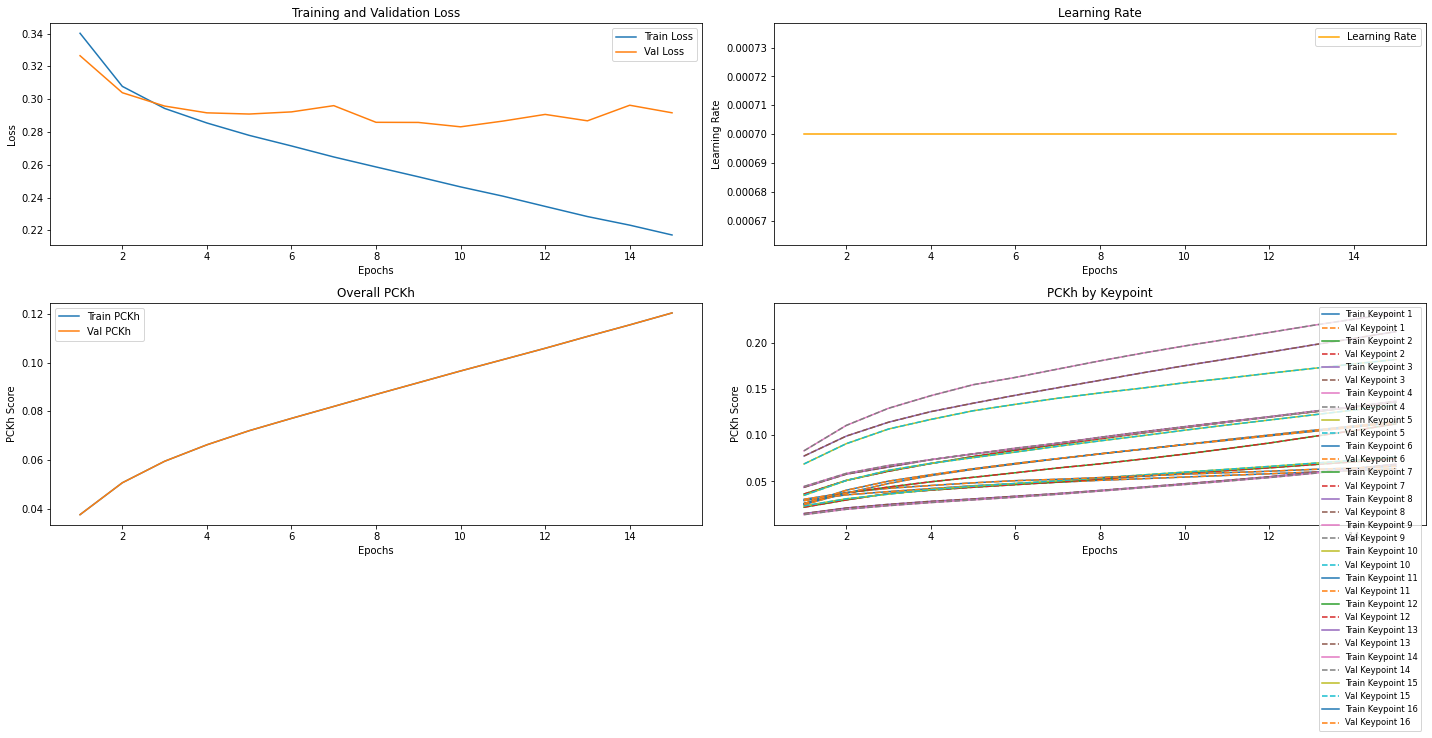

In [35]:
best_spb_model_file = spb_train(
    epochs=epochs,
    learning_rate=learning_rate,
    num_heatmap=num_heatmap,
    batch_size=batch_size,
    train_tfrecords=train_tfrecords,
    val_tfrecords=val_tfrecords
)

In [36]:
spb_model = Simplebaseline(IMAGE_SHAPE)
spb_model.load_weights(best_spb_model_file)

### STEP 3 : 두 모델의 비교
---
실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

- Pose Estimation 결과 시각화 (정성적 비교)
- 학습 진행 경과 (loss 감소 현황)  

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

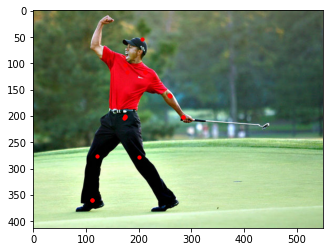

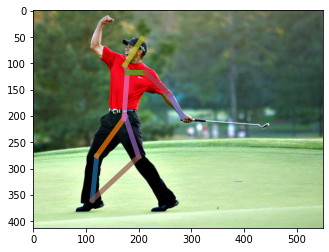

In [37]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(spb_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### Test 결과 기록
---

#### 각 모델 1 epoch 결과  

- StackedHourglass Network
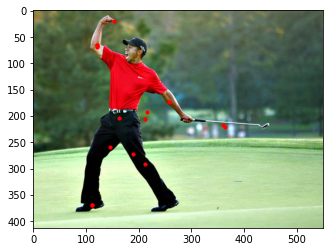
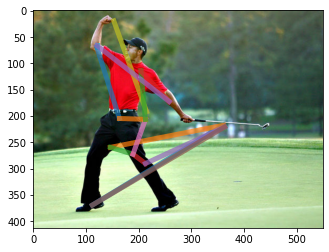  

- Simplebaseline  
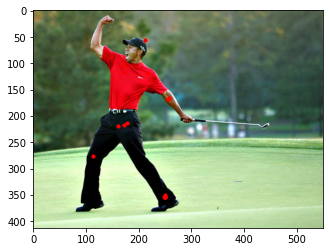
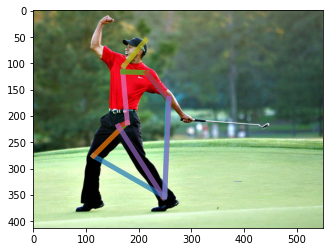

#### 각 모델 10 epoch 결과
- StackedHourglass Network
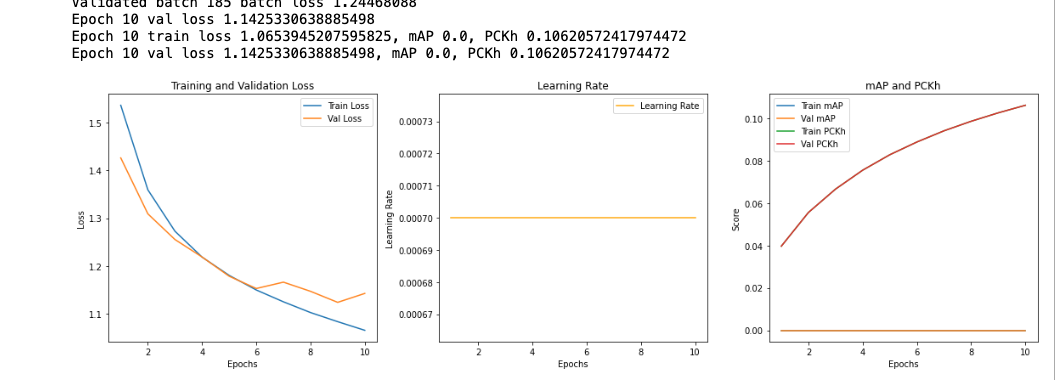
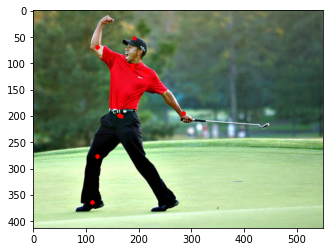
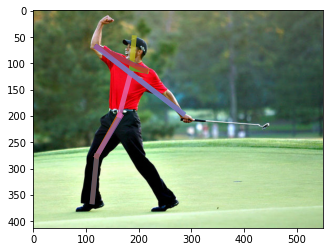

- Simplebaseline  
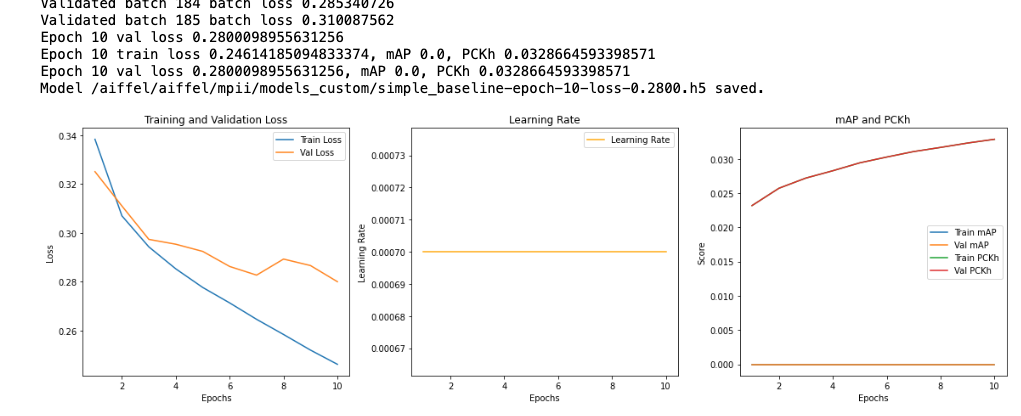
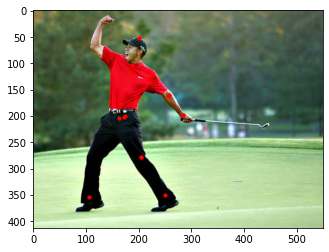
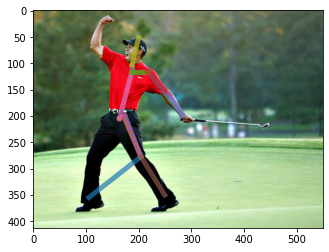

#### 각 모델 15 epoch 결과
- StackedHourglass Network
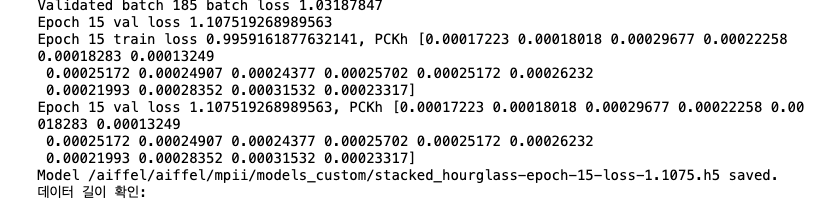
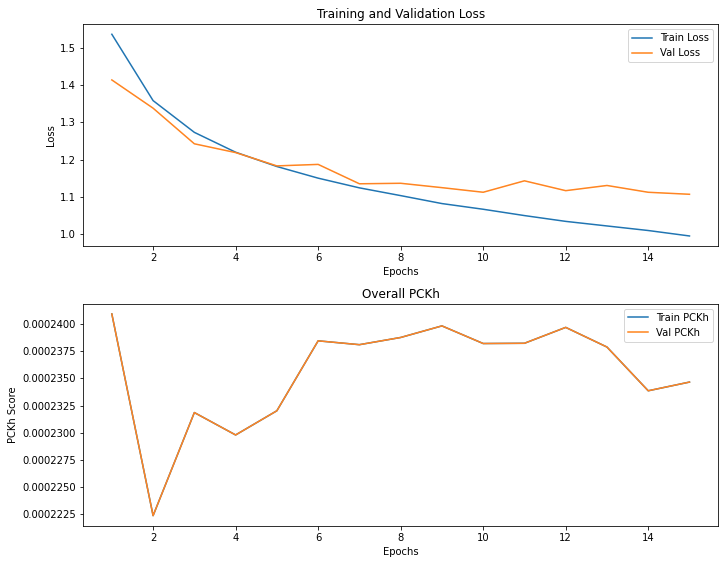
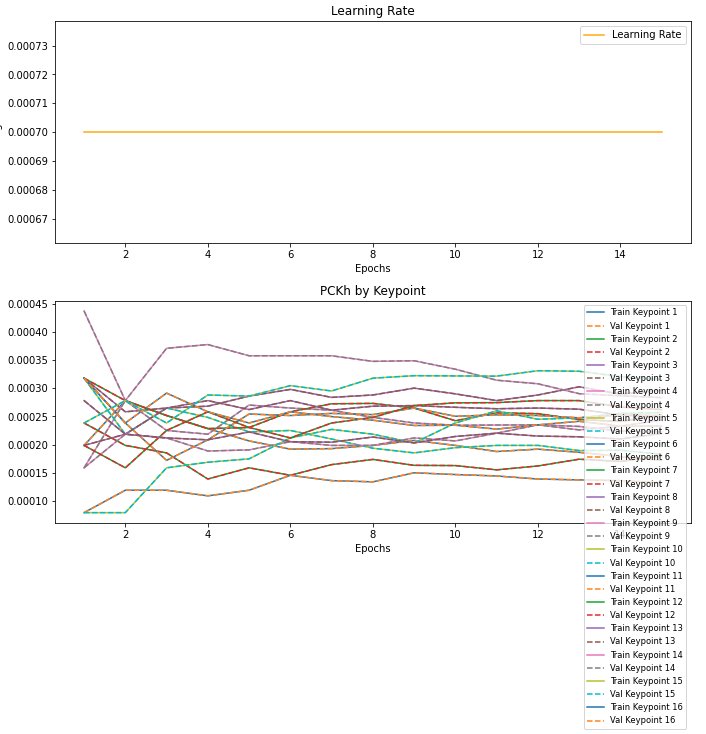
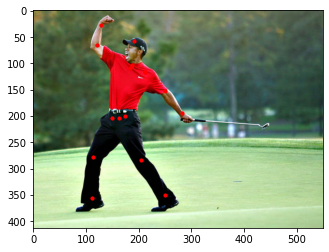
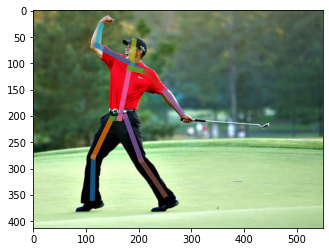  


- Simplebaseline
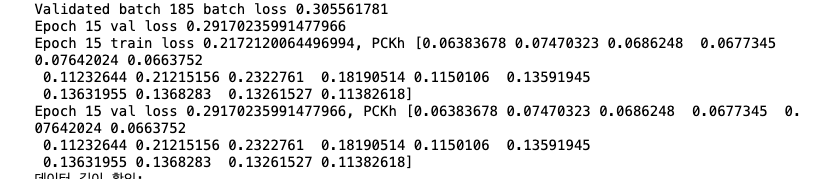
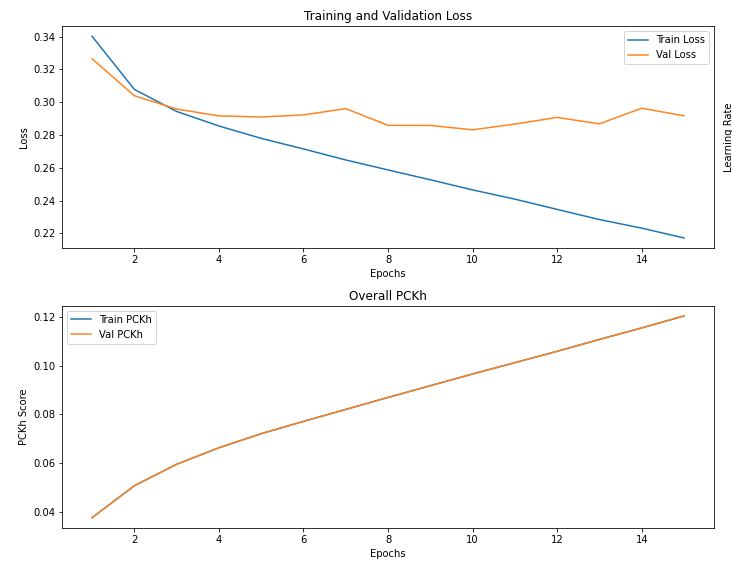
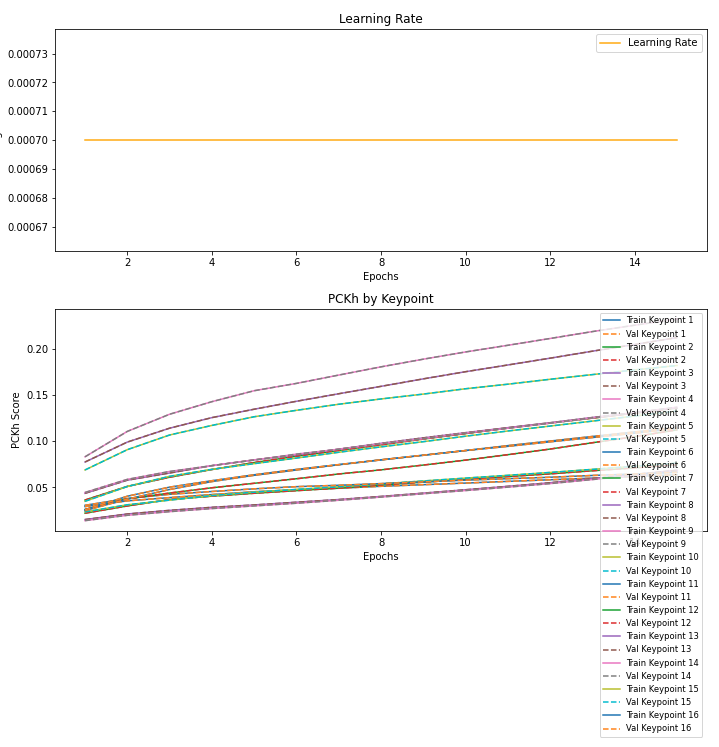
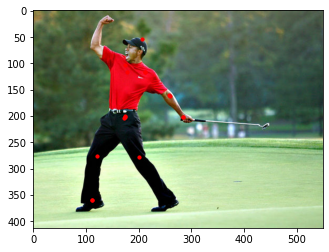
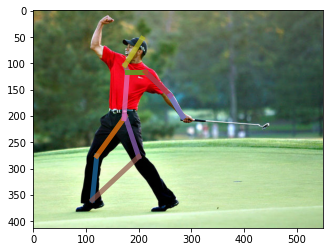

### 회고
- 이번 노드에서 Simplebaseline 을 학습 시키기 위해서 디버깅을 해야할 부분이 많이 있어 시간이 많이 부족했다.
- 두 모델다 10 epoch 씩 학습을 했는데 Simplebaseline loss 그래프를 보면 아직 학습이 덜 되어 보인다.
- 타이거 우즈 사진 결과를 보면 두 모델다 성능이 그리 좋게 나오지 않았다.
- metric 으로 mAP 와 PCKh 를 적용 하였는데 logic 에 문제인지 mAP는 결과가 0으로 나왔는데 정상적이지 않아 보인다.
- 디버깅이 필요한데 학습과 관련되어 있어서 시간이 필요 할 거 같다.
- 이번 노드가 프로토콜 버퍼, GPU 병렬 처리등 모델외 적인 부분이 많이 있어서 학습할 부분이 많았다. 조금더 학습이 필요하다.
- 추가 실험으로 각 모델을 15 epoch 으로 테스트를 진행 하였다.
- PCKh-0.5 에서 각 keypoint 점수와 시각화를 추가 하였다.
- StackedHourglass 의 값이 정상적이지 않아 보인다. 

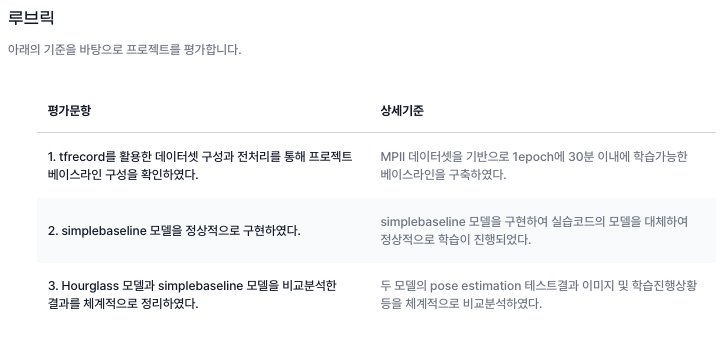